In [1]:
!pip install catboost

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from lightgbm import LGBMRegressor, LGBMClassifier
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout,Activation
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.python.keras import metrics
from tensorflow.python import keras
import tensorflow as tf
import os
from imblearn.over_sampling import SMOTE
import math
from category_encoders import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support as sk
from sklearn.metrics import f1_score ## F1 Score 구하기
from sklearn.metrics import accuracy_score
%matplotlib inline

In [3]:
import pandas as pd
import torch
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

import numpy as np
%matplotlib inline

In [4]:
df=pd.read_csv("../../../Integrated_data/merged_df_reward.csv",encoding="cp949")

In [5]:
import pandas as pd

class DataProcessor:
    def __init__(self, df):
        self.df = df
        self.interpolated()
        self.abmormaled()
        self.result=self.fill_missing_values()

    # ... (다른 클래스 함수 정의는 여기에 있어야 합니다)

    def interpolated(self):
        temp=[]
        temp2=[]
        for i in df['ID'].unique():
            try:
                temp.append(df[df['ID']==i].interpolate())
            except:
                temp.append(df[df['ID']==i])

        new_df=pd.concat(temp,axis=0)
        new_df.fillna(method='bfill',inplace=True)   
        for i in new_df['ID'].unique():
            temp_df=new_df[new_df['ID']==i].reset_index(drop=True)
            temp_df["height"].fillna(method='bfill',inplace=True)
            temp_df["weight"].fillna(method='bfill',inplace=True)
            temp_df["height"].fillna(method='ffill',inplace=True)
            temp_df["weight"].fillna(method='ffill',inplace=True)
            temp2.append(temp_df)
        new_df=pd.concat(temp2,axis=0)  
        self.df = new_df   
    def gap(self,first, last):
        gap_per=(last-first)/first*100
        return abs(gap_per)
        
    def abmormaled(self):
        temp = []
        for i in self.df['ID'].unique():
            temp_df = self.df[self.df['ID'] == i].reset_index(drop=True)
            for i in range(1, len(temp_df)):
                if temp_df.at[i, 'height'] <= temp_df.at[i - 1, 'height']:
                    temp_df.at[i, 'height'] = temp_df.at[i - 1, 'height']
                if self.gap(temp_df.at[i - 1, 'height'], temp_df.at[i, 'height']) >= 16:
                    temp_df.at[i, 'height'] = temp_df.at[i - 1, 'height']
            temp.append(temp_df)
        new_df2 = pd.concat(temp, axis=0)
        new_df2.reset_index(drop=True, inplace=True)
        self.df = new_df2

    def fill_missing_values(self):
        self.df["step_count"].fillna(self.df["step_count"].median(), inplace=True)
        self.df["burned calory"].fillna(self.df["burned calory"].median(), inplace=True)
        self.df["eat_calory"].fillna(self.df["eat_calory"].median(), inplace=True)
        self.df["Sleep_time"].fillna(self.df["Sleep_time"].median(), inplace=True)
        return self.df
    



In [6]:
import pandas as pd

class TimeSeriesLabeler:
    def __init__(self, term):
        self.term = term
        self.result_df = pd.DataFrame()
        self.labels = []

    def calculate_labels(self, df):
        for id in df['ID'].unique():
            df_id = df[df['ID'] == id].reset_index(drop=True)
            label = []

            for i in range(self.term, len(df_id)):
                previous_days = df_id['weight'].iloc[i - self.term:i]
                current_weight = df_id['weight'].iloc[i]
                if current_weight > previous_days.mean().round(3):
                    label.append(1)
                elif current_weight == previous_days.mean().round(3):
                    label.append(0)
                elif current_weight < previous_days.mean().round(3):
                    label.append(2)
                else:
                    print("error")

            self.labels.extend(label)

    def create_result_df(self, df):
        for id in df['ID'].unique():
            df_id = df[df['ID'] == id].reset_index(drop=True)
            df_id_drop = df_id.drop(index=range(self.term))
            self.result_df = pd.concat([self.result_df, df_id_drop])
        self.result_df['labels']= self.labels
        
    def get_labels(self):
        return self.labels

    def get_result_df(self):
        return self.result_df



In [7]:
for i in range(3):
    globals()['reward_data_{}'.format(i+1)]=pd.read_excel("../../../Integrated_data/merged_df_reward_분리.xlsx",sheet_name = i)
    

In [8]:
# 데이터프레임 리스트 생성
dataframes = [reward_data_1, reward_data_2, reward_data_3]

# 반복문으로 데이터프레임 순차적으로 호출
for i, df in enumerate(dataframes, start=0):
    print(f"Processing reward_data_{i+1}")
    processor = DataProcessor(df)
    globals()['df_{}'.format(i+1)]=processor.result


Processing reward_data_1
Processing reward_data_2
Processing reward_data_3


# ID 별로 일주일 간격으로 몸무게 변화 라벨링(유지:0, 감소:2, 증가:1)

In [9]:
term = 5  # You can set your desired 'term' here

In [10]:
labeler_1 = TimeSeriesLabeler(term)
labeler_1.calculate_labels(df_1)  # Provide your DataFrame 'df' as input
labeler_1.create_result_df(df_1)  # Create the result DataFrame
labels = labeler_1.get_labels()
result_df_1 = labeler_1.get_result_df()

In [11]:
labeler_2 = TimeSeriesLabeler(term)
labeler_2.calculate_labels(df_2)  # Provide your DataFrame 'df' as input
labeler_2.create_result_df(df_2)  # Create the result DataFrame
labels = labeler_2.get_labels()
result_df_2 = labeler_2.get_result_df()

In [12]:
labeler_3 = TimeSeriesLabeler(term)
labeler_3.calculate_labels(df_3)  # Provide your DataFrame 'df' as input
labeler_3.create_result_df(df_3)  # Create the result DataFrame
labels = labeler_3.get_labels()
result_df_3 = labeler_3.get_result_df()

In [13]:
result_df_3.head()

,ID,collect_datetime,gender,grade,height,weight,step_count,burned calory,eat_calory,Sleep_time,서포터여부,labels
5,#ASELLU,2022-07-19,2,6,164.0,64.0,5490.0,142.8,546.0,432.0,3,2
6,#ASELLU,2022-07-20,2,6,164.0,64.0,4100.0,142.8,546.0,432.0,3,1
7,#ASELLU,2022-07-21,2,6,164.0,64.0,4919.0,142.8,546.0,432.0,3,2
8,#ASELLU,2022-07-22,2,6,164.0,64.0,323.0,142.8,546.0,432.0,3,2
9,#ASELLU,2022-07-23,2,6,164.0,64.0,323.0,142.8,546.0,432.0,3,2


# 데이터 세트 로드

In [14]:
result_df_2.head()

,ID,collect_datetime,gender,grade,height,weight,step_count,burned calory,eat_calory,Sleep_time,서포터여부,labels
5,#AAGQKY,2022-07-19,2,4,148.0,45.15,72.0,48.552,2000.0,468.0,2,0
6,#AAGQKY,2022-07-20,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2
7,#AAGQKY,2022-07-21,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2
8,#AAGQKY,2022-07-22,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2
9,#AAGQKY,2022-07-23,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2


In [15]:
X_1=result_df_1.iloc[:,[4,5,6,7,8,9]]
y_1=result_df_1.iloc[:,-1]

X_2=result_df_2.iloc[:,[4,5,6,7,8,9]]
y_2=result_df_2.iloc[:,-1]

X_3=result_df_3.iloc[:,[4,5,6,7,8,9]]
y_3=result_df_3.iloc[:,-1].reset_index(drop=True)

In [16]:
y_1

5      2
6      2
7      2
8      0
9      0
      ..
177    0
178    0
179    0
180    0
181    0
Name: labels, Length: 37347, dtype: int64

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder

scaler_1 = StandardScaler()
scaler_2 = StandardScaler()
scaler_3 = StandardScaler()

X_scaler_1=scaler_1.fit_transform(X_1)
X_scaler_2= scaler_2.fit_transform(X_2)
X_scaler_3= scaler_3.fit_transform(X_3)


smote_1 = SMOTE(random_state=0)
X_over_1,y_over_1 = smote_1.fit_resample(X_scaler_1,y_1)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler_1.shape, y_1.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_over_1.shape, y_over_1.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y_1).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_over_1).value_counts())

smote_2 = SMOTE(random_state=0)
X_over_2,y_over_2 = smote_2.fit_resample(X_scaler_2,y_2)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler_2.shape, y_2.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_over_2.shape, y_over_2.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y_2).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_over_2).value_counts())

smote_3 = SMOTE(random_state=0)
X_over_3,y_over_3 = smote_3.fit_resample(X_scaler_3,y_3)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler_3.shape, y_3.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_over_3.shape, y_over_3.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y_3).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_over_3).value_counts())






SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (37347, 6) (37347,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (100797, 6) (100797,)
SMOTE 적용 전 레이블 값 분포: 
 0    33599
1     2318
2     1430
Name: labels, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 2    33599
0    33599
1    33599
Name: labels, dtype: int64
SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (13983, 6) (13983,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (37818, 6) (37818,)
SMOTE 적용 전 레이블 값 분포: 
 0    12606
1      752
2      625
Name: labels, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 0    12606
2    12606
1    12606
Name: labels, dtype: int64
SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (4602, 6) (4602,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (10857, 6) (10857,)
SMOTE 적용 전 레이블 값 분포: 
 0    3619
1     534
2     449
Name: labels, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 2    3619
1    3619
0    3619
Name: labels, dtype: int64


# 데이터 스케일링

## Train, Test dataset 나누기

In [18]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_over_1, y_over_1, test_size=0.20)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_over_2, y_over_2, test_size=0.20)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_over_3, y_over_3, test_size=0.20)

## Global train 데이터 세트 만들기

In [19]:
X_train = np.concatenate((X_train_1,X_train_2,X_train_3), axis=0)
y_train = np.concatenate((y_train_1,y_train_2,y_train_3), axis=0)

In [20]:
X_test = np.concatenate((X_test_1,X_test_2,X_test_3), axis=0)
y_test = np.concatenate((y_test_1,y_test_2,y_test_3), axis=0)

In [21]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
train_dataset=TensorDataset(X_train, y_train)
test_dataset=TensorDataset(X_test, y_test)

## Client train 데이터 세트 만들기

In [22]:
X_train_1 = torch.FloatTensor(X_train_1)
X_test_1 = torch.FloatTensor(X_test_1)
y_train_1 = torch.LongTensor(y_train_1.to_numpy())
y_test_1 = torch.LongTensor(y_test_1.to_numpy())

train_dataset_1=TensorDataset(X_train_1, y_train_1)
test_dataset_1=TensorDataset(X_test_1, y_test_1)

In [23]:
X_train_2 = torch.FloatTensor(X_train_2)
X_test_2 = torch.FloatTensor(X_test_2)
y_train_2 = torch.LongTensor(y_train_2.to_numpy())
y_test_2 = torch.LongTensor(y_test_2.to_numpy())

train_dataset_2=TensorDataset(X_train_2, y_train_2)
test_dataset_2=TensorDataset(X_test_2, y_test_2)

In [24]:
X_train_3 = torch.FloatTensor(X_train_3)
X_test_3 = torch.FloatTensor(X_test_3)
y_train_3 = torch.LongTensor(y_train_3.to_numpy())
y_test_3 = torch.LongTensor(y_test_3.to_numpy())

train_dataset_3=TensorDataset(X_train_3, y_train_3)
test_dataset_3=TensorDataset(X_test_3, y_test_3)

In [25]:
# from sklearn.model_selection import StratifiedKFold
# skf=StratifiedKFold(n_splits=10)
# skf.get_n_splits(X_train_1,y_train_1)

In [26]:
#X_train_over=X_over_3
#y_train_over=y_over_3

In [27]:
X_train_over=X_scaler_3
y_train_over=y_3

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 1.13003. Saving Model!
epoch 01, loss: 1.18253, acc: 0.10215, val_loss: 1.13003, val_accuracy: 0.09544


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


[INFO] val_acc has been improved from 1.13003 to 1.07616. Saving Model!
epoch 02, loss: 1.12590, acc: 0.10577, val_loss: 1.07616, val_accuracy: 0.55315


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


[INFO] val_acc has been improved from 1.07616 to 1.02477. Saving Model!
epoch 03, loss: 1.07662, acc: 0.29969, val_loss: 1.02477, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


[INFO] val_acc has been improved from 1.02477 to 0.97395. Saving Model!
epoch 04, loss: 1.03023, acc: 0.78652, val_loss: 0.97395, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


[INFO] val_acc has been improved from 0.97395 to 0.92045. Saving Model!
epoch 05, loss: 0.98395, acc: 0.78652, val_loss: 0.92045, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


[INFO] val_acc has been improved from 0.92045 to 0.86564. Saving Model!
epoch 06, loss: 0.93619, acc: 0.78652, val_loss: 0.86564, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


[INFO] val_acc has been improved from 0.86564 to 0.81211. Saving Model!
epoch 07, loss: 0.88691, acc: 0.78652, val_loss: 0.81211, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


[INFO] val_acc has been improved from 0.81211 to 0.76308. Saving Model!
epoch 08, loss: 0.83814, acc: 0.78652, val_loss: 0.76308, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


[INFO] val_acc has been improved from 0.76308 to 0.72292. Saving Model!
epoch 09, loss: 0.79340, acc: 0.78652, val_loss: 0.72292, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


[INFO] val_acc has been improved from 0.72292 to 0.69663. Saving Model!
epoch 10, loss: 0.75676, acc: 0.78652, val_loss: 0.69663, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


[INFO] val_acc has been improved from 0.69663 to 0.68715. Saving Model!
epoch 11, loss: 0.73257, acc: 0.78652, val_loss: 0.68715, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 12, loss: 0.72273, acc: 0.78652, val_loss: 0.69224, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 13, loss: 0.72519, acc: 0.78652, val_loss: 0.70403, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 14, loss: 0.73352, acc: 0.78652, val_loss: 0.71352, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 15, loss: 0.74005, acc: 0.78652, val_loss: 0.71553, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 16, loss: 0.73989, acc: 0.78652, val_loss: 0.70943, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]


epoch 17, loss: 0.73218, acc: 0.78652, val_loss: 0.69759, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.35it/s]


[INFO] val_acc has been improved from 0.68715 to 0.68375. Saving Model!
epoch 18, loss: 0.71887, acc: 0.78652, val_loss: 0.68375, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


[INFO] val_acc has been improved from 0.68375 to 0.67163. Saving Model!
epoch 19, loss: 0.70321, acc: 0.78652, val_loss: 0.67163, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


[INFO] val_acc has been improved from 0.67163 to 0.66375. Saving Model!
epoch 20, loss: 0.68853, acc: 0.78652, val_loss: 0.66375, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


[INFO] val_acc has been improved from 0.66375 to 0.66130. Saving Model!
epoch 21, loss: 0.67703, acc: 0.78652, val_loss: 0.66130, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 22, loss: 0.67006, acc: 0.78652, val_loss: 0.66387, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 23, loss: 0.66756, acc: 0.78652, val_loss: 0.66966, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 24, loss: 0.66834, acc: 0.78677, val_loss: 0.67594, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]


epoch 25, loss: 0.67008, acc: 0.78677, val_loss: 0.68054, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 26, loss: 0.67067, acc: 0.78677, val_loss: 0.68227, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 27, loss: 0.66917, acc: 0.78677, val_loss: 0.68113, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 28, loss: 0.66568, acc: 0.78677, val_loss: 0.67799, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 29, loss: 0.66100, acc: 0.78677, val_loss: 0.67399, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 30, loss: 0.65613, acc: 0.78677, val_loss: 0.67034, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 31, loss: 0.65200, acc: 0.78677, val_loss: 0.66785, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 32, loss: 0.64924, acc: 0.78677, val_loss: 0.66686, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 33, loss: 0.64799, acc: 0.78677, val_loss: 0.66717, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 34, loss: 0.64784, acc: 0.78677, val_loss: 0.66816, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 35, loss: 0.64798, acc: 0.78677, val_loss: 0.66909, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 36, loss: 0.64768, acc: 0.78677, val_loss: 0.66942, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 37, loss: 0.64645, acc: 0.78677, val_loss: 0.66902, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 38, loss: 0.64433, acc: 0.78677, val_loss: 0.66813, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]

epoch 39, loss: 0.64170, acc: 0.78677, val_loss: 0.66714, val_accuracy: 0.78525

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 40, loss: 0.63919, acc: 0.78677, val_loss: 0.66637, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


epoch 41, loss: 0.63727, acc: 0.78677, val_loss: 0.66601, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 42, loss: 0.63616, acc: 0.78677, val_loss: 0.66592, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 43, loss: 0.63563, acc: 0.78677, val_loss: 0.66594, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 44, loss: 0.63520, acc: 0.78677, val_loss: 0.66587, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 45, loss: 0.63445, acc: 0.78677, val_loss: 0.66572, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 46, loss: 0.63318, acc: 0.78677, val_loss: 0.66575, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 47, loss: 0.63157, acc: 0.78677, val_loss: 0.66628, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.35it/s]


epoch 48, loss: 0.63002, acc: 0.78677, val_loss: 0.66750, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 49, loss: 0.62884, acc: 0.78677, val_loss: 0.66928, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 50, loss: 0.62811, acc: 0.78677, val_loss: 0.67131, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 51, loss: 0.62765, acc: 0.78677, val_loss: 0.67312, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 52, loss: 0.62719, acc: 0.78677, val_loss: 0.67430, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 53, loss: 0.62648, acc: 0.78677, val_loss: 0.67476, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 54, loss: 0.62549, acc: 0.78677, val_loss: 0.67464, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 55, loss: 0.62438, acc: 0.78749, val_loss: 0.67427, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


epoch 56, loss: 0.62339, acc: 0.78701, val_loss: 0.67402, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 57, loss: 0.62266, acc: 0.78701, val_loss: 0.67407, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 58, loss: 0.62215, acc: 0.78701, val_loss: 0.67448, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 59, loss: 0.62165, acc: 0.78701, val_loss: 0.67531, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 60, loss: 0.62099, acc: 0.78701, val_loss: 0.67646, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 61, loss: 0.62015, acc: 0.78701, val_loss: 0.67790, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 62, loss: 0.61929, acc: 0.78701, val_loss: 0.67947, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


epoch 63, loss: 0.61855, acc: 0.78701, val_loss: 0.68102, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 64, loss: 0.61796, acc: 0.78701, val_loss: 0.68223, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 65, loss: 0.61739, acc: 0.78701, val_loss: 0.68288, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 66, loss: 0.61672, acc: 0.78701, val_loss: 0.68302, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 67, loss: 0.61596, acc: 0.78701, val_loss: 0.68268, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 68, loss: 0.61516, acc: 0.78701, val_loss: 0.68217, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 69, loss: 0.61441, acc: 0.78652, val_loss: 0.68177, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 70, loss: 0.61372, acc: 0.78701, val_loss: 0.68159, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]


epoch 71, loss: 0.61305, acc: 0.78701, val_loss: 0.68173, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 72, loss: 0.61232, acc: 0.78894, val_loss: 0.68217, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 73, loss: 0.61155, acc: 0.78918, val_loss: 0.68289, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 74, loss: 0.61078, acc: 0.78918, val_loss: 0.68380, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 75, loss: 0.61005, acc: 0.78918, val_loss: 0.68474, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 76, loss: 0.60931, acc: 0.78942, val_loss: 0.68555, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 77, loss: 0.60859, acc: 0.78942, val_loss: 0.68616, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 78, loss: 0.60784, acc: 0.78942, val_loss: 0.68660, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 79, loss: 0.60708, acc: 0.78918, val_loss: 0.68699, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


epoch 80, loss: 0.60632, acc: 0.78991, val_loss: 0.68745, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 81, loss: 0.60556, acc: 0.78966, val_loss: 0.68807, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 82, loss: 0.60479, acc: 0.78918, val_loss: 0.68882, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 83, loss: 0.60399, acc: 0.78918, val_loss: 0.68972, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 84, loss: 0.60318, acc: 0.78918, val_loss: 0.69069, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 85, loss: 0.60234, acc: 0.78942, val_loss: 0.69157, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 86, loss: 0.60150, acc: 0.78942, val_loss: 0.69228, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.75it/s]


epoch 87, loss: 0.60063, acc: 0.78942, val_loss: 0.69280, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 88, loss: 0.59974, acc: 0.78942, val_loss: 0.69327, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 89, loss: 0.59884, acc: 0.78942, val_loss: 0.69385, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 90, loss: 0.59797, acc: 0.78942, val_loss: 0.69462, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 91, loss: 0.59710, acc: 0.78942, val_loss: 0.69556, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 92, loss: 0.59621, acc: 0.78942, val_loss: 0.69659, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 93, loss: 0.59531, acc: 0.78942, val_loss: 0.69762, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 94, loss: 0.59440, acc: 0.79015, val_loss: 0.69863, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 95, loss: 0.59346, acc: 0.78991, val_loss: 0.69961, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.13it/s]


epoch 96, loss: 0.59252, acc: 0.78991, val_loss: 0.70054, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 97, loss: 0.59158, acc: 0.78991, val_loss: 0.70153, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 98, loss: 0.59062, acc: 0.78991, val_loss: 0.70267, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 99, loss: 0.58965, acc: 0.78991, val_loss: 0.70396, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 100, loss: 0.58865, acc: 0.79015, val_loss: 0.70532, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 101, loss: 0.58764, acc: 0.79015, val_loss: 0.70675, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 102, loss: 0.58663, acc: 0.79015, val_loss: 0.70821, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


epoch 103, loss: 0.58561, acc: 0.79015, val_loss: 0.70973, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 104, loss: 0.58459, acc: 0.79015, val_loss: 0.71128, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 105, loss: 0.58354, acc: 0.79015, val_loss: 0.71282, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 106, loss: 0.58246, acc: 0.79039, val_loss: 0.71442, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 107, loss: 0.58135, acc: 0.79015, val_loss: 0.71584, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 108, loss: 0.58026, acc: 0.79015, val_loss: 0.71727, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 109, loss: 0.57916, acc: 0.79015, val_loss: 0.71879, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 110, loss: 0.57804, acc: 0.79063, val_loss: 0.72039, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 111, loss: 0.57690, acc: 0.79111, val_loss: 0.72224, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 112, loss: 0.57576, acc: 0.79087, val_loss: 0.72437, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 113, loss: 0.57460, acc: 0.79087, val_loss: 0.72678, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 114, loss: 0.57344, acc: 0.79111, val_loss: 0.72916, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


epoch 115, loss: 0.57225, acc: 0.79160, val_loss: 0.73145, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 116, loss: 0.57105, acc: 0.79135, val_loss: 0.73368, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 117, loss: 0.56987, acc: 0.79087, val_loss: 0.73579, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 118, loss: 0.56868, acc: 0.79063, val_loss: 0.73800, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 119, loss: 0.56749, acc: 0.79063, val_loss: 0.74023, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 120, loss: 0.56627, acc: 0.79111, val_loss: 0.74243, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 121, loss: 0.56504, acc: 0.79111, val_loss: 0.74483, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 122, loss: 0.56383, acc: 0.79111, val_loss: 0.74744, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 123, loss: 0.56260, acc: 0.79184, val_loss: 0.75009, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 124, loss: 0.56136, acc: 0.79280, val_loss: 0.75272, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 125, loss: 0.56014, acc: 0.79280, val_loss: 0.75518, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.23it/s]


epoch 126, loss: 0.55893, acc: 0.79280, val_loss: 0.75765, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 127, loss: 0.55768, acc: 0.79232, val_loss: 0.76015, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 128, loss: 0.55644, acc: 0.79208, val_loss: 0.76252, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 129, loss: 0.55518, acc: 0.79208, val_loss: 0.76544, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 130, loss: 0.55395, acc: 0.79256, val_loss: 0.76867, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 131, loss: 0.55271, acc: 0.79208, val_loss: 0.77205, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 132, loss: 0.55143, acc: 0.79184, val_loss: 0.77536, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 133, loss: 0.55017, acc: 0.79160, val_loss: 0.77853, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 134, loss: 0.54889, acc: 0.79184, val_loss: 0.78147, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]


epoch 135, loss: 0.54763, acc: 0.79184, val_loss: 0.78453, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 136, loss: 0.54632, acc: 0.79208, val_loss: 0.78758, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 137, loss: 0.54502, acc: 0.79208, val_loss: 0.79052, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 138, loss: 0.54371, acc: 0.79232, val_loss: 0.79325, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 139, loss: 0.54240, acc: 0.79425, val_loss: 0.79571, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 140, loss: 0.54108, acc: 0.79425, val_loss: 0.79835, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 141, loss: 0.53977, acc: 0.79425, val_loss: 0.80105, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


epoch 142, loss: 0.53842, acc: 0.79522, val_loss: 0.80377, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 143, loss: 0.53706, acc: 0.79546, val_loss: 0.80670, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 144, loss: 0.53574, acc: 0.79594, val_loss: 0.80967, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 145, loss: 0.53442, acc: 0.79546, val_loss: 0.81240, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 146, loss: 0.53310, acc: 0.79449, val_loss: 0.81503, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.74it/s]


epoch 147, loss: 0.53179, acc: 0.79691, val_loss: 0.81765, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 148, loss: 0.53048, acc: 0.79763, val_loss: 0.81992, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 149, loss: 0.52916, acc: 0.79787, val_loss: 0.82295, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 150, loss: 0.52784, acc: 0.79836, val_loss: 0.82711, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


epoch 151, loss: 0.52653, acc: 0.79860, val_loss: 0.83052, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 152, loss: 0.52521, acc: 0.79981, val_loss: 0.83298, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 153, loss: 0.52387, acc: 0.79981, val_loss: 0.83577, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 154, loss: 0.52257, acc: 0.80053, val_loss: 0.83935, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 155, loss: 0.52131, acc: 0.79981, val_loss: 0.84323, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 156, loss: 0.52003, acc: 0.80053, val_loss: 0.84671, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 157, loss: 0.51873, acc: 0.80029, val_loss: 0.85044, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 158, loss: 0.51743, acc: 0.80077, val_loss: 0.85440, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 159, loss: 0.51615, acc: 0.80198, val_loss: 0.85723, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 160, loss: 0.51483, acc: 0.80222, val_loss: 0.85983, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 161, loss: 0.51350, acc: 0.80295, val_loss: 0.86230, val_accuracy: 0.66811


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 162, loss: 0.51212, acc: 0.80391, val_loss: 0.86733, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 163, loss: 0.51083, acc: 0.80246, val_loss: 0.87049, val_accuracy: 0.66811


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 164, loss: 0.50964, acc: 0.80440, val_loss: 0.87526, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 165, loss: 0.50863, acc: 0.80319, val_loss: 0.87522, val_accuracy: 0.66811


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]


epoch 166, loss: 0.50777, acc: 0.80464, val_loss: 0.88394, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 167, loss: 0.50680, acc: 0.80343, val_loss: 0.88489, val_accuracy: 0.66811


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 168, loss: 0.50505, acc: 0.80609, val_loss: 0.88905, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 169, loss: 0.50346, acc: 0.80584, val_loss: 0.89126, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 170, loss: 0.50258, acc: 0.80488, val_loss: 0.89088, val_accuracy: 0.66811


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 171, loss: 0.50175, acc: 0.80657, val_loss: 0.89899, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 172, loss: 0.50050, acc: 0.80633, val_loss: 0.90105, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.32it/s]


epoch 173, loss: 0.49898, acc: 0.80753, val_loss: 0.90495, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 174, loss: 0.49792, acc: 0.80995, val_loss: 0.90974, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 175, loss: 0.49713, acc: 0.80584, val_loss: 0.90802, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 176, loss: 0.49609, acc: 0.80922, val_loss: 0.91400, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 177, loss: 0.49473, acc: 0.80947, val_loss: 0.91738, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 178, loss: 0.49346, acc: 0.81140, val_loss: 0.92093, val_accuracy: 0.68764


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 179, loss: 0.49245, acc: 0.80995, val_loss: 0.92674, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 180, loss: 0.49155, acc: 0.81019, val_loss: 0.92489, val_accuracy: 0.68764


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.41it/s]


epoch 181, loss: 0.49052, acc: 0.81067, val_loss: 0.93018, val_accuracy: 0.68980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 182, loss: 0.48936, acc: 0.81092, val_loss: 0.93114, val_accuracy: 0.68764


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 183, loss: 0.48808, acc: 0.80995, val_loss: 0.93520, val_accuracy: 0.68764


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.29it/s]


epoch 184, loss: 0.48689, acc: 0.81092, val_loss: 0.93815, val_accuracy: 0.68764


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.50it/s]


epoch 185, loss: 0.48587, acc: 0.81116, val_loss: 0.93778, val_accuracy: 0.68764


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 186, loss: 0.48493, acc: 0.81140, val_loss: 0.94678, val_accuracy: 0.70065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 187, loss: 0.48406, acc: 0.81067, val_loss: 0.94614, val_accuracy: 0.68764


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 188, loss: 0.48317, acc: 0.81092, val_loss: 0.95389, val_accuracy: 0.70065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 189, loss: 0.48209, acc: 0.80971, val_loss: 0.94922, val_accuracy: 0.68764


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]


epoch 190, loss: 0.48077, acc: 0.81357, val_loss: 0.95579, val_accuracy: 0.70065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 191, loss: 0.47945, acc: 0.81236, val_loss: 0.95632, val_accuracy: 0.70065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 192, loss: 0.47826, acc: 0.81285, val_loss: 0.95807, val_accuracy: 0.70065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 193, loss: 0.47719, acc: 0.81381, val_loss: 0.96240, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 194, loss: 0.47631, acc: 0.81140, val_loss: 0.96156, val_accuracy: 0.70065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 195, loss: 0.47560, acc: 0.81478, val_loss: 0.97193, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 196, loss: 0.47504, acc: 0.81067, val_loss: 0.96657, val_accuracy: 0.70499


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 197, loss: 0.47440, acc: 0.81502, val_loss: 0.97925, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 198, loss: 0.47355, acc: 0.81092, val_loss: 0.97075, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.41it/s]


epoch 199, loss: 0.47181, acc: 0.81647, val_loss: 0.97559, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 200, loss: 0.47021, acc: 0.81478, val_loss: 0.97825, val_accuracy: 0.70499


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 201, loss: 0.46918, acc: 0.81550, val_loss: 0.97930, val_accuracy: 0.70499


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 202, loss: 0.46864, acc: 0.81695, val_loss: 0.99160, val_accuracy: 0.70499


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]

epoch 203, loss: 0.46811, acc: 0.81550, val_loss: 0.98498, val_accuracy: 0.70282

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]

epoch 204, loss: 0.46711, acc: 0.81671, val_loss: 0.99537, val_accuracy: 0.70499

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 205, loss: 0.46582, acc: 0.81792, val_loss: 0.99542, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.41it/s]


epoch 206, loss: 0.46440, acc: 0.81768, val_loss: 1.00174, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 207, loss: 0.46330, acc: 0.81961, val_loss: 1.00797, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 208, loss: 0.46255, acc: 0.81864, val_loss: 1.00751, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 209, loss: 0.46203, acc: 0.81864, val_loss: 1.02292, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 210, loss: 0.46165, acc: 0.81840, val_loss: 1.01655, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 211, loss: 0.46070, acc: 0.82106, val_loss: 1.02874, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 212, loss: 0.45954, acc: 0.81816, val_loss: 1.02461, val_accuracy: 0.70065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.53it/s]


epoch 213, loss: 0.45789, acc: 0.82275, val_loss: 1.03081, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 214, loss: 0.45669, acc: 0.82202, val_loss: 1.03222, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 215, loss: 0.45589, acc: 0.82130, val_loss: 1.02854, val_accuracy: 0.70065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 216, loss: 0.45533, acc: 0.82396, val_loss: 1.03988, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 217, loss: 0.45490, acc: 0.82057, val_loss: 1.03742, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 218, loss: 0.45430, acc: 0.82540, val_loss: 1.05200, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 219, loss: 0.45353, acc: 0.82106, val_loss: 1.04594, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 220, loss: 0.45223, acc: 0.82565, val_loss: 1.05789, val_accuracy: 0.70065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]


epoch 221, loss: 0.45084, acc: 0.82347, val_loss: 1.05964, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 222, loss: 0.44963, acc: 0.82734, val_loss: 1.06320, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]


epoch 223, loss: 0.44877, acc: 0.82903, val_loss: 1.06923, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 224, loss: 0.44818, acc: 0.82589, val_loss: 1.06581, val_accuracy: 0.69631


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 225, loss: 0.44771, acc: 0.82879, val_loss: 1.07643, val_accuracy: 0.70065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 226, loss: 0.44737, acc: 0.82299, val_loss: 1.07224, val_accuracy: 0.69631


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 227, loss: 0.44686, acc: 0.82589, val_loss: 1.08853, val_accuracy: 0.70065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.21it/s]


epoch 228, loss: 0.44647, acc: 0.82251, val_loss: 1.07780, val_accuracy: 0.69631


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 229, loss: 0.44506, acc: 0.82589, val_loss: 1.08534, val_accuracy: 0.70065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 230, loss: 0.44351, acc: 0.82613, val_loss: 1.08662, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.41it/s]


epoch 231, loss: 0.44217, acc: 0.82999, val_loss: 1.09537, val_accuracy: 0.69631


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 232, loss: 0.44142, acc: 0.82975, val_loss: 1.10178, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 233, loss: 0.44109, acc: 0.82782, val_loss: 1.09528, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]


epoch 234, loss: 0.44100, acc: 0.82927, val_loss: 1.11199, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 235, loss: 0.44112, acc: 0.82565, val_loss: 1.10907, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.49it/s]


epoch 236, loss: 0.44018, acc: 0.83048, val_loss: 1.12031, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 237, loss: 0.43876, acc: 0.82734, val_loss: 1.11363, val_accuracy: 0.69631


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 238, loss: 0.43699, acc: 0.83048, val_loss: 1.12021, val_accuracy: 0.69631


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 239, loss: 0.43594, acc: 0.83120, val_loss: 1.13032, val_accuracy: 0.69631


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 240, loss: 0.43572, acc: 0.83023, val_loss: 1.12616, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 241, loss: 0.43570, acc: 0.82975, val_loss: 1.13751, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 242, loss: 0.43563, acc: 0.82806, val_loss: 1.13158, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 243, loss: 0.43451, acc: 0.83168, val_loss: 1.14337, val_accuracy: 0.69631


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 244, loss: 0.43306, acc: 0.82999, val_loss: 1.14128, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.53it/s]


epoch 245, loss: 0.43161, acc: 0.83120, val_loss: 1.14340, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 246, loss: 0.43086, acc: 0.83313, val_loss: 1.15072, val_accuracy: 0.69631


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 247, loss: 0.43058, acc: 0.83023, val_loss: 1.14788, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 248, loss: 0.43041, acc: 0.83192, val_loss: 1.15880, val_accuracy: 0.69631


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 249, loss: 0.43025, acc: 0.82999, val_loss: 1.15240, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 250, loss: 0.42932, acc: 0.83168, val_loss: 1.16403, val_accuracy: 0.69631


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 251, loss: 0.42817, acc: 0.83096, val_loss: 1.16266, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]


epoch 252, loss: 0.42687, acc: 0.83289, val_loss: 1.16605, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 253, loss: 0.42592, acc: 0.83337, val_loss: 1.16962, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 254, loss: 0.42533, acc: 0.83337, val_loss: 1.17443, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 255, loss: 0.42499, acc: 0.83241, val_loss: 1.18871, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 256, loss: 0.42487, acc: 0.83217, val_loss: 1.18544, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 257, loss: 0.42472, acc: 0.83265, val_loss: 1.19466, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 258, loss: 0.42483, acc: 0.83048, val_loss: 1.19007, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 259, loss: 0.42418, acc: 0.83337, val_loss: 1.20781, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 260, loss: 0.42342, acc: 0.83072, val_loss: 1.20136, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.17it/s]


epoch 261, loss: 0.42161, acc: 0.83386, val_loss: 1.20318, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 262, loss: 0.42022, acc: 0.83410, val_loss: 1.21075, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 263, loss: 0.41952, acc: 0.83555, val_loss: 1.21996, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 264, loss: 0.41942, acc: 0.83434, val_loss: 1.22938, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 265, loss: 0.41963, acc: 0.83217, val_loss: 1.22397, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 266, loss: 0.41952, acc: 0.83603, val_loss: 1.23674, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 267, loss: 0.41922, acc: 0.83217, val_loss: 1.23619, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


epoch 268, loss: 0.41772, acc: 0.83627, val_loss: 1.24214, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 269, loss: 0.41626, acc: 0.83531, val_loss: 1.24480, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 270, loss: 0.41525, acc: 0.83603, val_loss: 1.24837, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 271, loss: 0.41484, acc: 0.83579, val_loss: 1.25222, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]


epoch 272, loss: 0.41488, acc: 0.83458, val_loss: 1.24900, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 273, loss: 0.41497, acc: 0.83820, val_loss: 1.26579, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 274, loss: 0.41517, acc: 0.83410, val_loss: 1.26895, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 275, loss: 0.41432, acc: 0.83869, val_loss: 1.27708, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.71it/s]


epoch 276, loss: 0.41313, acc: 0.83458, val_loss: 1.27158, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 277, loss: 0.41154, acc: 0.83844, val_loss: 1.28262, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 278, loss: 0.41056, acc: 0.83748, val_loss: 1.29182, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 279, loss: 0.41008, acc: 0.83724, val_loss: 1.29002, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 280, loss: 0.41001, acc: 0.83989, val_loss: 1.29600, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 281, loss: 0.41028, acc: 0.83506, val_loss: 1.30196, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 282, loss: 0.41030, acc: 0.84231, val_loss: 1.31447, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


epoch 283, loss: 0.41020, acc: 0.83531, val_loss: 1.30938, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


epoch 284, loss: 0.40896, acc: 0.84207, val_loss: 1.31795, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


epoch 285, loss: 0.40767, acc: 0.83651, val_loss: 1.32374, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 286, loss: 0.40629, acc: 0.84110, val_loss: 1.33191, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 287, loss: 0.40552, acc: 0.83965, val_loss: 1.33729, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 288, loss: 0.40511, acc: 0.83820, val_loss: 1.33909, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 289, loss: 0.40511, acc: 0.84255, val_loss: 1.34549, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 290, loss: 0.40518, acc: 0.83675, val_loss: 1.34812, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 291, loss: 0.40513, acc: 0.84303, val_loss: 1.35890, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 292, loss: 0.40511, acc: 0.83651, val_loss: 1.35819, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 293, loss: 0.40420, acc: 0.84327, val_loss: 1.36583, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 294, loss: 0.40324, acc: 0.83724, val_loss: 1.37123, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 295, loss: 0.40185, acc: 0.84279, val_loss: 1.38050, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 296, loss: 0.40088, acc: 0.83917, val_loss: 1.38397, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 297, loss: 0.40026, acc: 0.84207, val_loss: 1.38547, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 298, loss: 0.40013, acc: 0.84376, val_loss: 1.39285, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 299, loss: 0.40024, acc: 0.83844, val_loss: 1.39857, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


epoch 300, loss: 0.40046, acc: 0.84352, val_loss: 1.41101, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 301, loss: 0.40086, acc: 0.83796, val_loss: 1.41668, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 302, loss: 0.40036, acc: 0.84352, val_loss: 1.42552, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 303, loss: 0.39987, acc: 0.83844, val_loss: 1.42395, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 304, loss: 0.39813, acc: 0.84400, val_loss: 1.42771, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 305, loss: 0.39673, acc: 0.84279, val_loss: 1.43351, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 306, loss: 0.39578, acc: 0.84472, val_loss: 1.43751, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.49it/s]


epoch 307, loss: 0.39572, acc: 0.84448, val_loss: 1.44055, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 308, loss: 0.39596, acc: 0.83989, val_loss: 1.44423, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 309, loss: 0.39641, acc: 0.84424, val_loss: 1.45872, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 310, loss: 0.39697, acc: 0.83941, val_loss: 1.46228, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 311, loss: 0.39619, acc: 0.84593, val_loss: 1.46246, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 312, loss: 0.39499, acc: 0.84062, val_loss: 1.46255, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 313, loss: 0.39327, acc: 0.84521, val_loss: 1.47265, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 314, loss: 0.39221, acc: 0.84496, val_loss: 1.48136, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 315, loss: 0.39181, acc: 0.84496, val_loss: 1.47827, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.26it/s]


epoch 316, loss: 0.39218, acc: 0.84617, val_loss: 1.48332, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 317, loss: 0.39265, acc: 0.83989, val_loss: 1.49238, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.54it/s]


epoch 318, loss: 0.39290, acc: 0.84955, val_loss: 1.50425, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 319, loss: 0.39249, acc: 0.84038, val_loss: 1.50205, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 320, loss: 0.39104, acc: 0.84496, val_loss: 1.50370, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 321, loss: 0.38963, acc: 0.84472, val_loss: 1.50640, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 322, loss: 0.38862, acc: 0.84641, val_loss: 1.51405, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]


epoch 323, loss: 0.38841, acc: 0.84810, val_loss: 1.52505, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 324, loss: 0.38868, acc: 0.84569, val_loss: 1.52885, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 325, loss: 0.38928, acc: 0.84907, val_loss: 1.53380, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 326, loss: 0.38984, acc: 0.84062, val_loss: 1.53734, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 327, loss: 0.38914, acc: 0.84835, val_loss: 1.54747, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 328, loss: 0.38819, acc: 0.84279, val_loss: 1.54895, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 329, loss: 0.38646, acc: 0.84810, val_loss: 1.54719, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 330, loss: 0.38519, acc: 0.84762, val_loss: 1.55026, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]


epoch 331, loss: 0.38483, acc: 0.84786, val_loss: 1.56208, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 332, loss: 0.38512, acc: 0.84835, val_loss: 1.57220, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 333, loss: 0.38573, acc: 0.84376, val_loss: 1.57410, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 334, loss: 0.38583, acc: 0.84955, val_loss: 1.57994, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 335, loss: 0.38568, acc: 0.84303, val_loss: 1.58519, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 336, loss: 0.38442, acc: 0.85052, val_loss: 1.59213, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 337, loss: 0.38303, acc: 0.84762, val_loss: 1.59026, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]


epoch 338, loss: 0.38193, acc: 0.84883, val_loss: 1.59264, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 339, loss: 0.38135, acc: 0.84835, val_loss: 1.59803, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 340, loss: 0.38137, acc: 0.84810, val_loss: 1.60152, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 341, loss: 0.38172, acc: 0.85124, val_loss: 1.60832, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 342, loss: 0.38240, acc: 0.84545, val_loss: 1.60901, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 343, loss: 0.38249, acc: 0.85149, val_loss: 1.61676, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 344, loss: 0.38235, acc: 0.84472, val_loss: 1.62050, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.54it/s]


epoch 345, loss: 0.38081, acc: 0.85342, val_loss: 1.62013, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 346, loss: 0.37922, acc: 0.84931, val_loss: 1.61811, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 347, loss: 0.37808, acc: 0.85004, val_loss: 1.62467, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 348, loss: 0.37776, acc: 0.85149, val_loss: 1.63211, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 349, loss: 0.37813, acc: 0.85028, val_loss: 1.63585, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 350, loss: 0.37875, acc: 0.85414, val_loss: 1.64672, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 351, loss: 0.37968, acc: 0.84569, val_loss: 1.65317, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 352, loss: 0.37942, acc: 0.85342, val_loss: 1.65600, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 353, loss: 0.37876, acc: 0.84617, val_loss: 1.65747, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 354, loss: 0.37661, acc: 0.85390, val_loss: 1.66543, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 355, loss: 0.37503, acc: 0.85149, val_loss: 1.66808, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 356, loss: 0.37436, acc: 0.85221, val_loss: 1.66790, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 357, loss: 0.37460, acc: 0.85269, val_loss: 1.67517, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 358, loss: 0.37553, acc: 0.84883, val_loss: 1.68105, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 359, loss: 0.37589, acc: 0.85511, val_loss: 1.68769, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 360, loss: 0.37604, acc: 0.84690, val_loss: 1.68883, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 361, loss: 0.37436, acc: 0.85487, val_loss: 1.69081, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.13it/s]


epoch 362, loss: 0.37271, acc: 0.85197, val_loss: 1.69233, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 363, loss: 0.37157, acc: 0.85318, val_loss: 1.69315, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 364, loss: 0.37123, acc: 0.85511, val_loss: 1.69705, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 365, loss: 0.37141, acc: 0.85390, val_loss: 1.69941, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 366, loss: 0.37178, acc: 0.85607, val_loss: 1.71021, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 367, loss: 0.37227, acc: 0.84979, val_loss: 1.71788, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 368, loss: 0.37214, acc: 0.85801, val_loss: 1.72284, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 369, loss: 0.37182, acc: 0.84955, val_loss: 1.72203, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 370, loss: 0.37047, acc: 0.85680, val_loss: 1.72475, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


epoch 371, loss: 0.36920, acc: 0.85438, val_loss: 1.72834, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 372, loss: 0.36820, acc: 0.85752, val_loss: 1.73382, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 373, loss: 0.36781, acc: 0.85656, val_loss: 1.74136, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 374, loss: 0.36784, acc: 0.85438, val_loss: 1.74422, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 375, loss: 0.36824, acc: 0.85776, val_loss: 1.74905, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 376, loss: 0.36904, acc: 0.85149, val_loss: 1.75765, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 377, loss: 0.36928, acc: 0.85945, val_loss: 1.76531, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


epoch 378, loss: 0.36984, acc: 0.84979, val_loss: 1.76585, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 379, loss: 0.36855, acc: 0.85994, val_loss: 1.76895, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 380, loss: 0.36723, acc: 0.85245, val_loss: 1.77367, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 381, loss: 0.36558, acc: 0.85897, val_loss: 1.77845, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 382, loss: 0.36459, acc: 0.85704, val_loss: 1.77871, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 383, loss: 0.36426, acc: 0.85776, val_loss: 1.78392, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 384, loss: 0.36454, acc: 0.86042, val_loss: 1.79907, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 385, loss: 0.36537, acc: 0.85342, val_loss: 1.80733, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.23it/s]


epoch 386, loss: 0.36604, acc: 0.86042, val_loss: 1.80807, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 387, loss: 0.36704, acc: 0.85052, val_loss: 1.80558, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 388, loss: 0.36639, acc: 0.86018, val_loss: 1.80847, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 389, loss: 0.36563, acc: 0.85221, val_loss: 1.80875, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 390, loss: 0.36329, acc: 0.86211, val_loss: 1.80475, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 391, loss: 0.36169, acc: 0.85873, val_loss: 1.81409, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 392, loss: 0.36118, acc: 0.85921, val_loss: 1.82893, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


epoch 393, loss: 0.36181, acc: 0.86259, val_loss: 1.83517, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 394, loss: 0.36300, acc: 0.85414, val_loss: 1.83685, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 395, loss: 0.36338, acc: 0.86114, val_loss: 1.84335, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 396, loss: 0.36366, acc: 0.85197, val_loss: 1.84250, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 397, loss: 0.36202, acc: 0.86139, val_loss: 1.83670, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 398, loss: 0.36030, acc: 0.85825, val_loss: 1.83622, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 399, loss: 0.35891, acc: 0.86163, val_loss: 1.84608, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 400, loss: 0.35847, acc: 0.86139, val_loss: 1.85256, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.29it/s]


epoch 401, loss: 0.35878, acc: 0.86066, val_loss: 1.85558, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 402, loss: 0.35938, acc: 0.86259, val_loss: 1.86567, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 403, loss: 0.36009, acc: 0.85607, val_loss: 1.86853, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 404, loss: 0.35963, acc: 0.86259, val_loss: 1.87021, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 405, loss: 0.35900, acc: 0.85801, val_loss: 1.86800, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 406, loss: 0.35758, acc: 0.86308, val_loss: 1.86795, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.74it/s]


epoch 407, loss: 0.35651, acc: 0.86090, val_loss: 1.86706, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 408, loss: 0.35566, acc: 0.86356, val_loss: 1.86702, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 409, loss: 0.35543, acc: 0.86428, val_loss: 1.87975, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]

epoch 410, loss: 0.35552, acc: 0.86114, val_loss: 1.88749, val_accuracy: 0.69848



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 411, loss: 0.35599, acc: 0.86428, val_loss: 1.89083, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 412, loss: 0.35686, acc: 0.85970, val_loss: 1.89122, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 413, loss: 0.35734, acc: 0.86308, val_loss: 1.89965, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 414, loss: 0.35817, acc: 0.85656, val_loss: 1.89762, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 415, loss: 0.35698, acc: 0.86259, val_loss: 1.89886, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 416, loss: 0.35549, acc: 0.86018, val_loss: 1.90494, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


epoch 417, loss: 0.35342, acc: 0.86549, val_loss: 1.91364, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 418, loss: 0.35242, acc: 0.86453, val_loss: 1.91332, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 419, loss: 0.35239, acc: 0.86090, val_loss: 1.91123, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.56it/s]


epoch 420, loss: 0.35324, acc: 0.86501, val_loss: 1.92310, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 421, loss: 0.35457, acc: 0.86042, val_loss: 1.92861, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 422, loss: 0.35517, acc: 0.86453, val_loss: 1.92920, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 423, loss: 0.35537, acc: 0.85825, val_loss: 1.92759, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 424, loss: 0.35325, acc: 0.86501, val_loss: 1.93531, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 425, loss: 0.35134, acc: 0.86308, val_loss: 1.93893, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]


epoch 426, loss: 0.34982, acc: 0.86597, val_loss: 1.93968, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 427, loss: 0.34964, acc: 0.86501, val_loss: 1.94707, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 428, loss: 0.35039, acc: 0.86235, val_loss: 1.94943, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 429, loss: 0.35154, acc: 0.86597, val_loss: 1.94931, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 430, loss: 0.35267, acc: 0.85945, val_loss: 1.95268, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 431, loss: 0.35202, acc: 0.86573, val_loss: 1.96696, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 432, loss: 0.35103, acc: 0.86042, val_loss: 1.97306, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]


epoch 433, loss: 0.34889, acc: 0.86791, val_loss: 1.96627, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 434, loss: 0.34747, acc: 0.86525, val_loss: 1.96951, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 435, loss: 0.34704, acc: 0.86573, val_loss: 1.98059, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 436, loss: 0.34758, acc: 0.86791, val_loss: 1.98197, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 437, loss: 0.34849, acc: 0.86187, val_loss: 1.98187, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 438, loss: 0.34893, acc: 0.86718, val_loss: 1.98699, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 439, loss: 0.34924, acc: 0.86042, val_loss: 1.98407, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 440, loss: 0.34807, acc: 0.86622, val_loss: 1.97990, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.21it/s]


epoch 441, loss: 0.34674, acc: 0.86356, val_loss: 1.98577, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 442, loss: 0.34527, acc: 0.86984, val_loss: 1.99779, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 443, loss: 0.34451, acc: 0.86742, val_loss: 2.00085, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 444, loss: 0.34434, acc: 0.86670, val_loss: 2.00109, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 445, loss: 0.34475, acc: 0.86863, val_loss: 2.00905, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 446, loss: 0.34533, acc: 0.86453, val_loss: 2.01579, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 447, loss: 0.34591, acc: 0.86863, val_loss: 2.01387, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


epoch 448, loss: 0.34650, acc: 0.86139, val_loss: 2.01513, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 449, loss: 0.34603, acc: 0.86887, val_loss: 2.02553, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 450, loss: 0.34565, acc: 0.86308, val_loss: 2.03325, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 451, loss: 0.34378, acc: 0.86911, val_loss: 2.03459, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]


epoch 452, loss: 0.34246, acc: 0.86718, val_loss: 2.04139, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 453, loss: 0.34146, acc: 0.86887, val_loss: 2.04218, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 454, loss: 0.34140, acc: 0.87056, val_loss: 2.03574, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 455, loss: 0.34161, acc: 0.86791, val_loss: 2.03586, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.75it/s]


epoch 456, loss: 0.34223, acc: 0.86887, val_loss: 2.05263, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 457, loss: 0.34317, acc: 0.86453, val_loss: 2.05863, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 458, loss: 0.34339, acc: 0.87225, val_loss: 2.05518, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 459, loss: 0.34363, acc: 0.86259, val_loss: 2.05883, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.24it/s]


epoch 460, loss: 0.34238, acc: 0.87153, val_loss: 2.07600, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 461, loss: 0.34147, acc: 0.86597, val_loss: 2.07481, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 462, loss: 0.33962, acc: 0.87080, val_loss: 2.06821, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 463, loss: 0.33882, acc: 0.86911, val_loss: 2.07288, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 464, loss: 0.33826, acc: 0.87080, val_loss: 2.08250, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


epoch 465, loss: 0.33865, acc: 0.87249, val_loss: 2.08378, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 466, loss: 0.33931, acc: 0.86597, val_loss: 2.08237, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 467, loss: 0.34003, acc: 0.87322, val_loss: 2.09030, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 468, loss: 0.34125, acc: 0.86428, val_loss: 2.09450, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 469, loss: 0.34079, acc: 0.87346, val_loss: 2.09368, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 470, loss: 0.34044, acc: 0.86404, val_loss: 2.09696, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 471, loss: 0.33823, acc: 0.87298, val_loss: 2.11020, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


epoch 472, loss: 0.33690, acc: 0.87105, val_loss: 2.11885, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 473, loss: 0.33554, acc: 0.87322, val_loss: 2.11448, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 474, loss: 0.33571, acc: 0.87249, val_loss: 2.11907, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 475, loss: 0.33619, acc: 0.87056, val_loss: 2.12082, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 476, loss: 0.33745, acc: 0.87394, val_loss: 2.12494, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 477, loss: 0.33858, acc: 0.86573, val_loss: 2.13250, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 478, loss: 0.33832, acc: 0.87370, val_loss: 2.14547, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 479, loss: 0.33799, acc: 0.86839, val_loss: 2.14182, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 480, loss: 0.33550, acc: 0.87443, val_loss: 2.13554, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 481, loss: 0.33391, acc: 0.87129, val_loss: 2.14213, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 482, loss: 0.33286, acc: 0.87394, val_loss: 2.15431, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 483, loss: 0.33331, acc: 0.87394, val_loss: 2.15249, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 484, loss: 0.33360, acc: 0.87346, val_loss: 2.14409, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 485, loss: 0.33447, acc: 0.87418, val_loss: 2.16026, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 486, loss: 0.33514, acc: 0.87129, val_loss: 2.16796, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 487, loss: 0.33482, acc: 0.87491, val_loss: 2.16533, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 488, loss: 0.33399, acc: 0.86984, val_loss: 2.16754, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 489, loss: 0.33249, acc: 0.87588, val_loss: 2.17973, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 490, loss: 0.33178, acc: 0.87322, val_loss: 2.18092, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 491, loss: 0.33048, acc: 0.87612, val_loss: 2.17913, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 492, loss: 0.33053, acc: 0.87515, val_loss: 2.19115, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 493, loss: 0.32999, acc: 0.87443, val_loss: 2.19793, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 494, loss: 0.33082, acc: 0.87491, val_loss: 2.19494, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 495, loss: 0.33113, acc: 0.87298, val_loss: 2.20011, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 496, loss: 0.33220, acc: 0.87660, val_loss: 2.21954, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 497, loss: 0.33352, acc: 0.87008, val_loss: 2.22388, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 498, loss: 0.33311, acc: 0.87660, val_loss: 2.21884, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 499, loss: 0.33228, acc: 0.86887, val_loss: 2.22270, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 500, loss: 0.32987, acc: 0.87636, val_loss: 2.23529, val_accuracy: 0.70282
0번째 교차검증
evaluation loss: 0.66130, evaluation accuracy: 0.78525
(5, 461)
(461, 5)
Learning rate set to 0.055422
0:	learn: 1.0506815	total: 10.4ms	remaining: 10.4s
1:	learn: 1.0091958	total: 23.3ms	remaining: 11.6s
2:	learn: 0.9730059	total: 33ms	remaining: 10.9s
3:	learn: 0.9412349	total: 43.5ms	remaining: 10.8s
4:	learn: 0.9131970	total: 52.9ms	remaining: 10.5s
5:	learn: 0.8883462	total: 61.2ms	remaining: 10.1s
6:	learn: 0.8662403	total: 71ms	remaining: 10.1s
7:	learn: 0.8465154	total: 78.9ms	remaining: 9.79s
8:	learn: 0.8288697	total: 103ms	remaining: 11.3s
9:	learn: 0.8130489	total: 111ms	remaining: 11s
10:	learn: 0.7988377	total: 143ms	remaining: 12.9s
11:	learn: 0.7860515	total: 154ms	remaining: 12.7s
12:	learn: 0.7745318	total: 162ms	remaining: 12.3s
13:	learn: 0.7641406	total: 173ms	remaining: 12.2s
14:	learn: 0.7547580	total: 184ms	remaining: 12.1s
15:	learn: 0.7462788	total: 201ms	remaining: 12.4s

164:	learn: 0.6620977	total: 1.32s	remaining: 6.71s
165:	learn: 0.6620889	total: 1.33s	remaining: 6.71s
166:	learn: 0.6620801	total: 1.34s	remaining: 6.7s
167:	learn: 0.6620715	total: 1.35s	remaining: 6.69s
168:	learn: 0.6620632	total: 1.36s	remaining: 6.68s
169:	learn: 0.6620548	total: 1.37s	remaining: 6.68s
170:	learn: 0.6620466	total: 1.4s	remaining: 6.79s
171:	learn: 0.6620387	total: 1.41s	remaining: 6.78s
172:	learn: 0.6620307	total: 1.42s	remaining: 6.77s
173:	learn: 0.6620231	total: 1.42s	remaining: 6.76s
174:	learn: 0.6620154	total: 1.43s	remaining: 6.75s
175:	learn: 0.6620078	total: 1.44s	remaining: 6.74s
176:	learn: 0.6620005	total: 1.45s	remaining: 6.74s
177:	learn: 0.6619933	total: 1.46s	remaining: 6.76s
178:	learn: 0.6619860	total: 1.47s	remaining: 6.75s
179:	learn: 0.6619791	total: 1.48s	remaining: 6.75s
180:	learn: 0.6619721	total: 1.49s	remaining: 6.74s
181:	learn: 0.6619653	total: 1.5s	remaining: 6.74s
182:	learn: 0.6619586	total: 1.51s	remaining: 6.72s
183:	learn: 0.6

337:	learn: 0.6614984	total: 2.77s	remaining: 5.43s
338:	learn: 0.6614971	total: 2.78s	remaining: 5.43s
339:	learn: 0.6614958	total: 2.79s	remaining: 5.42s
340:	learn: 0.6614946	total: 2.8s	remaining: 5.41s
341:	learn: 0.6614933	total: 2.81s	remaining: 5.4s
342:	learn: 0.6614920	total: 2.81s	remaining: 5.39s
343:	learn: 0.6614908	total: 2.82s	remaining: 5.38s
344:	learn: 0.6614896	total: 2.83s	remaining: 5.38s
345:	learn: 0.6614884	total: 2.84s	remaining: 5.37s
346:	learn: 0.6614872	total: 2.85s	remaining: 5.36s
347:	learn: 0.6614859	total: 2.85s	remaining: 5.35s
348:	learn: 0.6614847	total: 2.86s	remaining: 5.34s
349:	learn: 0.6614836	total: 2.87s	remaining: 5.33s
350:	learn: 0.6614824	total: 2.88s	remaining: 5.32s
351:	learn: 0.6614813	total: 2.89s	remaining: 5.31s
352:	learn: 0.6614801	total: 2.89s	remaining: 5.3s
353:	learn: 0.6614789	total: 2.9s	remaining: 5.29s
354:	learn: 0.6614778	total: 2.91s	remaining: 5.28s
355:	learn: 0.6614766	total: 2.92s	remaining: 5.27s
356:	learn: 0.66

504:	learn: 0.6613666	total: 4.22s	remaining: 4.13s
505:	learn: 0.6613661	total: 4.22s	remaining: 4.12s
506:	learn: 0.6613656	total: 4.23s	remaining: 4.12s
507:	learn: 0.6613652	total: 4.24s	remaining: 4.11s
508:	learn: 0.6613646	total: 4.25s	remaining: 4.1s
509:	learn: 0.6613642	total: 4.26s	remaining: 4.09s
510:	learn: 0.6613637	total: 4.27s	remaining: 4.08s
511:	learn: 0.6613633	total: 4.27s	remaining: 4.07s
512:	learn: 0.6613628	total: 4.28s	remaining: 4.06s
513:	learn: 0.6613623	total: 4.29s	remaining: 4.05s
514:	learn: 0.6613619	total: 4.29s	remaining: 4.04s
515:	learn: 0.6613614	total: 4.3s	remaining: 4.04s
516:	learn: 0.6613609	total: 4.31s	remaining: 4.03s
517:	learn: 0.6613605	total: 4.32s	remaining: 4.02s
518:	learn: 0.6613601	total: 4.32s	remaining: 4.01s
519:	learn: 0.6613596	total: 4.33s	remaining: 4s
520:	learn: 0.6613591	total: 4.34s	remaining: 3.99s
521:	learn: 0.6613587	total: 4.34s	remaining: 3.98s
522:	learn: 0.6613583	total: 4.35s	remaining: 3.97s
523:	learn: 0.661

681:	learn: 0.6613067	total: 5.65s	remaining: 2.64s
682:	learn: 0.6613064	total: 5.66s	remaining: 2.63s
683:	learn: 0.6613061	total: 5.67s	remaining: 2.62s
684:	learn: 0.6613059	total: 5.68s	remaining: 2.61s
685:	learn: 0.6613057	total: 5.69s	remaining: 2.6s
686:	learn: 0.6613055	total: 5.69s	remaining: 2.59s
687:	learn: 0.6613052	total: 5.7s	remaining: 2.58s
688:	learn: 0.6613050	total: 5.71s	remaining: 2.58s
689:	learn: 0.6613048	total: 5.72s	remaining: 2.57s
690:	learn: 0.6613045	total: 5.72s	remaining: 2.56s
691:	learn: 0.6613043	total: 5.73s	remaining: 2.55s
692:	learn: 0.6613040	total: 5.74s	remaining: 2.54s
693:	learn: 0.6613039	total: 5.75s	remaining: 2.54s
694:	learn: 0.6613036	total: 5.76s	remaining: 2.53s
695:	learn: 0.6613033	total: 5.77s	remaining: 2.52s
696:	learn: 0.6613031	total: 5.77s	remaining: 2.51s
697:	learn: 0.6613029	total: 5.78s	remaining: 2.5s
698:	learn: 0.6613027	total: 5.79s	remaining: 2.49s
699:	learn: 0.6613025	total: 5.8s	remaining: 2.48s
700:	learn: 0.66

842:	learn: 0.6612765	total: 7.11s	remaining: 1.32s
843:	learn: 0.6612763	total: 7.12s	remaining: 1.32s
844:	learn: 0.6612762	total: 7.13s	remaining: 1.31s
845:	learn: 0.6612761	total: 7.14s	remaining: 1.3s
846:	learn: 0.6612759	total: 7.14s	remaining: 1.29s
847:	learn: 0.6612758	total: 7.15s	remaining: 1.28s
848:	learn: 0.6612757	total: 7.16s	remaining: 1.27s
849:	learn: 0.6612755	total: 7.17s	remaining: 1.26s
850:	learn: 0.6612753	total: 7.17s	remaining: 1.25s
851:	learn: 0.6612752	total: 7.18s	remaining: 1.25s
852:	learn: 0.6612751	total: 7.19s	remaining: 1.24s
853:	learn: 0.6612749	total: 7.2s	remaining: 1.23s
854:	learn: 0.6612747	total: 7.21s	remaining: 1.22s
855:	learn: 0.6612746	total: 7.21s	remaining: 1.21s
856:	learn: 0.6612745	total: 7.22s	remaining: 1.21s
857:	learn: 0.6612743	total: 7.23s	remaining: 1.2s
858:	learn: 0.6612742	total: 7.24s	remaining: 1.19s
859:	learn: 0.6612741	total: 7.25s	remaining: 1.18s
860:	learn: 0.6612739	total: 7.25s	remaining: 1.17s
861:	learn: 0.6

Stacking ensemble (ML+DNN): 461
[0]Accuracy : 78.52494577006507
[0]F1score : 0.6907905314401837
[0]Precision : 0.6166167108191661
[0]Recall : 0.7852494577006508



C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


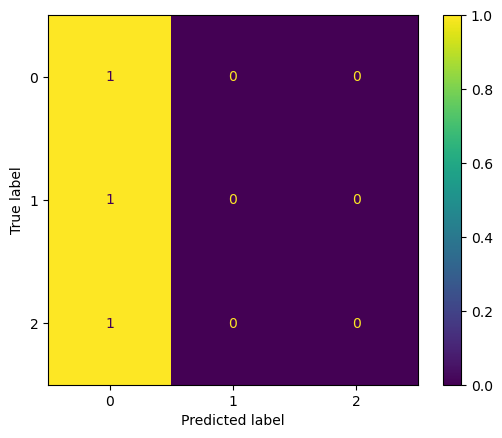

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.72704. Saving Model!
epoch 01, loss: 0.66268, acc: 0.78652, val_loss: 0.72704, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


[INFO] val_acc has been improved from 0.72704 to 0.72641. Saving Model!
epoch 02, loss: 0.66249, acc: 0.78652, val_loss: 0.72641, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


[INFO] val_acc has been improved from 0.72641 to 0.72575. Saving Model!
epoch 03, loss: 0.66199, acc: 0.78652, val_loss: 0.72575, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


[INFO] val_acc has been improved from 0.72575 to 0.72501. Saving Model!
epoch 04, loss: 0.66121, acc: 0.78652, val_loss: 0.72501, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


[INFO] val_acc has been improved from 0.72501 to 0.72433. Saving Model!
epoch 05, loss: 0.66019, acc: 0.78652, val_loss: 0.72433, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


[INFO] val_acc has been improved from 0.72433 to 0.72384. Saving Model!
epoch 06, loss: 0.65904, acc: 0.78652, val_loss: 0.72384, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


[INFO] val_acc has been improved from 0.72384 to 0.72352. Saving Model!
epoch 07, loss: 0.65785, acc: 0.78652, val_loss: 0.72352, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


[INFO] val_acc has been improved from 0.72352 to 0.72345. Saving Model!
epoch 08, loss: 0.65668, acc: 0.78652, val_loss: 0.72345, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


epoch 09, loss: 0.65555, acc: 0.78652, val_loss: 0.72353, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 10, loss: 0.65446, acc: 0.78652, val_loss: 0.72377, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 11, loss: 0.65338, acc: 0.78652, val_loss: 0.72411, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 12, loss: 0.65233, acc: 0.78652, val_loss: 0.72437, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 13, loss: 0.65131, acc: 0.78652, val_loss: 0.72455, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 14, loss: 0.65035, acc: 0.78652, val_loss: 0.72458, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 15, loss: 0.64943, acc: 0.78652, val_loss: 0.72446, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 16, loss: 0.64855, acc: 0.78652, val_loss: 0.72409, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


[INFO] val_acc has been improved from 0.72345 to 0.72341. Saving Model!
epoch 17, loss: 0.64767, acc: 0.78652, val_loss: 0.72341, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.32it/s]


[INFO] val_acc has been improved from 0.72341 to 0.72252. Saving Model!
epoch 18, loss: 0.64677, acc: 0.78652, val_loss: 0.72252, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


[INFO] val_acc has been improved from 0.72252 to 0.72138. Saving Model!
epoch 19, loss: 0.64586, acc: 0.78652, val_loss: 0.72138, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.94it/s]


[INFO] val_acc has been improved from 0.72138 to 0.72004. Saving Model!
epoch 20, loss: 0.64493, acc: 0.78652, val_loss: 0.72004, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


[INFO] val_acc has been improved from 0.72004 to 0.71857. Saving Model!
epoch 21, loss: 0.64402, acc: 0.78652, val_loss: 0.71857, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


[INFO] val_acc has been improved from 0.71857 to 0.71699. Saving Model!
epoch 22, loss: 0.64313, acc: 0.78652, val_loss: 0.71699, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.70it/s]


[INFO] val_acc has been improved from 0.71699 to 0.71538. Saving Model!
epoch 23, loss: 0.64226, acc: 0.78652, val_loss: 0.71538, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


[INFO] val_acc has been improved from 0.71538 to 0.71378. Saving Model!
epoch 24, loss: 0.64143, acc: 0.78652, val_loss: 0.71378, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.75it/s]


[INFO] val_acc has been improved from 0.71378 to 0.71220. Saving Model!
epoch 25, loss: 0.64062, acc: 0.78652, val_loss: 0.71220, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


[INFO] val_acc has been improved from 0.71220 to 0.71078. Saving Model!
epoch 26, loss: 0.63984, acc: 0.78652, val_loss: 0.71078, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


[INFO] val_acc has been improved from 0.71078 to 0.70947. Saving Model!
epoch 27, loss: 0.63910, acc: 0.78652, val_loss: 0.70947, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.30it/s]


[INFO] val_acc has been improved from 0.70947 to 0.70832. Saving Model!
epoch 28, loss: 0.63838, acc: 0.78652, val_loss: 0.70832, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


[INFO] val_acc has been improved from 0.70832 to 0.70740. Saving Model!
epoch 29, loss: 0.63770, acc: 0.78652, val_loss: 0.70740, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


[INFO] val_acc has been improved from 0.70740 to 0.70666. Saving Model!
epoch 30, loss: 0.63706, acc: 0.78652, val_loss: 0.70666, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


[INFO] val_acc has been improved from 0.70666 to 0.70617. Saving Model!
epoch 31, loss: 0.63643, acc: 0.78652, val_loss: 0.70617, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


[INFO] val_acc has been improved from 0.70617 to 0.70601. Saving Model!
epoch 32, loss: 0.63581, acc: 0.78652, val_loss: 0.70601, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.13it/s]


epoch 33, loss: 0.63521, acc: 0.78652, val_loss: 0.70608, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 34, loss: 0.63460, acc: 0.78652, val_loss: 0.70635, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 35, loss: 0.63400, acc: 0.78652, val_loss: 0.70691, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 36, loss: 0.63341, acc: 0.78652, val_loss: 0.70768, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 37, loss: 0.63283, acc: 0.78652, val_loss: 0.70864, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 38, loss: 0.63225, acc: 0.78652, val_loss: 0.70984, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.38it/s]


epoch 39, loss: 0.63167, acc: 0.78652, val_loss: 0.71119, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 40, loss: 0.63110, acc: 0.78652, val_loss: 0.71271, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 41, loss: 0.63053, acc: 0.78652, val_loss: 0.71439, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]


epoch 42, loss: 0.62997, acc: 0.78652, val_loss: 0.71609, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 43, loss: 0.62943, acc: 0.78652, val_loss: 0.71776, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 44, loss: 0.62890, acc: 0.78652, val_loss: 0.71929, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 45, loss: 0.62837, acc: 0.78652, val_loss: 0.72069, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 46, loss: 0.62785, acc: 0.78652, val_loss: 0.72198, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 47, loss: 0.62734, acc: 0.78652, val_loss: 0.72305, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 48, loss: 0.62682, acc: 0.78652, val_loss: 0.72402, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.27it/s]


epoch 49, loss: 0.62631, acc: 0.78652, val_loss: 0.72485, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 50, loss: 0.62580, acc: 0.78652, val_loss: 0.72548, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 51, loss: 0.62529, acc: 0.78652, val_loss: 0.72602, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 52, loss: 0.62476, acc: 0.78652, val_loss: 0.72645, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 53, loss: 0.62424, acc: 0.78652, val_loss: 0.72680, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.62it/s]


epoch 54, loss: 0.62373, acc: 0.78652, val_loss: 0.72728, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 55, loss: 0.62323, acc: 0.78652, val_loss: 0.72781, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 56, loss: 0.62274, acc: 0.78652, val_loss: 0.72845, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 57, loss: 0.62223, acc: 0.78652, val_loss: 0.72919, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 58, loss: 0.62174, acc: 0.78652, val_loss: 0.73002, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.92it/s]


epoch 59, loss: 0.62124, acc: 0.78652, val_loss: 0.73107, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 60, loss: 0.62073, acc: 0.78652, val_loss: 0.73239, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 61, loss: 0.62020, acc: 0.78652, val_loss: 0.73381, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 62, loss: 0.61968, acc: 0.78652, val_loss: 0.73539, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 63, loss: 0.61916, acc: 0.78652, val_loss: 0.73706, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 64, loss: 0.61863, acc: 0.78652, val_loss: 0.73876, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.29it/s]


epoch 65, loss: 0.61811, acc: 0.78652, val_loss: 0.74053, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 66, loss: 0.61757, acc: 0.78652, val_loss: 0.74235, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.33it/s]


epoch 67, loss: 0.61703, acc: 0.78652, val_loss: 0.74426, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 68, loss: 0.61648, acc: 0.78652, val_loss: 0.74620, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 69, loss: 0.61593, acc: 0.78652, val_loss: 0.74787, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 70, loss: 0.61538, acc: 0.78652, val_loss: 0.74943, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 71, loss: 0.61482, acc: 0.78652, val_loss: 0.75094, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 72, loss: 0.61424, acc: 0.78652, val_loss: 0.75242, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.33it/s]


epoch 73, loss: 0.61365, acc: 0.78652, val_loss: 0.75408, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 74, loss: 0.61305, acc: 0.78677, val_loss: 0.75607, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 75, loss: 0.61245, acc: 0.78942, val_loss: 0.75819, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 76, loss: 0.61185, acc: 0.78966, val_loss: 0.76042, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 77, loss: 0.61123, acc: 0.78942, val_loss: 0.76260, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 78, loss: 0.61060, acc: 0.78991, val_loss: 0.76479, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 79, loss: 0.60997, acc: 0.78942, val_loss: 0.76685, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 80, loss: 0.60934, acc: 0.78942, val_loss: 0.76881, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 81, loss: 0.60869, acc: 0.78870, val_loss: 0.77047, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 82, loss: 0.60801, acc: 0.78870, val_loss: 0.77272, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 83, loss: 0.60734, acc: 0.78870, val_loss: 0.77591, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 84, loss: 0.60667, acc: 0.78870, val_loss: 0.77971, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 85, loss: 0.60599, acc: 0.78870, val_loss: 0.78323, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 86, loss: 0.60527, acc: 0.78870, val_loss: 0.78612, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.99it/s]


epoch 87, loss: 0.60455, acc: 0.78870, val_loss: 0.78877, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 88, loss: 0.60383, acc: 0.78870, val_loss: 0.79103, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 89, loss: 0.60309, acc: 0.78870, val_loss: 0.79300, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 90, loss: 0.60231, acc: 0.78870, val_loss: 0.79504, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 91, loss: 0.60155, acc: 0.78870, val_loss: 0.79780, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 92, loss: 0.60073, acc: 0.78942, val_loss: 0.79995, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 93, loss: 0.59987, acc: 0.78918, val_loss: 0.80165, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 94, loss: 0.59901, acc: 0.78918, val_loss: 0.80369, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 95, loss: 0.59820, acc: 0.78918, val_loss: 0.80690, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 96, loss: 0.59739, acc: 0.78918, val_loss: 0.81109, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 97, loss: 0.59658, acc: 0.78918, val_loss: 0.81486, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.25it/s]


epoch 98, loss: 0.59577, acc: 0.78918, val_loss: 0.81825, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 99, loss: 0.59493, acc: 0.78918, val_loss: 0.82139, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.15it/s]


epoch 100, loss: 0.59407, acc: 0.78918, val_loss: 0.82512, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 101, loss: 0.59320, acc: 0.78942, val_loss: 0.82963, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 102, loss: 0.59233, acc: 0.78942, val_loss: 0.83416, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 103, loss: 0.59146, acc: 0.78942, val_loss: 0.83880, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.33it/s]


epoch 104, loss: 0.59057, acc: 0.78942, val_loss: 0.84203, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]

epoch 105, loss: 0.58966, acc: 0.78942, val_loss: 0.84466, val_accuracy: 0.78742

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 106, loss: 0.58875, acc: 0.78918, val_loss: 0.84799, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 107, loss: 0.58784, acc: 0.78918, val_loss: 0.85201, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 108, loss: 0.58689, acc: 0.78942, val_loss: 0.85629, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.64it/s]


epoch 109, loss: 0.58595, acc: 0.78942, val_loss: 0.85790, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 110, loss: 0.58498, acc: 0.78942, val_loss: 0.85934, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 111, loss: 0.58403, acc: 0.78942, val_loss: 0.86204, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 112, loss: 0.58305, acc: 0.78942, val_loss: 0.86589, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 113, loss: 0.58206, acc: 0.78942, val_loss: 0.87093, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 114, loss: 0.58109, acc: 0.78942, val_loss: 0.87383, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 115, loss: 0.58009, acc: 0.78942, val_loss: 0.87653, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 116, loss: 0.57908, acc: 0.79015, val_loss: 0.87772, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 117, loss: 0.57806, acc: 0.79015, val_loss: 0.88007, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 118, loss: 0.57700, acc: 0.79015, val_loss: 0.88447, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 119, loss: 0.57596, acc: 0.79111, val_loss: 0.88909, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 120, loss: 0.57493, acc: 0.79111, val_loss: 0.88917, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 121, loss: 0.57388, acc: 0.79111, val_loss: 0.88885, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 122, loss: 0.57284, acc: 0.79111, val_loss: 0.89249, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 123, loss: 0.57180, acc: 0.79135, val_loss: 0.89726, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 124, loss: 0.57072, acc: 0.79135, val_loss: 0.89940, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.54it/s]


epoch 125, loss: 0.56964, acc: 0.79135, val_loss: 0.90021, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 126, loss: 0.56857, acc: 0.79160, val_loss: 0.90442, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 127, loss: 0.56749, acc: 0.79160, val_loss: 0.91044, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 128, loss: 0.56641, acc: 0.79160, val_loss: 0.91473, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.17it/s]


epoch 129, loss: 0.56530, acc: 0.79160, val_loss: 0.91519, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 130, loss: 0.56425, acc: 0.79160, val_loss: 0.91479, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 131, loss: 0.56316, acc: 0.79160, val_loss: 0.91881, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 132, loss: 0.56207, acc: 0.79232, val_loss: 0.92782, val_accuracy: 0.79176


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 133, loss: 0.56097, acc: 0.79256, val_loss: 0.93479, val_accuracy: 0.79176


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 134, loss: 0.55985, acc: 0.79377, val_loss: 0.93722, val_accuracy: 0.79176


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 135, loss: 0.55873, acc: 0.79377, val_loss: 0.93874, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 136, loss: 0.55762, acc: 0.79401, val_loss: 0.94383, val_accuracy: 0.79176


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 137, loss: 0.55647, acc: 0.79425, val_loss: 0.95257, val_accuracy: 0.79176


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


epoch 138, loss: 0.55542, acc: 0.79498, val_loss: 0.95896, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 139, loss: 0.55427, acc: 0.79498, val_loss: 0.96363, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 140, loss: 0.55312, acc: 0.79522, val_loss: 0.96750, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 141, loss: 0.55203, acc: 0.79618, val_loss: 0.97302, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 142, loss: 0.55090, acc: 0.79498, val_loss: 0.97980, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 143, loss: 0.54976, acc: 0.79522, val_loss: 0.98433, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 144, loss: 0.54864, acc: 0.79522, val_loss: 0.98729, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]


epoch 145, loss: 0.54747, acc: 0.79643, val_loss: 0.99277, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 146, loss: 0.54633, acc: 0.79667, val_loss: 0.99802, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 147, loss: 0.54522, acc: 0.79691, val_loss: 0.99795, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 148, loss: 0.54414, acc: 0.79667, val_loss: 1.00673, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 149, loss: 0.54302, acc: 0.79763, val_loss: 1.01436, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 150, loss: 0.54186, acc: 0.79787, val_loss: 1.01789, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 151, loss: 0.54079, acc: 0.79884, val_loss: 1.02542, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 152, loss: 0.53968, acc: 0.79908, val_loss: 1.02938, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 153, loss: 0.53857, acc: 0.80029, val_loss: 1.03399, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.21it/s]


epoch 154, loss: 0.53752, acc: 0.79908, val_loss: 1.04393, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 155, loss: 0.53650, acc: 0.79884, val_loss: 1.04324, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 156, loss: 0.53544, acc: 0.80029, val_loss: 1.05472, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 157, loss: 0.53435, acc: 0.79957, val_loss: 1.05333, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 158, loss: 0.53322, acc: 0.79957, val_loss: 1.06770, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 159, loss: 0.53210, acc: 0.79957, val_loss: 1.08107, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 160, loss: 0.53114, acc: 0.80029, val_loss: 1.08095, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 161, loss: 0.53005, acc: 0.80029, val_loss: 1.08320, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 162, loss: 0.52902, acc: 0.80101, val_loss: 1.09268, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 163, loss: 0.52803, acc: 0.80150, val_loss: 1.09957, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 164, loss: 0.52704, acc: 0.80222, val_loss: 1.11555, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 165, loss: 0.52599, acc: 0.80150, val_loss: 1.11624, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 166, loss: 0.52507, acc: 0.80246, val_loss: 1.13075, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 167, loss: 0.52419, acc: 0.80126, val_loss: 1.11934, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 168, loss: 0.52344, acc: 0.80440, val_loss: 1.14247, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]


epoch 169, loss: 0.52274, acc: 0.80150, val_loss: 1.12866, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 170, loss: 0.52163, acc: 0.80464, val_loss: 1.15191, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 171, loss: 0.52038, acc: 0.80319, val_loss: 1.15304, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 172, loss: 0.51931, acc: 0.80464, val_loss: 1.15067, val_accuracy: 0.79176


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 173, loss: 0.51855, acc: 0.80488, val_loss: 1.16719, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 174, loss: 0.51801, acc: 0.80464, val_loss: 1.15385, val_accuracy: 0.79176


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 175, loss: 0.51726, acc: 0.80584, val_loss: 1.18315, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 176, loss: 0.51635, acc: 0.80391, val_loss: 1.17484, val_accuracy: 0.79176


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]


epoch 177, loss: 0.51511, acc: 0.80440, val_loss: 1.18683, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 178, loss: 0.51407, acc: 0.80440, val_loss: 1.19573, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 179, loss: 0.51328, acc: 0.80512, val_loss: 1.18339, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 180, loss: 0.51263, acc: 0.80536, val_loss: 1.20048, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 181, loss: 0.51169, acc: 0.80560, val_loss: 1.20501, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 182, loss: 0.51070, acc: 0.80584, val_loss: 1.21957, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 183, loss: 0.50988, acc: 0.80633, val_loss: 1.22513, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 184, loss: 0.50906, acc: 0.80657, val_loss: 1.21936, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


epoch 185, loss: 0.50838, acc: 0.80657, val_loss: 1.24120, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 186, loss: 0.50775, acc: 0.80729, val_loss: 1.22724, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 187, loss: 0.50718, acc: 0.80681, val_loss: 1.25753, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 188, loss: 0.50667, acc: 0.80705, val_loss: 1.24078, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 189, loss: 0.50580, acc: 0.80657, val_loss: 1.27044, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 190, loss: 0.50465, acc: 0.80681, val_loss: 1.26170, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 191, loss: 0.50353, acc: 0.80633, val_loss: 1.26735, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 192, loss: 0.50256, acc: 0.80681, val_loss: 1.27552, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 193, loss: 0.50198, acc: 0.80778, val_loss: 1.27913, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 194, loss: 0.50178, acc: 0.80778, val_loss: 1.31635, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 195, loss: 0.50183, acc: 0.80657, val_loss: 1.28407, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 196, loss: 0.50117, acc: 0.80826, val_loss: 1.31324, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 197, loss: 0.49974, acc: 0.80705, val_loss: 1.30485, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 198, loss: 0.49814, acc: 0.80850, val_loss: 1.31309, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 199, loss: 0.49750, acc: 0.80850, val_loss: 1.33291, val_accuracy: 0.78742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 200, loss: 0.49735, acc: 0.80778, val_loss: 1.31113, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]

epoch 201, loss: 0.49688, acc: 0.80826, val_loss: 1.34603, val_accuracy: 0.78525

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 202, loss: 0.49572, acc: 0.80850, val_loss: 1.34098, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 203, loss: 0.49431, acc: 0.80922, val_loss: 1.34521, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 204, loss: 0.49353, acc: 0.80971, val_loss: 1.35807, val_accuracy: 0.78525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 205, loss: 0.49325, acc: 0.80850, val_loss: 1.34642, val_accuracy: 0.77874


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 206, loss: 0.49316, acc: 0.80995, val_loss: 1.38973, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 207, loss: 0.49271, acc: 0.80874, val_loss: 1.37504, val_accuracy: 0.77657


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 208, loss: 0.49138, acc: 0.81043, val_loss: 1.38816, val_accuracy: 0.78091


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 209, loss: 0.49000, acc: 0.80802, val_loss: 1.39474, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 210, loss: 0.48936, acc: 0.80850, val_loss: 1.38984, val_accuracy: 0.77657


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 211, loss: 0.48911, acc: 0.81140, val_loss: 1.41854, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 212, loss: 0.48869, acc: 0.80850, val_loss: 1.40212, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 213, loss: 0.48801, acc: 0.81212, val_loss: 1.42274, val_accuracy: 0.77874


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 214, loss: 0.48704, acc: 0.80922, val_loss: 1.41564, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 215, loss: 0.48586, acc: 0.81043, val_loss: 1.42823, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 216, loss: 0.48509, acc: 0.80995, val_loss: 1.43839, val_accuracy: 0.77874


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


epoch 217, loss: 0.48473, acc: 0.80826, val_loss: 1.42069, val_accuracy: 0.77223


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 218, loss: 0.48459, acc: 0.81647, val_loss: 1.45507, val_accuracy: 0.77874


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 219, loss: 0.48443, acc: 0.80947, val_loss: 1.44099, val_accuracy: 0.77007


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 220, loss: 0.48371, acc: 0.81502, val_loss: 1.46568, val_accuracy: 0.77874


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 221, loss: 0.48252, acc: 0.80898, val_loss: 1.44776, val_accuracy: 0.77007


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 222, loss: 0.48126, acc: 0.81478, val_loss: 1.45940, val_accuracy: 0.77223


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89it/s]


epoch 223, loss: 0.48038, acc: 0.81188, val_loss: 1.47736, val_accuracy: 0.77223


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 224, loss: 0.47996, acc: 0.81116, val_loss: 1.47422, val_accuracy: 0.76573


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]


epoch 225, loss: 0.47979, acc: 0.81526, val_loss: 1.49432, val_accuracy: 0.77007


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 226, loss: 0.47961, acc: 0.81092, val_loss: 1.47630, val_accuracy: 0.76139


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 227, loss: 0.47934, acc: 0.81647, val_loss: 1.51025, val_accuracy: 0.77007


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 228, loss: 0.47872, acc: 0.81116, val_loss: 1.49622, val_accuracy: 0.76139


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 229, loss: 0.47749, acc: 0.81671, val_loss: 1.51144, val_accuracy: 0.76790


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 230, loss: 0.47623, acc: 0.81309, val_loss: 1.50829, val_accuracy: 0.76790


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]


epoch 231, loss: 0.47538, acc: 0.81599, val_loss: 1.51134, val_accuracy: 0.76139


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 232, loss: 0.47499, acc: 0.81647, val_loss: 1.53508, val_accuracy: 0.77007


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 233, loss: 0.47484, acc: 0.81550, val_loss: 1.52008, val_accuracy: 0.75488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]

epoch 234, loss: 0.47472, acc: 0.81840, val_loss: 1.54925, val_accuracy: 0.77007

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 235, loss: 0.47459, acc: 0.81502, val_loss: 1.52987, val_accuracy: 0.75488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 236, loss: 0.47399, acc: 0.81816, val_loss: 1.55941, val_accuracy: 0.76356


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 237, loss: 0.47293, acc: 0.81526, val_loss: 1.54779, val_accuracy: 0.75488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 238, loss: 0.47167, acc: 0.81864, val_loss: 1.55966, val_accuracy: 0.75271


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 239, loss: 0.47061, acc: 0.81599, val_loss: 1.56392, val_accuracy: 0.75271


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 240, loss: 0.46998, acc: 0.81574, val_loss: 1.56235, val_accuracy: 0.75271


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 241, loss: 0.46981, acc: 0.81888, val_loss: 1.58844, val_accuracy: 0.75488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 242, loss: 0.46973, acc: 0.81695, val_loss: 1.57525, val_accuracy: 0.74837


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 243, loss: 0.46965, acc: 0.81792, val_loss: 1.60654, val_accuracy: 0.75488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 244, loss: 0.46959, acc: 0.81792, val_loss: 1.58510, val_accuracy: 0.74620


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 245, loss: 0.46903, acc: 0.81985, val_loss: 1.61226, val_accuracy: 0.75488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 246, loss: 0.46803, acc: 0.81623, val_loss: 1.59461, val_accuracy: 0.75054


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 247, loss: 0.46653, acc: 0.82057, val_loss: 1.60859, val_accuracy: 0.75054


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 248, loss: 0.46539, acc: 0.81888, val_loss: 1.61487, val_accuracy: 0.75054


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 249, loss: 0.46495, acc: 0.81768, val_loss: 1.60699, val_accuracy: 0.74620


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]


epoch 250, loss: 0.46486, acc: 0.82057, val_loss: 1.63237, val_accuracy: 0.75488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.39it/s]


epoch 251, loss: 0.46490, acc: 0.81985, val_loss: 1.62123, val_accuracy: 0.73970


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 252, loss: 0.46505, acc: 0.82106, val_loss: 1.65087, val_accuracy: 0.75488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 253, loss: 0.46496, acc: 0.81913, val_loss: 1.62988, val_accuracy: 0.73970


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 254, loss: 0.46397, acc: 0.82106, val_loss: 1.66153, val_accuracy: 0.75054


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 255, loss: 0.46245, acc: 0.81985, val_loss: 1.65614, val_accuracy: 0.74837


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 256, loss: 0.46107, acc: 0.82154, val_loss: 1.65302, val_accuracy: 0.74620


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


epoch 257, loss: 0.46052, acc: 0.82130, val_loss: 1.66463, val_accuracy: 0.75054


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 258, loss: 0.46069, acc: 0.82057, val_loss: 1.65643, val_accuracy: 0.73970


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.95it/s]


epoch 259, loss: 0.46117, acc: 0.82106, val_loss: 1.69096, val_accuracy: 0.75271


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 260, loss: 0.46181, acc: 0.82106, val_loss: 1.66217, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 261, loss: 0.46121, acc: 0.82202, val_loss: 1.69074, val_accuracy: 0.75271


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 262, loss: 0.45967, acc: 0.82106, val_loss: 1.68016, val_accuracy: 0.74187


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 263, loss: 0.45768, acc: 0.82347, val_loss: 1.69129, val_accuracy: 0.73970


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 264, loss: 0.45697, acc: 0.82347, val_loss: 1.70683, val_accuracy: 0.74837


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]


epoch 265, loss: 0.45742, acc: 0.82082, val_loss: 1.69020, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 266, loss: 0.45773, acc: 0.82130, val_loss: 1.72132, val_accuracy: 0.75054


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 267, loss: 0.45742, acc: 0.82202, val_loss: 1.70831, val_accuracy: 0.73536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 268, loss: 0.45627, acc: 0.82347, val_loss: 1.72488, val_accuracy: 0.74837


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 269, loss: 0.45484, acc: 0.82130, val_loss: 1.72226, val_accuracy: 0.74403


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 270, loss: 0.45386, acc: 0.82323, val_loss: 1.72473, val_accuracy: 0.73970


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 271, loss: 0.45362, acc: 0.82347, val_loss: 1.74180, val_accuracy: 0.74620


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 272, loss: 0.45377, acc: 0.82299, val_loss: 1.72815, val_accuracy: 0.72668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 273, loss: 0.45399, acc: 0.82347, val_loss: 1.75071, val_accuracy: 0.75054


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 274, loss: 0.45385, acc: 0.82371, val_loss: 1.73813, val_accuracy: 0.71150


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 275, loss: 0.45321, acc: 0.82347, val_loss: 1.76575, val_accuracy: 0.74620


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.89it/s]


epoch 276, loss: 0.45239, acc: 0.82299, val_loss: 1.75199, val_accuracy: 0.72668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 277, loss: 0.45110, acc: 0.82492, val_loss: 1.75954, val_accuracy: 0.73970


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 278, loss: 0.45010, acc: 0.82347, val_loss: 1.75997, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 279, loss: 0.44951, acc: 0.82275, val_loss: 1.76481, val_accuracy: 0.72885


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 280, loss: 0.44918, acc: 0.82444, val_loss: 1.78272, val_accuracy: 0.74403


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]


epoch 281, loss: 0.44915, acc: 0.82323, val_loss: 1.77312, val_accuracy: 0.71150


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 282, loss: 0.44936, acc: 0.82444, val_loss: 1.79838, val_accuracy: 0.74837


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 283, loss: 0.45005, acc: 0.82468, val_loss: 1.78648, val_accuracy: 0.70065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 284, loss: 0.45052, acc: 0.82540, val_loss: 1.82164, val_accuracy: 0.74837


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 285, loss: 0.45088, acc: 0.82444, val_loss: 1.79650, val_accuracy: 0.69848


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 286, loss: 0.44948, acc: 0.82830, val_loss: 1.82168, val_accuracy: 0.74620


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 287, loss: 0.44754, acc: 0.82468, val_loss: 1.81054, val_accuracy: 0.71150


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 288, loss: 0.44559, acc: 0.82854, val_loss: 1.81233, val_accuracy: 0.72668


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 289, loss: 0.44502, acc: 0.82758, val_loss: 1.82513, val_accuracy: 0.73970


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 290, loss: 0.44541, acc: 0.82468, val_loss: 1.81264, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 291, loss: 0.44589, acc: 0.82879, val_loss: 1.84607, val_accuracy: 0.74620


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 292, loss: 0.44588, acc: 0.82589, val_loss: 1.83188, val_accuracy: 0.69414


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 293, loss: 0.44480, acc: 0.82999, val_loss: 1.84902, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 294, loss: 0.44344, acc: 0.82540, val_loss: 1.84368, val_accuracy: 0.70716


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 295, loss: 0.44236, acc: 0.82758, val_loss: 1.85430, val_accuracy: 0.71150


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.30it/s]


epoch 296, loss: 0.44176, acc: 0.82709, val_loss: 1.86657, val_accuracy: 0.71150


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.25it/s]


epoch 297, loss: 0.44148, acc: 0.82709, val_loss: 1.86329, val_accuracy: 0.69414


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 298, loss: 0.44139, acc: 0.82951, val_loss: 1.87337, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 299, loss: 0.44164, acc: 0.82734, val_loss: 1.86276, val_accuracy: 0.69197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 300, loss: 0.44223, acc: 0.82951, val_loss: 1.89963, val_accuracy: 0.74403


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 301, loss: 0.44315, acc: 0.82637, val_loss: 1.87705, val_accuracy: 0.65727


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 302, loss: 0.44286, acc: 0.83217, val_loss: 1.89940, val_accuracy: 0.74403


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 303, loss: 0.44209, acc: 0.82685, val_loss: 1.87973, val_accuracy: 0.69414


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 304, loss: 0.44004, acc: 0.83120, val_loss: 1.89876, val_accuracy: 0.70282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 305, loss: 0.43823, acc: 0.82685, val_loss: 1.90123, val_accuracy: 0.70065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 306, loss: 0.43748, acc: 0.82927, val_loss: 1.89738, val_accuracy: 0.69414


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 307, loss: 0.43773, acc: 0.83048, val_loss: 1.91960, val_accuracy: 0.72234


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 308, loss: 0.43832, acc: 0.82734, val_loss: 1.90295, val_accuracy: 0.64642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 309, loss: 0.43840, acc: 0.83506, val_loss: 1.92346, val_accuracy: 0.73319


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 310, loss: 0.43812, acc: 0.82758, val_loss: 1.90361, val_accuracy: 0.65727


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.39it/s]


epoch 311, loss: 0.43667, acc: 0.83482, val_loss: 1.91861, val_accuracy: 0.70065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 312, loss: 0.43534, acc: 0.82854, val_loss: 1.92064, val_accuracy: 0.70065


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 313, loss: 0.43442, acc: 0.82951, val_loss: 1.92707, val_accuracy: 0.66377


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 314, loss: 0.43410, acc: 0.83168, val_loss: 1.93703, val_accuracy: 0.71584


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 315, loss: 0.43419, acc: 0.82854, val_loss: 1.92715, val_accuracy: 0.65076


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.17it/s]


epoch 316, loss: 0.43455, acc: 0.83579, val_loss: 1.94654, val_accuracy: 0.72451


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 317, loss: 0.43547, acc: 0.82830, val_loss: 1.93921, val_accuracy: 0.64425


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 318, loss: 0.43611, acc: 0.83724, val_loss: 1.97026, val_accuracy: 0.74187


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 319, loss: 0.43655, acc: 0.82782, val_loss: 1.95069, val_accuracy: 0.64425


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 320, loss: 0.43490, acc: 0.83579, val_loss: 1.96250, val_accuracy: 0.72017


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 321, loss: 0.43285, acc: 0.82951, val_loss: 1.95606, val_accuracy: 0.65076


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 322, loss: 0.43113, acc: 0.83289, val_loss: 1.96998, val_accuracy: 0.66377


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 323, loss: 0.43029, acc: 0.83265, val_loss: 1.97927, val_accuracy: 0.66377


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 324, loss: 0.43021, acc: 0.83120, val_loss: 1.96455, val_accuracy: 0.64859


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 325, loss: 0.43048, acc: 0.83748, val_loss: 1.98421, val_accuracy: 0.67028


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 326, loss: 0.43085, acc: 0.83168, val_loss: 1.97327, val_accuracy: 0.64642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 327, loss: 0.43066, acc: 0.83893, val_loss: 1.99624, val_accuracy: 0.67028


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]


epoch 328, loss: 0.43022, acc: 0.83144, val_loss: 1.98175, val_accuracy: 0.64642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 329, loss: 0.42905, acc: 0.83893, val_loss: 2.00035, val_accuracy: 0.67028


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.29it/s]


epoch 330, loss: 0.42795, acc: 0.83168, val_loss: 1.99624, val_accuracy: 0.64859


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 331, loss: 0.42704, acc: 0.83651, val_loss: 2.00405, val_accuracy: 0.65293


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 332, loss: 0.42641, acc: 0.83313, val_loss: 2.00656, val_accuracy: 0.65510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 333, loss: 0.42606, acc: 0.83192, val_loss: 2.00299, val_accuracy: 0.64859


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 334, loss: 0.42595, acc: 0.83796, val_loss: 2.01278, val_accuracy: 0.66377


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 335, loss: 0.42620, acc: 0.83168, val_loss: 2.01858, val_accuracy: 0.64425


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 336, loss: 0.42687, acc: 0.84134, val_loss: 2.04681, val_accuracy: 0.67245


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


epoch 337, loss: 0.42903, acc: 0.83168, val_loss: 2.02600, val_accuracy: 0.62907


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 338, loss: 0.43066, acc: 0.84207, val_loss: 2.04990, val_accuracy: 0.69631


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 339, loss: 0.43258, acc: 0.82734, val_loss: 2.03069, val_accuracy: 0.63557


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 340, loss: 0.42888, acc: 0.84183, val_loss: 2.04983, val_accuracy: 0.66377


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 341, loss: 0.42489, acc: 0.83265, val_loss: 2.04333, val_accuracy: 0.65293


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 342, loss: 0.42262, acc: 0.83579, val_loss: 2.03704, val_accuracy: 0.64425


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 343, loss: 0.42382, acc: 0.84086, val_loss: 2.06539, val_accuracy: 0.67245


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.13it/s]


epoch 344, loss: 0.42612, acc: 0.83313, val_loss: 2.05665, val_accuracy: 0.62907


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 345, loss: 0.42580, acc: 0.84352, val_loss: 2.07095, val_accuracy: 0.66377


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]

epoch 346, loss: 0.42410, acc: 0.83458, val_loss: 2.04953, val_accuracy: 0.64642

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 347, loss: 0.42128, acc: 0.84158, val_loss: 2.06167, val_accuracy: 0.64642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 348, loss: 0.42040, acc: 0.83989, val_loss: 2.08146, val_accuracy: 0.65293


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 349, loss: 0.42146, acc: 0.83603, val_loss: 2.06891, val_accuracy: 0.63557


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 350, loss: 0.42245, acc: 0.84424, val_loss: 2.08782, val_accuracy: 0.66594


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 351, loss: 0.42273, acc: 0.83386, val_loss: 2.08080, val_accuracy: 0.63774


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 352, loss: 0.42080, acc: 0.84521, val_loss: 2.10017, val_accuracy: 0.64859


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.49it/s]


epoch 353, loss: 0.41904, acc: 0.83820, val_loss: 2.08906, val_accuracy: 0.64642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 354, loss: 0.41809, acc: 0.84158, val_loss: 2.07931, val_accuracy: 0.64642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 355, loss: 0.41824, acc: 0.84327, val_loss: 2.10089, val_accuracy: 0.65293


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 356, loss: 0.41914, acc: 0.83627, val_loss: 2.10395, val_accuracy: 0.63557


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.28it/s]


epoch 357, loss: 0.41936, acc: 0.84690, val_loss: 2.12545, val_accuracy: 0.65727


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.54it/s]


epoch 358, loss: 0.41920, acc: 0.83651, val_loss: 2.10914, val_accuracy: 0.63774


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 359, loss: 0.41767, acc: 0.84617, val_loss: 2.11685, val_accuracy: 0.64642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 360, loss: 0.41635, acc: 0.84086, val_loss: 2.11611, val_accuracy: 0.64642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 361, loss: 0.41551, acc: 0.84352, val_loss: 2.11667, val_accuracy: 0.64642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 362, loss: 0.41536, acc: 0.84303, val_loss: 2.13719, val_accuracy: 0.64642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 363, loss: 0.41563, acc: 0.83869, val_loss: 2.13721, val_accuracy: 0.63557


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 364, loss: 0.41605, acc: 0.84738, val_loss: 2.15133, val_accuracy: 0.64859


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 365, loss: 0.41646, acc: 0.83917, val_loss: 2.14094, val_accuracy: 0.62473


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 366, loss: 0.41640, acc: 0.84786, val_loss: 2.15910, val_accuracy: 0.64859


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 367, loss: 0.41609, acc: 0.83796, val_loss: 2.15102, val_accuracy: 0.62690


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.24it/s]


epoch 368, loss: 0.41516, acc: 0.84835, val_loss: 2.15901, val_accuracy: 0.64859


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]

epoch 369, loss: 0.41403, acc: 0.84110, val_loss: 2.15073, val_accuracy: 0.63991

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 370, loss: 0.41274, acc: 0.84448, val_loss: 2.16950, val_accuracy: 0.64642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 371, loss: 0.41200, acc: 0.84376, val_loss: 2.18200, val_accuracy: 0.64642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 372, loss: 0.41181, acc: 0.84279, val_loss: 2.17373, val_accuracy: 0.63557


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 373, loss: 0.41198, acc: 0.84569, val_loss: 2.18597, val_accuracy: 0.64642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 374, loss: 0.41258, acc: 0.84134, val_loss: 2.18763, val_accuracy: 0.61171


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 375, loss: 0.41311, acc: 0.84883, val_loss: 2.20529, val_accuracy: 0.64859


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 376, loss: 0.41407, acc: 0.83796, val_loss: 2.19273, val_accuracy: 0.60738


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


epoch 377, loss: 0.41347, acc: 0.84883, val_loss: 2.20852, val_accuracy: 0.64859


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 378, loss: 0.41299, acc: 0.84014, val_loss: 2.20330, val_accuracy: 0.61822


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 379, loss: 0.41100, acc: 0.84955, val_loss: 2.21599, val_accuracy: 0.64642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 380, loss: 0.40955, acc: 0.84279, val_loss: 2.21295, val_accuracy: 0.63557


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 381, loss: 0.40862, acc: 0.84545, val_loss: 2.21496, val_accuracy: 0.63557


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 382, loss: 0.40839, acc: 0.84545, val_loss: 2.23363, val_accuracy: 0.64642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 383, loss: 0.40869, acc: 0.84303, val_loss: 2.23303, val_accuracy: 0.60738


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 384, loss: 0.40930, acc: 0.84955, val_loss: 2.24492, val_accuracy: 0.64642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 385, loss: 0.41086, acc: 0.83941, val_loss: 2.24423, val_accuracy: 0.42082


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 386, loss: 0.41237, acc: 0.84979, val_loss: 2.26688, val_accuracy: 0.65944


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 387, loss: 0.41477, acc: 0.83555, val_loss: 2.25081, val_accuracy: 0.42299


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 388, loss: 0.41248, acc: 0.85052, val_loss: 2.25877, val_accuracy: 0.65293


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 389, loss: 0.40999, acc: 0.84038, val_loss: 2.25024, val_accuracy: 0.61388


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 390, loss: 0.40648, acc: 0.84835, val_loss: 2.26456, val_accuracy: 0.62039


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 391, loss: 0.40545, acc: 0.84714, val_loss: 2.27410, val_accuracy: 0.64642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 392, loss: 0.40675, acc: 0.84448, val_loss: 2.26223, val_accuracy: 0.47072


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 393, loss: 0.40846, acc: 0.85197, val_loss: 2.28422, val_accuracy: 0.65076


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 394, loss: 0.41005, acc: 0.83989, val_loss: 2.28507, val_accuracy: 0.41649


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 395, loss: 0.40793, acc: 0.85245, val_loss: 2.28811, val_accuracy: 0.64642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 396, loss: 0.40558, acc: 0.84400, val_loss: 2.27852, val_accuracy: 0.62256


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 397, loss: 0.40355, acc: 0.84810, val_loss: 2.28373, val_accuracy: 0.62039


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 398, loss: 0.40327, acc: 0.84762, val_loss: 2.30174, val_accuracy: 0.64642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 399, loss: 0.40444, acc: 0.84400, val_loss: 2.30728, val_accuracy: 0.42299


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 400, loss: 0.40558, acc: 0.85342, val_loss: 2.31924, val_accuracy: 0.65076


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 401, loss: 0.40665, acc: 0.84231, val_loss: 2.30991, val_accuracy: 0.42299


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 402, loss: 0.40504, acc: 0.85366, val_loss: 2.31914, val_accuracy: 0.64642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 403, loss: 0.40337, acc: 0.84521, val_loss: 2.31698, val_accuracy: 0.47939


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 404, loss: 0.40145, acc: 0.85149, val_loss: 2.32312, val_accuracy: 0.62473


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 405, loss: 0.40077, acc: 0.84859, val_loss: 2.33020, val_accuracy: 0.63774


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 406, loss: 0.40119, acc: 0.84545, val_loss: 2.33478, val_accuracy: 0.42299


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 407, loss: 0.40206, acc: 0.85293, val_loss: 2.34149, val_accuracy: 0.65076


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 408, loss: 0.40331, acc: 0.84521, val_loss: 2.34572, val_accuracy: 0.41649


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]


epoch 409, loss: 0.40325, acc: 0.85414, val_loss: 2.36091, val_accuracy: 0.65076


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 410, loss: 0.40312, acc: 0.84496, val_loss: 2.35707, val_accuracy: 0.42299


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 411, loss: 0.40094, acc: 0.85293, val_loss: 2.35252, val_accuracy: 0.63557


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 412, loss: 0.39916, acc: 0.84786, val_loss: 2.35140, val_accuracy: 0.49024


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 413, loss: 0.39818, acc: 0.85028, val_loss: 2.36313, val_accuracy: 0.42299


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 414, loss: 0.39813, acc: 0.85100, val_loss: 2.38014, val_accuracy: 0.63557


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 415, loss: 0.39888, acc: 0.84593, val_loss: 2.38707, val_accuracy: 0.41866


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 416, loss: 0.39958, acc: 0.85366, val_loss: 2.39730, val_accuracy: 0.64208


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


epoch 417, loss: 0.40058, acc: 0.84496, val_loss: 2.38874, val_accuracy: 0.41649


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 418, loss: 0.40017, acc: 0.85559, val_loss: 2.38798, val_accuracy: 0.64425


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 419, loss: 0.39973, acc: 0.84521, val_loss: 2.40027, val_accuracy: 0.42082


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 420, loss: 0.39796, acc: 0.85390, val_loss: 2.40228, val_accuracy: 0.59870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 421, loss: 0.39641, acc: 0.84690, val_loss: 2.40058, val_accuracy: 0.42299


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 422, loss: 0.39535, acc: 0.85028, val_loss: 2.40965, val_accuracy: 0.42299


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.74it/s]


epoch 423, loss: 0.39502, acc: 0.85052, val_loss: 2.42300, val_accuracy: 0.49458


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 424, loss: 0.39526, acc: 0.84786, val_loss: 2.42872, val_accuracy: 0.42299


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


epoch 425, loss: 0.39592, acc: 0.85269, val_loss: 2.43174, val_accuracy: 0.64208


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 426, loss: 0.39712, acc: 0.84424, val_loss: 2.43754, val_accuracy: 0.41649


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 427, loss: 0.39773, acc: 0.85487, val_loss: 2.44270, val_accuracy: 0.64425


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 428, loss: 0.39897, acc: 0.84641, val_loss: 2.44394, val_accuracy: 0.41215


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 429, loss: 0.39777, acc: 0.85366, val_loss: 2.43673, val_accuracy: 0.64208


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 430, loss: 0.39658, acc: 0.84545, val_loss: 2.44283, val_accuracy: 0.42082


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 431, loss: 0.39432, acc: 0.85535, val_loss: 2.45102, val_accuracy: 0.45119


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 432, loss: 0.39274, acc: 0.85028, val_loss: 2.45439, val_accuracy: 0.42299


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.26it/s]


epoch 433, loss: 0.39183, acc: 0.85004, val_loss: 2.45567, val_accuracy: 0.42299


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 434, loss: 0.39186, acc: 0.85342, val_loss: 2.46140, val_accuracy: 0.45553


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 435, loss: 0.39253, acc: 0.84714, val_loss: 2.47321, val_accuracy: 0.41649


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 436, loss: 0.39353, acc: 0.85656, val_loss: 2.47333, val_accuracy: 0.60521


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 437, loss: 0.39514, acc: 0.84617, val_loss: 2.48880, val_accuracy: 0.40564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 438, loss: 0.39530, acc: 0.85728, val_loss: 2.49442, val_accuracy: 0.50759


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 439, loss: 0.39589, acc: 0.84714, val_loss: 2.50546, val_accuracy: 0.40564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 440, loss: 0.39383, acc: 0.85680, val_loss: 2.48885, val_accuracy: 0.45770


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 441, loss: 0.39185, acc: 0.84810, val_loss: 2.49073, val_accuracy: 0.42082


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]


epoch 442, loss: 0.38978, acc: 0.85511, val_loss: 2.49382, val_accuracy: 0.42299


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 443, loss: 0.38885, acc: 0.85221, val_loss: 2.50033, val_accuracy: 0.42950


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 444, loss: 0.38901, acc: 0.85076, val_loss: 2.50972, val_accuracy: 0.41432


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 445, loss: 0.38986, acc: 0.85680, val_loss: 2.50772, val_accuracy: 0.45987


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 446, loss: 0.39152, acc: 0.84859, val_loss: 2.52603, val_accuracy: 0.40781


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 447, loss: 0.39261, acc: 0.85825, val_loss: 2.53641, val_accuracy: 0.50759


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 448, loss: 0.39443, acc: 0.84690, val_loss: 2.55284, val_accuracy: 0.40564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]


epoch 449, loss: 0.39327, acc: 0.85728, val_loss: 2.53265, val_accuracy: 0.45987


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 450, loss: 0.39220, acc: 0.84835, val_loss: 2.53950, val_accuracy: 0.41215


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 451, loss: 0.38879, acc: 0.85704, val_loss: 2.54072, val_accuracy: 0.42299


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 452, loss: 0.38670, acc: 0.85245, val_loss: 2.54052, val_accuracy: 0.42299


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.80it/s]


epoch 453, loss: 0.38612, acc: 0.85318, val_loss: 2.53804, val_accuracy: 0.42082


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 454, loss: 0.38685, acc: 0.85825, val_loss: 2.54770, val_accuracy: 0.45119


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 455, loss: 0.38826, acc: 0.84810, val_loss: 2.57304, val_accuracy: 0.40781


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 456, loss: 0.38878, acc: 0.85849, val_loss: 2.56768, val_accuracy: 0.45553


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.21it/s]


epoch 457, loss: 0.38939, acc: 0.84883, val_loss: 2.58617, val_accuracy: 0.40564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 458, loss: 0.38788, acc: 0.85897, val_loss: 2.57693, val_accuracy: 0.44035


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 459, loss: 0.38647, acc: 0.85004, val_loss: 2.58280, val_accuracy: 0.41432


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 460, loss: 0.38471, acc: 0.85752, val_loss: 2.58296, val_accuracy: 0.42082


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 461, loss: 0.38369, acc: 0.85583, val_loss: 2.58601, val_accuracy: 0.42299


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]

epoch 462, loss: 0.38345, acc: 0.85462, val_loss: 2.59654, val_accuracy: 0.41432

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 463, loss: 0.38387, acc: 0.85897, val_loss: 2.59218, val_accuracy: 0.43384


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 464, loss: 0.38491, acc: 0.85149, val_loss: 2.61038, val_accuracy: 0.40564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.26it/s]


epoch 465, loss: 0.38562, acc: 0.85970, val_loss: 2.60993, val_accuracy: 0.44469


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 466, loss: 0.38682, acc: 0.84979, val_loss: 2.61855, val_accuracy: 0.40347


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 467, loss: 0.38648, acc: 0.85921, val_loss: 2.59346, val_accuracy: 0.44902


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 468, loss: 0.38639, acc: 0.84979, val_loss: 2.61447, val_accuracy: 0.40781


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 469, loss: 0.38432, acc: 0.85945, val_loss: 2.62502, val_accuracy: 0.43167


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 470, loss: 0.38279, acc: 0.85318, val_loss: 2.63435, val_accuracy: 0.41432


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 471, loss: 0.38122, acc: 0.85849, val_loss: 2.61760, val_accuracy: 0.41649


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 472, loss: 0.38057, acc: 0.85656, val_loss: 2.62635, val_accuracy: 0.42082


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.29it/s]


epoch 473, loss: 0.38070, acc: 0.85631, val_loss: 2.64803, val_accuracy: 0.41215


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 474, loss: 0.38116, acc: 0.85849, val_loss: 2.64088, val_accuracy: 0.43601


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 475, loss: 0.38207, acc: 0.85293, val_loss: 2.64532, val_accuracy: 0.40130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 476, loss: 0.38267, acc: 0.86018, val_loss: 2.64096, val_accuracy: 0.44469


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 477, loss: 0.38390, acc: 0.85149, val_loss: 2.67068, val_accuracy: 0.39479


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 478, loss: 0.38342, acc: 0.85921, val_loss: 2.65002, val_accuracy: 0.44252


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 479, loss: 0.38352, acc: 0.85076, val_loss: 2.67172, val_accuracy: 0.39696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 480, loss: 0.38186, acc: 0.85921, val_loss: 2.66898, val_accuracy: 0.43384


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 481, loss: 0.38080, acc: 0.85414, val_loss: 2.67910, val_accuracy: 0.40347


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.21it/s]


epoch 482, loss: 0.37905, acc: 0.86042, val_loss: 2.66986, val_accuracy: 0.41649


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 483, loss: 0.37788, acc: 0.85776, val_loss: 2.67489, val_accuracy: 0.41866


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 484, loss: 0.37728, acc: 0.85921, val_loss: 2.69104, val_accuracy: 0.40781


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]

epoch 485, loss: 0.37743, acc: 0.85801, val_loss: 2.68580, val_accuracy: 0.42082

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 486, loss: 0.37804, acc: 0.85462, val_loss: 2.69604, val_accuracy: 0.39696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 487, loss: 0.37895, acc: 0.86018, val_loss: 2.68813, val_accuracy: 0.43384


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 488, loss: 0.38059, acc: 0.85173, val_loss: 2.72000, val_accuracy: 0.39046


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 489, loss: 0.38104, acc: 0.85994, val_loss: 2.68997, val_accuracy: 0.44469


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 490, loss: 0.38232, acc: 0.84955, val_loss: 2.70505, val_accuracy: 0.39479


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 491, loss: 0.38084, acc: 0.85994, val_loss: 2.70176, val_accuracy: 0.43384


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 492, loss: 0.37988, acc: 0.85318, val_loss: 2.72675, val_accuracy: 0.39479


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 493, loss: 0.37708, acc: 0.86066, val_loss: 2.69345, val_accuracy: 0.41866


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 494, loss: 0.37515, acc: 0.85801, val_loss: 2.69562, val_accuracy: 0.41649


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 495, loss: 0.37441, acc: 0.85897, val_loss: 2.73909, val_accuracy: 0.40347


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 496, loss: 0.37484, acc: 0.85970, val_loss: 2.74174, val_accuracy: 0.42299


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 497, loss: 0.37618, acc: 0.85438, val_loss: 2.74470, val_accuracy: 0.38829


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.13it/s]


epoch 498, loss: 0.37735, acc: 0.86066, val_loss: 2.73013, val_accuracy: 0.43384


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 499, loss: 0.37934, acc: 0.85173, val_loss: 2.77042, val_accuracy: 0.38178


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 500, loss: 0.37907, acc: 0.86090, val_loss: 2.73631, val_accuracy: 0.43601
1번째 교차검증
evaluation loss: 0.70601, evaluation accuracy: 0.78742
(5, 461)
(461, 5)
Learning rate set to 0.055422
0:	learn: 1.0505989	total: 9.27ms	remaining: 9.27s
1:	learn: 1.0090110	total: 15.7ms	remaining: 7.86s
2:	learn: 0.9727079	total: 22.2ms	remaining: 7.39s
3:	learn: 0.9408177	total: 28.6ms	remaining: 7.12s
4:	learn: 0.9126580	total: 34.8ms	remaining: 6.92s
5:	learn: 0.8876849	total: 41.7ms	remaining: 6.91s
6:	learn: 0.8654567	total: 47.7ms	remaining: 6.76s
7:	learn: 0.8456109	total: 53.7ms	remaining: 6.66s
8:	learn: 0.8278455	total: 60.2ms	remaining: 6.62s
9:	learn: 0.8119069	total: 66.9ms	remaining: 6.63s
10:	learn: 0.7975795	total: 73.8ms	remaining: 6.64s
11:	learn: 0.7846791	total: 79.8ms	remaining: 6.57s
12:	learn: 0.7730469	total: 87ms	remaining: 6.61s
13:	learn: 0.7625451	total: 93ms	remaining: 6.55s
14:	learn: 0.7530539	total: 99.4ms	remaining: 6.53s
15:	learn: 0.7444676	total: 108ms	remaini

170:	learn: 0.6559925	total: 1.03s	remaining: 4.99s
171:	learn: 0.6559792	total: 1.04s	remaining: 5s
172:	learn: 0.6559661	total: 1.04s	remaining: 4.99s
173:	learn: 0.6559532	total: 1.05s	remaining: 4.99s
174:	learn: 0.6559403	total: 1.06s	remaining: 4.99s
175:	learn: 0.6559278	total: 1.07s	remaining: 5s
176:	learn: 0.6559154	total: 1.07s	remaining: 4.99s
177:	learn: 0.6559031	total: 1.08s	remaining: 4.99s
178:	learn: 0.6558909	total: 1.09s	remaining: 4.98s
179:	learn: 0.6558789	total: 1.09s	remaining: 4.98s
180:	learn: 0.6558671	total: 1.1s	remaining: 4.98s
181:	learn: 0.6558554	total: 1.11s	remaining: 4.97s
182:	learn: 0.6558439	total: 1.11s	remaining: 4.97s
183:	learn: 0.6558324	total: 1.12s	remaining: 4.97s
184:	learn: 0.6558212	total: 1.13s	remaining: 4.97s
185:	learn: 0.6558100	total: 1.13s	remaining: 4.96s
186:	learn: 0.6557990	total: 1.14s	remaining: 4.97s
187:	learn: 0.6557882	total: 1.15s	remaining: 4.96s
188:	learn: 0.6557774	total: 1.16s	remaining: 4.96s
189:	learn: 0.65576

347:	learn: 0.6549051	total: 2.25s	remaining: 4.22s
348:	learn: 0.6549024	total: 2.26s	remaining: 4.21s
349:	learn: 0.6548996	total: 2.26s	remaining: 4.21s
350:	learn: 0.6548968	total: 2.27s	remaining: 4.2s
351:	learn: 0.6548942	total: 2.28s	remaining: 4.19s
352:	learn: 0.6548915	total: 2.28s	remaining: 4.18s
353:	learn: 0.6548888	total: 2.29s	remaining: 4.18s
354:	learn: 0.6548860	total: 2.3s	remaining: 4.17s
355:	learn: 0.6548834	total: 2.3s	remaining: 4.17s
356:	learn: 0.6548807	total: 2.31s	remaining: 4.16s
357:	learn: 0.6548781	total: 2.32s	remaining: 4.16s
358:	learn: 0.6548755	total: 2.33s	remaining: 4.15s
359:	learn: 0.6548729	total: 2.33s	remaining: 4.15s
360:	learn: 0.6548704	total: 2.34s	remaining: 4.14s
361:	learn: 0.6548678	total: 2.35s	remaining: 4.14s
362:	learn: 0.6548652	total: 2.35s	remaining: 4.13s
363:	learn: 0.6548627	total: 2.36s	remaining: 4.12s
364:	learn: 0.6548602	total: 2.37s	remaining: 4.12s
365:	learn: 0.6548576	total: 2.38s	remaining: 4.12s
366:	learn: 0.6

510:	learn: 0.6546055	total: 3.5s	remaining: 3.35s
511:	learn: 0.6546043	total: 3.51s	remaining: 3.35s
512:	learn: 0.6546031	total: 3.52s	remaining: 3.34s
513:	learn: 0.6546019	total: 3.53s	remaining: 3.34s
514:	learn: 0.6546007	total: 3.54s	remaining: 3.33s
515:	learn: 0.6545995	total: 3.55s	remaining: 3.33s
516:	learn: 0.6545983	total: 3.56s	remaining: 3.32s
517:	learn: 0.6545972	total: 3.56s	remaining: 3.32s
518:	learn: 0.6545960	total: 3.57s	remaining: 3.31s
519:	learn: 0.6545948	total: 3.58s	remaining: 3.31s
520:	learn: 0.6545937	total: 3.59s	remaining: 3.3s
521:	learn: 0.6545925	total: 3.6s	remaining: 3.3s
522:	learn: 0.6545914	total: 3.61s	remaining: 3.29s
523:	learn: 0.6545903	total: 3.62s	remaining: 3.29s
524:	learn: 0.6545891	total: 3.63s	remaining: 3.28s
525:	learn: 0.6545880	total: 3.63s	remaining: 3.28s
526:	learn: 0.6545868	total: 3.64s	remaining: 3.27s
527:	learn: 0.6545857	total: 3.65s	remaining: 3.26s
528:	learn: 0.6545846	total: 3.66s	remaining: 3.26s
529:	learn: 0.65

678:	learn: 0.6544563	total: 4.95s	remaining: 2.34s
679:	learn: 0.6544556	total: 4.96s	remaining: 2.33s
680:	learn: 0.6544550	total: 4.97s	remaining: 2.33s
681:	learn: 0.6544543	total: 4.97s	remaining: 2.32s
682:	learn: 0.6544536	total: 4.98s	remaining: 2.31s
683:	learn: 0.6544530	total: 4.99s	remaining: 2.31s
684:	learn: 0.6544523	total: 5s	remaining: 2.3s
685:	learn: 0.6544517	total: 5.01s	remaining: 2.29s
686:	learn: 0.6544511	total: 5.02s	remaining: 2.29s
687:	learn: 0.6544505	total: 5.02s	remaining: 2.28s
688:	learn: 0.6544498	total: 5.03s	remaining: 2.27s
689:	learn: 0.6544492	total: 5.04s	remaining: 2.26s
690:	learn: 0.6544485	total: 5.05s	remaining: 2.26s
691:	learn: 0.6544479	total: 5.05s	remaining: 2.25s
692:	learn: 0.6544473	total: 5.06s	remaining: 2.24s
693:	learn: 0.6544466	total: 5.07s	remaining: 2.23s
694:	learn: 0.6544460	total: 5.08s	remaining: 2.23s
695:	learn: 0.6544454	total: 5.08s	remaining: 2.22s
696:	learn: 0.6544448	total: 5.09s	remaining: 2.21s
697:	learn: 0.65

855:	learn: 0.6543661	total: 6.39s	remaining: 1.07s
856:	learn: 0.6543657	total: 6.4s	remaining: 1.07s
857:	learn: 0.6543653	total: 6.41s	remaining: 1.06s
858:	learn: 0.6543649	total: 6.42s	remaining: 1.05s
859:	learn: 0.6543645	total: 6.43s	remaining: 1.05s
860:	learn: 0.6543641	total: 6.44s	remaining: 1.04s
861:	learn: 0.6543637	total: 6.45s	remaining: 1.03s
862:	learn: 0.6543633	total: 6.45s	remaining: 1.02s
863:	learn: 0.6543629	total: 6.46s	remaining: 1.02s
864:	learn: 0.6543625	total: 6.47s	remaining: 1.01s
865:	learn: 0.6543621	total: 6.48s	remaining: 1s
866:	learn: 0.6543617	total: 6.48s	remaining: 995ms
867:	learn: 0.6543614	total: 6.49s	remaining: 987ms
868:	learn: 0.6543610	total: 6.5s	remaining: 980ms
869:	learn: 0.6543606	total: 6.51s	remaining: 972ms
870:	learn: 0.6543602	total: 6.51s	remaining: 965ms
871:	learn: 0.6543598	total: 6.53s	remaining: 958ms
872:	learn: 0.6543595	total: 6.54s	remaining: 951ms
873:	learn: 0.6543591	total: 6.54s	remaining: 943ms
874:	learn: 0.654

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


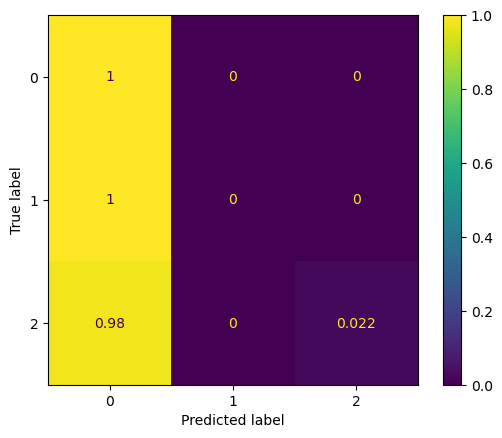

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.66139. Saving Model!
epoch 01, loss: 0.64033, acc: 0.78682, val_loss: 0.66139, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 02, loss: 0.64011, acc: 0.78682, val_loss: 0.66359, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 03, loss: 0.63969, acc: 0.78682, val_loss: 0.66631, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]

epoch 04, loss: 0.63892, acc: 0.78682, val_loss: 0.66948, val_accuracy: 0.78478

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 05, loss: 0.63775, acc: 0.78682, val_loss: 0.67319, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 06, loss: 0.63633, acc: 0.78682, val_loss: 0.67767, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 07, loss: 0.63485, acc: 0.78682, val_loss: 0.68302, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 08, loss: 0.63351, acc: 0.78682, val_loss: 0.68917, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 09, loss: 0.63238, acc: 0.78682, val_loss: 0.69585, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 10, loss: 0.63140, acc: 0.78682, val_loss: 0.70275, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 11, loss: 0.63048, acc: 0.78682, val_loss: 0.70967, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


epoch 12, loss: 0.62956, acc: 0.78682, val_loss: 0.71645, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.39it/s]


epoch 13, loss: 0.62865, acc: 0.78682, val_loss: 0.72299, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 14, loss: 0.62777, acc: 0.78682, val_loss: 0.72943, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 15, loss: 0.62698, acc: 0.78682, val_loss: 0.73579, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 16, loss: 0.62629, acc: 0.78682, val_loss: 0.74210, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 17, loss: 0.62568, acc: 0.78682, val_loss: 0.74851, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 18, loss: 0.62508, acc: 0.78682, val_loss: 0.75483, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 19, loss: 0.62447, acc: 0.78682, val_loss: 0.76108, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 20, loss: 0.62382, acc: 0.78682, val_loss: 0.76727, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 21, loss: 0.62313, acc: 0.78682, val_loss: 0.77338, val_accuracy: 0.78261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 22, loss: 0.62245, acc: 0.78682, val_loss: 0.77947, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 23, loss: 0.62179, acc: 0.78730, val_loss: 0.78547, val_accuracy: 0.76304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 24, loss: 0.62116, acc: 0.78754, val_loss: 0.79133, val_accuracy: 0.76087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]

epoch 25, loss: 0.62054, acc: 0.78803, val_loss: 0.79716, val_accuracy: 0.75217

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 26, loss: 0.61991, acc: 0.78754, val_loss: 0.80266, val_accuracy: 0.74130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 27, loss: 0.61928, acc: 0.78803, val_loss: 0.80780, val_accuracy: 0.73696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 28, loss: 0.61863, acc: 0.78851, val_loss: 0.81253, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]


epoch 29, loss: 0.61798, acc: 0.78875, val_loss: 0.81679, val_accuracy: 0.71957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 30, loss: 0.61735, acc: 0.78875, val_loss: 0.82121, val_accuracy: 0.71522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 31, loss: 0.61674, acc: 0.78923, val_loss: 0.82595, val_accuracy: 0.71304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 32, loss: 0.61613, acc: 0.78947, val_loss: 0.83035, val_accuracy: 0.71304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 33, loss: 0.61553, acc: 0.78947, val_loss: 0.83446, val_accuracy: 0.71087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 34, loss: 0.61493, acc: 0.78947, val_loss: 0.83845, val_accuracy: 0.70870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 35, loss: 0.61431, acc: 0.79044, val_loss: 0.84258, val_accuracy: 0.70435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


epoch 36, loss: 0.61369, acc: 0.79044, val_loss: 0.84655, val_accuracy: 0.70435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 37, loss: 0.61307, acc: 0.79044, val_loss: 0.85114, val_accuracy: 0.69565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.28it/s]


epoch 38, loss: 0.61244, acc: 0.79068, val_loss: 0.85562, val_accuracy: 0.69783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 39, loss: 0.61185, acc: 0.79068, val_loss: 0.86043, val_accuracy: 0.69783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 40, loss: 0.61124, acc: 0.79044, val_loss: 0.86531, val_accuracy: 0.69783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 41, loss: 0.61064, acc: 0.79044, val_loss: 0.87029, val_accuracy: 0.69348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 42, loss: 0.61007, acc: 0.79044, val_loss: 0.87548, val_accuracy: 0.69348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 43, loss: 0.60948, acc: 0.79068, val_loss: 0.87929, val_accuracy: 0.69565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 44, loss: 0.60890, acc: 0.79044, val_loss: 0.88318, val_accuracy: 0.68696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


epoch 45, loss: 0.60832, acc: 0.79068, val_loss: 0.88675, val_accuracy: 0.69348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 46, loss: 0.60777, acc: 0.79092, val_loss: 0.89141, val_accuracy: 0.69348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 47, loss: 0.60721, acc: 0.79116, val_loss: 0.89769, val_accuracy: 0.69130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 48, loss: 0.60663, acc: 0.79165, val_loss: 0.90516, val_accuracy: 0.69130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 49, loss: 0.60605, acc: 0.79141, val_loss: 0.91320, val_accuracy: 0.68261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 50, loss: 0.60545, acc: 0.79092, val_loss: 0.92167, val_accuracy: 0.68261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 51, loss: 0.60483, acc: 0.79116, val_loss: 0.93037, val_accuracy: 0.68261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]


epoch 52, loss: 0.60421, acc: 0.79141, val_loss: 0.93871, val_accuracy: 0.68261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 53, loss: 0.60358, acc: 0.79141, val_loss: 0.94574, val_accuracy: 0.68261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 54, loss: 0.60292, acc: 0.79165, val_loss: 0.95245, val_accuracy: 0.68261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.66it/s]


epoch 55, loss: 0.60227, acc: 0.79165, val_loss: 0.95854, val_accuracy: 0.68261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 56, loss: 0.60159, acc: 0.79189, val_loss: 0.96511, val_accuracy: 0.68261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.56it/s]


epoch 57, loss: 0.60090, acc: 0.79165, val_loss: 0.97204, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 58, loss: 0.60018, acc: 0.79165, val_loss: 0.97873, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 59, loss: 0.59943, acc: 0.79165, val_loss: 0.98466, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.45it/s]


epoch 60, loss: 0.59871, acc: 0.79165, val_loss: 0.98888, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 61, loss: 0.59794, acc: 0.79213, val_loss: 0.99304, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 62, loss: 0.59715, acc: 0.79213, val_loss: 0.99869, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 63, loss: 0.59635, acc: 0.79189, val_loss: 1.00703, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 64, loss: 0.59551, acc: 0.79261, val_loss: 1.01798, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 65, loss: 0.59467, acc: 0.79503, val_loss: 1.02876, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 66, loss: 0.59386, acc: 0.79527, val_loss: 1.03784, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 67, loss: 0.59303, acc: 0.79454, val_loss: 1.04493, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.40it/s]


epoch 68, loss: 0.59219, acc: 0.79454, val_loss: 1.05183, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 69, loss: 0.59139, acc: 0.79454, val_loss: 1.06127, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 70, loss: 0.59058, acc: 0.79454, val_loss: 1.07222, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 71, loss: 0.58978, acc: 0.79479, val_loss: 1.08249, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 72, loss: 0.58897, acc: 0.79575, val_loss: 1.09049, val_accuracy: 0.67609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 73, loss: 0.58816, acc: 0.79648, val_loss: 1.09690, val_accuracy: 0.67609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 74, loss: 0.58736, acc: 0.79672, val_loss: 1.10642, val_accuracy: 0.67609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]

epoch 75, loss: 0.58654, acc: 0.79720, val_loss: 1.11885, val_accuracy: 0.67391

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]


epoch 76, loss: 0.58572, acc: 0.79792, val_loss: 1.12909, val_accuracy: 0.67391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 77, loss: 0.58491, acc: 0.79792, val_loss: 1.13654, val_accuracy: 0.67391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 78, loss: 0.58410, acc: 0.79792, val_loss: 1.13995, val_accuracy: 0.67391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]


epoch 79, loss: 0.58324, acc: 0.79792, val_loss: 1.14470, val_accuracy: 0.67391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]

epoch 80, loss: 0.58236, acc: 0.79768, val_loss: 1.15643, val_accuracy: 0.67391

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 81, loss: 0.58146, acc: 0.79744, val_loss: 1.17753, val_accuracy: 0.67391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 82, loss: 0.58051, acc: 0.79720, val_loss: 1.20382, val_accuracy: 0.65435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 83, loss: 0.57953, acc: 0.79768, val_loss: 1.22331, val_accuracy: 0.64565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 84, loss: 0.57861, acc: 0.79913, val_loss: 1.23291, val_accuracy: 0.63043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]


epoch 85, loss: 0.57764, acc: 0.79913, val_loss: 1.24515, val_accuracy: 0.63043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 86, loss: 0.57661, acc: 0.79961, val_loss: 1.26386, val_accuracy: 0.63043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 87, loss: 0.57567, acc: 0.79961, val_loss: 1.27994, val_accuracy: 0.63043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 88, loss: 0.57485, acc: 0.80010, val_loss: 1.28859, val_accuracy: 0.63043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 89, loss: 0.57391, acc: 0.80010, val_loss: 1.28972, val_accuracy: 0.63043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 90, loss: 0.57293, acc: 0.79986, val_loss: 1.29211, val_accuracy: 0.63043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 91, loss: 0.57206, acc: 0.79961, val_loss: 1.30515, val_accuracy: 0.63043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 92, loss: 0.57116, acc: 0.80010, val_loss: 1.33032, val_accuracy: 0.63043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 93, loss: 0.57023, acc: 0.79937, val_loss: 1.34837, val_accuracy: 0.63043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 94, loss: 0.56936, acc: 0.79889, val_loss: 1.34987, val_accuracy: 0.63043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 95, loss: 0.56839, acc: 0.79913, val_loss: 1.35166, val_accuracy: 0.63043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 96, loss: 0.56741, acc: 0.79986, val_loss: 1.36229, val_accuracy: 0.62826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 97, loss: 0.56644, acc: 0.80034, val_loss: 1.37988, val_accuracy: 0.61957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 98, loss: 0.56547, acc: 0.80034, val_loss: 1.38767, val_accuracy: 0.61957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 99, loss: 0.56443, acc: 0.80010, val_loss: 1.39232, val_accuracy: 0.61957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 100, loss: 0.56347, acc: 0.79986, val_loss: 1.41895, val_accuracy: 0.61522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 101, loss: 0.56248, acc: 0.79961, val_loss: 1.43563, val_accuracy: 0.61304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 102, loss: 0.56158, acc: 0.79986, val_loss: 1.44667, val_accuracy: 0.61087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 103, loss: 0.56061, acc: 0.80034, val_loss: 1.44481, val_accuracy: 0.61087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 104, loss: 0.55962, acc: 0.80034, val_loss: 1.44860, val_accuracy: 0.61087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 105, loss: 0.55864, acc: 0.80010, val_loss: 1.47776, val_accuracy: 0.42826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 106, loss: 0.55774, acc: 0.80058, val_loss: 1.48603, val_accuracy: 0.42826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


epoch 107, loss: 0.55683, acc: 0.80082, val_loss: 1.48214, val_accuracy: 0.42826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.17it/s]


epoch 108, loss: 0.55576, acc: 0.80082, val_loss: 1.49371, val_accuracy: 0.42609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 109, loss: 0.55481, acc: 0.80082, val_loss: 1.54363, val_accuracy: 0.41087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 110, loss: 0.55392, acc: 0.80058, val_loss: 1.55011, val_accuracy: 0.41087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 111, loss: 0.55289, acc: 0.80058, val_loss: 1.53032, val_accuracy: 0.42391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 112, loss: 0.55222, acc: 0.80130, val_loss: 1.55669, val_accuracy: 0.41087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]

epoch 113, loss: 0.55097, acc: 0.80130, val_loss: 1.58978, val_accuracy: 0.39783

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 114, loss: 0.55018, acc: 0.80179, val_loss: 1.58685, val_accuracy: 0.39783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 115, loss: 0.54926, acc: 0.80203, val_loss: 1.58040, val_accuracy: 0.40000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 116, loss: 0.54836, acc: 0.80179, val_loss: 1.59648, val_accuracy: 0.39783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 117, loss: 0.54740, acc: 0.80227, val_loss: 1.63211, val_accuracy: 0.39565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 118, loss: 0.54646, acc: 0.80348, val_loss: 1.63034, val_accuracy: 0.39565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 119, loss: 0.54551, acc: 0.80348, val_loss: 1.63040, val_accuracy: 0.39565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 120, loss: 0.54461, acc: 0.80444, val_loss: 1.64060, val_accuracy: 0.39565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 121, loss: 0.54373, acc: 0.80493, val_loss: 1.66576, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 122, loss: 0.54284, acc: 0.80565, val_loss: 1.67575, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 123, loss: 0.54187, acc: 0.80565, val_loss: 1.68626, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 124, loss: 0.54106, acc: 0.80589, val_loss: 1.73141, val_accuracy: 0.33261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]

epoch 125, loss: 0.54024, acc: 0.80565, val_loss: 1.71851, val_accuracy: 0.37174

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 126, loss: 0.53919, acc: 0.80613, val_loss: 1.69502, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 127, loss: 0.53858, acc: 0.80613, val_loss: 1.75333, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 128, loss: 0.53749, acc: 0.80613, val_loss: 1.77639, val_accuracy: 0.31087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 129, loss: 0.53667, acc: 0.80613, val_loss: 1.75037, val_accuracy: 0.32826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 130, loss: 0.53591, acc: 0.80686, val_loss: 1.76369, val_accuracy: 0.33043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 131, loss: 0.53499, acc: 0.80686, val_loss: 1.83060, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.13it/s]


epoch 132, loss: 0.53442, acc: 0.80662, val_loss: 1.80353, val_accuracy: 0.30870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 133, loss: 0.53320, acc: 0.80637, val_loss: 1.76133, val_accuracy: 0.32609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 134, loss: 0.53287, acc: 0.80662, val_loss: 1.84758, val_accuracy: 0.29565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 135, loss: 0.53148, acc: 0.81144, val_loss: 1.88711, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 136, loss: 0.53097, acc: 0.81072, val_loss: 1.82793, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 137, loss: 0.53002, acc: 0.80662, val_loss: 1.84523, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 138, loss: 0.52914, acc: 0.80662, val_loss: 1.91520, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 139, loss: 0.52853, acc: 0.81120, val_loss: 1.90019, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 140, loss: 0.52739, acc: 0.81096, val_loss: 1.86913, val_accuracy: 0.29565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


epoch 141, loss: 0.52692, acc: 0.80637, val_loss: 1.94120, val_accuracy: 0.27174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 142, loss: 0.52591, acc: 0.81217, val_loss: 1.94324, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 143, loss: 0.52506, acc: 0.81241, val_loss: 1.88645, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 144, loss: 0.52466, acc: 0.80662, val_loss: 1.94426, val_accuracy: 0.28261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 145, loss: 0.52358, acc: 0.81144, val_loss: 1.98480, val_accuracy: 0.26957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 146, loss: 0.52322, acc: 0.81313, val_loss: 1.92683, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


epoch 147, loss: 0.52224, acc: 0.81120, val_loss: 1.94119, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


epoch 148, loss: 0.52156, acc: 0.81144, val_loss: 2.03340, val_accuracy: 0.26522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 149, loss: 0.52114, acc: 0.81338, val_loss: 1.97929, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 150, loss: 0.51988, acc: 0.81265, val_loss: 1.92874, val_accuracy: 0.28696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 151, loss: 0.51958, acc: 0.81048, val_loss: 2.00859, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 152, loss: 0.51845, acc: 0.81362, val_loss: 2.04562, val_accuracy: 0.25870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 153, loss: 0.51786, acc: 0.81338, val_loss: 1.99036, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 154, loss: 0.51724, acc: 0.81120, val_loss: 2.02612, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 155, loss: 0.51622, acc: 0.81265, val_loss: 2.04756, val_accuracy: 0.26522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]


epoch 156, loss: 0.51558, acc: 0.81313, val_loss: 2.02004, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 157, loss: 0.51478, acc: 0.81265, val_loss: 2.03127, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 158, loss: 0.51407, acc: 0.81289, val_loss: 2.06864, val_accuracy: 0.26522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 159, loss: 0.51335, acc: 0.81217, val_loss: 2.06474, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 160, loss: 0.51259, acc: 0.81362, val_loss: 2.00636, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 161, loss: 0.51207, acc: 0.81169, val_loss: 2.05201, val_accuracy: 0.27609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 162, loss: 0.51109, acc: 0.81362, val_loss: 2.10502, val_accuracy: 0.26304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]

epoch 163, loss: 0.51047, acc: 0.81362, val_loss: 2.05410, val_accuracy: 0.26957

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 164, loss: 0.50994, acc: 0.81289, val_loss: 2.09827, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.33it/s]


epoch 165, loss: 0.50882, acc: 0.81241, val_loss: 2.10847, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 166, loss: 0.50818, acc: 0.81289, val_loss: 2.05162, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 167, loss: 0.50760, acc: 0.81338, val_loss: 2.11205, val_accuracy: 0.26522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 168, loss: 0.50661, acc: 0.81313, val_loss: 2.12012, val_accuracy: 0.26522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 169, loss: 0.50597, acc: 0.81410, val_loss: 2.08703, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 170, loss: 0.50522, acc: 0.81338, val_loss: 2.12879, val_accuracy: 0.26087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 171, loss: 0.50475, acc: 0.81482, val_loss: 2.09665, val_accuracy: 0.27391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]


epoch 172, loss: 0.50391, acc: 0.81362, val_loss: 2.12765, val_accuracy: 0.27391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 173, loss: 0.50303, acc: 0.81313, val_loss: 2.16451, val_accuracy: 0.25870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 174, loss: 0.50252, acc: 0.81289, val_loss: 2.13581, val_accuracy: 0.27391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 175, loss: 0.50166, acc: 0.81338, val_loss: 2.13968, val_accuracy: 0.27174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 176, loss: 0.50100, acc: 0.81434, val_loss: 2.13938, val_accuracy: 0.27391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 177, loss: 0.50031, acc: 0.81410, val_loss: 2.15277, val_accuracy: 0.27391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 178, loss: 0.49960, acc: 0.81338, val_loss: 2.19507, val_accuracy: 0.25870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 179, loss: 0.49900, acc: 0.81434, val_loss: 2.16567, val_accuracy: 0.27391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 180, loss: 0.49822, acc: 0.81507, val_loss: 2.16596, val_accuracy: 0.26304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.37it/s]


epoch 181, loss: 0.49759, acc: 0.81555, val_loss: 2.21518, val_accuracy: 0.25870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 182, loss: 0.49700, acc: 0.81603, val_loss: 2.17882, val_accuracy: 0.27391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 183, loss: 0.49635, acc: 0.81555, val_loss: 2.22868, val_accuracy: 0.25870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 184, loss: 0.49564, acc: 0.81555, val_loss: 2.20973, val_accuracy: 0.25870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 185, loss: 0.49490, acc: 0.81579, val_loss: 2.19337, val_accuracy: 0.26304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 186, loss: 0.49437, acc: 0.81627, val_loss: 2.26599, val_accuracy: 0.25652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 187, loss: 0.49379, acc: 0.81724, val_loss: 2.22182, val_accuracy: 0.25652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 188, loss: 0.49301, acc: 0.81555, val_loss: 2.23455, val_accuracy: 0.25652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 189, loss: 0.49241, acc: 0.81651, val_loss: 2.25852, val_accuracy: 0.25870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


epoch 190, loss: 0.49179, acc: 0.81651, val_loss: 2.23701, val_accuracy: 0.25870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 191, loss: 0.49115, acc: 0.81651, val_loss: 2.30145, val_accuracy: 0.25652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 192, loss: 0.49054, acc: 0.81627, val_loss: 2.27247, val_accuracy: 0.25870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 193, loss: 0.48986, acc: 0.81555, val_loss: 2.28290, val_accuracy: 0.25870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 194, loss: 0.48921, acc: 0.81772, val_loss: 2.27662, val_accuracy: 0.25870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 195, loss: 0.48864, acc: 0.81700, val_loss: 2.27136, val_accuracy: 0.25870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.17it/s]


epoch 196, loss: 0.48792, acc: 0.81748, val_loss: 2.32387, val_accuracy: 0.25652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 197, loss: 0.48731, acc: 0.81845, val_loss: 2.31481, val_accuracy: 0.25652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.49it/s]


epoch 198, loss: 0.48663, acc: 0.81772, val_loss: 2.31000, val_accuracy: 0.25652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 199, loss: 0.48589, acc: 0.81917, val_loss: 2.33103, val_accuracy: 0.25652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 200, loss: 0.48526, acc: 0.81893, val_loss: 2.30552, val_accuracy: 0.25652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 201, loss: 0.48456, acc: 0.81941, val_loss: 2.35408, val_accuracy: 0.24565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 202, loss: 0.48376, acc: 0.82183, val_loss: 2.34046, val_accuracy: 0.25652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 203, loss: 0.48296, acc: 0.82038, val_loss: 2.32266, val_accuracy: 0.25652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.26it/s]


epoch 204, loss: 0.48220, acc: 0.81989, val_loss: 2.34758, val_accuracy: 0.25652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 205, loss: 0.48149, acc: 0.82110, val_loss: 2.32310, val_accuracy: 0.25652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 206, loss: 0.48068, acc: 0.81941, val_loss: 2.36701, val_accuracy: 0.25000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 207, loss: 0.47986, acc: 0.82207, val_loss: 2.35664, val_accuracy: 0.25435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 208, loss: 0.47906, acc: 0.81941, val_loss: 2.38016, val_accuracy: 0.25000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 209, loss: 0.47824, acc: 0.82062, val_loss: 2.37857, val_accuracy: 0.24565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 210, loss: 0.47742, acc: 0.81989, val_loss: 2.37607, val_accuracy: 0.24783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 211, loss: 0.47664, acc: 0.82038, val_loss: 2.41451, val_accuracy: 0.24130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 212, loss: 0.47587, acc: 0.81989, val_loss: 2.40906, val_accuracy: 0.23696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 213, loss: 0.47517, acc: 0.82110, val_loss: 2.47646, val_accuracy: 0.21739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 214, loss: 0.47446, acc: 0.81941, val_loss: 2.41467, val_accuracy: 0.23696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 215, loss: 0.47369, acc: 0.82183, val_loss: 2.48657, val_accuracy: 0.22174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 216, loss: 0.47297, acc: 0.82327, val_loss: 2.41640, val_accuracy: 0.24348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 217, loss: 0.47232, acc: 0.82158, val_loss: 2.54039, val_accuracy: 0.21522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 218, loss: 0.47176, acc: 0.82448, val_loss: 2.42625, val_accuracy: 0.23913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 219, loss: 0.47132, acc: 0.82231, val_loss: 2.60231, val_accuracy: 0.21304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 220, loss: 0.47125, acc: 0.82376, val_loss: 2.38215, val_accuracy: 0.25435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 221, loss: 0.47135, acc: 0.82207, val_loss: 2.63336, val_accuracy: 0.21304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.99it/s]


epoch 222, loss: 0.47040, acc: 0.82545, val_loss: 2.42330, val_accuracy: 0.24130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 223, loss: 0.46918, acc: 0.82207, val_loss: 2.57822, val_accuracy: 0.21522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


epoch 224, loss: 0.46767, acc: 0.82545, val_loss: 2.51075, val_accuracy: 0.21739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 225, loss: 0.46662, acc: 0.82424, val_loss: 2.54783, val_accuracy: 0.21522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.46it/s]


epoch 226, loss: 0.46588, acc: 0.82545, val_loss: 2.54057, val_accuracy: 0.21739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 227, loss: 0.46522, acc: 0.82665, val_loss: 2.58416, val_accuracy: 0.21522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 228, loss: 0.46466, acc: 0.82786, val_loss: 2.50302, val_accuracy: 0.23043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 229, loss: 0.46446, acc: 0.82352, val_loss: 2.65126, val_accuracy: 0.21304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 230, loss: 0.46448, acc: 0.82786, val_loss: 2.43323, val_accuracy: 0.24565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 231, loss: 0.46532, acc: 0.82352, val_loss: 2.73112, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 232, loss: 0.46569, acc: 0.82690, val_loss: 2.40017, val_accuracy: 0.25217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 233, loss: 0.46645, acc: 0.82327, val_loss: 2.72163, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 234, loss: 0.46364, acc: 0.82714, val_loss: 2.52214, val_accuracy: 0.23478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 235, loss: 0.46123, acc: 0.82714, val_loss: 2.58221, val_accuracy: 0.21304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 236, loss: 0.45988, acc: 0.82907, val_loss: 2.69813, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 237, loss: 0.46083, acc: 0.82859, val_loss: 2.42072, val_accuracy: 0.25000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 238, loss: 0.46263, acc: 0.82448, val_loss: 2.74111, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 239, loss: 0.46119, acc: 0.82931, val_loss: 2.51905, val_accuracy: 0.22826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 240, loss: 0.45892, acc: 0.82617, val_loss: 2.62801, val_accuracy: 0.20870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 241, loss: 0.45708, acc: 0.83197, val_loss: 2.68440, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 242, loss: 0.45747, acc: 0.83197, val_loss: 2.44422, val_accuracy: 0.24565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 243, loss: 0.45922, acc: 0.82545, val_loss: 2.74928, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


epoch 244, loss: 0.45807, acc: 0.83076, val_loss: 2.54830, val_accuracy: 0.21739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 245, loss: 0.45614, acc: 0.82690, val_loss: 2.64708, val_accuracy: 0.20870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 246, loss: 0.45444, acc: 0.83148, val_loss: 2.72263, val_accuracy: 0.20652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 247, loss: 0.45490, acc: 0.83124, val_loss: 2.47997, val_accuracy: 0.23913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 248, loss: 0.45585, acc: 0.82569, val_loss: 2.73597, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 249, loss: 0.45440, acc: 0.83028, val_loss: 2.61117, val_accuracy: 0.21522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 250, loss: 0.45270, acc: 0.82907, val_loss: 2.66302, val_accuracy: 0.21304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 251, loss: 0.45180, acc: 0.83269, val_loss: 2.74464, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 252, loss: 0.45214, acc: 0.83293, val_loss: 2.52740, val_accuracy: 0.23913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 253, loss: 0.45304, acc: 0.82762, val_loss: 2.78841, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 254, loss: 0.45189, acc: 0.83100, val_loss: 2.62803, val_accuracy: 0.21522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 255, loss: 0.45032, acc: 0.82955, val_loss: 2.69014, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 256, loss: 0.44912, acc: 0.83438, val_loss: 2.73085, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 257, loss: 0.44921, acc: 0.83341, val_loss: 2.57004, val_accuracy: 0.23043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.42it/s]


epoch 258, loss: 0.44993, acc: 0.82979, val_loss: 2.82735, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 259, loss: 0.44929, acc: 0.83269, val_loss: 2.65055, val_accuracy: 0.21304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 260, loss: 0.44825, acc: 0.83245, val_loss: 2.75350, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 261, loss: 0.44671, acc: 0.83535, val_loss: 2.73348, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 262, loss: 0.44634, acc: 0.83462, val_loss: 2.62475, val_accuracy: 0.21522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 263, loss: 0.44668, acc: 0.83172, val_loss: 2.84476, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 264, loss: 0.44672, acc: 0.83341, val_loss: 2.64703, val_accuracy: 0.21522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 265, loss: 0.44653, acc: 0.83052, val_loss: 2.83278, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 266, loss: 0.44482, acc: 0.83559, val_loss: 2.72600, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 267, loss: 0.44367, acc: 0.83679, val_loss: 2.71199, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.38it/s]


epoch 268, loss: 0.44324, acc: 0.83679, val_loss: 2.83219, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 269, loss: 0.44347, acc: 0.83341, val_loss: 2.66954, val_accuracy: 0.21304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 270, loss: 0.44376, acc: 0.83148, val_loss: 2.89366, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 271, loss: 0.44334, acc: 0.83462, val_loss: 2.69008, val_accuracy: 0.20652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 272, loss: 0.44258, acc: 0.83341, val_loss: 2.83950, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 273, loss: 0.44102, acc: 0.83559, val_loss: 2.77895, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 274, loss: 0.44011, acc: 0.83631, val_loss: 2.75469, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 275, loss: 0.43977, acc: 0.83704, val_loss: 2.84966, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 276, loss: 0.43974, acc: 0.83510, val_loss: 2.71616, val_accuracy: 0.20652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.70it/s]


epoch 277, loss: 0.43993, acc: 0.83462, val_loss: 2.93547, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 278, loss: 0.43979, acc: 0.83655, val_loss: 2.72296, val_accuracy: 0.20870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 279, loss: 0.43951, acc: 0.83510, val_loss: 2.92031, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 280, loss: 0.43836, acc: 0.83679, val_loss: 2.76047, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 281, loss: 0.43734, acc: 0.83752, val_loss: 2.85059, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 282, loss: 0.43630, acc: 0.83704, val_loss: 2.85311, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 283, loss: 0.43575, acc: 0.83728, val_loss: 2.80485, val_accuracy: 0.20652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]


epoch 284, loss: 0.43548, acc: 0.83800, val_loss: 2.91472, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 285, loss: 0.43533, acc: 0.83848, val_loss: 2.75619, val_accuracy: 0.20870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 286, loss: 0.43553, acc: 0.83535, val_loss: 2.96531, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 287, loss: 0.43553, acc: 0.84017, val_loss: 2.72819, val_accuracy: 0.21087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 288, loss: 0.43584, acc: 0.83510, val_loss: 3.00192, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 289, loss: 0.43503, acc: 0.84162, val_loss: 2.77747, val_accuracy: 0.20652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 290, loss: 0.43409, acc: 0.83583, val_loss: 2.94861, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.39it/s]


epoch 291, loss: 0.43250, acc: 0.84066, val_loss: 2.86255, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


epoch 292, loss: 0.43143, acc: 0.84042, val_loss: 2.84582, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 293, loss: 0.43110, acc: 0.84042, val_loss: 2.97176, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 294, loss: 0.43131, acc: 0.84114, val_loss: 2.80062, val_accuracy: 0.20870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 295, loss: 0.43216, acc: 0.83704, val_loss: 3.07173, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 296, loss: 0.43226, acc: 0.84283, val_loss: 2.78364, val_accuracy: 0.20870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 297, loss: 0.43223, acc: 0.83704, val_loss: 3.05615, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 298, loss: 0.43049, acc: 0.84235, val_loss: 2.86332, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 299, loss: 0.42899, acc: 0.83824, val_loss: 2.96918, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


epoch 300, loss: 0.42773, acc: 0.84186, val_loss: 2.99064, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 301, loss: 0.42723, acc: 0.84138, val_loss: 2.92099, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 302, loss: 0.42708, acc: 0.83969, val_loss: 3.04975, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 303, loss: 0.42694, acc: 0.84211, val_loss: 2.88411, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 304, loss: 0.42689, acc: 0.83873, val_loss: 3.07441, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 305, loss: 0.42653, acc: 0.84235, val_loss: 2.88308, val_accuracy: 0.20652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 306, loss: 0.42625, acc: 0.84017, val_loss: 3.08636, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 307, loss: 0.42565, acc: 0.84331, val_loss: 2.89339, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


epoch 308, loss: 0.42512, acc: 0.84017, val_loss: 3.07466, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 309, loss: 0.42437, acc: 0.84307, val_loss: 2.93138, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 310, loss: 0.42364, acc: 0.84066, val_loss: 3.07031, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 311, loss: 0.42280, acc: 0.84355, val_loss: 2.98223, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 312, loss: 0.42218, acc: 0.84235, val_loss: 3.05940, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 313, loss: 0.42173, acc: 0.84549, val_loss: 2.97410, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 314, loss: 0.42141, acc: 0.84162, val_loss: 3.10808, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 315, loss: 0.42133, acc: 0.84645, val_loss: 2.93020, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 316, loss: 0.42160, acc: 0.83945, val_loss: 3.16766, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


epoch 317, loss: 0.42201, acc: 0.84766, val_loss: 2.87824, val_accuracy: 0.20652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 318, loss: 0.42297, acc: 0.83921, val_loss: 3.23723, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 319, loss: 0.42315, acc: 0.84621, val_loss: 2.86420, val_accuracy: 0.20870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 320, loss: 0.42383, acc: 0.83776, val_loss: 3.23936, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 321, loss: 0.42150, acc: 0.84742, val_loss: 2.95904, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 322, loss: 0.41937, acc: 0.83921, val_loss: 3.13245, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 323, loss: 0.41726, acc: 0.84814, val_loss: 3.12677, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


epoch 324, loss: 0.41659, acc: 0.84887, val_loss: 3.02121, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 325, loss: 0.41709, acc: 0.84186, val_loss: 3.24128, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 326, loss: 0.41796, acc: 0.84669, val_loss: 2.93730, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 327, loss: 0.41941, acc: 0.83993, val_loss: 3.30014, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 328, loss: 0.41927, acc: 0.84838, val_loss: 2.92153, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 329, loss: 0.41921, acc: 0.84066, val_loss: 3.25437, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 330, loss: 0.41640, acc: 0.84887, val_loss: 3.06076, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 331, loss: 0.41414, acc: 0.84452, val_loss: 3.14863, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 332, loss: 0.41298, acc: 0.84573, val_loss: 3.22295, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


epoch 333, loss: 0.41313, acc: 0.84621, val_loss: 3.02906, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 334, loss: 0.41415, acc: 0.84235, val_loss: 3.30502, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 335, loss: 0.41475, acc: 0.84935, val_loss: 2.99527, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 336, loss: 0.41536, acc: 0.84162, val_loss: 3.32535, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 337, loss: 0.41388, acc: 0.84959, val_loss: 3.05182, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 338, loss: 0.41241, acc: 0.84283, val_loss: 3.24110, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 339, loss: 0.41051, acc: 0.84887, val_loss: 3.19540, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.17it/s]


epoch 340, loss: 0.40952, acc: 0.84766, val_loss: 3.15570, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 341, loss: 0.40946, acc: 0.84597, val_loss: 3.31177, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 342, loss: 0.41004, acc: 0.84838, val_loss: 3.07164, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 343, loss: 0.41106, acc: 0.84283, val_loss: 3.37332, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 344, loss: 0.41099, acc: 0.84838, val_loss: 3.05486, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 345, loss: 0.41096, acc: 0.84235, val_loss: 3.34365, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 346, loss: 0.40917, acc: 0.85007, val_loss: 3.14287, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 347, loss: 0.40762, acc: 0.84621, val_loss: 3.26442, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 348, loss: 0.40631, acc: 0.85080, val_loss: 3.28205, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 349, loss: 0.40592, acc: 0.85031, val_loss: 3.17366, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 350, loss: 0.40637, acc: 0.84790, val_loss: 3.39591, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 351, loss: 0.40714, acc: 0.84887, val_loss: 3.10256, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 352, loss: 0.40841, acc: 0.84331, val_loss: 3.44391, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 353, loss: 0.40793, acc: 0.84911, val_loss: 3.10463, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


epoch 354, loss: 0.40770, acc: 0.84331, val_loss: 3.41021, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 355, loss: 0.40535, acc: 0.85104, val_loss: 3.22860, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 356, loss: 0.40371, acc: 0.84838, val_loss: 3.32259, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]


epoch 357, loss: 0.40263, acc: 0.85152, val_loss: 3.36617, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 358, loss: 0.40254, acc: 0.85152, val_loss: 3.21424, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 359, loss: 0.40322, acc: 0.84814, val_loss: 3.46797, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.87it/s]


epoch 360, loss: 0.40377, acc: 0.85080, val_loss: 3.16573, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 361, loss: 0.40478, acc: 0.84645, val_loss: 3.49351, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 362, loss: 0.40409, acc: 0.84983, val_loss: 3.17724, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 363, loss: 0.40366, acc: 0.84549, val_loss: 3.46290, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 364, loss: 0.40156, acc: 0.85104, val_loss: 3.29276, val_accuracy: 0.19565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 365, loss: 0.39989, acc: 0.85128, val_loss: 3.33660, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 366, loss: 0.39917, acc: 0.85200, val_loss: 3.45039, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 367, loss: 0.39949, acc: 0.85128, val_loss: 3.25043, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 368, loss: 0.40082, acc: 0.84766, val_loss: 3.54227, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 369, loss: 0.40133, acc: 0.84911, val_loss: 3.18172, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 370, loss: 0.40264, acc: 0.84621, val_loss: 3.54943, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 371, loss: 0.40097, acc: 0.84983, val_loss: 3.24115, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 372, loss: 0.40005, acc: 0.84718, val_loss: 3.49811, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


epoch 373, loss: 0.39764, acc: 0.85128, val_loss: 3.38215, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.05it/s]


epoch 374, loss: 0.39622, acc: 0.85249, val_loss: 3.36521, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 375, loss: 0.39609, acc: 0.85200, val_loss: 3.54331, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 376, loss: 0.39674, acc: 0.85176, val_loss: 3.28565, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 377, loss: 0.39864, acc: 0.84669, val_loss: 3.62194, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 378, loss: 0.39941, acc: 0.85104, val_loss: 3.18594, val_accuracy: 0.20000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 379, loss: 0.40161, acc: 0.84500, val_loss: 3.62152, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.35it/s]


epoch 380, loss: 0.39877, acc: 0.84983, val_loss: 3.31588, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 381, loss: 0.39645, acc: 0.84983, val_loss: 3.52662, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 382, loss: 0.39375, acc: 0.85538, val_loss: 3.50904, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 383, loss: 0.39314, acc: 0.85466, val_loss: 3.36659, val_accuracy: 0.19565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 384, loss: 0.39438, acc: 0.85080, val_loss: 3.66082, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 385, loss: 0.39558, acc: 0.85104, val_loss: 3.29996, val_accuracy: 0.19565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 386, loss: 0.39706, acc: 0.84838, val_loss: 3.65179, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 387, loss: 0.39536, acc: 0.85152, val_loss: 3.34567, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.16it/s]


epoch 388, loss: 0.39413, acc: 0.84887, val_loss: 3.59366, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 389, loss: 0.39172, acc: 0.85635, val_loss: 3.49149, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 390, loss: 0.39042, acc: 0.85394, val_loss: 3.46702, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 391, loss: 0.39036, acc: 0.85176, val_loss: 3.63109, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 392, loss: 0.39087, acc: 0.85394, val_loss: 3.40202, val_accuracy: 0.19565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 393, loss: 0.39185, acc: 0.85031, val_loss: 3.67683, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 394, loss: 0.39216, acc: 0.85369, val_loss: 3.36050, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 395, loss: 0.39335, acc: 0.84911, val_loss: 3.71600, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


epoch 396, loss: 0.39187, acc: 0.85345, val_loss: 3.40451, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 397, loss: 0.39032, acc: 0.85152, val_loss: 3.61831, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 398, loss: 0.38835, acc: 0.85587, val_loss: 3.58333, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 399, loss: 0.38735, acc: 0.85611, val_loss: 3.54204, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 400, loss: 0.38727, acc: 0.85297, val_loss: 3.66046, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 401, loss: 0.38797, acc: 0.85683, val_loss: 3.44554, val_accuracy: 0.19565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 402, loss: 0.38974, acc: 0.85056, val_loss: 3.79335, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 403, loss: 0.39068, acc: 0.85394, val_loss: 3.35606, val_accuracy: 0.19783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.37it/s]


epoch 404, loss: 0.39265, acc: 0.84766, val_loss: 3.76450, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 405, loss: 0.39015, acc: 0.85442, val_loss: 3.48264, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 406, loss: 0.38816, acc: 0.85031, val_loss: 3.68895, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 407, loss: 0.38533, acc: 0.85635, val_loss: 3.64572, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 408, loss: 0.38491, acc: 0.85635, val_loss: 3.47675, val_accuracy: 0.19565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 409, loss: 0.38656, acc: 0.85152, val_loss: 3.83221, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 410, loss: 0.38782, acc: 0.85394, val_loss: 3.43527, val_accuracy: 0.19565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


epoch 411, loss: 0.38940, acc: 0.85007, val_loss: 3.78996, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 412, loss: 0.38725, acc: 0.85490, val_loss: 3.49274, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.23it/s]


epoch 413, loss: 0.38581, acc: 0.85249, val_loss: 3.74479, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.17it/s]


epoch 414, loss: 0.38334, acc: 0.85466, val_loss: 3.64869, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 415, loss: 0.38215, acc: 0.85611, val_loss: 3.56602, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 416, loss: 0.38261, acc: 0.85587, val_loss: 3.81511, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 417, loss: 0.38352, acc: 0.85321, val_loss: 3.53471, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 418, loss: 0.38487, acc: 0.85128, val_loss: 3.83747, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 419, loss: 0.38414, acc: 0.85466, val_loss: 3.51647, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.75it/s]


epoch 420, loss: 0.38365, acc: 0.85273, val_loss: 3.78797, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 421, loss: 0.38163, acc: 0.85490, val_loss: 3.62734, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 422, loss: 0.38024, acc: 0.85732, val_loss: 3.68754, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 423, loss: 0.37940, acc: 0.85732, val_loss: 3.75013, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 424, loss: 0.37937, acc: 0.85538, val_loss: 3.61499, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 425, loss: 0.38000, acc: 0.85514, val_loss: 3.84140, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 426, loss: 0.38062, acc: 0.85466, val_loss: 3.55656, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 427, loss: 0.38179, acc: 0.85152, val_loss: 3.88713, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 428, loss: 0.38134, acc: 0.85490, val_loss: 3.56036, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]


epoch 429, loss: 0.38168, acc: 0.85080, val_loss: 3.87014, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 430, loss: 0.37953, acc: 0.85442, val_loss: 3.64684, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 431, loss: 0.37779, acc: 0.85683, val_loss: 3.75005, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.08it/s]


epoch 432, loss: 0.37653, acc: 0.85707, val_loss: 3.80454, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 433, loss: 0.37650, acc: 0.85538, val_loss: 3.64685, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 434, loss: 0.37747, acc: 0.85587, val_loss: 3.90912, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 435, loss: 0.37855, acc: 0.85563, val_loss: 3.56725, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 436, loss: 0.38092, acc: 0.85200, val_loss: 3.98074, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 437, loss: 0.38056, acc: 0.85852, val_loss: 3.54101, val_accuracy: 0.19565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 438, loss: 0.38117, acc: 0.85176, val_loss: 3.91566, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 439, loss: 0.37733, acc: 0.85587, val_loss: 3.72976, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 440, loss: 0.37458, acc: 0.85828, val_loss: 3.75885, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 441, loss: 0.37398, acc: 0.85852, val_loss: 3.92101, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 442, loss: 0.37545, acc: 0.85756, val_loss: 3.61000, val_accuracy: 0.19565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 443, loss: 0.37823, acc: 0.85321, val_loss: 4.00944, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 444, loss: 0.37802, acc: 0.85780, val_loss: 3.60871, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 445, loss: 0.37827, acc: 0.85273, val_loss: 3.95762, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 446, loss: 0.37474, acc: 0.85876, val_loss: 3.77299, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.15it/s]


epoch 447, loss: 0.37232, acc: 0.85901, val_loss: 3.79985, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 448, loss: 0.37194, acc: 0.85925, val_loss: 3.98885, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 449, loss: 0.37334, acc: 0.85756, val_loss: 3.66639, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 450, loss: 0.37526, acc: 0.85394, val_loss: 4.02126, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 451, loss: 0.37487, acc: 0.86045, val_loss: 3.69462, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 452, loss: 0.37477, acc: 0.85514, val_loss: 3.99469, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.33it/s]


epoch 453, loss: 0.37199, acc: 0.85925, val_loss: 3.79598, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 454, loss: 0.37025, acc: 0.85901, val_loss: 3.82408, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 455, loss: 0.36982, acc: 0.85925, val_loss: 4.02814, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


epoch 456, loss: 0.37097, acc: 0.85997, val_loss: 3.72559, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 457, loss: 0.37225, acc: 0.85538, val_loss: 4.02724, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 458, loss: 0.37230, acc: 0.86118, val_loss: 3.74934, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 459, loss: 0.37243, acc: 0.85538, val_loss: 4.07243, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 460, loss: 0.37023, acc: 0.85949, val_loss: 3.81357, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 461, loss: 0.36849, acc: 0.85828, val_loss: 3.86231, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 462, loss: 0.36762, acc: 0.86045, val_loss: 4.04764, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 463, loss: 0.36855, acc: 0.85901, val_loss: 3.77146, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 464, loss: 0.36995, acc: 0.85756, val_loss: 4.05600, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 465, loss: 0.37077, acc: 0.85997, val_loss: 3.73064, val_accuracy: 0.19565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.21it/s]


epoch 466, loss: 0.37159, acc: 0.85466, val_loss: 4.12841, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 467, loss: 0.36970, acc: 0.86239, val_loss: 3.79827, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 468, loss: 0.36749, acc: 0.85876, val_loss: 3.93779, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]

epoch 469, loss: 0.36570, acc: 0.85949, val_loss: 4.05905, val_accuracy: 0.19130

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 470, loss: 0.36588, acc: 0.85973, val_loss: 3.84241, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 471, loss: 0.36728, acc: 0.85852, val_loss: 4.09421, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 472, loss: 0.36810, acc: 0.86239, val_loss: 3.76807, val_accuracy: 0.19565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 473, loss: 0.36913, acc: 0.85683, val_loss: 4.17065, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 474, loss: 0.36770, acc: 0.86335, val_loss: 3.82517, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 475, loss: 0.36625, acc: 0.86094, val_loss: 4.01830, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


epoch 476, loss: 0.36414, acc: 0.86094, val_loss: 4.00207, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 477, loss: 0.36317, acc: 0.85876, val_loss: 3.92874, val_accuracy: 0.19565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 478, loss: 0.36355, acc: 0.86094, val_loss: 4.09592, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 479, loss: 0.36407, acc: 0.86214, val_loss: 3.84342, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 480, loss: 0.36509, acc: 0.85997, val_loss: 4.17196, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 481, loss: 0.36501, acc: 0.86287, val_loss: 3.83907, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 482, loss: 0.36514, acc: 0.85973, val_loss: 4.13314, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 483, loss: 0.36366, acc: 0.86287, val_loss: 3.91178, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


epoch 484, loss: 0.36243, acc: 0.86190, val_loss: 4.08005, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.08it/s]


epoch 485, loss: 0.36099, acc: 0.86070, val_loss: 4.06816, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 486, loss: 0.36053, acc: 0.86021, val_loss: 3.95321, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 487, loss: 0.36112, acc: 0.86287, val_loss: 4.18132, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 488, loss: 0.36176, acc: 0.86263, val_loss: 3.89713, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 489, loss: 0.36285, acc: 0.85997, val_loss: 4.21315, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 490, loss: 0.36271, acc: 0.86577, val_loss: 3.87527, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 491, loss: 0.36310, acc: 0.86045, val_loss: 4.21200, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.29it/s]


epoch 492, loss: 0.36125, acc: 0.86504, val_loss: 3.97540, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 493, loss: 0.35975, acc: 0.86311, val_loss: 4.12458, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 494, loss: 0.35830, acc: 0.86263, val_loss: 4.14135, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 495, loss: 0.35797, acc: 0.86263, val_loss: 4.01331, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 496, loss: 0.35870, acc: 0.86335, val_loss: 4.24605, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 497, loss: 0.35993, acc: 0.86528, val_loss: 3.90510, val_accuracy: 0.19348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 498, loss: 0.36292, acc: 0.85804, val_loss: 4.34999, val_accuracy: 0.19130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 499, loss: 0.36342, acc: 0.86504, val_loss: 3.84274, val_accuracy: 0.19565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 500, loss: 0.36490, acc: 0.85756, val_loss: 4.28904, val_accuracy: 0.19348
2번째 교차검증
evaluation loss: 0.66139, evaluation accuracy: 0.78478
(5, 460)
(460, 5)
Learning rate set to 0.055397
0:	learn: 1.0427957	total: 8.07ms	remaining: 8.06s
1:	learn: 0.9964170	total: 14.3ms	remaining: 7.13s
2:	learn: 0.9541955	total: 20.9ms	remaining: 6.93s
3:	learn: 0.9170281	total: 26.8ms	remaining: 6.67s
4:	learn: 0.8840624	total: 33.5ms	remaining: 6.66s
5:	learn: 0.8557311	total: 39.9ms	remaining: 6.61s
6:	learn: 0.8292305	total: 46ms	remaining: 6.53s
7:	learn: 0.8060215	total: 52.6ms	remaining: 6.52s
8:	learn: 0.7852100	total: 58.7ms	remaining: 6.46s
9:	learn: 0.7662746	total: 65.1ms	remaining: 6.44s
10:	learn: 0.7489974	total: 71.7ms	remaining: 6.45s
11:	learn: 0.7331936	total: 78.3ms	remaining: 6.44s
12:	learn: 0.7187049	total: 86.5ms	remaining: 6.57s
13:	learn: 0.7053950	total: 95.3ms	remaining: 6.71s
14:	learn: 0.6930060	total: 103ms	remaining: 6.73s
15:	learn: 0.6817228	total: 109ms	remain

175:	learn: 0.5196805	total: 1.21s	remaining: 5.67s
176:	learn: 0.5196497	total: 1.22s	remaining: 5.67s
177:	learn: 0.5196195	total: 1.23s	remaining: 5.66s
178:	learn: 0.5195895	total: 1.23s	remaining: 5.66s
179:	learn: 0.5195602	total: 1.24s	remaining: 5.65s
180:	learn: 0.5195313	total: 1.25s	remaining: 5.64s
181:	learn: 0.5195027	total: 1.26s	remaining: 5.65s
182:	learn: 0.5194747	total: 1.26s	remaining: 5.64s
183:	learn: 0.5194469	total: 1.27s	remaining: 5.63s
184:	learn: 0.5194196	total: 1.28s	remaining: 5.62s
185:	learn: 0.5193928	total: 1.28s	remaining: 5.62s
186:	learn: 0.5193662	total: 1.29s	remaining: 5.61s
187:	learn: 0.5193401	total: 1.3s	remaining: 5.61s
188:	learn: 0.5193143	total: 1.31s	remaining: 5.6s
189:	learn: 0.5192919	total: 1.31s	remaining: 5.6s
190:	learn: 0.5192668	total: 1.32s	remaining: 5.59s
191:	learn: 0.5192421	total: 1.33s	remaining: 5.59s
192:	learn: 0.5192176	total: 1.34s	remaining: 5.59s
193:	learn: 0.5191936	total: 1.34s	remaining: 5.58s
194:	learn: 0.5

345:	learn: 0.5174087	total: 2.45s	remaining: 4.63s
346:	learn: 0.5174029	total: 2.45s	remaining: 4.62s
347:	learn: 0.5173972	total: 2.46s	remaining: 4.61s
348:	learn: 0.5173914	total: 2.47s	remaining: 4.61s
349:	learn: 0.5173857	total: 2.48s	remaining: 4.6s
350:	learn: 0.5173801	total: 2.48s	remaining: 4.59s
351:	learn: 0.5173745	total: 2.49s	remaining: 4.59s
352:	learn: 0.5173688	total: 2.5s	remaining: 4.58s
353:	learn: 0.5173633	total: 2.5s	remaining: 4.57s
354:	learn: 0.5173579	total: 2.51s	remaining: 4.57s
355:	learn: 0.5173524	total: 2.52s	remaining: 4.56s
356:	learn: 0.5173469	total: 2.53s	remaining: 4.55s
357:	learn: 0.5173414	total: 2.54s	remaining: 4.55s
358:	learn: 0.5173361	total: 2.54s	remaining: 4.54s
359:	learn: 0.5173307	total: 2.55s	remaining: 4.53s
360:	learn: 0.5173255	total: 2.56s	remaining: 4.53s
361:	learn: 0.5173202	total: 2.57s	remaining: 4.52s
362:	learn: 0.5173149	total: 2.57s	remaining: 4.51s
363:	learn: 0.5173098	total: 2.58s	remaining: 4.51s
364:	learn: 0.5

507:	learn: 0.5167978	total: 3.68s	remaining: 3.56s
508:	learn: 0.5167954	total: 3.68s	remaining: 3.55s
509:	learn: 0.5167929	total: 3.69s	remaining: 3.55s
510:	learn: 0.5167906	total: 3.7s	remaining: 3.54s
511:	learn: 0.5167881	total: 3.71s	remaining: 3.53s
512:	learn: 0.5167857	total: 3.72s	remaining: 3.53s
513:	learn: 0.5167834	total: 3.72s	remaining: 3.52s
514:	learn: 0.5167810	total: 3.73s	remaining: 3.51s
515:	learn: 0.5167786	total: 3.74s	remaining: 3.51s
516:	learn: 0.5167763	total: 3.75s	remaining: 3.5s
517:	learn: 0.5167740	total: 3.76s	remaining: 3.5s
518:	learn: 0.5167716	total: 3.77s	remaining: 3.49s
519:	learn: 0.5167693	total: 3.78s	remaining: 3.49s
520:	learn: 0.5167670	total: 3.78s	remaining: 3.48s
521:	learn: 0.5167647	total: 3.79s	remaining: 3.47s
522:	learn: 0.5167624	total: 3.8s	remaining: 3.47s
523:	learn: 0.5167601	total: 3.81s	remaining: 3.46s
524:	learn: 0.5167579	total: 3.82s	remaining: 3.45s
525:	learn: 0.5167556	total: 3.83s	remaining: 3.45s
526:	learn: 0.51

685:	learn: 0.5164835	total: 5.1s	remaining: 2.33s
686:	learn: 0.5164823	total: 5.1s	remaining: 2.33s
687:	learn: 0.5164811	total: 5.11s	remaining: 2.32s
688:	learn: 0.5164798	total: 5.12s	remaining: 2.31s
689:	learn: 0.5164786	total: 5.13s	remaining: 2.3s
690:	learn: 0.5164773	total: 5.13s	remaining: 2.29s
691:	learn: 0.5164761	total: 5.14s	remaining: 2.29s
692:	learn: 0.5164749	total: 5.15s	remaining: 2.28s
693:	learn: 0.5164737	total: 5.15s	remaining: 2.27s
694:	learn: 0.5164724	total: 5.16s	remaining: 2.26s
695:	learn: 0.5164713	total: 5.17s	remaining: 2.26s
696:	learn: 0.5164700	total: 5.17s	remaining: 2.25s
697:	learn: 0.5164688	total: 5.18s	remaining: 2.24s
698:	learn: 0.5164676	total: 5.19s	remaining: 2.23s
699:	learn: 0.5164664	total: 5.2s	remaining: 2.23s
700:	learn: 0.5164652	total: 5.2s	remaining: 2.22s
701:	learn: 0.5164640	total: 5.21s	remaining: 2.21s
702:	learn: 0.5164628	total: 5.22s	remaining: 2.2s
703:	learn: 0.5164617	total: 5.22s	remaining: 2.2s
704:	learn: 0.51646

855:	learn: 0.5163136	total: 6.32s	remaining: 1.06s
856:	learn: 0.5163128	total: 6.33s	remaining: 1.05s
857:	learn: 0.5163120	total: 6.33s	remaining: 1.05s
858:	learn: 0.5163112	total: 6.34s	remaining: 1.04s
859:	learn: 0.5163105	total: 6.35s	remaining: 1.03s
860:	learn: 0.5163097	total: 6.36s	remaining: 1.03s
861:	learn: 0.5163089	total: 6.36s	remaining: 1.02s
862:	learn: 0.5163079	total: 6.37s	remaining: 1.01s
863:	learn: 0.5163071	total: 6.38s	remaining: 1s
864:	learn: 0.5163064	total: 6.39s	remaining: 997ms
865:	learn: 0.5163057	total: 6.39s	remaining: 989ms
866:	learn: 0.5163049	total: 6.4s	remaining: 982ms
867:	learn: 0.5163041	total: 6.41s	remaining: 975ms
868:	learn: 0.5163034	total: 6.42s	remaining: 967ms
869:	learn: 0.5163026	total: 6.42s	remaining: 960ms
870:	learn: 0.5163020	total: 6.43s	remaining: 952ms
871:	learn: 0.5163012	total: 6.44s	remaining: 945ms
872:	learn: 0.5163004	total: 6.44s	remaining: 937ms
873:	learn: 0.5162997	total: 6.45s	remaining: 930ms
874:	learn: 0.51

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


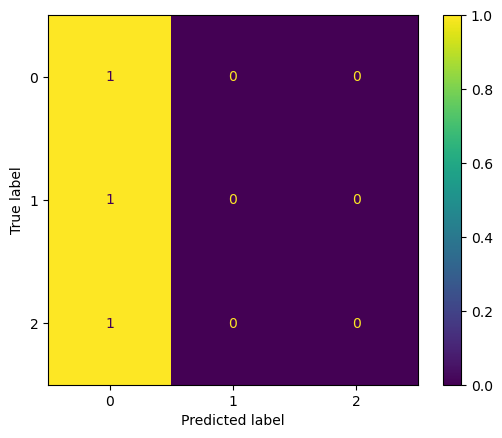

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.65417. Saving Model!
epoch 01, loss: 0.64103, acc: 0.78658, val_loss: 0.65417, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 02, loss: 0.64040, acc: 0.78658, val_loss: 0.65623, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 03, loss: 0.63979, acc: 0.78658, val_loss: 0.65905, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 04, loss: 0.63917, acc: 0.78658, val_loss: 0.66228, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 05, loss: 0.63841, acc: 0.78658, val_loss: 0.66568, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 06, loss: 0.63743, acc: 0.78658, val_loss: 0.66923, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


epoch 07, loss: 0.63622, acc: 0.78658, val_loss: 0.67305, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 08, loss: 0.63492, acc: 0.78658, val_loss: 0.67719, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 09, loss: 0.63369, acc: 0.78658, val_loss: 0.68184, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 10, loss: 0.63263, acc: 0.78658, val_loss: 0.68695, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 11, loss: 0.63177, acc: 0.78658, val_loss: 0.69259, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 12, loss: 0.63104, acc: 0.78658, val_loss: 0.69854, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 13, loss: 0.63039, acc: 0.78658, val_loss: 0.70475, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 14, loss: 0.62973, acc: 0.78658, val_loss: 0.71103, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 15, loss: 0.62908, acc: 0.78658, val_loss: 0.71730, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


epoch 16, loss: 0.62845, acc: 0.78658, val_loss: 0.72355, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 17, loss: 0.62789, acc: 0.78658, val_loss: 0.72968, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 18, loss: 0.62740, acc: 0.78658, val_loss: 0.73530, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 19, loss: 0.62697, acc: 0.78658, val_loss: 0.74048, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 20, loss: 0.62652, acc: 0.78658, val_loss: 0.74522, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 21, loss: 0.62604, acc: 0.78658, val_loss: 0.74948, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 22, loss: 0.62551, acc: 0.78658, val_loss: 0.75335, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]


epoch 23, loss: 0.62495, acc: 0.78658, val_loss: 0.75683, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 24, loss: 0.62438, acc: 0.78658, val_loss: 0.76001, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 25, loss: 0.62382, acc: 0.78658, val_loss: 0.76282, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 26, loss: 0.62328, acc: 0.78658, val_loss: 0.76542, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 27, loss: 0.62275, acc: 0.78658, val_loss: 0.76780, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 28, loss: 0.62221, acc: 0.78658, val_loss: 0.76994, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 29, loss: 0.62167, acc: 0.78658, val_loss: 0.77198, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 30, loss: 0.62111, acc: 0.78658, val_loss: 0.77393, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]


epoch 31, loss: 0.62057, acc: 0.78658, val_loss: 0.77574, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 32, loss: 0.62002, acc: 0.78658, val_loss: 0.77755, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 33, loss: 0.61950, acc: 0.78658, val_loss: 0.77923, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 34, loss: 0.61898, acc: 0.78658, val_loss: 0.78085, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 35, loss: 0.61847, acc: 0.78658, val_loss: 0.78238, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 36, loss: 0.61795, acc: 0.78658, val_loss: 0.78385, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 37, loss: 0.61741, acc: 0.78658, val_loss: 0.78527, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 38, loss: 0.61688, acc: 0.78658, val_loss: 0.78669, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


epoch 39, loss: 0.61636, acc: 0.78658, val_loss: 0.78822, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 40, loss: 0.61584, acc: 0.78658, val_loss: 0.78985, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 41, loss: 0.61533, acc: 0.78658, val_loss: 0.79162, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 42, loss: 0.61483, acc: 0.78658, val_loss: 0.79357, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.63it/s]


epoch 43, loss: 0.61433, acc: 0.78658, val_loss: 0.79573, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 44, loss: 0.61383, acc: 0.78658, val_loss: 0.79807, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 45, loss: 0.61334, acc: 0.78658, val_loss: 0.80056, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 46, loss: 0.61285, acc: 0.78658, val_loss: 0.80328, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 47, loss: 0.61237, acc: 0.78658, val_loss: 0.80604, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 48, loss: 0.61190, acc: 0.78658, val_loss: 0.80892, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 49, loss: 0.61144, acc: 0.78658, val_loss: 0.81191, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 50, loss: 0.61097, acc: 0.78634, val_loss: 0.81486, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 51, loss: 0.61051, acc: 0.78585, val_loss: 0.81792, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 52, loss: 0.61005, acc: 0.78706, val_loss: 0.82098, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 53, loss: 0.60958, acc: 0.78706, val_loss: 0.82421, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 54, loss: 0.60913, acc: 0.78682, val_loss: 0.82759, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 55, loss: 0.60868, acc: 0.78658, val_loss: 0.83091, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 56, loss: 0.60822, acc: 0.78875, val_loss: 0.83444, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 57, loss: 0.60777, acc: 0.78827, val_loss: 0.83803, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 58, loss: 0.60733, acc: 0.78803, val_loss: 0.84171, val_accuracy: 0.78261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 59, loss: 0.60688, acc: 0.78803, val_loss: 0.84549, val_accuracy: 0.78261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.15it/s]


epoch 60, loss: 0.60644, acc: 0.78803, val_loss: 0.84938, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 61, loss: 0.60600, acc: 0.78803, val_loss: 0.85331, val_accuracy: 0.60217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 62, loss: 0.60556, acc: 0.78827, val_loss: 0.85719, val_accuracy: 0.60000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


epoch 63, loss: 0.60511, acc: 0.78827, val_loss: 0.86110, val_accuracy: 0.60000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 64, loss: 0.60467, acc: 0.78827, val_loss: 0.86488, val_accuracy: 0.59348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 65, loss: 0.60423, acc: 0.78972, val_loss: 0.86860, val_accuracy: 0.57391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 66, loss: 0.60379, acc: 0.78996, val_loss: 0.87228, val_accuracy: 0.56522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 67, loss: 0.60336, acc: 0.78996, val_loss: 0.87593, val_accuracy: 0.56304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 68, loss: 0.60291, acc: 0.79020, val_loss: 0.87969, val_accuracy: 0.56304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 69, loss: 0.60248, acc: 0.79092, val_loss: 0.88341, val_accuracy: 0.56304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 70, loss: 0.60204, acc: 0.79092, val_loss: 0.88708, val_accuracy: 0.55870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 71, loss: 0.60161, acc: 0.79092, val_loss: 0.89074, val_accuracy: 0.55870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


epoch 72, loss: 0.60117, acc: 0.79092, val_loss: 0.89441, val_accuracy: 0.55870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 73, loss: 0.60073, acc: 0.79092, val_loss: 0.89806, val_accuracy: 0.55217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.33it/s]


epoch 74, loss: 0.60030, acc: 0.79092, val_loss: 0.90168, val_accuracy: 0.55217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 75, loss: 0.59987, acc: 0.79092, val_loss: 0.90529, val_accuracy: 0.55217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


epoch 76, loss: 0.59943, acc: 0.79092, val_loss: 0.90895, val_accuracy: 0.54783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 77, loss: 0.59900, acc: 0.79068, val_loss: 0.91302, val_accuracy: 0.54783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 78, loss: 0.59857, acc: 0.79068, val_loss: 0.91814, val_accuracy: 0.54783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.29it/s]


epoch 79, loss: 0.59812, acc: 0.79116, val_loss: 0.92351, val_accuracy: 0.54783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 80, loss: 0.59768, acc: 0.79116, val_loss: 0.92951, val_accuracy: 0.54783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 81, loss: 0.59722, acc: 0.79116, val_loss: 0.93539, val_accuracy: 0.54348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 82, loss: 0.59678, acc: 0.79141, val_loss: 0.94105, val_accuracy: 0.54348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 83, loss: 0.59631, acc: 0.79141, val_loss: 0.94617, val_accuracy: 0.54348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 84, loss: 0.59581, acc: 0.79141, val_loss: 0.95129, val_accuracy: 0.54348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 85, loss: 0.59532, acc: 0.79141, val_loss: 0.95723, val_accuracy: 0.54130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 86, loss: 0.59484, acc: 0.79141, val_loss: 0.96409, val_accuracy: 0.53696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.26it/s]


epoch 87, loss: 0.59430, acc: 0.79141, val_loss: 0.97139, val_accuracy: 0.53478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 88, loss: 0.59378, acc: 0.79141, val_loss: 0.97881, val_accuracy: 0.53478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 89, loss: 0.59327, acc: 0.79141, val_loss: 0.98565, val_accuracy: 0.53478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 90, loss: 0.59272, acc: 0.79141, val_loss: 0.99203, val_accuracy: 0.53478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]


epoch 91, loss: 0.59216, acc: 0.79141, val_loss: 0.99877, val_accuracy: 0.53478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]

epoch 92, loss: 0.59161, acc: 0.79116, val_loss: 1.00683, val_accuracy: 0.53478

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 93, loss: 0.59103, acc: 0.79116, val_loss: 1.01602, val_accuracy: 0.53478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 94, loss: 0.59045, acc: 0.79116, val_loss: 1.02452, val_accuracy: 0.53478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 95, loss: 0.58988, acc: 0.79116, val_loss: 1.03231, val_accuracy: 0.53478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 96, loss: 0.58928, acc: 0.79116, val_loss: 1.03924, val_accuracy: 0.53478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 97, loss: 0.58867, acc: 0.79116, val_loss: 1.04674, val_accuracy: 0.53478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 98, loss: 0.58809, acc: 0.79141, val_loss: 1.05597, val_accuracy: 0.53478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 99, loss: 0.58745, acc: 0.79141, val_loss: 1.06557, val_accuracy: 0.53478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 100, loss: 0.58683, acc: 0.79141, val_loss: 1.07438, val_accuracy: 0.53478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.66it/s]


epoch 101, loss: 0.58621, acc: 0.79165, val_loss: 1.08167, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 102, loss: 0.58557, acc: 0.79165, val_loss: 1.09008, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]


epoch 103, loss: 0.58491, acc: 0.79165, val_loss: 1.09926, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 104, loss: 0.58428, acc: 0.79165, val_loss: 1.10652, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.99it/s]


epoch 105, loss: 0.58360, acc: 0.79165, val_loss: 1.11249, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 106, loss: 0.58292, acc: 0.79165, val_loss: 1.11881, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 107, loss: 0.58228, acc: 0.79165, val_loss: 1.12821, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 108, loss: 0.58156, acc: 0.79141, val_loss: 1.13845, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 109, loss: 0.58088, acc: 0.79165, val_loss: 1.14686, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 110, loss: 0.58019, acc: 0.79165, val_loss: 1.15332, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 111, loss: 0.57947, acc: 0.79165, val_loss: 1.16012, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


epoch 112, loss: 0.57877, acc: 0.79165, val_loss: 1.16822, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 113, loss: 0.57805, acc: 0.79213, val_loss: 1.17504, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 114, loss: 0.57734, acc: 0.79165, val_loss: 1.18018, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 115, loss: 0.57662, acc: 0.79165, val_loss: 1.18719, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 116, loss: 0.57591, acc: 0.79165, val_loss: 1.19269, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 117, loss: 0.57518, acc: 0.79189, val_loss: 1.19662, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 118, loss: 0.57445, acc: 0.79189, val_loss: 1.20365, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.17it/s]


epoch 119, loss: 0.57373, acc: 0.79189, val_loss: 1.20723, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 120, loss: 0.57298, acc: 0.79189, val_loss: 1.20812, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 121, loss: 0.57221, acc: 0.79189, val_loss: 1.21215, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 122, loss: 0.57144, acc: 0.79189, val_loss: 1.21543, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 123, loss: 0.57067, acc: 0.79189, val_loss: 1.21903, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 124, loss: 0.56994, acc: 0.79189, val_loss: 1.22829, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 125, loss: 0.56921, acc: 0.79261, val_loss: 1.23311, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 126, loss: 0.56845, acc: 0.79261, val_loss: 1.23307, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 127, loss: 0.56765, acc: 0.79261, val_loss: 1.23744, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


epoch 128, loss: 0.56688, acc: 0.79261, val_loss: 1.24236, val_accuracy: 0.53043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 129, loss: 0.56611, acc: 0.79285, val_loss: 1.24535, val_accuracy: 0.53043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.54it/s]


epoch 130, loss: 0.56535, acc: 0.79285, val_loss: 1.25056, val_accuracy: 0.53043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 131, loss: 0.56457, acc: 0.79285, val_loss: 1.25420, val_accuracy: 0.53043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 132, loss: 0.56379, acc: 0.79261, val_loss: 1.25611, val_accuracy: 0.53043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 133, loss: 0.56301, acc: 0.79261, val_loss: 1.26373, val_accuracy: 0.53043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 134, loss: 0.56226, acc: 0.79237, val_loss: 1.26653, val_accuracy: 0.53043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 135, loss: 0.56147, acc: 0.79213, val_loss: 1.26493, val_accuracy: 0.53043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 136, loss: 0.56066, acc: 0.79213, val_loss: 1.26890, val_accuracy: 0.53043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.40it/s]


epoch 137, loss: 0.55986, acc: 0.79213, val_loss: 1.27196, val_accuracy: 0.53043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 138, loss: 0.55906, acc: 0.79261, val_loss: 1.27314, val_accuracy: 0.53043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 139, loss: 0.55827, acc: 0.79261, val_loss: 1.27820, val_accuracy: 0.53043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 140, loss: 0.55745, acc: 0.79237, val_loss: 1.28362, val_accuracy: 0.53043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 141, loss: 0.55669, acc: 0.79237, val_loss: 1.28235, val_accuracy: 0.53043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 142, loss: 0.55585, acc: 0.79237, val_loss: 1.27906, val_accuracy: 0.53043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]


epoch 143, loss: 0.55508, acc: 0.79237, val_loss: 1.28733, val_accuracy: 0.52826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 144, loss: 0.55421, acc: 0.79261, val_loss: 1.29239, val_accuracy: 0.52826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 145, loss: 0.55341, acc: 0.79237, val_loss: 1.29172, val_accuracy: 0.52826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 146, loss: 0.55261, acc: 0.79285, val_loss: 1.29358, val_accuracy: 0.52826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 147, loss: 0.55179, acc: 0.79285, val_loss: 1.29776, val_accuracy: 0.52826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 148, loss: 0.55097, acc: 0.79310, val_loss: 1.29707, val_accuracy: 0.52826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 149, loss: 0.55015, acc: 0.79310, val_loss: 1.29714, val_accuracy: 0.52826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 150, loss: 0.54930, acc: 0.79310, val_loss: 1.29992, val_accuracy: 0.52826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 151, loss: 0.54851, acc: 0.79285, val_loss: 1.30517, val_accuracy: 0.52826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 152, loss: 0.54767, acc: 0.79261, val_loss: 1.30720, val_accuracy: 0.52826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 153, loss: 0.54685, acc: 0.79310, val_loss: 1.29819, val_accuracy: 0.52826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 154, loss: 0.54599, acc: 0.79334, val_loss: 1.29517, val_accuracy: 0.52826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 155, loss: 0.54520, acc: 0.79382, val_loss: 1.30729, val_accuracy: 0.52826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 156, loss: 0.54436, acc: 0.79358, val_loss: 1.30789, val_accuracy: 0.52609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 157, loss: 0.54351, acc: 0.79406, val_loss: 1.29872, val_accuracy: 0.52609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 158, loss: 0.54268, acc: 0.79382, val_loss: 1.29944, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


epoch 159, loss: 0.54180, acc: 0.79406, val_loss: 1.30867, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 160, loss: 0.54096, acc: 0.79430, val_loss: 1.31012, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]


epoch 161, loss: 0.54011, acc: 0.79454, val_loss: 1.30426, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 162, loss: 0.53925, acc: 0.79479, val_loss: 1.30671, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 163, loss: 0.53846, acc: 0.79527, val_loss: 1.32412, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 164, loss: 0.53759, acc: 0.79623, val_loss: 1.32708, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 165, loss: 0.53673, acc: 0.79599, val_loss: 1.32458, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 166, loss: 0.53581, acc: 0.79648, val_loss: 1.33048, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 167, loss: 0.53503, acc: 0.79623, val_loss: 1.33901, val_accuracy: 0.50217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


epoch 168, loss: 0.53423, acc: 0.79768, val_loss: 1.33640, val_accuracy: 0.50217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 169, loss: 0.53332, acc: 0.79768, val_loss: 1.33562, val_accuracy: 0.50217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 170, loss: 0.53247, acc: 0.79744, val_loss: 1.34444, val_accuracy: 0.50217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 171, loss: 0.53164, acc: 0.79768, val_loss: 1.34431, val_accuracy: 0.51087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 172, loss: 0.53078, acc: 0.79817, val_loss: 1.34550, val_accuracy: 0.51087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 173, loss: 0.52993, acc: 0.79792, val_loss: 1.34702, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 174, loss: 0.52908, acc: 0.79841, val_loss: 1.35294, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]


epoch 175, loss: 0.52821, acc: 0.79865, val_loss: 1.35613, val_accuracy: 0.49783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 176, loss: 0.52741, acc: 0.79961, val_loss: 1.36350, val_accuracy: 0.49783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 177, loss: 0.52655, acc: 0.79986, val_loss: 1.37191, val_accuracy: 0.49783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 178, loss: 0.52570, acc: 0.79986, val_loss: 1.36970, val_accuracy: 0.49783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 179, loss: 0.52485, acc: 0.80010, val_loss: 1.36830, val_accuracy: 0.49783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 180, loss: 0.52399, acc: 0.80010, val_loss: 1.37769, val_accuracy: 0.49565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 181, loss: 0.52309, acc: 0.80251, val_loss: 1.38050, val_accuracy: 0.49565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 182, loss: 0.52226, acc: 0.80275, val_loss: 1.38380, val_accuracy: 0.49348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


epoch 183, loss: 0.52139, acc: 0.80227, val_loss: 1.38518, val_accuracy: 0.49348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 184, loss: 0.52052, acc: 0.80203, val_loss: 1.39767, val_accuracy: 0.48913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 185, loss: 0.51970, acc: 0.80227, val_loss: 1.40435, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 186, loss: 0.51886, acc: 0.80251, val_loss: 1.40481, val_accuracy: 0.48261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 187, loss: 0.51807, acc: 0.80251, val_loss: 1.41854, val_accuracy: 0.48261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 188, loss: 0.51723, acc: 0.80420, val_loss: 1.42566, val_accuracy: 0.48043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 189, loss: 0.51637, acc: 0.80372, val_loss: 1.42610, val_accuracy: 0.48261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 190, loss: 0.51557, acc: 0.80372, val_loss: 1.44044, val_accuracy: 0.48043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 191, loss: 0.51470, acc: 0.80444, val_loss: 1.44504, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


epoch 192, loss: 0.51389, acc: 0.80468, val_loss: 1.44915, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 193, loss: 0.51305, acc: 0.80444, val_loss: 1.45165, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 194, loss: 0.51224, acc: 0.80420, val_loss: 1.45557, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 195, loss: 0.51140, acc: 0.80396, val_loss: 1.46021, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 196, loss: 0.51055, acc: 0.80396, val_loss: 1.46162, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 197, loss: 0.50975, acc: 0.80541, val_loss: 1.47154, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 198, loss: 0.50893, acc: 0.80662, val_loss: 1.47281, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.75it/s]


epoch 199, loss: 0.50812, acc: 0.80613, val_loss: 1.48372, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 200, loss: 0.50730, acc: 0.80613, val_loss: 1.48706, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 201, loss: 0.50647, acc: 0.80637, val_loss: 1.49212, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 202, loss: 0.50565, acc: 0.80613, val_loss: 1.50666, val_accuracy: 0.39130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 203, loss: 0.50481, acc: 0.80637, val_loss: 1.50557, val_accuracy: 0.39130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 204, loss: 0.50397, acc: 0.80710, val_loss: 1.51061, val_accuracy: 0.39130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 205, loss: 0.50314, acc: 0.80734, val_loss: 1.51453, val_accuracy: 0.39130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 206, loss: 0.50230, acc: 0.80734, val_loss: 1.51279, val_accuracy: 0.39130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 207, loss: 0.50148, acc: 0.80758, val_loss: 1.52221, val_accuracy: 0.39130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]


epoch 208, loss: 0.50064, acc: 0.80782, val_loss: 1.53028, val_accuracy: 0.38043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 209, loss: 0.49976, acc: 0.80782, val_loss: 1.53155, val_accuracy: 0.38043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 210, loss: 0.49894, acc: 0.80734, val_loss: 1.54869, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 211, loss: 0.49809, acc: 0.80855, val_loss: 1.54570, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 212, loss: 0.49723, acc: 0.80855, val_loss: 1.55955, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 213, loss: 0.49633, acc: 0.80831, val_loss: 1.56852, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 214, loss: 0.49555, acc: 0.80806, val_loss: 1.55547, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


epoch 215, loss: 0.49472, acc: 0.80831, val_loss: 1.57784, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 216, loss: 0.49410, acc: 0.80806, val_loss: 1.55210, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 217, loss: 0.49318, acc: 0.80903, val_loss: 1.57049, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 218, loss: 0.49220, acc: 0.80855, val_loss: 1.58825, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 219, loss: 0.49153, acc: 0.80879, val_loss: 1.56416, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 220, loss: 0.49072, acc: 0.80855, val_loss: 1.58720, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 221, loss: 0.48984, acc: 0.80831, val_loss: 1.60800, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 222, loss: 0.48909, acc: 0.80879, val_loss: 1.58692, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]


epoch 223, loss: 0.48849, acc: 0.80831, val_loss: 1.63613, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 224, loss: 0.48753, acc: 0.81241, val_loss: 1.62481, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 225, loss: 0.48655, acc: 0.80879, val_loss: 1.61614, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 226, loss: 0.48586, acc: 0.80831, val_loss: 1.65764, val_accuracy: 0.37391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 227, loss: 0.48520, acc: 0.81313, val_loss: 1.62834, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 228, loss: 0.48425, acc: 0.81169, val_loss: 1.65240, val_accuracy: 0.37391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 229, loss: 0.48332, acc: 0.81217, val_loss: 1.65613, val_accuracy: 0.37391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 230, loss: 0.48253, acc: 0.81289, val_loss: 1.64861, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 231, loss: 0.48180, acc: 0.81313, val_loss: 1.68893, val_accuracy: 0.37391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 232, loss: 0.48101, acc: 0.81434, val_loss: 1.69094, val_accuracy: 0.37391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 233, loss: 0.48010, acc: 0.81386, val_loss: 1.68995, val_accuracy: 0.37391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 234, loss: 0.47945, acc: 0.81458, val_loss: 1.72975, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 235, loss: 0.47879, acc: 0.81482, val_loss: 1.70275, val_accuracy: 0.37391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 236, loss: 0.47801, acc: 0.81555, val_loss: 1.73942, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 237, loss: 0.47716, acc: 0.81531, val_loss: 1.71336, val_accuracy: 0.37174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 238, loss: 0.47627, acc: 0.81603, val_loss: 1.72866, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


epoch 239, loss: 0.47543, acc: 0.81700, val_loss: 1.73139, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 240, loss: 0.47465, acc: 0.81748, val_loss: 1.72345, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 241, loss: 0.47390, acc: 0.81796, val_loss: 1.74392, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 242, loss: 0.47324, acc: 0.81676, val_loss: 1.72654, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 243, loss: 0.47251, acc: 0.81772, val_loss: 1.76844, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 244, loss: 0.47197, acc: 0.81869, val_loss: 1.72732, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 245, loss: 0.47129, acc: 0.81724, val_loss: 1.79261, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 246, loss: 0.47105, acc: 0.81796, val_loss: 1.72704, val_accuracy: 0.37174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 247, loss: 0.47044, acc: 0.81676, val_loss: 1.81160, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


epoch 248, loss: 0.46975, acc: 0.81869, val_loss: 1.74335, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 249, loss: 0.46866, acc: 0.81965, val_loss: 1.78801, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


epoch 250, loss: 0.46758, acc: 0.81845, val_loss: 1.78384, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 251, loss: 0.46670, acc: 0.82134, val_loss: 1.77824, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 252, loss: 0.46618, acc: 0.82134, val_loss: 1.83395, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 253, loss: 0.46582, acc: 0.81845, val_loss: 1.75769, val_accuracy: 0.37174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 254, loss: 0.46579, acc: 0.81965, val_loss: 1.86646, val_accuracy: 0.35217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


epoch 255, loss: 0.46573, acc: 0.81989, val_loss: 1.75171, val_accuracy: 0.37174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 256, loss: 0.46544, acc: 0.81724, val_loss: 1.87247, val_accuracy: 0.34348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 257, loss: 0.46389, acc: 0.82110, val_loss: 1.79621, val_accuracy: 0.36522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 258, loss: 0.46224, acc: 0.82110, val_loss: 1.84037, val_accuracy: 0.35870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 259, loss: 0.46126, acc: 0.81989, val_loss: 1.85963, val_accuracy: 0.35870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 260, loss: 0.46054, acc: 0.82062, val_loss: 1.82753, val_accuracy: 0.36087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


epoch 261, loss: 0.46033, acc: 0.82110, val_loss: 1.89842, val_accuracy: 0.33261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 262, loss: 0.46008, acc: 0.82231, val_loss: 1.81192, val_accuracy: 0.36304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 263, loss: 0.45983, acc: 0.82207, val_loss: 1.92823, val_accuracy: 0.33478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 264, loss: 0.45962, acc: 0.82327, val_loss: 1.81135, val_accuracy: 0.36304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]


epoch 265, loss: 0.45944, acc: 0.82086, val_loss: 1.93835, val_accuracy: 0.33043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 266, loss: 0.45826, acc: 0.82352, val_loss: 1.83454, val_accuracy: 0.35870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 267, loss: 0.45684, acc: 0.82183, val_loss: 1.91245, val_accuracy: 0.33478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 268, loss: 0.45583, acc: 0.82400, val_loss: 1.86612, val_accuracy: 0.35652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 269, loss: 0.45491, acc: 0.82279, val_loss: 1.90883, val_accuracy: 0.34130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 270, loss: 0.45409, acc: 0.82448, val_loss: 1.89946, val_accuracy: 0.34130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 271, loss: 0.45341, acc: 0.82545, val_loss: 1.91183, val_accuracy: 0.33913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 272, loss: 0.45271, acc: 0.82545, val_loss: 1.92495, val_accuracy: 0.34130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 273, loss: 0.45212, acc: 0.82545, val_loss: 1.89509, val_accuracy: 0.34130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 274, loss: 0.45163, acc: 0.82593, val_loss: 1.95161, val_accuracy: 0.33478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 275, loss: 0.45122, acc: 0.82545, val_loss: 1.88683, val_accuracy: 0.35217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


epoch 276, loss: 0.45122, acc: 0.82400, val_loss: 2.01375, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 277, loss: 0.45197, acc: 0.82714, val_loss: 1.84445, val_accuracy: 0.35870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 278, loss: 0.45425, acc: 0.82086, val_loss: 2.07345, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


epoch 279, loss: 0.45455, acc: 0.82738, val_loss: 1.83627, val_accuracy: 0.36304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 280, loss: 0.45584, acc: 0.82062, val_loss: 2.06669, val_accuracy: 0.30870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 281, loss: 0.45070, acc: 0.82714, val_loss: 1.95118, val_accuracy: 0.34130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 282, loss: 0.44721, acc: 0.82665, val_loss: 1.96806, val_accuracy: 0.33043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 283, loss: 0.44630, acc: 0.82641, val_loss: 2.03407, val_accuracy: 0.31087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 284, loss: 0.44698, acc: 0.82617, val_loss: 1.88134, val_accuracy: 0.35217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 285, loss: 0.44864, acc: 0.82448, val_loss: 2.07201, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 286, loss: 0.44845, acc: 0.82641, val_loss: 1.88377, val_accuracy: 0.35000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 287, loss: 0.44831, acc: 0.82303, val_loss: 2.07700, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 288, loss: 0.44581, acc: 0.82665, val_loss: 1.96073, val_accuracy: 0.33696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 289, loss: 0.44373, acc: 0.82786, val_loss: 2.01858, val_accuracy: 0.31957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 290, loss: 0.44220, acc: 0.82907, val_loss: 2.02239, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 291, loss: 0.44180, acc: 0.82834, val_loss: 1.93917, val_accuracy: 0.32391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 292, loss: 0.44219, acc: 0.82834, val_loss: 2.07011, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 293, loss: 0.44288, acc: 0.82738, val_loss: 1.90588, val_accuracy: 0.34130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 294, loss: 0.44394, acc: 0.82617, val_loss: 2.11750, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


epoch 295, loss: 0.44338, acc: 0.82883, val_loss: 1.93281, val_accuracy: 0.34783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 296, loss: 0.44300, acc: 0.82786, val_loss: 2.11266, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 297, loss: 0.44063, acc: 0.82979, val_loss: 1.97783, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 298, loss: 0.43861, acc: 0.82979, val_loss: 2.02256, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 299, loss: 0.43721, acc: 0.83124, val_loss: 2.03825, val_accuracy: 0.31087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 300, loss: 0.43690, acc: 0.83124, val_loss: 1.96614, val_accuracy: 0.31957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.87it/s]


epoch 301, loss: 0.43731, acc: 0.83100, val_loss: 2.11366, val_accuracy: 0.28913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]


epoch 302, loss: 0.43852, acc: 0.82979, val_loss: 1.91913, val_accuracy: 0.33478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.89it/s]


epoch 303, loss: 0.44066, acc: 0.82690, val_loss: 2.15696, val_accuracy: 0.28913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]


epoch 304, loss: 0.44059, acc: 0.83003, val_loss: 1.91063, val_accuracy: 0.33478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 305, loss: 0.44060, acc: 0.82738, val_loss: 2.13393, val_accuracy: 0.28913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 306, loss: 0.43686, acc: 0.83076, val_loss: 2.00630, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 307, loss: 0.43410, acc: 0.83366, val_loss: 2.06454, val_accuracy: 0.29348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 308, loss: 0.43257, acc: 0.83438, val_loss: 2.09795, val_accuracy: 0.28913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 309, loss: 0.43260, acc: 0.83100, val_loss: 1.97824, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 310, loss: 0.43379, acc: 0.83197, val_loss: 2.15964, val_accuracy: 0.28913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.22it/s]


epoch 311, loss: 0.43536, acc: 0.83172, val_loss: 1.92179, val_accuracy: 0.34348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 312, loss: 0.43753, acc: 0.82810, val_loss: 2.17322, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 313, loss: 0.43504, acc: 0.83124, val_loss: 1.96799, val_accuracy: 0.31957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 314, loss: 0.43279, acc: 0.83124, val_loss: 2.11070, val_accuracy: 0.28913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 315, loss: 0.42989, acc: 0.83245, val_loss: 2.05993, val_accuracy: 0.29348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 316, loss: 0.42841, acc: 0.83655, val_loss: 2.03340, val_accuracy: 0.29783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 317, loss: 0.42837, acc: 0.83535, val_loss: 2.14315, val_accuracy: 0.28913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.24it/s]


epoch 318, loss: 0.42914, acc: 0.83438, val_loss: 1.98667, val_accuracy: 0.31957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]


epoch 319, loss: 0.43042, acc: 0.83124, val_loss: 2.18298, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 320, loss: 0.43048, acc: 0.83535, val_loss: 1.96561, val_accuracy: 0.32174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 321, loss: 0.43083, acc: 0.83124, val_loss: 2.17365, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 322, loss: 0.42882, acc: 0.83559, val_loss: 2.01563, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 323, loss: 0.42711, acc: 0.83390, val_loss: 2.14477, val_accuracy: 0.28913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 324, loss: 0.42530, acc: 0.83438, val_loss: 2.07272, val_accuracy: 0.29783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 325, loss: 0.42410, acc: 0.83704, val_loss: 2.08682, val_accuracy: 0.29348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 326, loss: 0.42343, acc: 0.83704, val_loss: 2.12264, val_accuracy: 0.28913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]


epoch 327, loss: 0.42319, acc: 0.83462, val_loss: 2.06330, val_accuracy: 0.30217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 328, loss: 0.42314, acc: 0.83631, val_loss: 2.17710, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 329, loss: 0.42350, acc: 0.83679, val_loss: 2.02680, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 330, loss: 0.42441, acc: 0.83510, val_loss: 2.21264, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 331, loss: 0.42511, acc: 0.83679, val_loss: 1.97619, val_accuracy: 0.30870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 332, loss: 0.42687, acc: 0.83414, val_loss: 2.23018, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.82it/s]

epoch 333, loss: 0.42576, acc: 0.83679, val_loss: 1.99244, val_accuracy: 0.30870



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 334, loss: 0.42564, acc: 0.83414, val_loss: 2.21956, val_accuracy: 0.28696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 335, loss: 0.42212, acc: 0.83848, val_loss: 2.08430, val_accuracy: 0.30000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 336, loss: 0.41969, acc: 0.83776, val_loss: 2.12663, val_accuracy: 0.28913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 337, loss: 0.41834, acc: 0.83824, val_loss: 2.16406, val_accuracy: 0.28696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 338, loss: 0.41847, acc: 0.83945, val_loss: 2.05492, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 339, loss: 0.41936, acc: 0.83776, val_loss: 2.23280, val_accuracy: 0.26522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 340, loss: 0.42076, acc: 0.83728, val_loss: 2.00052, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 341, loss: 0.42318, acc: 0.83559, val_loss: 2.27624, val_accuracy: 0.25217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 342, loss: 0.42307, acc: 0.83969, val_loss: 2.00003, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 343, loss: 0.42295, acc: 0.83486, val_loss: 2.24803, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]


epoch 344, loss: 0.41954, acc: 0.83969, val_loss: 2.07457, val_accuracy: 0.30000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 345, loss: 0.41706, acc: 0.83945, val_loss: 2.16797, val_accuracy: 0.28913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 346, loss: 0.41468, acc: 0.84090, val_loss: 2.19220, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 347, loss: 0.41491, acc: 0.83993, val_loss: 2.06619, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 348, loss: 0.41595, acc: 0.83969, val_loss: 2.26441, val_accuracy: 0.25217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 349, loss: 0.41834, acc: 0.84307, val_loss: 1.99663, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 350, loss: 0.42018, acc: 0.83486, val_loss: 2.28257, val_accuracy: 0.25435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.17it/s]


epoch 351, loss: 0.41852, acc: 0.84138, val_loss: 2.04117, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 352, loss: 0.41674, acc: 0.83776, val_loss: 2.22872, val_accuracy: 0.25435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 353, loss: 0.41303, acc: 0.84355, val_loss: 2.17912, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 354, loss: 0.41128, acc: 0.84162, val_loss: 2.11462, val_accuracy: 0.29565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 355, loss: 0.41198, acc: 0.84042, val_loss: 2.26848, val_accuracy: 0.25000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 356, loss: 0.41394, acc: 0.84476, val_loss: 2.01522, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 357, loss: 0.41587, acc: 0.83462, val_loss: 2.27474, val_accuracy: 0.25217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.22it/s]


epoch 358, loss: 0.41453, acc: 0.84380, val_loss: 2.04613, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 359, loss: 0.41295, acc: 0.83897, val_loss: 2.24367, val_accuracy: 0.25000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.21it/s]


epoch 360, loss: 0.41009, acc: 0.84621, val_loss: 2.16259, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 361, loss: 0.40797, acc: 0.84162, val_loss: 2.15155, val_accuracy: 0.28261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 362, loss: 0.40765, acc: 0.84042, val_loss: 2.22405, val_accuracy: 0.25000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 363, loss: 0.40829, acc: 0.84718, val_loss: 2.05737, val_accuracy: 0.30217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 364, loss: 0.40958, acc: 0.83679, val_loss: 2.27075, val_accuracy: 0.25000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 365, loss: 0.41009, acc: 0.84645, val_loss: 2.05713, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 366, loss: 0.41106, acc: 0.83631, val_loss: 2.32145, val_accuracy: 0.25000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 367, loss: 0.40963, acc: 0.84549, val_loss: 2.11845, val_accuracy: 0.30000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 368, loss: 0.40792, acc: 0.84042, val_loss: 2.27219, val_accuracy: 0.25217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 369, loss: 0.40598, acc: 0.84476, val_loss: 2.16282, val_accuracy: 0.27609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 370, loss: 0.40446, acc: 0.84235, val_loss: 2.19144, val_accuracy: 0.25652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 371, loss: 0.40367, acc: 0.84331, val_loss: 2.23021, val_accuracy: 0.25000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 372, loss: 0.40359, acc: 0.84500, val_loss: 2.15477, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 373, loss: 0.40377, acc: 0.84017, val_loss: 2.29405, val_accuracy: 0.24783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 374, loss: 0.40423, acc: 0.84766, val_loss: 2.12911, val_accuracy: 0.28696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


epoch 375, loss: 0.40492, acc: 0.83921, val_loss: 2.32874, val_accuracy: 0.24783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.56it/s]


epoch 376, loss: 0.40541, acc: 0.84838, val_loss: 2.09302, val_accuracy: 0.29348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 377, loss: 0.40648, acc: 0.83752, val_loss: 2.35080, val_accuracy: 0.24783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 378, loss: 0.40540, acc: 0.84766, val_loss: 2.12764, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 379, loss: 0.40468, acc: 0.83945, val_loss: 2.35043, val_accuracy: 0.24783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 380, loss: 0.40304, acc: 0.84862, val_loss: 2.17562, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 381, loss: 0.40198, acc: 0.84090, val_loss: 2.30179, val_accuracy: 0.24783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 382, loss: 0.40010, acc: 0.84935, val_loss: 2.22940, val_accuracy: 0.25217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 383, loss: 0.39935, acc: 0.84428, val_loss: 2.23418, val_accuracy: 0.25000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 384, loss: 0.39847, acc: 0.84428, val_loss: 2.29178, val_accuracy: 0.24565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 385, loss: 0.39884, acc: 0.85104, val_loss: 2.18717, val_accuracy: 0.25870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 386, loss: 0.39912, acc: 0.84138, val_loss: 2.34756, val_accuracy: 0.24348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 387, loss: 0.40010, acc: 0.84887, val_loss: 2.12828, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 388, loss: 0.40209, acc: 0.83848, val_loss: 2.40976, val_accuracy: 0.23478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 389, loss: 0.40312, acc: 0.84887, val_loss: 2.10841, val_accuracy: 0.28696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


epoch 390, loss: 0.40588, acc: 0.83800, val_loss: 2.45268, val_accuracy: 0.23478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.05it/s]


epoch 391, loss: 0.40456, acc: 0.84862, val_loss: 2.10799, val_accuracy: 0.29130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 392, loss: 0.40559, acc: 0.83728, val_loss: 2.39123, val_accuracy: 0.23261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.87it/s]


epoch 393, loss: 0.39957, acc: 0.84959, val_loss: 2.28530, val_accuracy: 0.25000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 394, loss: 0.39687, acc: 0.84452, val_loss: 2.22872, val_accuracy: 0.25435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 395, loss: 0.39632, acc: 0.84283, val_loss: 2.40692, val_accuracy: 0.23261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 396, loss: 0.40076, acc: 0.84742, val_loss: 2.09090, val_accuracy: 0.28696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


epoch 397, loss: 0.40393, acc: 0.83679, val_loss: 2.45696, val_accuracy: 0.22609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 398, loss: 0.40305, acc: 0.84887, val_loss: 2.13375, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 399, loss: 0.40244, acc: 0.83897, val_loss: 2.42971, val_accuracy: 0.23043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.38it/s]


epoch 400, loss: 0.39798, acc: 0.85080, val_loss: 2.30684, val_accuracy: 0.24783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 401, loss: 0.39353, acc: 0.84573, val_loss: 2.24920, val_accuracy: 0.25217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 402, loss: 0.39447, acc: 0.84428, val_loss: 2.39658, val_accuracy: 0.23261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 403, loss: 0.39664, acc: 0.84766, val_loss: 2.11257, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 404, loss: 0.39894, acc: 0.83969, val_loss: 2.40736, val_accuracy: 0.22609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 405, loss: 0.39550, acc: 0.84862, val_loss: 2.22118, val_accuracy: 0.25217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 406, loss: 0.39268, acc: 0.84573, val_loss: 2.35188, val_accuracy: 0.23478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


epoch 407, loss: 0.39043, acc: 0.85225, val_loss: 2.36401, val_accuracy: 0.23478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 408, loss: 0.39008, acc: 0.85104, val_loss: 2.24282, val_accuracy: 0.25435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 409, loss: 0.39141, acc: 0.84573, val_loss: 2.41794, val_accuracy: 0.22609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 410, loss: 0.39250, acc: 0.84959, val_loss: 2.16706, val_accuracy: 0.25870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 411, loss: 0.39403, acc: 0.84114, val_loss: 2.42111, val_accuracy: 0.22826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 412, loss: 0.39191, acc: 0.84983, val_loss: 2.24222, val_accuracy: 0.25217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


epoch 413, loss: 0.39026, acc: 0.84718, val_loss: 2.36861, val_accuracy: 0.23478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 414, loss: 0.38814, acc: 0.85152, val_loss: 2.32108, val_accuracy: 0.23478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]

epoch 415, loss: 0.38776, acc: 0.85200, val_loss: 2.28494, val_accuracy: 0.24348

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 416, loss: 0.38709, acc: 0.85152, val_loss: 2.38998, val_accuracy: 0.22826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 417, loss: 0.38815, acc: 0.85249, val_loss: 2.23617, val_accuracy: 0.25217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]

epoch 418, loss: 0.38851, acc: 0.84404, val_loss: 2.44786, val_accuracy: 0.22826



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 419, loss: 0.38939, acc: 0.85152, val_loss: 2.21643, val_accuracy: 0.25652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]

epoch 420, loss: 0.38998, acc: 0.84573, val_loss: 2.47423, val_accuracy: 0.22609

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 421, loss: 0.38969, acc: 0.85128, val_loss: 2.22392, val_accuracy: 0.25435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 422, loss: 0.38966, acc: 0.84331, val_loss: 2.44831, val_accuracy: 0.22826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 423, loss: 0.38697, acc: 0.85249, val_loss: 2.32557, val_accuracy: 0.23913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 424, loss: 0.38505, acc: 0.85080, val_loss: 2.34962, val_accuracy: 0.23478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 425, loss: 0.38380, acc: 0.85249, val_loss: 2.40385, val_accuracy: 0.23043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 426, loss: 0.38470, acc: 0.85321, val_loss: 2.26770, val_accuracy: 0.24783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 427, loss: 0.38503, acc: 0.84935, val_loss: 2.48994, val_accuracy: 0.22609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 428, loss: 0.38704, acc: 0.85152, val_loss: 2.23093, val_accuracy: 0.25217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.87it/s]

epoch 429, loss: 0.38881, acc: 0.84259, val_loss: 2.54798, val_accuracy: 0.20435

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 430, loss: 0.38914, acc: 0.85490, val_loss: 2.24324, val_accuracy: 0.25435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 431, loss: 0.38820, acc: 0.84718, val_loss: 2.50020, val_accuracy: 0.22391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 432, loss: 0.38538, acc: 0.85128, val_loss: 2.31552, val_accuracy: 0.23913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 433, loss: 0.38354, acc: 0.85056, val_loss: 2.41792, val_accuracy: 0.22826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 434, loss: 0.38149, acc: 0.85345, val_loss: 2.46701, val_accuracy: 0.22609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 435, loss: 0.38198, acc: 0.85418, val_loss: 2.31530, val_accuracy: 0.24130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 436, loss: 0.38238, acc: 0.85007, val_loss: 2.52518, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 437, loss: 0.38504, acc: 0.85683, val_loss: 2.23363, val_accuracy: 0.25217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 438, loss: 0.38587, acc: 0.84283, val_loss: 2.56197, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 439, loss: 0.38538, acc: 0.85369, val_loss: 2.28364, val_accuracy: 0.24130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


epoch 440, loss: 0.38464, acc: 0.84669, val_loss: 2.55082, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 441, loss: 0.38193, acc: 0.85756, val_loss: 2.37947, val_accuracy: 0.23261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 442, loss: 0.37878, acc: 0.85297, val_loss: 2.41636, val_accuracy: 0.22826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 443, loss: 0.37788, acc: 0.85418, val_loss: 2.46073, val_accuracy: 0.22826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 444, loss: 0.37803, acc: 0.85490, val_loss: 2.35683, val_accuracy: 0.23043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 445, loss: 0.37825, acc: 0.85249, val_loss: 2.54239, val_accuracy: 0.21522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 446, loss: 0.37899, acc: 0.85611, val_loss: 2.33555, val_accuracy: 0.23913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]


epoch 447, loss: 0.37885, acc: 0.85200, val_loss: 2.55037, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 448, loss: 0.37952, acc: 0.85780, val_loss: 2.32145, val_accuracy: 0.23696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 449, loss: 0.37842, acc: 0.85080, val_loss: 2.55407, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 450, loss: 0.37798, acc: 0.85635, val_loss: 2.37473, val_accuracy: 0.23043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 451, loss: 0.37676, acc: 0.85297, val_loss: 2.54583, val_accuracy: 0.20870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 452, loss: 0.37552, acc: 0.85611, val_loss: 2.44663, val_accuracy: 0.23261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 453, loss: 0.37432, acc: 0.85611, val_loss: 2.47869, val_accuracy: 0.23261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 454, loss: 0.37345, acc: 0.85635, val_loss: 2.50149, val_accuracy: 0.22174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 455, loss: 0.37358, acc: 0.85804, val_loss: 2.43518, val_accuracy: 0.23043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 456, loss: 0.37308, acc: 0.85659, val_loss: 2.56877, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 457, loss: 0.37410, acc: 0.85804, val_loss: 2.38529, val_accuracy: 0.23043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 458, loss: 0.37427, acc: 0.85297, val_loss: 2.60907, val_accuracy: 0.20652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 459, loss: 0.37571, acc: 0.86021, val_loss: 2.33817, val_accuracy: 0.23696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 460, loss: 0.37717, acc: 0.85080, val_loss: 2.67599, val_accuracy: 0.20652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 461, loss: 0.37769, acc: 0.85804, val_loss: 2.34533, val_accuracy: 0.23478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.89it/s]


epoch 462, loss: 0.38005, acc: 0.84814, val_loss: 2.70426, val_accuracy: 0.20652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.13it/s]


epoch 463, loss: 0.37695, acc: 0.85997, val_loss: 2.42165, val_accuracy: 0.23696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 464, loss: 0.37449, acc: 0.85273, val_loss: 2.57645, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 465, loss: 0.37108, acc: 0.85973, val_loss: 2.50127, val_accuracy: 0.21957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 466, loss: 0.37075, acc: 0.85852, val_loss: 2.48401, val_accuracy: 0.22826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 467, loss: 0.36954, acc: 0.85780, val_loss: 2.65846, val_accuracy: 0.20870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 468, loss: 0.37243, acc: 0.85925, val_loss: 2.40682, val_accuracy: 0.23478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 469, loss: 0.37350, acc: 0.85176, val_loss: 2.71814, val_accuracy: 0.18913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 470, loss: 0.37815, acc: 0.86263, val_loss: 2.30277, val_accuracy: 0.24348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 471, loss: 0.38123, acc: 0.84862, val_loss: 2.73894, val_accuracy: 0.18913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 472, loss: 0.37938, acc: 0.85635, val_loss: 2.37920, val_accuracy: 0.23261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 473, loss: 0.37814, acc: 0.84959, val_loss: 2.68052, val_accuracy: 0.21087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 474, loss: 0.37371, acc: 0.85707, val_loss: 2.63658, val_accuracy: 0.21087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 475, loss: 0.36903, acc: 0.85756, val_loss: 2.48686, val_accuracy: 0.23478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 476, loss: 0.37213, acc: 0.85563, val_loss: 2.63821, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 477, loss: 0.37016, acc: 0.86118, val_loss: 2.42790, val_accuracy: 0.23261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 478, loss: 0.37039, acc: 0.85538, val_loss: 2.63196, val_accuracy: 0.20652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 479, loss: 0.36556, acc: 0.85973, val_loss: 2.63114, val_accuracy: 0.20652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


epoch 480, loss: 0.36662, acc: 0.85828, val_loss: 2.49979, val_accuracy: 0.22826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 481, loss: 0.36632, acc: 0.85828, val_loss: 2.66847, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 482, loss: 0.36940, acc: 0.86287, val_loss: 2.40761, val_accuracy: 0.23913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


epoch 483, loss: 0.36994, acc: 0.85466, val_loss: 2.70158, val_accuracy: 0.18913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 484, loss: 0.36984, acc: 0.85804, val_loss: 2.44845, val_accuracy: 0.22826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 485, loss: 0.36978, acc: 0.85490, val_loss: 2.67178, val_accuracy: 0.20652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 486, loss: 0.36763, acc: 0.85780, val_loss: 2.62296, val_accuracy: 0.20652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.21it/s]


epoch 487, loss: 0.36498, acc: 0.85949, val_loss: 2.55111, val_accuracy: 0.21957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 488, loss: 0.36531, acc: 0.85756, val_loss: 2.66328, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 489, loss: 0.36562, acc: 0.86142, val_loss: 2.47983, val_accuracy: 0.23043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 490, loss: 0.36536, acc: 0.85804, val_loss: 2.70324, val_accuracy: 0.18913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 491, loss: 0.36379, acc: 0.86045, val_loss: 2.55389, val_accuracy: 0.20870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 492, loss: 0.36217, acc: 0.85973, val_loss: 2.64236, val_accuracy: 0.20652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 493, loss: 0.36153, acc: 0.86094, val_loss: 2.57290, val_accuracy: 0.20870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 494, loss: 0.36039, acc: 0.86190, val_loss: 2.61187, val_accuracy: 0.20652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 495, loss: 0.36019, acc: 0.86142, val_loss: 2.65493, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]


epoch 496, loss: 0.35939, acc: 0.86166, val_loss: 2.59818, val_accuracy: 0.20870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 497, loss: 0.35975, acc: 0.86239, val_loss: 2.65510, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 498, loss: 0.35883, acc: 0.86287, val_loss: 2.57852, val_accuracy: 0.20652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 499, loss: 0.35911, acc: 0.86190, val_loss: 2.64753, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 500, loss: 0.35810, acc: 0.86311, val_loss: 2.60226, val_accuracy: 0.20870
3번째 교차검증
evaluation loss: 0.65417, evaluation accuracy: 0.78696
(5, 460)
(460, 5)
Learning rate set to 0.055397
0:	learn: 1.0444522	total: 7.24ms	remaining: 7.23s
1:	learn: 0.9972238	total: 14.1ms	remaining: 7.02s
2:	learn: 0.9556630	total: 20.3ms	remaining: 6.75s
3:	learn: 0.9188182	total: 27ms	remaining: 6.73s
4:	learn: 0.8859541	total: 33.1ms	remaining: 6.59s
5:	learn: 0.8564900	total: 39.3ms	remaining: 6.52s
6:	learn: 0.8299588	total: 46.5ms	remaining: 6.6s
7:	learn: 0.8059796	total: 52.4ms	remaining: 6.5s
8:	learn: 0.7842365	total: 58.8ms	remaining: 6.47s
9:	learn: 0.7644655	total: 65.3ms	remaining: 6.46s
10:	learn: 0.7464432	total: 71.6ms	remaining: 6.44s
11:	learn: 0.7299791	total: 80.4ms	remaining: 6.62s
12:	learn: 0.7149094	total: 88.7ms	remaining: 6.73s
13:	learn: 0.7010922	total: 96ms	remaining: 6.76s
14:	learn: 0.6884036	total: 102ms	remaining: 6.72s
15:	learn: 0.6767354	total: 109ms	remaining:

180:	learn: 0.5171952	total: 1.23s	remaining: 5.57s
181:	learn: 0.5171659	total: 1.24s	remaining: 5.56s
182:	learn: 0.5171371	total: 1.24s	remaining: 5.55s
183:	learn: 0.5171087	total: 1.25s	remaining: 5.54s
184:	learn: 0.5170807	total: 1.26s	remaining: 5.54s
185:	learn: 0.5170531	total: 1.26s	remaining: 5.53s
186:	learn: 0.5170259	total: 1.27s	remaining: 5.52s
187:	learn: 0.5169991	total: 1.28s	remaining: 5.52s
188:	learn: 0.5169727	total: 1.28s	remaining: 5.51s
189:	learn: 0.5169466	total: 1.29s	remaining: 5.51s
190:	learn: 0.5169209	total: 1.3s	remaining: 5.5s
191:	learn: 0.5168954	total: 1.31s	remaining: 5.51s
192:	learn: 0.5168704	total: 1.32s	remaining: 5.5s
193:	learn: 0.5168457	total: 1.32s	remaining: 5.5s
194:	learn: 0.5168215	total: 1.33s	remaining: 5.5s
195:	learn: 0.5167974	total: 1.34s	remaining: 5.49s
196:	learn: 0.5167737	total: 1.35s	remaining: 5.5s
197:	learn: 0.5167503	total: 1.35s	remaining: 5.49s
198:	learn: 0.5167272	total: 1.36s	remaining: 5.48s
199:	learn: 0.5167

358:	learn: 0.5149671	total: 2.47s	remaining: 4.4s
359:	learn: 0.5149620	total: 2.47s	remaining: 4.4s
360:	learn: 0.5149569	total: 2.48s	remaining: 4.39s
361:	learn: 0.5149518	total: 2.49s	remaining: 4.39s
362:	learn: 0.5149467	total: 2.5s	remaining: 4.38s
363:	learn: 0.5149417	total: 2.5s	remaining: 4.37s
364:	learn: 0.5149367	total: 2.51s	remaining: 4.37s
365:	learn: 0.5149317	total: 2.52s	remaining: 4.36s
366:	learn: 0.5149268	total: 2.52s	remaining: 4.35s
367:	learn: 0.5149219	total: 2.53s	remaining: 4.34s
368:	learn: 0.5149171	total: 2.54s	remaining: 4.34s
369:	learn: 0.5149122	total: 2.54s	remaining: 4.33s
370:	learn: 0.5149074	total: 2.55s	remaining: 4.32s
371:	learn: 0.5149027	total: 2.56s	remaining: 4.32s
372:	learn: 0.5148979	total: 2.56s	remaining: 4.31s
373:	learn: 0.5148932	total: 2.57s	remaining: 4.31s
374:	learn: 0.5148885	total: 2.58s	remaining: 4.3s
375:	learn: 0.5148839	total: 2.58s	remaining: 4.29s
376:	learn: 0.5148793	total: 2.59s	remaining: 4.28s
377:	learn: 0.514

523:	learn: 0.5144203	total: 3.7s	remaining: 3.36s
524:	learn: 0.5144182	total: 3.71s	remaining: 3.35s
525:	learn: 0.5144161	total: 3.71s	remaining: 3.35s
526:	learn: 0.5144140	total: 3.72s	remaining: 3.34s
527:	learn: 0.5144119	total: 3.73s	remaining: 3.33s
528:	learn: 0.5144098	total: 3.74s	remaining: 3.33s
529:	learn: 0.5144078	total: 3.75s	remaining: 3.32s
530:	learn: 0.5144057	total: 3.76s	remaining: 3.32s
531:	learn: 0.5144037	total: 3.76s	remaining: 3.31s
532:	learn: 0.5144016	total: 3.77s	remaining: 3.3s
533:	learn: 0.5143996	total: 3.78s	remaining: 3.3s
534:	learn: 0.5143976	total: 3.78s	remaining: 3.29s
535:	learn: 0.5143956	total: 3.79s	remaining: 3.28s
536:	learn: 0.5143936	total: 3.8s	remaining: 3.27s
537:	learn: 0.5143916	total: 3.81s	remaining: 3.27s
538:	learn: 0.5143896	total: 3.81s	remaining: 3.26s
539:	learn: 0.5143876	total: 3.82s	remaining: 3.25s
540:	learn: 0.5143857	total: 3.83s	remaining: 3.25s
541:	learn: 0.5143837	total: 3.84s	remaining: 3.24s
542:	learn: 0.51

688:	learn: 0.5141653	total: 5.15s	remaining: 2.32s
689:	learn: 0.5141641	total: 5.15s	remaining: 2.31s
690:	learn: 0.5141630	total: 5.16s	remaining: 2.31s
691:	learn: 0.5141619	total: 5.17s	remaining: 2.3s
692:	learn: 0.5141608	total: 5.18s	remaining: 2.29s
693:	learn: 0.5141597	total: 5.19s	remaining: 2.29s
694:	learn: 0.5141586	total: 5.2s	remaining: 2.28s
695:	learn: 0.5141574	total: 5.21s	remaining: 2.27s
696:	learn: 0.5141563	total: 5.21s	remaining: 2.27s
697:	learn: 0.5141552	total: 5.22s	remaining: 2.26s
698:	learn: 0.5141542	total: 5.23s	remaining: 2.25s
699:	learn: 0.5141531	total: 5.24s	remaining: 2.25s
700:	learn: 0.5141520	total: 5.25s	remaining: 2.24s
701:	learn: 0.5141509	total: 5.26s	remaining: 2.23s
702:	learn: 0.5141498	total: 5.27s	remaining: 2.23s
703:	learn: 0.5141487	total: 5.28s	remaining: 2.22s
704:	learn: 0.5141477	total: 5.29s	remaining: 2.21s
705:	learn: 0.5141466	total: 5.29s	remaining: 2.21s
706:	learn: 0.5141455	total: 5.3s	remaining: 2.2s
707:	learn: 0.51

862:	learn: 0.5140125	total: 6.59s	remaining: 1.05s
863:	learn: 0.5140118	total: 6.6s	remaining: 1.04s
864:	learn: 0.5140111	total: 6.61s	remaining: 1.03s
865:	learn: 0.5140104	total: 6.62s	remaining: 1.02s
866:	learn: 0.5140098	total: 6.63s	remaining: 1.02s
867:	learn: 0.5140091	total: 6.64s	remaining: 1.01s
868:	learn: 0.5140084	total: 6.64s	remaining: 1s
869:	learn: 0.5140077	total: 6.65s	remaining: 994ms
870:	learn: 0.5140070	total: 6.66s	remaining: 986ms
871:	learn: 0.5140064	total: 6.67s	remaining: 979ms
872:	learn: 0.5140057	total: 6.68s	remaining: 972ms
873:	learn: 0.5140050	total: 6.69s	remaining: 964ms
874:	learn: 0.5140044	total: 6.7s	remaining: 957ms
875:	learn: 0.5140037	total: 6.71s	remaining: 949ms
876:	learn: 0.5140031	total: 6.71s	remaining: 942ms
877:	learn: 0.5140024	total: 6.72s	remaining: 934ms
878:	learn: 0.5140017	total: 6.73s	remaining: 927ms
879:	learn: 0.5140011	total: 6.74s	remaining: 919ms
880:	learn: 0.5140004	total: 6.75s	remaining: 911ms
881:	learn: 0.513

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


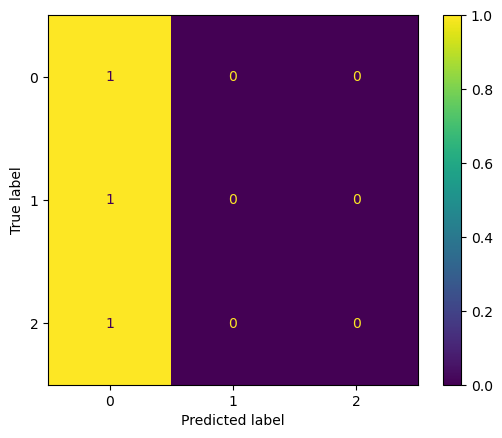

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.64295. Saving Model!
epoch 01, loss: 0.64163, acc: 0.78658, val_loss: 0.64295, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 02, loss: 0.64139, acc: 0.78658, val_loss: 0.64334, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 03, loss: 0.64096, acc: 0.78658, val_loss: 0.64419, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 04, loss: 0.64041, acc: 0.78658, val_loss: 0.64535, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 05, loss: 0.63979, acc: 0.78658, val_loss: 0.64669, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 06, loss: 0.63918, acc: 0.78658, val_loss: 0.64803, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 07, loss: 0.63860, acc: 0.78658, val_loss: 0.64923, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 08, loss: 0.63806, acc: 0.78658, val_loss: 0.65018, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 09, loss: 0.63753, acc: 0.78658, val_loss: 0.65080, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 10, loss: 0.63702, acc: 0.78658, val_loss: 0.65113, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 11, loss: 0.63650, acc: 0.78658, val_loss: 0.65133, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


epoch 12, loss: 0.63600, acc: 0.78658, val_loss: 0.65142, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 13, loss: 0.63554, acc: 0.78658, val_loss: 0.65157, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 14, loss: 0.63512, acc: 0.78658, val_loss: 0.65182, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 15, loss: 0.63474, acc: 0.78658, val_loss: 0.65225, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 16, loss: 0.63438, acc: 0.78658, val_loss: 0.65285, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 17, loss: 0.63402, acc: 0.78658, val_loss: 0.65361, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 18, loss: 0.63364, acc: 0.78658, val_loss: 0.65450, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 19, loss: 0.63325, acc: 0.78658, val_loss: 0.65547, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 20, loss: 0.63286, acc: 0.78658, val_loss: 0.65641, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 21, loss: 0.63248, acc: 0.78658, val_loss: 0.65734, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 22, loss: 0.63209, acc: 0.78658, val_loss: 0.65817, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 23, loss: 0.63171, acc: 0.78658, val_loss: 0.65888, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 24, loss: 0.63132, acc: 0.78658, val_loss: 0.65945, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 25, loss: 0.63092, acc: 0.78658, val_loss: 0.65989, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 26, loss: 0.63052, acc: 0.78658, val_loss: 0.66021, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 27, loss: 0.63011, acc: 0.78658, val_loss: 0.66047, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 28, loss: 0.62972, acc: 0.78658, val_loss: 0.66068, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 29, loss: 0.62933, acc: 0.78658, val_loss: 0.66087, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 30, loss: 0.62895, acc: 0.78658, val_loss: 0.66112, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 31, loss: 0.62858, acc: 0.78658, val_loss: 0.66136, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 32, loss: 0.62822, acc: 0.78658, val_loss: 0.66165, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.09it/s]


epoch 33, loss: 0.62787, acc: 0.78658, val_loss: 0.66198, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 34, loss: 0.62752, acc: 0.78658, val_loss: 0.66230, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 35, loss: 0.62718, acc: 0.78658, val_loss: 0.66261, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 36, loss: 0.62684, acc: 0.78658, val_loss: 0.66285, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 37, loss: 0.62651, acc: 0.78658, val_loss: 0.66306, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 38, loss: 0.62618, acc: 0.78658, val_loss: 0.66317, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 39, loss: 0.62585, acc: 0.78658, val_loss: 0.66321, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 40, loss: 0.62553, acc: 0.78658, val_loss: 0.66320, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 41, loss: 0.62521, acc: 0.78658, val_loss: 0.66312, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


epoch 42, loss: 0.62489, acc: 0.78658, val_loss: 0.66304, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 43, loss: 0.62457, acc: 0.78658, val_loss: 0.66294, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 44, loss: 0.62426, acc: 0.78658, val_loss: 0.66288, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 45, loss: 0.62394, acc: 0.78658, val_loss: 0.66283, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 46, loss: 0.62362, acc: 0.78658, val_loss: 0.66282, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 47, loss: 0.62331, acc: 0.78658, val_loss: 0.66287, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 48, loss: 0.62301, acc: 0.78658, val_loss: 0.66297, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 49, loss: 0.62270, acc: 0.78658, val_loss: 0.66305, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 50, loss: 0.62239, acc: 0.78658, val_loss: 0.66316, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 51, loss: 0.62209, acc: 0.78658, val_loss: 0.66329, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 52, loss: 0.62179, acc: 0.78658, val_loss: 0.66338, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 53, loss: 0.62150, acc: 0.78658, val_loss: 0.66346, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 54, loss: 0.62120, acc: 0.78658, val_loss: 0.66353, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 55, loss: 0.62090, acc: 0.78658, val_loss: 0.66358, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.05it/s]


epoch 56, loss: 0.62061, acc: 0.78658, val_loss: 0.66367, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 57, loss: 0.62031, acc: 0.78658, val_loss: 0.66372, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 58, loss: 0.62001, acc: 0.78658, val_loss: 0.66383, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 59, loss: 0.61972, acc: 0.78658, val_loss: 0.66398, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 60, loss: 0.61943, acc: 0.78658, val_loss: 0.66412, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 61, loss: 0.61914, acc: 0.78658, val_loss: 0.66433, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 62, loss: 0.61885, acc: 0.78658, val_loss: 0.66455, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 63, loss: 0.61857, acc: 0.78658, val_loss: 0.66479, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 64, loss: 0.61827, acc: 0.78658, val_loss: 0.66503, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]


epoch 65, loss: 0.61798, acc: 0.78658, val_loss: 0.66528, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 66, loss: 0.61769, acc: 0.78658, val_loss: 0.66553, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 67, loss: 0.61740, acc: 0.78658, val_loss: 0.66577, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 68, loss: 0.61711, acc: 0.78658, val_loss: 0.66600, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 69, loss: 0.61683, acc: 0.78658, val_loss: 0.66624, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 70, loss: 0.61654, acc: 0.78658, val_loss: 0.66648, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 71, loss: 0.61625, acc: 0.78658, val_loss: 0.66673, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 72, loss: 0.61596, acc: 0.78658, val_loss: 0.66698, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.74it/s]


epoch 73, loss: 0.61568, acc: 0.78658, val_loss: 0.66724, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 74, loss: 0.61538, acc: 0.78658, val_loss: 0.66750, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 75, loss: 0.61510, acc: 0.78730, val_loss: 0.66782, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 76, loss: 0.61480, acc: 0.78730, val_loss: 0.66809, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 77, loss: 0.61452, acc: 0.78730, val_loss: 0.66841, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 78, loss: 0.61423, acc: 0.78730, val_loss: 0.66870, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 79, loss: 0.61394, acc: 0.78730, val_loss: 0.66898, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 80, loss: 0.61365, acc: 0.78730, val_loss: 0.66928, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]

epoch 81, loss: 0.61336, acc: 0.78730, val_loss: 0.66954, val_accuracy: 0.78696

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 82, loss: 0.61306, acc: 0.78730, val_loss: 0.66982, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 83, loss: 0.61277, acc: 0.78730, val_loss: 0.67007, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 84, loss: 0.61248, acc: 0.78730, val_loss: 0.67035, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 85, loss: 0.61218, acc: 0.78730, val_loss: 0.67060, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 86, loss: 0.61189, acc: 0.78730, val_loss: 0.67086, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.20it/s]


epoch 87, loss: 0.61159, acc: 0.78730, val_loss: 0.67110, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 88, loss: 0.61130, acc: 0.78730, val_loss: 0.67134, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 89, loss: 0.61100, acc: 0.78730, val_loss: 0.67161, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 90, loss: 0.61071, acc: 0.78730, val_loss: 0.67186, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 91, loss: 0.61041, acc: 0.78730, val_loss: 0.67213, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 92, loss: 0.61011, acc: 0.78754, val_loss: 0.67237, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 93, loss: 0.60982, acc: 0.78778, val_loss: 0.67264, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.17it/s]


epoch 94, loss: 0.60952, acc: 0.78803, val_loss: 0.67287, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 95, loss: 0.60922, acc: 0.79068, val_loss: 0.67311, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


epoch 96, loss: 0.60892, acc: 0.79068, val_loss: 0.67336, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 97, loss: 0.60862, acc: 0.79068, val_loss: 0.67362, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


epoch 98, loss: 0.60832, acc: 0.79068, val_loss: 0.67388, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 99, loss: 0.60802, acc: 0.79068, val_loss: 0.67416, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 100, loss: 0.60773, acc: 0.79044, val_loss: 0.67443, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 101, loss: 0.60743, acc: 0.79068, val_loss: 0.67472, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 102, loss: 0.60713, acc: 0.79020, val_loss: 0.67499, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 103, loss: 0.60683, acc: 0.79044, val_loss: 0.67531, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 104, loss: 0.60653, acc: 0.78996, val_loss: 0.67564, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


epoch 105, loss: 0.60622, acc: 0.78996, val_loss: 0.67597, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 106, loss: 0.60591, acc: 0.78996, val_loss: 0.67633, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 107, loss: 0.60560, acc: 0.78996, val_loss: 0.67670, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 108, loss: 0.60529, acc: 0.78947, val_loss: 0.67708, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 109, loss: 0.60498, acc: 0.78947, val_loss: 0.67747, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 110, loss: 0.60467, acc: 0.78923, val_loss: 0.67787, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 111, loss: 0.60436, acc: 0.78923, val_loss: 0.67829, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 112, loss: 0.60404, acc: 0.78923, val_loss: 0.67869, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 113, loss: 0.60373, acc: 0.78923, val_loss: 0.67912, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 114, loss: 0.60341, acc: 0.78923, val_loss: 0.67954, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 115, loss: 0.60308, acc: 0.78923, val_loss: 0.67998, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 116, loss: 0.60276, acc: 0.78923, val_loss: 0.68045, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 117, loss: 0.60244, acc: 0.78923, val_loss: 0.68090, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.38it/s]


epoch 118, loss: 0.60211, acc: 0.78947, val_loss: 0.68136, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 119, loss: 0.60179, acc: 0.78947, val_loss: 0.68181, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 120, loss: 0.60147, acc: 0.78947, val_loss: 0.68230, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 121, loss: 0.60113, acc: 0.78947, val_loss: 0.68273, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 122, loss: 0.60080, acc: 0.78947, val_loss: 0.68322, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 123, loss: 0.60046, acc: 0.78947, val_loss: 0.68369, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 124, loss: 0.60013, acc: 0.78947, val_loss: 0.68416, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 125, loss: 0.59979, acc: 0.78947, val_loss: 0.68463, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 126, loss: 0.59945, acc: 0.78996, val_loss: 0.68511, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 127, loss: 0.59910, acc: 0.78996, val_loss: 0.68555, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 128, loss: 0.59875, acc: 0.78996, val_loss: 0.68602, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]


epoch 129, loss: 0.59841, acc: 0.78996, val_loss: 0.68651, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 130, loss: 0.59806, acc: 0.78996, val_loss: 0.68694, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 131, loss: 0.59770, acc: 0.78996, val_loss: 0.68740, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.12it/s]


epoch 132, loss: 0.59735, acc: 0.78996, val_loss: 0.68787, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 133, loss: 0.59699, acc: 0.78996, val_loss: 0.68832, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 134, loss: 0.59662, acc: 0.78996, val_loss: 0.68877, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 135, loss: 0.59626, acc: 0.78996, val_loss: 0.68919, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 136, loss: 0.59589, acc: 0.78996, val_loss: 0.68963, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 137, loss: 0.59553, acc: 0.78972, val_loss: 0.69008, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]


epoch 138, loss: 0.59516, acc: 0.78972, val_loss: 0.69053, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 139, loss: 0.59479, acc: 0.78972, val_loss: 0.69104, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 140, loss: 0.59442, acc: 0.78972, val_loss: 0.69153, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 141, loss: 0.59403, acc: 0.78972, val_loss: 0.69205, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 142, loss: 0.59366, acc: 0.78972, val_loss: 0.69261, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 143, loss: 0.59328, acc: 0.78972, val_loss: 0.69317, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 144, loss: 0.59290, acc: 0.78996, val_loss: 0.69375, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 145, loss: 0.59251, acc: 0.78996, val_loss: 0.69433, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 146, loss: 0.59212, acc: 0.78996, val_loss: 0.69487, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 147, loss: 0.59173, acc: 0.78996, val_loss: 0.69541, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 148, loss: 0.59133, acc: 0.78996, val_loss: 0.69594, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 149, loss: 0.59093, acc: 0.78996, val_loss: 0.69648, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 150, loss: 0.59054, acc: 0.78996, val_loss: 0.69707, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 151, loss: 0.59013, acc: 0.78996, val_loss: 0.69766, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.06it/s]


epoch 152, loss: 0.58973, acc: 0.79020, val_loss: 0.69824, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 153, loss: 0.58933, acc: 0.79020, val_loss: 0.69887, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 154, loss: 0.58892, acc: 0.79020, val_loss: 0.69953, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 155, loss: 0.58851, acc: 0.79020, val_loss: 0.70015, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 156, loss: 0.58809, acc: 0.78972, val_loss: 0.70079, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.15it/s]


epoch 157, loss: 0.58768, acc: 0.78947, val_loss: 0.70145, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 158, loss: 0.58726, acc: 0.78996, val_loss: 0.70205, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


epoch 159, loss: 0.58684, acc: 0.78996, val_loss: 0.70265, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 160, loss: 0.58642, acc: 0.78996, val_loss: 0.70336, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 161, loss: 0.58600, acc: 0.78996, val_loss: 0.70398, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 162, loss: 0.58557, acc: 0.78996, val_loss: 0.70461, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 163, loss: 0.58513, acc: 0.78996, val_loss: 0.70522, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 164, loss: 0.58469, acc: 0.79020, val_loss: 0.70585, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 165, loss: 0.58426, acc: 0.79020, val_loss: 0.70646, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 166, loss: 0.58381, acc: 0.79020, val_loss: 0.70713, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 167, loss: 0.58337, acc: 0.79020, val_loss: 0.70783, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 168, loss: 0.58292, acc: 0.79020, val_loss: 0.70848, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.74it/s]


epoch 169, loss: 0.58247, acc: 0.79020, val_loss: 0.70910, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 170, loss: 0.58201, acc: 0.79020, val_loss: 0.70981, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 171, loss: 0.58155, acc: 0.78996, val_loss: 0.71051, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 172, loss: 0.58109, acc: 0.78996, val_loss: 0.71123, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 173, loss: 0.58063, acc: 0.78996, val_loss: 0.71203, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 174, loss: 0.58016, acc: 0.78996, val_loss: 0.71282, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 175, loss: 0.57968, acc: 0.78996, val_loss: 0.71374, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.62it/s]


epoch 176, loss: 0.57921, acc: 0.78996, val_loss: 0.71460, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.07it/s]


epoch 177, loss: 0.57873, acc: 0.78996, val_loss: 0.71551, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.39it/s]


epoch 178, loss: 0.57825, acc: 0.78996, val_loss: 0.71648, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 179, loss: 0.57776, acc: 0.78996, val_loss: 0.71737, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


epoch 180, loss: 0.57728, acc: 0.78996, val_loss: 0.71829, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 181, loss: 0.57679, acc: 0.78996, val_loss: 0.71922, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 182, loss: 0.57629, acc: 0.79116, val_loss: 0.72013, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 183, loss: 0.57578, acc: 0.79141, val_loss: 0.72103, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 184, loss: 0.57529, acc: 0.79141, val_loss: 0.72194, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 185, loss: 0.57478, acc: 0.79141, val_loss: 0.72284, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 186, loss: 0.57426, acc: 0.79141, val_loss: 0.72384, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 187, loss: 0.57374, acc: 0.79116, val_loss: 0.72490, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 188, loss: 0.57322, acc: 0.79092, val_loss: 0.72592, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 189, loss: 0.57270, acc: 0.79092, val_loss: 0.72693, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 190, loss: 0.57216, acc: 0.79092, val_loss: 0.72799, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 191, loss: 0.57163, acc: 0.79092, val_loss: 0.72900, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 192, loss: 0.57109, acc: 0.79116, val_loss: 0.73006, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 193, loss: 0.57055, acc: 0.79116, val_loss: 0.73116, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.35it/s]


epoch 194, loss: 0.57001, acc: 0.79116, val_loss: 0.73223, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 195, loss: 0.56946, acc: 0.79141, val_loss: 0.73329, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 196, loss: 0.56891, acc: 0.79141, val_loss: 0.73436, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 197, loss: 0.56835, acc: 0.79141, val_loss: 0.73540, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 198, loss: 0.56779, acc: 0.79165, val_loss: 0.73651, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 199, loss: 0.56721, acc: 0.79165, val_loss: 0.73758, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 200, loss: 0.56665, acc: 0.79165, val_loss: 0.73861, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


epoch 201, loss: 0.56608, acc: 0.79165, val_loss: 0.73977, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 202, loss: 0.56550, acc: 0.79165, val_loss: 0.74083, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 203, loss: 0.56491, acc: 0.79189, val_loss: 0.74200, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 204, loss: 0.56433, acc: 0.79189, val_loss: 0.74325, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 205, loss: 0.56374, acc: 0.79189, val_loss: 0.74439, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 206, loss: 0.56312, acc: 0.79213, val_loss: 0.74556, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 207, loss: 0.56251, acc: 0.79237, val_loss: 0.74670, val_accuracy: 0.78261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 208, loss: 0.56190, acc: 0.79310, val_loss: 0.74783, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 209, loss: 0.56129, acc: 0.79334, val_loss: 0.74901, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 210, loss: 0.56066, acc: 0.79334, val_loss: 0.75021, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 211, loss: 0.56003, acc: 0.79334, val_loss: 0.75140, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 212, loss: 0.55940, acc: 0.79334, val_loss: 0.75258, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 213, loss: 0.55876, acc: 0.79334, val_loss: 0.75375, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 214, loss: 0.55813, acc: 0.79430, val_loss: 0.75491, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


epoch 215, loss: 0.55749, acc: 0.79479, val_loss: 0.75597, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 216, loss: 0.55683, acc: 0.79479, val_loss: 0.75713, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 217, loss: 0.55617, acc: 0.79479, val_loss: 0.75822, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 218, loss: 0.55551, acc: 0.79503, val_loss: 0.75936, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 219, loss: 0.55484, acc: 0.79503, val_loss: 0.76054, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 220, loss: 0.55416, acc: 0.79527, val_loss: 0.76157, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 221, loss: 0.55350, acc: 0.79527, val_loss: 0.76286, val_accuracy: 0.78261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]


epoch 222, loss: 0.55283, acc: 0.79551, val_loss: 0.76422, val_accuracy: 0.78261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 223, loss: 0.55216, acc: 0.79551, val_loss: 0.76560, val_accuracy: 0.78261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 224, loss: 0.55146, acc: 0.79551, val_loss: 0.76702, val_accuracy: 0.78261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.64it/s]


epoch 225, loss: 0.55079, acc: 0.79551, val_loss: 0.76816, val_accuracy: 0.78261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 226, loss: 0.55009, acc: 0.79599, val_loss: 0.76936, val_accuracy: 0.78261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 227, loss: 0.54939, acc: 0.79599, val_loss: 0.77054, val_accuracy: 0.78261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 228, loss: 0.54868, acc: 0.79648, val_loss: 0.77166, val_accuracy: 0.78261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 229, loss: 0.54795, acc: 0.79623, val_loss: 0.77265, val_accuracy: 0.78261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 230, loss: 0.54723, acc: 0.79623, val_loss: 0.77392, val_accuracy: 0.78261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 231, loss: 0.54652, acc: 0.79623, val_loss: 0.77551, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 232, loss: 0.54580, acc: 0.79599, val_loss: 0.77730, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 233, loss: 0.54508, acc: 0.79599, val_loss: 0.77884, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]


epoch 234, loss: 0.54436, acc: 0.79623, val_loss: 0.78011, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 235, loss: 0.54361, acc: 0.79623, val_loss: 0.78131, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 236, loss: 0.54287, acc: 0.79648, val_loss: 0.78256, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 237, loss: 0.54214, acc: 0.79648, val_loss: 0.78385, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 238, loss: 0.54142, acc: 0.79696, val_loss: 0.78511, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 239, loss: 0.54070, acc: 0.79720, val_loss: 0.78638, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 240, loss: 0.53997, acc: 0.79744, val_loss: 0.78815, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 241, loss: 0.53923, acc: 0.79744, val_loss: 0.78995, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 242, loss: 0.53849, acc: 0.79768, val_loss: 0.79192, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 243, loss: 0.53774, acc: 0.79792, val_loss: 0.79370, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 244, loss: 0.53698, acc: 0.79792, val_loss: 0.79557, val_accuracy: 0.77391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 245, loss: 0.53623, acc: 0.79841, val_loss: 0.79789, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 246, loss: 0.53550, acc: 0.79889, val_loss: 0.80000, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 247, loss: 0.53476, acc: 0.79889, val_loss: 0.80200, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 248, loss: 0.53401, acc: 0.79889, val_loss: 0.80387, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 249, loss: 0.53327, acc: 0.79889, val_loss: 0.80573, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


epoch 250, loss: 0.53253, acc: 0.79889, val_loss: 0.80772, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 251, loss: 0.53177, acc: 0.79865, val_loss: 0.80990, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 252, loss: 0.53102, acc: 0.79865, val_loss: 0.81212, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 253, loss: 0.53024, acc: 0.79865, val_loss: 0.81463, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 254, loss: 0.52947, acc: 0.79889, val_loss: 0.81701, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 255, loss: 0.52868, acc: 0.79913, val_loss: 0.81901, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 256, loss: 0.52792, acc: 0.79889, val_loss: 0.82093, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]


epoch 257, loss: 0.52716, acc: 0.79913, val_loss: 0.82284, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 258, loss: 0.52639, acc: 0.79937, val_loss: 0.82532, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 259, loss: 0.52562, acc: 0.79913, val_loss: 0.82816, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 260, loss: 0.52486, acc: 0.79986, val_loss: 0.83087, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 261, loss: 0.52411, acc: 0.80058, val_loss: 0.83307, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.74it/s]


epoch 262, loss: 0.52334, acc: 0.80130, val_loss: 0.83465, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


epoch 263, loss: 0.52259, acc: 0.80155, val_loss: 0.83613, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 264, loss: 0.52185, acc: 0.80155, val_loss: 0.83838, val_accuracy: 0.76522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.35it/s]


epoch 265, loss: 0.52107, acc: 0.80082, val_loss: 0.84154, val_accuracy: 0.76304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 266, loss: 0.52032, acc: 0.80082, val_loss: 0.84457, val_accuracy: 0.75000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 267, loss: 0.51956, acc: 0.80082, val_loss: 0.84774, val_accuracy: 0.75000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 268, loss: 0.51881, acc: 0.80155, val_loss: 0.85033, val_accuracy: 0.75000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 269, loss: 0.51804, acc: 0.80155, val_loss: 0.85278, val_accuracy: 0.75000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 270, loss: 0.51728, acc: 0.80155, val_loss: 0.85525, val_accuracy: 0.75000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 271, loss: 0.51652, acc: 0.80106, val_loss: 0.85836, val_accuracy: 0.75000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 272, loss: 0.51577, acc: 0.80130, val_loss: 0.86187, val_accuracy: 0.75000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.38it/s]


epoch 273, loss: 0.51502, acc: 0.80130, val_loss: 0.86521, val_accuracy: 0.74783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 274, loss: 0.51424, acc: 0.80130, val_loss: 0.86744, val_accuracy: 0.74565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 275, loss: 0.51348, acc: 0.80130, val_loss: 0.87033, val_accuracy: 0.74565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 276, loss: 0.51273, acc: 0.80130, val_loss: 0.87365, val_accuracy: 0.74565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 277, loss: 0.51195, acc: 0.80155, val_loss: 0.87731, val_accuracy: 0.74565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 278, loss: 0.51117, acc: 0.80251, val_loss: 0.88042, val_accuracy: 0.70870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 279, loss: 0.51042, acc: 0.80275, val_loss: 0.88323, val_accuracy: 0.70870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 280, loss: 0.50964, acc: 0.80299, val_loss: 0.88570, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.13it/s]


epoch 281, loss: 0.50885, acc: 0.80227, val_loss: 0.88889, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.75it/s]


epoch 282, loss: 0.50807, acc: 0.80251, val_loss: 0.89192, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 283, loss: 0.50731, acc: 0.80299, val_loss: 0.89555, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 284, loss: 0.50652, acc: 0.80468, val_loss: 0.89995, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 285, loss: 0.50573, acc: 0.80468, val_loss: 0.90423, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 286, loss: 0.50493, acc: 0.80517, val_loss: 0.90807, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 287, loss: 0.50412, acc: 0.80613, val_loss: 0.91046, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 288, loss: 0.50331, acc: 0.80637, val_loss: 0.91423, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 289, loss: 0.50254, acc: 0.80662, val_loss: 0.91764, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 290, loss: 0.50173, acc: 0.80686, val_loss: 0.92040, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 291, loss: 0.50097, acc: 0.80758, val_loss: 0.92373, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 292, loss: 0.50018, acc: 0.80686, val_loss: 0.92764, val_accuracy: 0.70000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 293, loss: 0.49941, acc: 0.80686, val_loss: 0.93211, val_accuracy: 0.69783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 294, loss: 0.49866, acc: 0.80758, val_loss: 0.93536, val_accuracy: 0.69783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 295, loss: 0.49788, acc: 0.80734, val_loss: 0.93703, val_accuracy: 0.69348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 296, loss: 0.49710, acc: 0.80758, val_loss: 0.93937, val_accuracy: 0.69348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 297, loss: 0.49633, acc: 0.80806, val_loss: 0.94249, val_accuracy: 0.69348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 298, loss: 0.49558, acc: 0.80879, val_loss: 0.94635, val_accuracy: 0.69130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 299, loss: 0.49481, acc: 0.80903, val_loss: 0.95031, val_accuracy: 0.69130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 300, loss: 0.49403, acc: 0.80879, val_loss: 0.95497, val_accuracy: 0.69130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 301, loss: 0.49326, acc: 0.80903, val_loss: 0.96028, val_accuracy: 0.69130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 302, loss: 0.49249, acc: 0.81024, val_loss: 0.96282, val_accuracy: 0.69130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 303, loss: 0.49169, acc: 0.80927, val_loss: 0.96560, val_accuracy: 0.67174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 304, loss: 0.49091, acc: 0.80951, val_loss: 0.96997, val_accuracy: 0.67174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 305, loss: 0.49013, acc: 0.80975, val_loss: 0.97417, val_accuracy: 0.67174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]


epoch 306, loss: 0.48934, acc: 0.81096, val_loss: 0.97761, val_accuracy: 0.67174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 307, loss: 0.48856, acc: 0.81072, val_loss: 0.98146, val_accuracy: 0.67174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 308, loss: 0.48778, acc: 0.81096, val_loss: 0.98646, val_accuracy: 0.66957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 309, loss: 0.48699, acc: 0.81096, val_loss: 0.99025, val_accuracy: 0.66087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 310, loss: 0.48623, acc: 0.81217, val_loss: 0.99407, val_accuracy: 0.66087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 311, loss: 0.48545, acc: 0.81193, val_loss: 0.99961, val_accuracy: 0.66087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 312, loss: 0.48467, acc: 0.81362, val_loss: 1.00475, val_accuracy: 0.57391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.25it/s]


epoch 313, loss: 0.48390, acc: 0.81386, val_loss: 1.00782, val_accuracy: 0.57391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 314, loss: 0.48315, acc: 0.81410, val_loss: 1.01237, val_accuracy: 0.57391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 315, loss: 0.48238, acc: 0.81386, val_loss: 1.01821, val_accuracy: 0.57174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 316, loss: 0.48160, acc: 0.81362, val_loss: 1.02261, val_accuracy: 0.57174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 317, loss: 0.48082, acc: 0.81386, val_loss: 1.02675, val_accuracy: 0.57174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 318, loss: 0.48005, acc: 0.81458, val_loss: 1.03147, val_accuracy: 0.57174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 319, loss: 0.47927, acc: 0.81458, val_loss: 1.03563, val_accuracy: 0.57174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 320, loss: 0.47851, acc: 0.81458, val_loss: 1.03974, val_accuracy: 0.57174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.67it/s]


epoch 321, loss: 0.47780, acc: 0.81507, val_loss: 1.04528, val_accuracy: 0.57174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 322, loss: 0.47697, acc: 0.81507, val_loss: 1.05284, val_accuracy: 0.56957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 323, loss: 0.47619, acc: 0.81434, val_loss: 1.05892, val_accuracy: 0.56957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 324, loss: 0.47542, acc: 0.81507, val_loss: 1.06372, val_accuracy: 0.56957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 325, loss: 0.47465, acc: 0.81579, val_loss: 1.06821, val_accuracy: 0.56522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.29it/s]


epoch 326, loss: 0.47388, acc: 0.81651, val_loss: 1.07031, val_accuracy: 0.56957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 327, loss: 0.47305, acc: 0.81724, val_loss: 1.07532, val_accuracy: 0.56522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 328, loss: 0.47227, acc: 0.81772, val_loss: 1.08211, val_accuracy: 0.56522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 329, loss: 0.47146, acc: 0.81869, val_loss: 1.08527, val_accuracy: 0.56522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 330, loss: 0.47067, acc: 0.82255, val_loss: 1.08674, val_accuracy: 0.56522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 331, loss: 0.46988, acc: 0.82231, val_loss: 1.09317, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 332, loss: 0.46909, acc: 0.82255, val_loss: 1.10181, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 333, loss: 0.46832, acc: 0.82255, val_loss: 1.10556, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 334, loss: 0.46753, acc: 0.82231, val_loss: 1.11418, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 335, loss: 0.46675, acc: 0.82303, val_loss: 1.11847, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 336, loss: 0.46598, acc: 0.82231, val_loss: 1.11832, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]


epoch 337, loss: 0.46520, acc: 0.82303, val_loss: 1.12729, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 338, loss: 0.46442, acc: 0.82279, val_loss: 1.13904, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 339, loss: 0.46367, acc: 0.82327, val_loss: 1.14286, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 340, loss: 0.46290, acc: 0.82303, val_loss: 1.14502, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 341, loss: 0.46209, acc: 0.82327, val_loss: 1.14646, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 342, loss: 0.46132, acc: 0.82448, val_loss: 1.15303, val_accuracy: 0.50000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 343, loss: 0.46054, acc: 0.82400, val_loss: 1.16342, val_accuracy: 0.50000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 344, loss: 0.45979, acc: 0.82448, val_loss: 1.16704, val_accuracy: 0.50000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 345, loss: 0.45905, acc: 0.82496, val_loss: 1.17426, val_accuracy: 0.49783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


epoch 346, loss: 0.45832, acc: 0.82569, val_loss: 1.18461, val_accuracy: 0.40435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 347, loss: 0.45756, acc: 0.82496, val_loss: 1.18158, val_accuracy: 0.40435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 348, loss: 0.45674, acc: 0.82545, val_loss: 1.18627, val_accuracy: 0.40435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 349, loss: 0.45600, acc: 0.82593, val_loss: 1.19670, val_accuracy: 0.40435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 350, loss: 0.45532, acc: 0.82641, val_loss: 1.19791, val_accuracy: 0.40435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 351, loss: 0.45461, acc: 0.82617, val_loss: 1.20871, val_accuracy: 0.39348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 352, loss: 0.45381, acc: 0.82521, val_loss: 1.21074, val_accuracy: 0.39348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]


epoch 353, loss: 0.45302, acc: 0.82496, val_loss: 1.21646, val_accuracy: 0.39130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 354, loss: 0.45229, acc: 0.82521, val_loss: 1.22781, val_accuracy: 0.39130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 355, loss: 0.45163, acc: 0.82690, val_loss: 1.23109, val_accuracy: 0.39130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 356, loss: 0.45083, acc: 0.82496, val_loss: 1.24217, val_accuracy: 0.39130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 357, loss: 0.45007, acc: 0.82665, val_loss: 1.23993, val_accuracy: 0.39130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 358, loss: 0.44929, acc: 0.82569, val_loss: 1.24421, val_accuracy: 0.39130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 359, loss: 0.44854, acc: 0.82593, val_loss: 1.25142, val_accuracy: 0.38913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 360, loss: 0.44784, acc: 0.82665, val_loss: 1.25554, val_accuracy: 0.38913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


epoch 361, loss: 0.44713, acc: 0.82617, val_loss: 1.26832, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 362, loss: 0.44646, acc: 0.82641, val_loss: 1.26700, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 363, loss: 0.44569, acc: 0.82641, val_loss: 1.27864, val_accuracy: 0.37391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 364, loss: 0.44489, acc: 0.82810, val_loss: 1.28350, val_accuracy: 0.37391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.15it/s]


epoch 365, loss: 0.44415, acc: 0.82786, val_loss: 1.28795, val_accuracy: 0.37174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


epoch 366, loss: 0.44343, acc: 0.82665, val_loss: 1.29541, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 367, loss: 0.44268, acc: 0.82859, val_loss: 1.29432, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 368, loss: 0.44208, acc: 0.82641, val_loss: 1.30765, val_accuracy: 0.35870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 369, loss: 0.44154, acc: 0.82955, val_loss: 1.29491, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 370, loss: 0.44112, acc: 0.82641, val_loss: 1.32836, val_accuracy: 0.35217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 371, loss: 0.44085, acc: 0.82762, val_loss: 1.30451, val_accuracy: 0.36087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


epoch 372, loss: 0.44053, acc: 0.82641, val_loss: 1.34567, val_accuracy: 0.35000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 373, loss: 0.43953, acc: 0.82690, val_loss: 1.31755, val_accuracy: 0.36087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 374, loss: 0.43843, acc: 0.82786, val_loss: 1.33936, val_accuracy: 0.35000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 375, loss: 0.43732, acc: 0.83003, val_loss: 1.33593, val_accuracy: 0.35652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 376, loss: 0.43648, acc: 0.83052, val_loss: 1.34651, val_accuracy: 0.35000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 377, loss: 0.43565, acc: 0.83076, val_loss: 1.35638, val_accuracy: 0.35000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 378, loss: 0.43515, acc: 0.83076, val_loss: 1.35195, val_accuracy: 0.35000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 379, loss: 0.43462, acc: 0.82883, val_loss: 1.38105, val_accuracy: 0.35000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 380, loss: 0.43450, acc: 0.82738, val_loss: 1.34609, val_accuracy: 0.35435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 381, loss: 0.43471, acc: 0.82665, val_loss: 1.40031, val_accuracy: 0.35000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 382, loss: 0.43514, acc: 0.82931, val_loss: 1.33979, val_accuracy: 0.35870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 383, loss: 0.43604, acc: 0.82545, val_loss: 1.42407, val_accuracy: 0.33043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 384, loss: 0.43529, acc: 0.82931, val_loss: 1.35619, val_accuracy: 0.35652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 385, loss: 0.43384, acc: 0.82569, val_loss: 1.41226, val_accuracy: 0.35000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 386, loss: 0.43126, acc: 0.83172, val_loss: 1.38174, val_accuracy: 0.35000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 387, loss: 0.42952, acc: 0.83076, val_loss: 1.39794, val_accuracy: 0.35000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 388, loss: 0.42849, acc: 0.83221, val_loss: 1.41679, val_accuracy: 0.35000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 389, loss: 0.42811, acc: 0.83269, val_loss: 1.39368, val_accuracy: 0.35000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 390, loss: 0.42816, acc: 0.83172, val_loss: 1.44247, val_accuracy: 0.32391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 391, loss: 0.42854, acc: 0.83197, val_loss: 1.38503, val_accuracy: 0.35000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 392, loss: 0.42968, acc: 0.82762, val_loss: 1.47171, val_accuracy: 0.32174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.75it/s]

epoch 393, loss: 0.42982, acc: 0.83245, val_loss: 1.38334, val_accuracy: 0.35217

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 394, loss: 0.43109, acc: 0.82641, val_loss: 1.48176, val_accuracy: 0.32826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 395, loss: 0.42927, acc: 0.83341, val_loss: 1.39604, val_accuracy: 0.35217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 396, loss: 0.42773, acc: 0.82834, val_loss: 1.46811, val_accuracy: 0.32391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 397, loss: 0.42441, acc: 0.83438, val_loss: 1.43483, val_accuracy: 0.34348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 398, loss: 0.42242, acc: 0.83245, val_loss: 1.44223, val_accuracy: 0.34348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 399, loss: 0.42173, acc: 0.83341, val_loss: 1.47657, val_accuracy: 0.32391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 400, loss: 0.42204, acc: 0.83390, val_loss: 1.42383, val_accuracy: 0.34348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 401, loss: 0.42375, acc: 0.83052, val_loss: 1.51196, val_accuracy: 0.33043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 402, loss: 0.42538, acc: 0.83486, val_loss: 1.39876, val_accuracy: 0.34783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 403, loss: 0.42869, acc: 0.83003, val_loss: 1.53448, val_accuracy: 0.33043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 404, loss: 0.42620, acc: 0.83679, val_loss: 1.42821, val_accuracy: 0.34565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 405, loss: 0.42399, acc: 0.82979, val_loss: 1.51291, val_accuracy: 0.32174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


epoch 406, loss: 0.41917, acc: 0.83655, val_loss: 1.48454, val_accuracy: 0.32391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 407, loss: 0.41701, acc: 0.83462, val_loss: 1.46069, val_accuracy: 0.34348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 408, loss: 0.41751, acc: 0.83535, val_loss: 1.53036, val_accuracy: 0.33261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


epoch 409, loss: 0.41963, acc: 0.83655, val_loss: 1.43024, val_accuracy: 0.34348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 410, loss: 0.42315, acc: 0.83172, val_loss: 1.56639, val_accuracy: 0.29348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 411, loss: 0.42195, acc: 0.83921, val_loss: 1.45354, val_accuracy: 0.34348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


epoch 412, loss: 0.42093, acc: 0.83293, val_loss: 1.54941, val_accuracy: 0.32391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.63it/s]


epoch 413, loss: 0.41606, acc: 0.83776, val_loss: 1.49796, val_accuracy: 0.32609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 414, loss: 0.41330, acc: 0.83776, val_loss: 1.49107, val_accuracy: 0.34348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 415, loss: 0.41286, acc: 0.83776, val_loss: 1.54152, val_accuracy: 0.32609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 416, loss: 0.41382, acc: 0.83945, val_loss: 1.46990, val_accuracy: 0.34348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 417, loss: 0.41594, acc: 0.83462, val_loss: 1.58464, val_accuracy: 0.29130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 418, loss: 0.41594, acc: 0.84017, val_loss: 1.47631, val_accuracy: 0.34348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 419, loss: 0.41629, acc: 0.83438, val_loss: 1.57892, val_accuracy: 0.28696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.13it/s]


epoch 420, loss: 0.41388, acc: 0.83993, val_loss: 1.49097, val_accuracy: 0.34565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 421, loss: 0.41196, acc: 0.83486, val_loss: 1.55353, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 422, loss: 0.40935, acc: 0.84066, val_loss: 1.54118, val_accuracy: 0.32391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 423, loss: 0.40831, acc: 0.84066, val_loss: 1.51810, val_accuracy: 0.32609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 424, loss: 0.40836, acc: 0.83897, val_loss: 1.57261, val_accuracy: 0.28696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 425, loss: 0.40921, acc: 0.84090, val_loss: 1.49586, val_accuracy: 0.34565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.26it/s]


epoch 426, loss: 0.41092, acc: 0.83583, val_loss: 1.61216, val_accuracy: 0.28261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 427, loss: 0.41153, acc: 0.84355, val_loss: 1.49448, val_accuracy: 0.34565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 428, loss: 0.41324, acc: 0.83583, val_loss: 1.62281, val_accuracy: 0.28261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 429, loss: 0.41125, acc: 0.84138, val_loss: 1.50674, val_accuracy: 0.34565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 430, loss: 0.40982, acc: 0.83583, val_loss: 1.60120, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 431, loss: 0.40643, acc: 0.84283, val_loss: 1.54583, val_accuracy: 0.32609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 432, loss: 0.40428, acc: 0.83993, val_loss: 1.56655, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


epoch 433, loss: 0.40309, acc: 0.84138, val_loss: 1.59082, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 434, loss: 0.40314, acc: 0.84331, val_loss: 1.54675, val_accuracy: 0.32826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 435, loss: 0.40405, acc: 0.83969, val_loss: 1.63646, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 436, loss: 0.40548, acc: 0.84380, val_loss: 1.52141, val_accuracy: 0.34565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 437, loss: 0.40808, acc: 0.83607, val_loss: 1.65884, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 438, loss: 0.40899, acc: 0.84524, val_loss: 1.50396, val_accuracy: 0.34783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.77it/s]


epoch 439, loss: 0.41238, acc: 0.83631, val_loss: 1.66952, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 440, loss: 0.40758, acc: 0.84476, val_loss: 1.54777, val_accuracy: 0.34565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 441, loss: 0.40328, acc: 0.83897, val_loss: 1.60679, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 442, loss: 0.39950, acc: 0.84428, val_loss: 1.59894, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 443, loss: 0.39892, acc: 0.84452, val_loss: 1.55266, val_accuracy: 0.28696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 444, loss: 0.40015, acc: 0.84017, val_loss: 1.65834, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 445, loss: 0.40213, acc: 0.84476, val_loss: 1.54063, val_accuracy: 0.34565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 446, loss: 0.40602, acc: 0.83752, val_loss: 1.70281, val_accuracy: 0.27174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 447, loss: 0.40566, acc: 0.84621, val_loss: 1.53840, val_accuracy: 0.34783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.62it/s]


epoch 448, loss: 0.40482, acc: 0.83800, val_loss: 1.66151, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 449, loss: 0.39980, acc: 0.84645, val_loss: 1.58870, val_accuracy: 0.28261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 450, loss: 0.39670, acc: 0.84355, val_loss: 1.62475, val_accuracy: 0.28261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.20it/s]


epoch 451, loss: 0.39500, acc: 0.84645, val_loss: 1.65685, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 452, loss: 0.39556, acc: 0.84718, val_loss: 1.57916, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 453, loss: 0.39781, acc: 0.84090, val_loss: 1.70095, val_accuracy: 0.26957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 454, loss: 0.39990, acc: 0.84935, val_loss: 1.55311, val_accuracy: 0.34565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 455, loss: 0.40234, acc: 0.83897, val_loss: 1.71223, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 456, loss: 0.40010, acc: 0.84935, val_loss: 1.57349, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


epoch 457, loss: 0.39894, acc: 0.84017, val_loss: 1.68892, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 458, loss: 0.39425, acc: 0.84718, val_loss: 1.63372, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 459, loss: 0.39144, acc: 0.84452, val_loss: 1.62258, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 460, loss: 0.39134, acc: 0.84428, val_loss: 1.68664, val_accuracy: 0.27609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.38it/s]


epoch 461, loss: 0.39305, acc: 0.84838, val_loss: 1.58631, val_accuracy: 0.28913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 462, loss: 0.39639, acc: 0.84259, val_loss: 1.73828, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


epoch 463, loss: 0.39715, acc: 0.84862, val_loss: 1.58127, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.05it/s]


epoch 464, loss: 0.39932, acc: 0.83897, val_loss: 1.73504, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 465, loss: 0.39520, acc: 0.85104, val_loss: 1.60909, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 466, loss: 0.39208, acc: 0.84259, val_loss: 1.68156, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 467, loss: 0.38853, acc: 0.84911, val_loss: 1.67341, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 468, loss: 0.38754, acc: 0.84693, val_loss: 1.63509, val_accuracy: 0.28261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 469, loss: 0.38881, acc: 0.84476, val_loss: 1.72827, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 470, loss: 0.39078, acc: 0.85128, val_loss: 1.59861, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 471, loss: 0.39406, acc: 0.84259, val_loss: 1.75123, val_accuracy: 0.27174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 472, loss: 0.39390, acc: 0.84838, val_loss: 1.59375, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]


epoch 473, loss: 0.39496, acc: 0.84235, val_loss: 1.74794, val_accuracy: 0.26957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 474, loss: 0.38996, acc: 0.85152, val_loss: 1.65631, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 475, loss: 0.38641, acc: 0.84645, val_loss: 1.68687, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 476, loss: 0.38442, acc: 0.84790, val_loss: 1.71045, val_accuracy: 0.27174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 477, loss: 0.38493, acc: 0.85031, val_loss: 1.63466, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 478, loss: 0.38749, acc: 0.84307, val_loss: 1.77012, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 479, loss: 0.38941, acc: 0.85152, val_loss: 1.61933, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 480, loss: 0.39332, acc: 0.84259, val_loss: 1.78913, val_accuracy: 0.20435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]


epoch 481, loss: 0.39119, acc: 0.85273, val_loss: 1.62142, val_accuracy: 0.31087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 482, loss: 0.39005, acc: 0.84355, val_loss: 1.75006, val_accuracy: 0.26957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 483, loss: 0.38480, acc: 0.85176, val_loss: 1.69075, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 484, loss: 0.38173, acc: 0.84693, val_loss: 1.70184, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 485, loss: 0.38117, acc: 0.84790, val_loss: 1.76040, val_accuracy: 0.27174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 486, loss: 0.38265, acc: 0.85176, val_loss: 1.65374, val_accuracy: 0.29565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 487, loss: 0.38592, acc: 0.84573, val_loss: 1.79917, val_accuracy: 0.20652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 488, loss: 0.38709, acc: 0.85466, val_loss: 1.63753, val_accuracy: 0.31087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.34it/s]


epoch 489, loss: 0.38910, acc: 0.84331, val_loss: 1.79970, val_accuracy: 0.20217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 490, loss: 0.38534, acc: 0.85418, val_loss: 1.68003, val_accuracy: 0.29565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 491, loss: 0.38276, acc: 0.84766, val_loss: 1.76947, val_accuracy: 0.27391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.82it/s]


epoch 492, loss: 0.37922, acc: 0.85007, val_loss: 1.74709, val_accuracy: 0.27609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 493, loss: 0.37798, acc: 0.85104, val_loss: 1.70352, val_accuracy: 0.29348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 494, loss: 0.37876, acc: 0.85056, val_loss: 1.78324, val_accuracy: 0.20652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 495, loss: 0.38070, acc: 0.85514, val_loss: 1.66311, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 496, loss: 0.38393, acc: 0.84524, val_loss: 1.83604, val_accuracy: 0.20870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 497, loss: 0.38390, acc: 0.85466, val_loss: 1.68443, val_accuracy: 0.29348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.26it/s]


epoch 498, loss: 0.38531, acc: 0.84380, val_loss: 1.83706, val_accuracy: 0.20870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 499, loss: 0.38113, acc: 0.85321, val_loss: 1.71276, val_accuracy: 0.29565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 500, loss: 0.37783, acc: 0.84887, val_loss: 1.76555, val_accuracy: 0.20870
4번째 교차검증
evaluation loss: 0.64295, evaluation accuracy: 0.78696
(5, 460)
(460, 5)
Learning rate set to 0.055397
0:	learn: 1.0454376	total: 8.26ms	remaining: 8.25s
1:	learn: 0.9992870	total: 14.9ms	remaining: 7.44s
2:	learn: 0.9588400	total: 24.1ms	remaining: 8.02s
3:	learn: 0.9231107	total: 30.7ms	remaining: 7.63s
4:	learn: 0.8913422	total: 37.2ms	remaining: 7.41s
5:	learn: 0.8629404	total: 44.3ms	remaining: 7.33s
6:	learn: 0.8374301	total: 50.2ms	remaining: 7.13s
7:	learn: 0.8144257	total: 57.9ms	remaining: 7.18s
8:	learn: 0.7936090	total: 63.8ms	remaining: 7.03s
9:	learn: 0.7747149	total: 70.3ms	remaining: 6.96s
10:	learn: 0.7575201	total: 77.7ms	remaining: 6.99s
11:	learn: 0.7418353	total: 84.2ms	remaining: 6.93s
12:	learn: 0.7274976	total: 91.7ms	remaining: 6.96s
13:	learn: 0.7143668	total: 98.3ms	remaining: 6.92s
14:	learn: 0.7023212	total: 105ms	remaining: 6.9s
15:	learn: 0.6912542	total: 111ms	remai

164:	learn: 0.5455685	total: 1.02s	remaining: 5.16s
165:	learn: 0.5455486	total: 1.03s	remaining: 5.16s
166:	learn: 0.5455291	total: 1.03s	remaining: 5.15s
167:	learn: 0.5455100	total: 1.04s	remaining: 5.15s
168:	learn: 0.5454912	total: 1.04s	remaining: 5.14s
169:	learn: 0.5454729	total: 1.05s	remaining: 5.14s
170:	learn: 0.5454549	total: 1.06s	remaining: 5.13s
171:	learn: 0.5454373	total: 1.07s	remaining: 5.13s
172:	learn: 0.5454200	total: 1.07s	remaining: 5.13s
173:	learn: 0.5454030	total: 1.08s	remaining: 5.13s
174:	learn: 0.5453863	total: 1.09s	remaining: 5.13s
175:	learn: 0.5453700	total: 1.09s	remaining: 5.13s
176:	learn: 0.5453540	total: 1.1s	remaining: 5.13s
177:	learn: 0.5453383	total: 1.11s	remaining: 5.12s
178:	learn: 0.5453228	total: 1.12s	remaining: 5.13s
179:	learn: 0.5453077	total: 1.13s	remaining: 5.13s
180:	learn: 0.5452928	total: 1.13s	remaining: 5.13s
181:	learn: 0.5452782	total: 1.14s	remaining: 5.13s
182:	learn: 0.5452638	total: 1.15s	remaining: 5.13s
183:	learn: 0

340:	learn: 0.5443207	total: 2.26s	remaining: 4.36s
341:	learn: 0.5443182	total: 2.26s	remaining: 4.35s
342:	learn: 0.5443157	total: 2.27s	remaining: 4.35s
343:	learn: 0.5443132	total: 2.28s	remaining: 4.34s
344:	learn: 0.5443108	total: 2.29s	remaining: 4.34s
345:	learn: 0.5443083	total: 2.29s	remaining: 4.33s
346:	learn: 0.5443059	total: 2.3s	remaining: 4.33s
347:	learn: 0.5443034	total: 2.31s	remaining: 4.32s
348:	learn: 0.5443010	total: 2.31s	remaining: 4.31s
349:	learn: 0.5442987	total: 2.32s	remaining: 4.31s
350:	learn: 0.5442963	total: 2.33s	remaining: 4.3s
351:	learn: 0.5442939	total: 2.34s	remaining: 4.3s
352:	learn: 0.5442916	total: 2.34s	remaining: 4.29s
353:	learn: 0.5442893	total: 2.35s	remaining: 4.29s
354:	learn: 0.5442869	total: 2.36s	remaining: 4.28s
355:	learn: 0.5442847	total: 2.36s	remaining: 4.28s
356:	learn: 0.5442824	total: 2.37s	remaining: 4.27s
357:	learn: 0.5442801	total: 2.38s	remaining: 4.26s
358:	learn: 0.5442779	total: 2.38s	remaining: 4.26s
359:	learn: 0.5

515:	learn: 0.5440496	total: 3.71s	remaining: 3.48s
516:	learn: 0.5440487	total: 3.72s	remaining: 3.47s
517:	learn: 0.5440477	total: 3.73s	remaining: 3.47s
518:	learn: 0.5440468	total: 3.75s	remaining: 3.48s
519:	learn: 0.5440459	total: 3.76s	remaining: 3.47s
520:	learn: 0.5440450	total: 3.79s	remaining: 3.48s
521:	learn: 0.5440440	total: 3.8s	remaining: 3.48s
522:	learn: 0.5440431	total: 3.8s	remaining: 3.47s
523:	learn: 0.5440422	total: 3.81s	remaining: 3.46s
524:	learn: 0.5440413	total: 3.82s	remaining: 3.46s
525:	learn: 0.5440404	total: 3.83s	remaining: 3.45s
526:	learn: 0.5440395	total: 3.84s	remaining: 3.45s
527:	learn: 0.5440386	total: 3.85s	remaining: 3.44s
528:	learn: 0.5440377	total: 3.86s	remaining: 3.44s
529:	learn: 0.5440368	total: 3.87s	remaining: 3.43s
530:	learn: 0.5440360	total: 3.88s	remaining: 3.43s
531:	learn: 0.5440351	total: 3.89s	remaining: 3.42s
532:	learn: 0.5440342	total: 3.9s	remaining: 3.41s
533:	learn: 0.5440333	total: 3.9s	remaining: 3.4s
534:	learn: 0.544

684:	learn: 0.5439346	total: 5.16s	remaining: 2.37s
685:	learn: 0.5439342	total: 5.17s	remaining: 2.37s
686:	learn: 0.5439337	total: 5.17s	remaining: 2.36s
687:	learn: 0.5439332	total: 5.18s	remaining: 2.35s
688:	learn: 0.5439327	total: 5.19s	remaining: 2.34s
689:	learn: 0.5439322	total: 5.2s	remaining: 2.33s
690:	learn: 0.5439317	total: 5.2s	remaining: 2.33s
691:	learn: 0.5439312	total: 5.21s	remaining: 2.32s
692:	learn: 0.5439308	total: 5.22s	remaining: 2.31s
693:	learn: 0.5439303	total: 5.23s	remaining: 2.31s
694:	learn: 0.5439298	total: 5.24s	remaining: 2.3s
695:	learn: 0.5439293	total: 5.25s	remaining: 2.29s
696:	learn: 0.5439289	total: 5.25s	remaining: 2.28s
697:	learn: 0.5439284	total: 5.26s	remaining: 2.28s
698:	learn: 0.5439279	total: 5.27s	remaining: 2.27s
699:	learn: 0.5439275	total: 5.28s	remaining: 2.26s
700:	learn: 0.5439270	total: 5.29s	remaining: 2.25s
701:	learn: 0.5439265	total: 5.3s	remaining: 2.25s
702:	learn: 0.5439261	total: 5.3s	remaining: 2.24s
703:	learn: 0.543

847:	learn: 0.5438721	total: 6.62s	remaining: 1.19s
848:	learn: 0.5438718	total: 6.63s	remaining: 1.18s
849:	learn: 0.5438715	total: 6.64s	remaining: 1.17s
850:	learn: 0.5438712	total: 6.64s	remaining: 1.16s
851:	learn: 0.5438709	total: 6.65s	remaining: 1.16s
852:	learn: 0.5438706	total: 6.66s	remaining: 1.15s
853:	learn: 0.5438703	total: 6.67s	remaining: 1.14s
854:	learn: 0.5438700	total: 6.68s	remaining: 1.13s
855:	learn: 0.5438697	total: 6.68s	remaining: 1.12s
856:	learn: 0.5438694	total: 6.7s	remaining: 1.12s
857:	learn: 0.5438692	total: 6.7s	remaining: 1.11s
858:	learn: 0.5438689	total: 6.71s	remaining: 1.1s
859:	learn: 0.5438686	total: 6.72s	remaining: 1.09s
860:	learn: 0.5438683	total: 6.72s	remaining: 1.08s
861:	learn: 0.5438680	total: 6.74s	remaining: 1.08s
862:	learn: 0.5438677	total: 6.75s	remaining: 1.07s
863:	learn: 0.5438674	total: 6.75s	remaining: 1.06s
864:	learn: 0.5438671	total: 6.76s	remaining: 1.05s
865:	learn: 0.5438668	total: 6.77s	remaining: 1.05s
866:	learn: 0.5

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


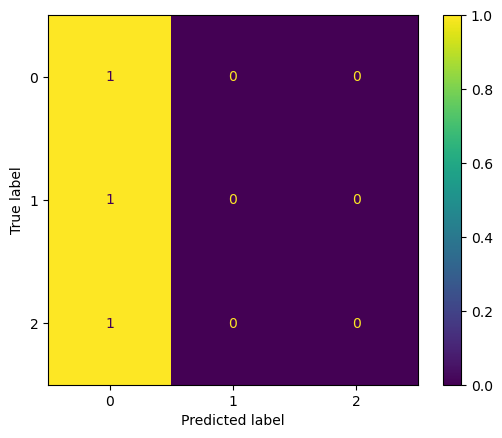

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.61994. Saving Model!
epoch 01, loss: 0.64398, acc: 0.78658, val_loss: 0.61994, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 02, loss: 0.64371, acc: 0.78658, val_loss: 0.62055, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 03, loss: 0.64337, acc: 0.78658, val_loss: 0.62130, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 04, loss: 0.64298, acc: 0.78658, val_loss: 0.62209, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 05, loss: 0.64257, acc: 0.78658, val_loss: 0.62265, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.01it/s]


epoch 06, loss: 0.64212, acc: 0.78658, val_loss: 0.62297, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 07, loss: 0.64163, acc: 0.78658, val_loss: 0.62301, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 08, loss: 0.64110, acc: 0.78658, val_loss: 0.62283, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


epoch 09, loss: 0.64056, acc: 0.78658, val_loss: 0.62256, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


epoch 10, loss: 0.64004, acc: 0.78658, val_loss: 0.62229, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.92it/s]


epoch 11, loss: 0.63956, acc: 0.78658, val_loss: 0.62208, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 12, loss: 0.63914, acc: 0.78658, val_loss: 0.62207, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 13, loss: 0.63877, acc: 0.78658, val_loss: 0.62222, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 14, loss: 0.63842, acc: 0.78658, val_loss: 0.62253, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 15, loss: 0.63808, acc: 0.78658, val_loss: 0.62297, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


epoch 16, loss: 0.63774, acc: 0.78658, val_loss: 0.62350, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 17, loss: 0.63740, acc: 0.78658, val_loss: 0.62411, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 18, loss: 0.63707, acc: 0.78658, val_loss: 0.62470, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 19, loss: 0.63675, acc: 0.78658, val_loss: 0.62525, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


epoch 20, loss: 0.63645, acc: 0.78658, val_loss: 0.62577, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 21, loss: 0.63614, acc: 0.78658, val_loss: 0.62618, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 22, loss: 0.63583, acc: 0.78658, val_loss: 0.62649, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 23, loss: 0.63551, acc: 0.78658, val_loss: 0.62674, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 24, loss: 0.63517, acc: 0.78658, val_loss: 0.62692, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 25, loss: 0.63483, acc: 0.78658, val_loss: 0.62706, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 26, loss: 0.63448, acc: 0.78658, val_loss: 0.62718, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 27, loss: 0.63414, acc: 0.78658, val_loss: 0.62732, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 28, loss: 0.63380, acc: 0.78658, val_loss: 0.62750, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.27it/s]


epoch 29, loss: 0.63346, acc: 0.78658, val_loss: 0.62770, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 30, loss: 0.63313, acc: 0.78658, val_loss: 0.62794, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 31, loss: 0.63280, acc: 0.78658, val_loss: 0.62815, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 32, loss: 0.63248, acc: 0.78658, val_loss: 0.62838, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 33, loss: 0.63216, acc: 0.78658, val_loss: 0.62861, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 34, loss: 0.63186, acc: 0.78658, val_loss: 0.62879, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 35, loss: 0.63155, acc: 0.78658, val_loss: 0.62890, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]

epoch 36, loss: 0.63126, acc: 0.78658, val_loss: 0.62898, val_accuracy: 0.78696

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 37, loss: 0.63097, acc: 0.78658, val_loss: 0.62898, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 38, loss: 0.63069, acc: 0.78658, val_loss: 0.62894, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 39, loss: 0.63041, acc: 0.78658, val_loss: 0.62886, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 40, loss: 0.63013, acc: 0.78658, val_loss: 0.62875, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 41, loss: 0.62986, acc: 0.78658, val_loss: 0.62869, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 42, loss: 0.62959, acc: 0.78658, val_loss: 0.62857, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 43, loss: 0.62932, acc: 0.78658, val_loss: 0.62854, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 44, loss: 0.62905, acc: 0.78658, val_loss: 0.62849, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]


epoch 45, loss: 0.62878, acc: 0.78658, val_loss: 0.62848, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 46, loss: 0.62852, acc: 0.78658, val_loss: 0.62852, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 47, loss: 0.62825, acc: 0.78658, val_loss: 0.62857, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 48, loss: 0.62799, acc: 0.78658, val_loss: 0.62868, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 49, loss: 0.62772, acc: 0.78658, val_loss: 0.62871, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.13it/s]

epoch 50, loss: 0.62746, acc: 0.78658, val_loss: 0.62879, val_accuracy: 0.78696

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 51, loss: 0.62721, acc: 0.78658, val_loss: 0.62882, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.29it/s]


epoch 52, loss: 0.62695, acc: 0.78658, val_loss: 0.62886, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 53, loss: 0.62670, acc: 0.78658, val_loss: 0.62885, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 54, loss: 0.62644, acc: 0.78658, val_loss: 0.62886, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.38it/s]


epoch 55, loss: 0.62618, acc: 0.78658, val_loss: 0.62883, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 56, loss: 0.62594, acc: 0.78658, val_loss: 0.62886, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 57, loss: 0.62569, acc: 0.78658, val_loss: 0.62884, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 58, loss: 0.62544, acc: 0.78658, val_loss: 0.62884, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 59, loss: 0.62519, acc: 0.78658, val_loss: 0.62885, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.33it/s]


epoch 60, loss: 0.62494, acc: 0.78658, val_loss: 0.62889, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 61, loss: 0.62470, acc: 0.78658, val_loss: 0.62893, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 62, loss: 0.62446, acc: 0.78658, val_loss: 0.62899, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 63, loss: 0.62421, acc: 0.78658, val_loss: 0.62907, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 64, loss: 0.62397, acc: 0.78658, val_loss: 0.62913, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 65, loss: 0.62372, acc: 0.78658, val_loss: 0.62922, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.32it/s]


epoch 66, loss: 0.62348, acc: 0.78658, val_loss: 0.62930, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 67, loss: 0.62324, acc: 0.78658, val_loss: 0.62935, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.39it/s]


epoch 68, loss: 0.62300, acc: 0.78658, val_loss: 0.62940, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 69, loss: 0.62275, acc: 0.78658, val_loss: 0.62947, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 70, loss: 0.62251, acc: 0.78658, val_loss: 0.62953, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 71, loss: 0.62227, acc: 0.78658, val_loss: 0.62959, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 72, loss: 0.62202, acc: 0.78658, val_loss: 0.62966, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 73, loss: 0.62178, acc: 0.78658, val_loss: 0.62977, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 74, loss: 0.62154, acc: 0.78658, val_loss: 0.62983, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 75, loss: 0.62130, acc: 0.78658, val_loss: 0.62992, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 76, loss: 0.62105, acc: 0.78658, val_loss: 0.63003, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 77, loss: 0.62081, acc: 0.78658, val_loss: 0.63010, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 78, loss: 0.62056, acc: 0.78658, val_loss: 0.63018, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.89it/s]


epoch 79, loss: 0.62030, acc: 0.78658, val_loss: 0.63028, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 80, loss: 0.62006, acc: 0.78658, val_loss: 0.63034, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 81, loss: 0.61980, acc: 0.78658, val_loss: 0.63040, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 82, loss: 0.61954, acc: 0.78658, val_loss: 0.63047, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 83, loss: 0.61927, acc: 0.78658, val_loss: 0.63051, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 84, loss: 0.61900, acc: 0.78658, val_loss: 0.63057, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


epoch 85, loss: 0.61873, acc: 0.78658, val_loss: 0.63060, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 86, loss: 0.61845, acc: 0.78658, val_loss: 0.63066, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 87, loss: 0.61817, acc: 0.78658, val_loss: 0.63071, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 88, loss: 0.61788, acc: 0.78658, val_loss: 0.63077, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 89, loss: 0.61757, acc: 0.78658, val_loss: 0.63088, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 90, loss: 0.61727, acc: 0.78658, val_loss: 0.63092, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 91, loss: 0.61696, acc: 0.78658, val_loss: 0.63101, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 92, loss: 0.61663, acc: 0.78658, val_loss: 0.63109, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 93, loss: 0.61629, acc: 0.78658, val_loss: 0.63125, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 94, loss: 0.61593, acc: 0.78658, val_loss: 0.63138, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 95, loss: 0.61557, acc: 0.78658, val_loss: 0.63147, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 96, loss: 0.61518, acc: 0.78658, val_loss: 0.63160, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 97, loss: 0.61477, acc: 0.78658, val_loss: 0.63170, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 98, loss: 0.61435, acc: 0.78658, val_loss: 0.63183, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 99, loss: 0.61392, acc: 0.78658, val_loss: 0.63195, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


epoch 100, loss: 0.61345, acc: 0.78658, val_loss: 0.63204, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 101, loss: 0.61310, acc: 0.78658, val_loss: 0.63214, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 102, loss: 0.61266, acc: 0.78658, val_loss: 0.63225, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 103, loss: 0.61216, acc: 0.78730, val_loss: 0.63228, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 104, loss: 0.61172, acc: 0.78730, val_loss: 0.63181, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 105, loss: 0.61129, acc: 0.78730, val_loss: 0.63144, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 106, loss: 0.61083, acc: 0.78730, val_loss: 0.63110, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 107, loss: 0.61033, acc: 0.78730, val_loss: 0.63082, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


epoch 108, loss: 0.60984, acc: 0.78730, val_loss: 0.63065, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 109, loss: 0.60937, acc: 0.78730, val_loss: 0.63044, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 110, loss: 0.60891, acc: 0.78730, val_loss: 0.63030, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 111, loss: 0.60838, acc: 0.78730, val_loss: 0.62993, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


epoch 112, loss: 0.60786, acc: 0.78706, val_loss: 0.62925, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 113, loss: 0.60737, acc: 0.78706, val_loss: 0.62878, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 114, loss: 0.60688, acc: 0.78706, val_loss: 0.62902, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 115, loss: 0.60634, acc: 0.78706, val_loss: 0.62947, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]


epoch 116, loss: 0.60579, acc: 0.78730, val_loss: 0.62969, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 117, loss: 0.60527, acc: 0.78730, val_loss: 0.62913, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 118, loss: 0.60474, acc: 0.78706, val_loss: 0.62885, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.42it/s]


epoch 119, loss: 0.60421, acc: 0.78706, val_loss: 0.62909, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 120, loss: 0.60366, acc: 0.78706, val_loss: 0.62912, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 121, loss: 0.60316, acc: 0.78730, val_loss: 0.62839, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 122, loss: 0.60260, acc: 0.78706, val_loss: 0.62776, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 123, loss: 0.60208, acc: 0.78706, val_loss: 0.62800, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 124, loss: 0.60154, acc: 0.78730, val_loss: 0.62838, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


epoch 125, loss: 0.60104, acc: 0.78706, val_loss: 0.62793, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 126, loss: 0.60049, acc: 0.78706, val_loss: 0.62712, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 127, loss: 0.59996, acc: 0.78754, val_loss: 0.62684, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.22it/s]


epoch 128, loss: 0.59944, acc: 0.78754, val_loss: 0.62718, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 129, loss: 0.59892, acc: 0.78754, val_loss: 0.62708, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 130, loss: 0.59838, acc: 0.78754, val_loss: 0.62650, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 131, loss: 0.59787, acc: 0.78730, val_loss: 0.62651, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 132, loss: 0.59733, acc: 0.78730, val_loss: 0.62681, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 133, loss: 0.59677, acc: 0.78730, val_loss: 0.62659, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 134, loss: 0.59625, acc: 0.78730, val_loss: 0.62567, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 135, loss: 0.59568, acc: 0.78754, val_loss: 0.62519, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 136, loss: 0.59515, acc: 0.78754, val_loss: 0.62592, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 137, loss: 0.59455, acc: 0.78706, val_loss: 0.62615, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 138, loss: 0.59403, acc: 0.78706, val_loss: 0.62553, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 139, loss: 0.59345, acc: 0.78706, val_loss: 0.62415, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 140, loss: 0.59283, acc: 0.78706, val_loss: 0.62308, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]

epoch 141, loss: 0.59227, acc: 0.78706, val_loss: 0.62311, val_accuracy: 0.78696



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 142, loss: 0.59162, acc: 0.78706, val_loss: 0.62283, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 143, loss: 0.59100, acc: 0.78706, val_loss: 0.62253, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 144, loss: 0.59035, acc: 0.78706, val_loss: 0.62193, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 145, loss: 0.58969, acc: 0.78730, val_loss: 0.62116, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 146, loss: 0.58899, acc: 0.78706, val_loss: 0.62067, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.55it/s]


epoch 147, loss: 0.58829, acc: 0.78682, val_loss: 0.62042, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


[INFO] val_acc has been improved from 0.61994 to 0.61992. Saving Model!
epoch 148, loss: 0.58760, acc: 0.78754, val_loss: 0.61992, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


[INFO] val_acc has been improved from 0.61992 to 0.61983. Saving Model!
epoch 149, loss: 0.58685, acc: 0.78827, val_loss: 0.61983, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 150, loss: 0.58609, acc: 0.78778, val_loss: 0.62014, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.54it/s]


epoch 151, loss: 0.58533, acc: 0.78827, val_loss: 0.62034, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


[INFO] val_acc has been improved from 0.61983 to 0.61927. Saving Model!
epoch 152, loss: 0.58457, acc: 0.78899, val_loss: 0.61927, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]

[INFO] val_acc has been improved from 0.61927 to 0.61855. Saving Model!


epoch 153, loss: 0.58374, acc: 0.78899, val_loss: 0.61855, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


[INFO] val_acc has been improved from 0.61855 to 0.61850. Saving Model!
epoch 154, loss: 0.58293, acc: 0.78899, val_loss: 0.61850, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


[INFO] val_acc has been improved from 0.61850 to 0.61810. Saving Model!
epoch 155, loss: 0.58213, acc: 0.78923, val_loss: 0.61810, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 156, loss: 0.58127, acc: 0.78923, val_loss: 0.61821, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 157, loss: 0.58043, acc: 0.78923, val_loss: 0.61885, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 158, loss: 0.57960, acc: 0.78875, val_loss: 0.61854, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


[INFO] val_acc has been improved from 0.61810 to 0.61787. Saving Model!
epoch 159, loss: 0.57873, acc: 0.78899, val_loss: 0.61787, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 160, loss: 0.57785, acc: 0.79044, val_loss: 0.61799, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 161, loss: 0.57695, acc: 0.78996, val_loss: 0.61829, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 162, loss: 0.57606, acc: 0.79092, val_loss: 0.61868, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.68it/s]


epoch 163, loss: 0.57516, acc: 0.79092, val_loss: 0.61977, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 164, loss: 0.57423, acc: 0.79141, val_loss: 0.61985, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.23it/s]


epoch 165, loss: 0.57330, acc: 0.79141, val_loss: 0.61991, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 166, loss: 0.57236, acc: 0.79261, val_loss: 0.62077, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 167, loss: 0.57143, acc: 0.79165, val_loss: 0.62182, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 168, loss: 0.57047, acc: 0.79165, val_loss: 0.62316, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 169, loss: 0.56952, acc: 0.79165, val_loss: 0.62448, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 170, loss: 0.56856, acc: 0.79116, val_loss: 0.62497, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 171, loss: 0.56757, acc: 0.79237, val_loss: 0.62641, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]


epoch 172, loss: 0.56659, acc: 0.79213, val_loss: 0.62870, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 173, loss: 0.56560, acc: 0.79141, val_loss: 0.63041, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 174, loss: 0.56460, acc: 0.79165, val_loss: 0.63216, val_accuracy: 0.80000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 175, loss: 0.56360, acc: 0.79165, val_loss: 0.63460, val_accuracy: 0.80000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 176, loss: 0.56259, acc: 0.79116, val_loss: 0.63645, val_accuracy: 0.80217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 177, loss: 0.56159, acc: 0.79165, val_loss: 0.63849, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 178, loss: 0.56059, acc: 0.79165, val_loss: 0.64211, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 179, loss: 0.55956, acc: 0.79165, val_loss: 0.64458, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 180, loss: 0.55854, acc: 0.79165, val_loss: 0.64656, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 181, loss: 0.55751, acc: 0.79141, val_loss: 0.65066, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 182, loss: 0.55648, acc: 0.79141, val_loss: 0.65433, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 183, loss: 0.55545, acc: 0.79261, val_loss: 0.65698, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 184, loss: 0.55444, acc: 0.79237, val_loss: 0.66081, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 185, loss: 0.55341, acc: 0.79213, val_loss: 0.66358, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 186, loss: 0.55236, acc: 0.79310, val_loss: 0.66960, val_accuracy: 0.76522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 187, loss: 0.55132, acc: 0.79285, val_loss: 0.67262, val_accuracy: 0.76522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 188, loss: 0.55026, acc: 0.79406, val_loss: 0.67749, val_accuracy: 0.76522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 189, loss: 0.54920, acc: 0.79358, val_loss: 0.68179, val_accuracy: 0.76522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 190, loss: 0.54816, acc: 0.79454, val_loss: 0.68731, val_accuracy: 0.76522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 191, loss: 0.54713, acc: 0.79503, val_loss: 0.69192, val_accuracy: 0.76522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 192, loss: 0.54611, acc: 0.79479, val_loss: 0.69433, val_accuracy: 0.76304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 193, loss: 0.54511, acc: 0.79454, val_loss: 0.70210, val_accuracy: 0.69783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 194, loss: 0.54407, acc: 0.79454, val_loss: 0.70645, val_accuracy: 0.69783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 195, loss: 0.54304, acc: 0.79503, val_loss: 0.71065, val_accuracy: 0.69783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.38it/s]


epoch 196, loss: 0.54206, acc: 0.79430, val_loss: 0.71889, val_accuracy: 0.69783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 197, loss: 0.54107, acc: 0.79454, val_loss: 0.72125, val_accuracy: 0.69783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 198, loss: 0.54007, acc: 0.79454, val_loss: 0.72939, val_accuracy: 0.69783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 199, loss: 0.53906, acc: 0.79430, val_loss: 0.73369, val_accuracy: 0.69565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 200, loss: 0.53806, acc: 0.79503, val_loss: 0.73743, val_accuracy: 0.69565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.06it/s]


epoch 201, loss: 0.53709, acc: 0.79551, val_loss: 0.74534, val_accuracy: 0.69348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]

epoch 202, loss: 0.53612, acc: 0.79503, val_loss: 0.74929, val_accuracy: 0.69348



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 203, loss: 0.53516, acc: 0.79430, val_loss: 0.75563, val_accuracy: 0.69348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]


epoch 204, loss: 0.53417, acc: 0.79454, val_loss: 0.75850, val_accuracy: 0.69130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 205, loss: 0.53317, acc: 0.79503, val_loss: 0.76380, val_accuracy: 0.68913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 206, loss: 0.53219, acc: 0.79454, val_loss: 0.77148, val_accuracy: 0.68913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 207, loss: 0.53124, acc: 0.79479, val_loss: 0.77379, val_accuracy: 0.68913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 208, loss: 0.53030, acc: 0.79551, val_loss: 0.78061, val_accuracy: 0.68478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]

epoch 209, loss: 0.52935, acc: 0.79623, val_loss: 0.78185, val_accuracy: 0.68043



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 210, loss: 0.52845, acc: 0.79720, val_loss: 0.79507, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 211, loss: 0.52747, acc: 0.79889, val_loss: 0.79218, val_accuracy: 0.68478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


epoch 212, loss: 0.52641, acc: 0.79841, val_loss: 0.79691, val_accuracy: 0.68261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 213, loss: 0.52548, acc: 0.80010, val_loss: 0.81121, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.98it/s]


epoch 214, loss: 0.52462, acc: 0.79865, val_loss: 0.80787, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 215, loss: 0.52367, acc: 0.80034, val_loss: 0.81522, val_accuracy: 0.67826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 216, loss: 0.52260, acc: 0.80058, val_loss: 0.82275, val_accuracy: 0.67826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 217, loss: 0.52176, acc: 0.80010, val_loss: 0.82345, val_accuracy: 0.67826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 218, loss: 0.52084, acc: 0.80058, val_loss: 0.83362, val_accuracy: 0.67609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 219, loss: 0.51986, acc: 0.80106, val_loss: 0.83597, val_accuracy: 0.67391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 220, loss: 0.51892, acc: 0.80058, val_loss: 0.83474, val_accuracy: 0.67609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 221, loss: 0.51803, acc: 0.80106, val_loss: 0.85045, val_accuracy: 0.67391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 222, loss: 0.51705, acc: 0.80324, val_loss: 0.85518, val_accuracy: 0.67174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 223, loss: 0.51612, acc: 0.80324, val_loss: 0.85186, val_accuracy: 0.67391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 224, loss: 0.51523, acc: 0.80372, val_loss: 0.86147, val_accuracy: 0.67174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 225, loss: 0.51434, acc: 0.80348, val_loss: 0.86675, val_accuracy: 0.67174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 226, loss: 0.51338, acc: 0.80275, val_loss: 0.87331, val_accuracy: 0.67174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 227, loss: 0.51243, acc: 0.80275, val_loss: 0.87514, val_accuracy: 0.66739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]


epoch 228, loss: 0.51152, acc: 0.80372, val_loss: 0.87383, val_accuracy: 0.66739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 229, loss: 0.51063, acc: 0.80372, val_loss: 0.88612, val_accuracy: 0.66087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


epoch 230, loss: 0.50972, acc: 0.80420, val_loss: 0.88496, val_accuracy: 0.66087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 231, loss: 0.50877, acc: 0.80420, val_loss: 0.88713, val_accuracy: 0.66087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 232, loss: 0.50788, acc: 0.80372, val_loss: 0.89953, val_accuracy: 0.65870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 233, loss: 0.50699, acc: 0.80517, val_loss: 0.90223, val_accuracy: 0.65870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 234, loss: 0.50613, acc: 0.80468, val_loss: 0.90846, val_accuracy: 0.65870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 235, loss: 0.50519, acc: 0.80637, val_loss: 0.90968, val_accuracy: 0.65870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 236, loss: 0.50429, acc: 0.80613, val_loss: 0.91607, val_accuracy: 0.65652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.25it/s]


epoch 237, loss: 0.50341, acc: 0.80589, val_loss: 0.91825, val_accuracy: 0.65652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 238, loss: 0.50254, acc: 0.80613, val_loss: 0.91947, val_accuracy: 0.65652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 239, loss: 0.50166, acc: 0.80613, val_loss: 0.92975, val_accuracy: 0.65652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 240, loss: 0.50078, acc: 0.80758, val_loss: 0.93194, val_accuracy: 0.65870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


epoch 241, loss: 0.49995, acc: 0.80710, val_loss: 0.94502, val_accuracy: 0.65870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 242, loss: 0.49916, acc: 0.80758, val_loss: 0.93603, val_accuracy: 0.65652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 243, loss: 0.49846, acc: 0.80637, val_loss: 0.96314, val_accuracy: 0.65435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


epoch 244, loss: 0.49771, acc: 0.80831, val_loss: 0.94450, val_accuracy: 0.65217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 245, loss: 0.49677, acc: 0.80686, val_loss: 0.96558, val_accuracy: 0.65000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 246, loss: 0.49572, acc: 0.81024, val_loss: 0.96590, val_accuracy: 0.65000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 247, loss: 0.49479, acc: 0.80975, val_loss: 0.96469, val_accuracy: 0.65000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 248, loss: 0.49408, acc: 0.80855, val_loss: 0.98850, val_accuracy: 0.63913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 249, loss: 0.49338, acc: 0.81096, val_loss: 0.97135, val_accuracy: 0.65000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 250, loss: 0.49248, acc: 0.80879, val_loss: 0.99108, val_accuracy: 0.64130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 251, loss: 0.49147, acc: 0.81000, val_loss: 0.99767, val_accuracy: 0.63696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 252, loss: 0.49076, acc: 0.81000, val_loss: 0.97560, val_accuracy: 0.64565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 253, loss: 0.49030, acc: 0.81169, val_loss: 1.01254, val_accuracy: 0.62826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 254, loss: 0.48953, acc: 0.81024, val_loss: 0.99248, val_accuracy: 0.63913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 255, loss: 0.48837, acc: 0.81217, val_loss: 0.99859, val_accuracy: 0.63696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 256, loss: 0.48753, acc: 0.81193, val_loss: 1.02332, val_accuracy: 0.62826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 257, loss: 0.48703, acc: 0.81120, val_loss: 0.99304, val_accuracy: 0.63261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 258, loss: 0.48631, acc: 0.81169, val_loss: 1.01844, val_accuracy: 0.62609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.55it/s]


epoch 259, loss: 0.48521, acc: 0.81217, val_loss: 1.01807, val_accuracy: 0.62609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 260, loss: 0.48435, acc: 0.81072, val_loss: 1.00425, val_accuracy: 0.62826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


epoch 261, loss: 0.48382, acc: 0.81241, val_loss: 1.03618, val_accuracy: 0.62391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 262, loss: 0.48310, acc: 0.81748, val_loss: 1.01402, val_accuracy: 0.62826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 263, loss: 0.48214, acc: 0.81338, val_loss: 1.02623, val_accuracy: 0.61957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 264, loss: 0.48122, acc: 0.81386, val_loss: 1.04212, val_accuracy: 0.61957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 265, loss: 0.48060, acc: 0.81893, val_loss: 1.02123, val_accuracy: 0.61957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 266, loss: 0.47994, acc: 0.81410, val_loss: 1.05277, val_accuracy: 0.60870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 267, loss: 0.47909, acc: 0.81869, val_loss: 1.03346, val_accuracy: 0.61522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 268, loss: 0.47816, acc: 0.81917, val_loss: 1.04308, val_accuracy: 0.61522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.06it/s]


epoch 269, loss: 0.47736, acc: 0.81820, val_loss: 1.05752, val_accuracy: 0.60652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 270, loss: 0.47671, acc: 0.81917, val_loss: 1.03814, val_accuracy: 0.61522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 271, loss: 0.47609, acc: 0.81869, val_loss: 1.07196, val_accuracy: 0.60435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 272, loss: 0.47527, acc: 0.81989, val_loss: 1.05128, val_accuracy: 0.60870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 273, loss: 0.47444, acc: 0.81893, val_loss: 1.06599, val_accuracy: 0.60435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 274, loss: 0.47356, acc: 0.82014, val_loss: 1.06751, val_accuracy: 0.60435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 275, loss: 0.47279, acc: 0.82014, val_loss: 1.06146, val_accuracy: 0.60652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]

epoch 276, loss: 0.47207, acc: 0.82014, val_loss: 1.08450, val_accuracy: 0.60217

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]


epoch 277, loss: 0.47146, acc: 0.82110, val_loss: 1.05912, val_accuracy: 0.60435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 278, loss: 0.47087, acc: 0.82038, val_loss: 1.10199, val_accuracy: 0.60000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 279, loss: 0.47019, acc: 0.82279, val_loss: 1.06587, val_accuracy: 0.60217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 280, loss: 0.46934, acc: 0.82158, val_loss: 1.10142, val_accuracy: 0.60000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 281, loss: 0.46837, acc: 0.82255, val_loss: 1.09417, val_accuracy: 0.60000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 282, loss: 0.46751, acc: 0.82279, val_loss: 1.09184, val_accuracy: 0.60000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 283, loss: 0.46677, acc: 0.82231, val_loss: 1.11161, val_accuracy: 0.59565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]


epoch 284, loss: 0.46614, acc: 0.82400, val_loss: 1.09030, val_accuracy: 0.60000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.67it/s]


epoch 285, loss: 0.46548, acc: 0.82303, val_loss: 1.12369, val_accuracy: 0.58478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 286, loss: 0.46484, acc: 0.82496, val_loss: 1.08932, val_accuracy: 0.59783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.82it/s]


epoch 287, loss: 0.46424, acc: 0.82303, val_loss: 1.14320, val_accuracy: 0.57826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 288, loss: 0.46363, acc: 0.82545, val_loss: 1.09297, val_accuracy: 0.59783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 289, loss: 0.46307, acc: 0.82279, val_loss: 1.15450, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 290, loss: 0.46256, acc: 0.82859, val_loss: 1.09314, val_accuracy: 0.59783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 291, loss: 0.46190, acc: 0.82376, val_loss: 1.16372, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.13it/s]


epoch 292, loss: 0.46082, acc: 0.82907, val_loss: 1.11932, val_accuracy: 0.58478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 293, loss: 0.45981, acc: 0.82521, val_loss: 1.15327, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 294, loss: 0.45890, acc: 0.82859, val_loss: 1.13555, val_accuracy: 0.58043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 295, loss: 0.45808, acc: 0.82690, val_loss: 1.14997, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 296, loss: 0.45730, acc: 0.82883, val_loss: 1.15459, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 297, loss: 0.45662, acc: 0.82907, val_loss: 1.14821, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 298, loss: 0.45599, acc: 0.82955, val_loss: 1.18096, val_accuracy: 0.57174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


epoch 299, loss: 0.45549, acc: 0.82955, val_loss: 1.13342, val_accuracy: 0.58043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.29it/s]


epoch 300, loss: 0.45517, acc: 0.82810, val_loss: 1.20645, val_accuracy: 0.33478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 301, loss: 0.45501, acc: 0.83124, val_loss: 1.11945, val_accuracy: 0.58261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 302, loss: 0.45542, acc: 0.82545, val_loss: 1.24878, val_accuracy: 0.33478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 303, loss: 0.45609, acc: 0.83003, val_loss: 1.09157, val_accuracy: 0.59783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 304, loss: 0.45753, acc: 0.82207, val_loss: 1.27314, val_accuracy: 0.33478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 305, loss: 0.45582, acc: 0.82714, val_loss: 1.12058, val_accuracy: 0.57826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 306, loss: 0.45402, acc: 0.82448, val_loss: 1.23090, val_accuracy: 0.33478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 307, loss: 0.45087, acc: 0.83124, val_loss: 1.19027, val_accuracy: 0.57174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.33it/s]


epoch 308, loss: 0.44929, acc: 0.83028, val_loss: 1.16481, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 309, loss: 0.44921, acc: 0.82979, val_loss: 1.25743, val_accuracy: 0.33478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 310, loss: 0.45009, acc: 0.83052, val_loss: 1.12519, val_accuracy: 0.57826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 311, loss: 0.45159, acc: 0.82690, val_loss: 1.29239, val_accuracy: 0.32391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 312, loss: 0.45143, acc: 0.82979, val_loss: 1.12209, val_accuracy: 0.57826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 313, loss: 0.45113, acc: 0.82617, val_loss: 1.27944, val_accuracy: 0.33478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 314, loss: 0.44803, acc: 0.83100, val_loss: 1.18516, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 315, loss: 0.44565, acc: 0.83052, val_loss: 1.22632, val_accuracy: 0.57174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 316, loss: 0.44430, acc: 0.83221, val_loss: 1.25178, val_accuracy: 0.33478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.24it/s]


epoch 317, loss: 0.44409, acc: 0.83462, val_loss: 1.17528, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


epoch 318, loss: 0.44481, acc: 0.83003, val_loss: 1.29967, val_accuracy: 0.32391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 319, loss: 0.44550, acc: 0.83100, val_loss: 1.14454, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 320, loss: 0.44665, acc: 0.82883, val_loss: 1.31841, val_accuracy: 0.31957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 321, loss: 0.44559, acc: 0.83003, val_loss: 1.15488, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 322, loss: 0.44484, acc: 0.82955, val_loss: 1.30097, val_accuracy: 0.32391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 323, loss: 0.44231, acc: 0.83197, val_loss: 1.21464, val_accuracy: 0.57391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


epoch 324, loss: 0.44035, acc: 0.83269, val_loss: 1.26006, val_accuracy: 0.57391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 325, loss: 0.43911, acc: 0.83414, val_loss: 1.27366, val_accuracy: 0.33696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 326, loss: 0.43867, acc: 0.83366, val_loss: 1.21594, val_accuracy: 0.57391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 327, loss: 0.43891, acc: 0.83317, val_loss: 1.32019, val_accuracy: 0.31957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 328, loss: 0.43944, acc: 0.83221, val_loss: 1.18384, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 329, loss: 0.44073, acc: 0.82979, val_loss: 1.36224, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 330, loss: 0.44116, acc: 0.83245, val_loss: 1.16416, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 331, loss: 0.44283, acc: 0.82907, val_loss: 1.37991, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 332, loss: 0.44084, acc: 0.83148, val_loss: 1.19223, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]


epoch 333, loss: 0.43951, acc: 0.83028, val_loss: 1.34943, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 334, loss: 0.43625, acc: 0.83390, val_loss: 1.26325, val_accuracy: 0.57391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 335, loss: 0.43408, acc: 0.83438, val_loss: 1.28758, val_accuracy: 0.32609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 336, loss: 0.43312, acc: 0.83631, val_loss: 1.32807, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 337, loss: 0.43325, acc: 0.83414, val_loss: 1.23331, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 338, loss: 0.43406, acc: 0.83390, val_loss: 1.37709, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 339, loss: 0.43495, acc: 0.83390, val_loss: 1.20016, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.75it/s]


epoch 340, loss: 0.43711, acc: 0.83028, val_loss: 1.41900, val_accuracy: 0.30870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 341, loss: 0.43702, acc: 0.83414, val_loss: 1.19448, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 342, loss: 0.43803, acc: 0.83028, val_loss: 1.41428, val_accuracy: 0.30870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 343, loss: 0.43442, acc: 0.83535, val_loss: 1.24867, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 344, loss: 0.43202, acc: 0.83366, val_loss: 1.36076, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 345, loss: 0.42934, acc: 0.83607, val_loss: 1.32589, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 346, loss: 0.42814, acc: 0.83704, val_loss: 1.30103, val_accuracy: 0.32609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 347, loss: 0.42814, acc: 0.83679, val_loss: 1.39315, val_accuracy: 0.30870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


epoch 348, loss: 0.42894, acc: 0.83631, val_loss: 1.24656, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 349, loss: 0.43092, acc: 0.83341, val_loss: 1.44387, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 350, loss: 0.43194, acc: 0.83559, val_loss: 1.21187, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 351, loss: 0.43498, acc: 0.83100, val_loss: 1.47250, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 352, loss: 0.43303, acc: 0.83366, val_loss: 1.23343, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 353, loss: 0.43278, acc: 0.83245, val_loss: 1.44994, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 354, loss: 0.42805, acc: 0.83704, val_loss: 1.31972, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 355, loss: 0.42509, acc: 0.83776, val_loss: 1.37348, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 356, loss: 0.42346, acc: 0.83848, val_loss: 1.40155, val_accuracy: 0.30870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]


epoch 357, loss: 0.42354, acc: 0.83728, val_loss: 1.29548, val_accuracy: 0.32391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 358, loss: 0.42513, acc: 0.83559, val_loss: 1.46415, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 359, loss: 0.42700, acc: 0.83655, val_loss: 1.23626, val_accuracy: 0.58261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


epoch 360, loss: 0.43087, acc: 0.83148, val_loss: 1.49959, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 361, loss: 0.42959, acc: 0.83535, val_loss: 1.24749, val_accuracy: 0.58261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 362, loss: 0.43020, acc: 0.83172, val_loss: 1.48647, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 363, loss: 0.42505, acc: 0.83655, val_loss: 1.32846, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 364, loss: 0.42179, acc: 0.83897, val_loss: 1.40909, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 365, loss: 0.41949, acc: 0.83993, val_loss: 1.42624, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 366, loss: 0.41931, acc: 0.83897, val_loss: 1.33509, val_accuracy: 0.31957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 367, loss: 0.42071, acc: 0.83873, val_loss: 1.49542, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 368, loss: 0.42213, acc: 0.83776, val_loss: 1.28420, val_accuracy: 0.57174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 369, loss: 0.42507, acc: 0.83510, val_loss: 1.53091, val_accuracy: 0.31087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 370, loss: 0.42428, acc: 0.83824, val_loss: 1.29178, val_accuracy: 0.57174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 371, loss: 0.42506, acc: 0.83462, val_loss: 1.52526, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 372, loss: 0.42090, acc: 0.83776, val_loss: 1.36072, val_accuracy: 0.31957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 373, loss: 0.41809, acc: 0.84017, val_loss: 1.46259, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 374, loss: 0.41580, acc: 0.84066, val_loss: 1.44527, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


epoch 375, loss: 0.41494, acc: 0.84186, val_loss: 1.40300, val_accuracy: 0.31957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


epoch 376, loss: 0.41516, acc: 0.84066, val_loss: 1.50323, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 377, loss: 0.41594, acc: 0.84114, val_loss: 1.35028, val_accuracy: 0.32174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 378, loss: 0.41775, acc: 0.83848, val_loss: 1.55287, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 379, loss: 0.41875, acc: 0.84066, val_loss: 1.31869, val_accuracy: 0.32609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.35it/s]


epoch 380, loss: 0.42157, acc: 0.83607, val_loss: 1.58206, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 381, loss: 0.42004, acc: 0.84138, val_loss: 1.32647, val_accuracy: 0.32609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 382, loss: 0.42071, acc: 0.83728, val_loss: 1.56441, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 383, loss: 0.41661, acc: 0.84162, val_loss: 1.38767, val_accuracy: 0.32174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 384, loss: 0.41386, acc: 0.84186, val_loss: 1.49446, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 385, loss: 0.41135, acc: 0.84331, val_loss: 1.46364, val_accuracy: 0.32391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 386, loss: 0.41033, acc: 0.84331, val_loss: 1.43411, val_accuracy: 0.32391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 387, loss: 0.41039, acc: 0.84259, val_loss: 1.53204, val_accuracy: 0.31087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


epoch 388, loss: 0.41120, acc: 0.84283, val_loss: 1.38126, val_accuracy: 0.32174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 389, loss: 0.41329, acc: 0.84138, val_loss: 1.59360, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 390, loss: 0.41503, acc: 0.84331, val_loss: 1.32920, val_accuracy: 0.32826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 391, loss: 0.41962, acc: 0.83800, val_loss: 1.63574, val_accuracy: 0.29565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 392, loss: 0.41785, acc: 0.84186, val_loss: 1.34731, val_accuracy: 0.32826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 393, loss: 0.41868, acc: 0.83776, val_loss: 1.61352, val_accuracy: 0.29565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 394, loss: 0.41252, acc: 0.84331, val_loss: 1.44594, val_accuracy: 0.32826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 395, loss: 0.40877, acc: 0.84283, val_loss: 1.51629, val_accuracy: 0.32174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]


epoch 396, loss: 0.40657, acc: 0.84355, val_loss: 1.55131, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.21it/s]


epoch 397, loss: 0.40688, acc: 0.84476, val_loss: 1.42264, val_accuracy: 0.32826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 398, loss: 0.40932, acc: 0.84186, val_loss: 1.63362, val_accuracy: 0.29565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 399, loss: 0.41156, acc: 0.84452, val_loss: 1.36282, val_accuracy: 0.32391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 400, loss: 0.41625, acc: 0.83752, val_loss: 1.66790, val_accuracy: 0.29130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]


epoch 401, loss: 0.41417, acc: 0.84404, val_loss: 1.37584, val_accuracy: 0.32391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 402, loss: 0.41476, acc: 0.83969, val_loss: 1.63034, val_accuracy: 0.29565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 403, loss: 0.40822, acc: 0.84549, val_loss: 1.48788, val_accuracy: 0.32826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


epoch 404, loss: 0.40435, acc: 0.84524, val_loss: 1.52668, val_accuracy: 0.32609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 405, loss: 0.40307, acc: 0.84380, val_loss: 1.59641, val_accuracy: 0.29783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 406, loss: 0.40406, acc: 0.84524, val_loss: 1.44142, val_accuracy: 0.32826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 407, loss: 0.40693, acc: 0.84042, val_loss: 1.66782, val_accuracy: 0.29130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 408, loss: 0.40823, acc: 0.84645, val_loss: 1.39895, val_accuracy: 0.33043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 409, loss: 0.41140, acc: 0.84017, val_loss: 1.67589, val_accuracy: 0.29130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 410, loss: 0.40843, acc: 0.84476, val_loss: 1.43237, val_accuracy: 0.33043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 411, loss: 0.40703, acc: 0.84162, val_loss: 1.62738, val_accuracy: 0.29565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 412, loss: 0.40274, acc: 0.84669, val_loss: 1.52696, val_accuracy: 0.32609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]


epoch 413, loss: 0.40043, acc: 0.84766, val_loss: 1.54473, val_accuracy: 0.32174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 414, loss: 0.39967, acc: 0.84838, val_loss: 1.61029, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 415, loss: 0.40040, acc: 0.84549, val_loss: 1.47540, val_accuracy: 0.32826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 416, loss: 0.40244, acc: 0.84307, val_loss: 1.67732, val_accuracy: 0.29348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 417, loss: 0.40391, acc: 0.84790, val_loss: 1.42328, val_accuracy: 0.33043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 418, loss: 0.40756, acc: 0.84211, val_loss: 1.70959, val_accuracy: 0.29130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.90it/s]


epoch 419, loss: 0.40599, acc: 0.84645, val_loss: 1.43037, val_accuracy: 0.33043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 420, loss: 0.40639, acc: 0.84307, val_loss: 1.68074, val_accuracy: 0.29348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 421, loss: 0.40199, acc: 0.84814, val_loss: 1.49942, val_accuracy: 0.32609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 422, loss: 0.39949, acc: 0.84597, val_loss: 1.61384, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 423, loss: 0.39695, acc: 0.84911, val_loss: 1.59825, val_accuracy: 0.30870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 424, loss: 0.39619, acc: 0.84838, val_loss: 1.54318, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 425, loss: 0.39669, acc: 0.84790, val_loss: 1.66674, val_accuracy: 0.30000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 426, loss: 0.39798, acc: 0.84790, val_loss: 1.47592, val_accuracy: 0.33043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 427, loss: 0.40026, acc: 0.84452, val_loss: 1.71585, val_accuracy: 0.29130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 428, loss: 0.40103, acc: 0.84959, val_loss: 1.44985, val_accuracy: 0.33043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


epoch 429, loss: 0.40416, acc: 0.84259, val_loss: 1.74303, val_accuracy: 0.28913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 430, loss: 0.40162, acc: 0.85007, val_loss: 1.48167, val_accuracy: 0.33043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 431, loss: 0.40049, acc: 0.84307, val_loss: 1.70055, val_accuracy: 0.29565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 432, loss: 0.39668, acc: 0.85007, val_loss: 1.55790, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 433, loss: 0.39462, acc: 0.84838, val_loss: 1.65154, val_accuracy: 0.30870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 434, loss: 0.39286, acc: 0.85031, val_loss: 1.62819, val_accuracy: 0.30870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 435, loss: 0.39230, acc: 0.84911, val_loss: 1.58021, val_accuracy: 0.31087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.39it/s]


epoch 436, loss: 0.39246, acc: 0.85007, val_loss: 1.69215, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 437, loss: 0.39340, acc: 0.84862, val_loss: 1.52514, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 438, loss: 0.39532, acc: 0.84742, val_loss: 1.75112, val_accuracy: 0.28913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 439, loss: 0.39676, acc: 0.85080, val_loss: 1.47911, val_accuracy: 0.33043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 440, loss: 0.40117, acc: 0.84380, val_loss: 1.79977, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 441, loss: 0.39966, acc: 0.85104, val_loss: 1.48769, val_accuracy: 0.31957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 442, loss: 0.40025, acc: 0.84355, val_loss: 1.76554, val_accuracy: 0.29348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 443, loss: 0.39593, acc: 0.85080, val_loss: 1.54003, val_accuracy: 0.31957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]


epoch 444, loss: 0.39438, acc: 0.84814, val_loss: 1.71351, val_accuracy: 0.30870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 445, loss: 0.39091, acc: 0.85200, val_loss: 1.63772, val_accuracy: 0.31087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 446, loss: 0.38929, acc: 0.84959, val_loss: 1.63130, val_accuracy: 0.31087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 447, loss: 0.38867, acc: 0.85056, val_loss: 1.71496, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 448, loss: 0.38961, acc: 0.85321, val_loss: 1.57629, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 449, loss: 0.39066, acc: 0.85007, val_loss: 1.77849, val_accuracy: 0.29348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 450, loss: 0.39217, acc: 0.85345, val_loss: 1.53021, val_accuracy: 0.31957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 451, loss: 0.39621, acc: 0.84693, val_loss: 1.83261, val_accuracy: 0.29130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 452, loss: 0.39663, acc: 0.85442, val_loss: 1.50397, val_accuracy: 0.31957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 453, loss: 0.39823, acc: 0.84549, val_loss: 1.81007, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 454, loss: 0.39405, acc: 0.85297, val_loss: 1.56684, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 455, loss: 0.39317, acc: 0.84911, val_loss: 1.77493, val_accuracy: 0.30217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 456, loss: 0.38887, acc: 0.85466, val_loss: 1.68730, val_accuracy: 0.31087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 457, loss: 0.38620, acc: 0.85104, val_loss: 1.64851, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 458, loss: 0.38621, acc: 0.85080, val_loss: 1.77416, val_accuracy: 0.29783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 459, loss: 0.38815, acc: 0.85683, val_loss: 1.57043, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 460, loss: 0.39067, acc: 0.84983, val_loss: 1.82984, val_accuracy: 0.29130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 461, loss: 0.39095, acc: 0.85466, val_loss: 1.55439, val_accuracy: 0.31957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 462, loss: 0.39422, acc: 0.84693, val_loss: 1.86333, val_accuracy: 0.29565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 463, loss: 0.39193, acc: 0.85563, val_loss: 1.57452, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 464, loss: 0.38965, acc: 0.84959, val_loss: 1.78298, val_accuracy: 0.30000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 465, loss: 0.38570, acc: 0.85490, val_loss: 1.67050, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 466, loss: 0.38300, acc: 0.85394, val_loss: 1.72914, val_accuracy: 0.31087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 467, loss: 0.38203, acc: 0.85321, val_loss: 1.76808, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 468, loss: 0.38212, acc: 0.85442, val_loss: 1.64379, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 469, loss: 0.38348, acc: 0.85176, val_loss: 1.82563, val_accuracy: 0.29783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 470, loss: 0.38536, acc: 0.85707, val_loss: 1.57601, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 471, loss: 0.38887, acc: 0.85031, val_loss: 1.86810, val_accuracy: 0.29565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 472, loss: 0.38831, acc: 0.85683, val_loss: 1.56944, val_accuracy: 0.31957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 473, loss: 0.39070, acc: 0.84814, val_loss: 1.86745, val_accuracy: 0.29783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 474, loss: 0.38553, acc: 0.85756, val_loss: 1.65187, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 475, loss: 0.38226, acc: 0.85225, val_loss: 1.78545, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.32it/s]


epoch 476, loss: 0.37946, acc: 0.85732, val_loss: 1.74102, val_accuracy: 0.30870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.23it/s]


epoch 477, loss: 0.37822, acc: 0.85780, val_loss: 1.71945, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 478, loss: 0.37836, acc: 0.85418, val_loss: 1.81790, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 479, loss: 0.37937, acc: 0.85756, val_loss: 1.64322, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 480, loss: 0.38155, acc: 0.85273, val_loss: 1.87055, val_accuracy: 0.29783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]

epoch 481, loss: 0.38352, acc: 0.85732, val_loss: 1.57825, val_accuracy: 0.31739

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 482, loss: 0.38799, acc: 0.84983, val_loss: 1.91204, val_accuracy: 0.29783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 483, loss: 0.38573, acc: 0.85804, val_loss: 1.61095, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 484, loss: 0.38654, acc: 0.85007, val_loss: 1.89172, val_accuracy: 0.29783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 485, loss: 0.38089, acc: 0.85780, val_loss: 1.70460, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 486, loss: 0.37731, acc: 0.85345, val_loss: 1.79169, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 487, loss: 0.37527, acc: 0.85804, val_loss: 1.81946, val_accuracy: 0.30217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 488, loss: 0.37517, acc: 0.85925, val_loss: 1.71423, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 489, loss: 0.37669, acc: 0.85345, val_loss: 1.89041, val_accuracy: 0.29783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 490, loss: 0.37833, acc: 0.85949, val_loss: 1.64131, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 491, loss: 0.38210, acc: 0.85249, val_loss: 1.93651, val_accuracy: 0.29565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]


epoch 492, loss: 0.38226, acc: 0.86045, val_loss: 1.62357, val_accuracy: 0.31957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 493, loss: 0.38508, acc: 0.85104, val_loss: 1.94774, val_accuracy: 0.29783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.21it/s]


epoch 494, loss: 0.38046, acc: 0.86021, val_loss: 1.69511, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 495, loss: 0.37861, acc: 0.85321, val_loss: 1.89905, val_accuracy: 0.30000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 496, loss: 0.37443, acc: 0.85949, val_loss: 1.79312, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 497, loss: 0.37229, acc: 0.85780, val_loss: 1.80501, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 498, loss: 0.37172, acc: 0.85973, val_loss: 1.87004, val_accuracy: 0.30217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 499, loss: 0.37227, acc: 0.85828, val_loss: 1.73556, val_accuracy: 0.31087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 500, loss: 0.37397, acc: 0.85394, val_loss: 1.93862, val_accuracy: 0.30000
5번째 교차검증
evaluation loss: 0.61787, evaluation accuracy: 0.78696
(5, 460)
(460, 5)
Learning rate set to 0.055397
0:	learn: 1.0487468	total: 7.44ms	remaining: 7.43s
1:	learn: 1.0058734	total: 15.1ms	remaining: 7.52s
2:	learn: 0.9683868	total: 21.6ms	remaining: 7.19s
3:	learn: 0.9350666	total: 29.6ms	remaining: 7.36s
4:	learn: 0.9058165	total: 36.9ms	remaining: 7.35s
5:	learn: 0.8795018	total: 43.2ms	remaining: 7.16s
6:	learn: 0.8559696	total: 50.2ms	remaining: 7.12s
7:	learn: 0.8350823	total: 56.9ms	remaining: 7.06s
8:	learn: 0.8162821	total: 64.7ms	remaining: 7.12s
9:	learn: 0.7993171	total: 71.6ms	remaining: 7.09s
10:	learn: 0.7839742	total: 77.8ms	remaining: 7s
11:	learn: 0.7700718	total: 85.1ms	remaining: 7.01s
12:	learn: 0.7572651	total: 91.8ms	remaining: 6.97s
13:	learn: 0.7456261	total: 98.8ms	remaining: 6.96s
14:	learn: 0.7352024	total: 105ms	remaining: 6.93s
15:	learn: 0.7257064	total: 115ms	remaini

179:	learn: 0.6192457	total: 1.23s	remaining: 5.61s
180:	learn: 0.6192332	total: 1.24s	remaining: 5.6s
181:	learn: 0.6192209	total: 1.24s	remaining: 5.59s
182:	learn: 0.6192087	total: 1.25s	remaining: 5.59s
183:	learn: 0.6191966	total: 1.26s	remaining: 5.58s
184:	learn: 0.6191847	total: 1.27s	remaining: 5.58s
185:	learn: 0.6191729	total: 1.28s	remaining: 5.59s
186:	learn: 0.6191612	total: 1.28s	remaining: 5.58s
187:	learn: 0.6191496	total: 1.29s	remaining: 5.57s
188:	learn: 0.6191381	total: 1.3s	remaining: 5.56s
189:	learn: 0.6191268	total: 1.3s	remaining: 5.55s
190:	learn: 0.6191155	total: 1.31s	remaining: 5.54s
191:	learn: 0.6191045	total: 1.31s	remaining: 5.53s
192:	learn: 0.6190935	total: 1.32s	remaining: 5.53s
193:	learn: 0.6190826	total: 1.33s	remaining: 5.52s
194:	learn: 0.6190717	total: 1.33s	remaining: 5.51s
195:	learn: 0.6190611	total: 1.34s	remaining: 5.5s
196:	learn: 0.6190505	total: 1.35s	remaining: 5.5s
197:	learn: 0.6190400	total: 1.35s	remaining: 5.49s
198:	learn: 0.619

346:	learn: 0.6181454	total: 2.47s	remaining: 4.64s
347:	learn: 0.6181420	total: 2.47s	remaining: 4.63s
348:	learn: 0.6181386	total: 2.48s	remaining: 4.63s
349:	learn: 0.6181345	total: 2.49s	remaining: 4.62s
350:	learn: 0.6181312	total: 2.5s	remaining: 4.61s
351:	learn: 0.6181279	total: 2.5s	remaining: 4.61s
352:	learn: 0.6181246	total: 2.51s	remaining: 4.6s
353:	learn: 0.6181214	total: 2.52s	remaining: 4.59s
354:	learn: 0.6181182	total: 2.52s	remaining: 4.58s
355:	learn: 0.6181149	total: 2.53s	remaining: 4.58s
356:	learn: 0.6181117	total: 2.54s	remaining: 4.57s
357:	learn: 0.6181079	total: 2.54s	remaining: 4.56s
358:	learn: 0.6181040	total: 2.55s	remaining: 4.55s
359:	learn: 0.6181009	total: 2.56s	remaining: 4.55s
360:	learn: 0.6180977	total: 2.57s	remaining: 4.54s
361:	learn: 0.6180946	total: 2.57s	remaining: 4.54s
362:	learn: 0.6180916	total: 2.58s	remaining: 4.53s
363:	learn: 0.6180885	total: 2.59s	remaining: 4.52s
364:	learn: 0.6180854	total: 2.6s	remaining: 4.51s
365:	learn: 0.61

514:	learn: 0.6177618	total: 3.92s	remaining: 3.69s
515:	learn: 0.6177603	total: 3.92s	remaining: 3.68s
516:	learn: 0.6177588	total: 3.93s	remaining: 3.67s
517:	learn: 0.6177574	total: 3.94s	remaining: 3.67s
518:	learn: 0.6177557	total: 3.95s	remaining: 3.66s
519:	learn: 0.6177542	total: 3.96s	remaining: 3.65s
520:	learn: 0.6177528	total: 3.96s	remaining: 3.64s
521:	learn: 0.6177513	total: 3.97s	remaining: 3.64s
522:	learn: 0.6177500	total: 3.98s	remaining: 3.63s
523:	learn: 0.6177485	total: 3.99s	remaining: 3.63s
524:	learn: 0.6177471	total: 4s	remaining: 3.62s
525:	learn: 0.6177457	total: 4.01s	remaining: 3.61s
526:	learn: 0.6177442	total: 4.02s	remaining: 3.61s
527:	learn: 0.6177429	total: 4.03s	remaining: 3.6s
528:	learn: 0.6177415	total: 4.03s	remaining: 3.59s
529:	learn: 0.6177401	total: 4.04s	remaining: 3.58s
530:	learn: 0.6177387	total: 4.05s	remaining: 3.58s
531:	learn: 0.6177373	total: 4.06s	remaining: 3.57s
532:	learn: 0.6177360	total: 4.07s	remaining: 3.56s
533:	learn: 0.61

692:	learn: 0.6175682	total: 5.36s	remaining: 2.38s
693:	learn: 0.6175674	total: 5.38s	remaining: 2.37s
694:	learn: 0.6175666	total: 5.38s	remaining: 2.36s
695:	learn: 0.6175658	total: 5.39s	remaining: 2.35s
696:	learn: 0.6175651	total: 5.4s	remaining: 2.35s
697:	learn: 0.6175643	total: 5.41s	remaining: 2.34s
698:	learn: 0.6175635	total: 5.42s	remaining: 2.33s
699:	learn: 0.6175627	total: 5.43s	remaining: 2.33s
700:	learn: 0.6175619	total: 5.43s	remaining: 2.32s
701:	learn: 0.6175612	total: 5.44s	remaining: 2.31s
702:	learn: 0.6175605	total: 5.45s	remaining: 2.3s
703:	learn: 0.6175597	total: 5.46s	remaining: 2.29s
704:	learn: 0.6175589	total: 5.47s	remaining: 2.29s
705:	learn: 0.6175582	total: 5.47s	remaining: 2.28s
706:	learn: 0.6175574	total: 5.48s	remaining: 2.27s
707:	learn: 0.6175566	total: 5.49s	remaining: 2.26s
708:	learn: 0.6175559	total: 5.5s	remaining: 2.26s
709:	learn: 0.6175552	total: 5.5s	remaining: 2.25s
710:	learn: 0.6175542	total: 5.51s	remaining: 2.24s
711:	learn: 0.61

867:	learn: 0.6174579	total: 7.04s	remaining: 1.07s
868:	learn: 0.6174574	total: 7.04s	remaining: 1.06s
869:	learn: 0.6174570	total: 7.05s	remaining: 1.05s
870:	learn: 0.6174565	total: 7.06s	remaining: 1.04s
871:	learn: 0.6174560	total: 7.07s	remaining: 1.04s
872:	learn: 0.6174555	total: 7.08s	remaining: 1.03s
873:	learn: 0.6174550	total: 7.08s	remaining: 1.02s
874:	learn: 0.6174546	total: 7.09s	remaining: 1.01s
875:	learn: 0.6174541	total: 7.1s	remaining: 1s
876:	learn: 0.6174536	total: 7.11s	remaining: 996ms
877:	learn: 0.6174531	total: 7.11s	remaining: 988ms
878:	learn: 0.6174526	total: 7.12s	remaining: 980ms
879:	learn: 0.6174522	total: 7.13s	remaining: 972ms
880:	learn: 0.6174517	total: 7.14s	remaining: 964ms
881:	learn: 0.6174512	total: 7.14s	remaining: 956ms
882:	learn: 0.6174507	total: 7.15s	remaining: 947ms
883:	learn: 0.6174503	total: 7.16s	remaining: 939ms
884:	learn: 0.6174498	total: 7.16s	remaining: 931ms
885:	learn: 0.6174494	total: 7.18s	remaining: 924ms
886:	learn: 0.61

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


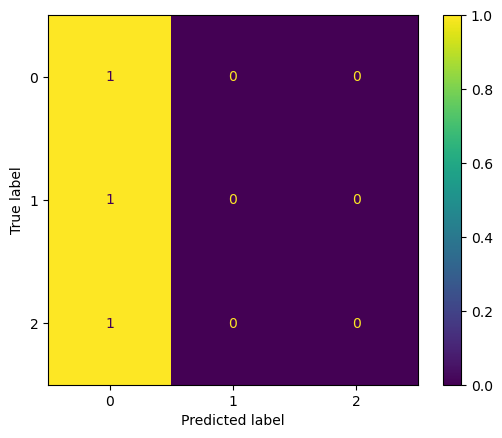

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.58674. Saving Model!
epoch 01, loss: 0.58162, acc: 0.79068, val_loss: 0.58674, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 02, loss: 0.58168, acc: 0.79092, val_loss: 0.59018, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 03, loss: 0.58160, acc: 0.78996, val_loss: 0.59356, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 04, loss: 0.58094, acc: 0.79092, val_loss: 0.59659, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 05, loss: 0.57977, acc: 0.79141, val_loss: 0.59959, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 06, loss: 0.57862, acc: 0.79165, val_loss: 0.60299, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 07, loss: 0.57792, acc: 0.79189, val_loss: 0.60681, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 08, loss: 0.57758, acc: 0.79165, val_loss: 0.61086, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 09, loss: 0.57720, acc: 0.79165, val_loss: 0.61504, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 10, loss: 0.57650, acc: 0.79116, val_loss: 0.61942, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 11, loss: 0.57550, acc: 0.79092, val_loss: 0.62410, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 12, loss: 0.57450, acc: 0.79116, val_loss: 0.62893, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 13, loss: 0.57371, acc: 0.79189, val_loss: 0.63327, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 14, loss: 0.57309, acc: 0.79165, val_loss: 0.63683, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 15, loss: 0.57246, acc: 0.79116, val_loss: 0.63937, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 16, loss: 0.57165, acc: 0.78972, val_loss: 0.64125, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.38it/s]


epoch 17, loss: 0.57077, acc: 0.79020, val_loss: 0.64314, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 18, loss: 0.56999, acc: 0.78996, val_loss: 0.64543, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 19, loss: 0.56941, acc: 0.78996, val_loss: 0.64845, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 20, loss: 0.56889, acc: 0.78996, val_loss: 0.65243, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 21, loss: 0.56833, acc: 0.78996, val_loss: 0.65714, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 22, loss: 0.56767, acc: 0.79092, val_loss: 0.66224, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 23, loss: 0.56697, acc: 0.79116, val_loss: 0.66771, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.87it/s]


epoch 24, loss: 0.56635, acc: 0.79116, val_loss: 0.67417, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 25, loss: 0.56581, acc: 0.79358, val_loss: 0.67913, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 26, loss: 0.56529, acc: 0.79358, val_loss: 0.68395, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 27, loss: 0.56471, acc: 0.79406, val_loss: 0.68677, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 28, loss: 0.56410, acc: 0.79406, val_loss: 0.69011, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 29, loss: 0.56352, acc: 0.79406, val_loss: 0.69202, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


epoch 30, loss: 0.56299, acc: 0.79430, val_loss: 0.69263, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]

epoch 31, loss: 0.56247, acc: 0.79430, val_loss: 0.69335, val_accuracy: 0.78478

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 32, loss: 0.56195, acc: 0.79479, val_loss: 0.69516, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 33, loss: 0.56138, acc: 0.79430, val_loss: 0.69905, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 34, loss: 0.56077, acc: 0.79430, val_loss: 0.70571, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 35, loss: 0.56024, acc: 0.79334, val_loss: 0.70942, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 36, loss: 0.55973, acc: 0.79358, val_loss: 0.70897, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 37, loss: 0.55921, acc: 0.79334, val_loss: 0.70813, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 38, loss: 0.55866, acc: 0.79334, val_loss: 0.70650, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


epoch 39, loss: 0.55818, acc: 0.79310, val_loss: 0.71058, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 40, loss: 0.55760, acc: 0.79310, val_loss: 0.71911, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 41, loss: 0.55712, acc: 0.79454, val_loss: 0.72487, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 42, loss: 0.55665, acc: 0.79454, val_loss: 0.72646, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 43, loss: 0.55610, acc: 0.79454, val_loss: 0.72355, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 44, loss: 0.55552, acc: 0.79503, val_loss: 0.72028, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 45, loss: 0.55510, acc: 0.79503, val_loss: 0.72384, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 46, loss: 0.55459, acc: 0.79503, val_loss: 0.73170, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


epoch 47, loss: 0.55401, acc: 0.79527, val_loss: 0.74262, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 48, loss: 0.55350, acc: 0.79527, val_loss: 0.74936, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 49, loss: 0.55303, acc: 0.79454, val_loss: 0.74881, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 50, loss: 0.55246, acc: 0.79454, val_loss: 0.74395, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 51, loss: 0.55197, acc: 0.79551, val_loss: 0.74181, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


epoch 52, loss: 0.55150, acc: 0.79551, val_loss: 0.74344, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 53, loss: 0.55100, acc: 0.79551, val_loss: 0.75000, val_accuracy: 0.78043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 54, loss: 0.55045, acc: 0.79575, val_loss: 0.75665, val_accuracy: 0.78043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 55, loss: 0.54996, acc: 0.79503, val_loss: 0.75359, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]


epoch 56, loss: 0.54946, acc: 0.79503, val_loss: 0.74566, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 57, loss: 0.54898, acc: 0.79503, val_loss: 0.74463, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 58, loss: 0.54850, acc: 0.79503, val_loss: 0.75020, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 59, loss: 0.54799, acc: 0.79454, val_loss: 0.75320, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 60, loss: 0.54751, acc: 0.79454, val_loss: 0.75312, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 61, loss: 0.54703, acc: 0.79454, val_loss: 0.75753, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 62, loss: 0.54655, acc: 0.79503, val_loss: 0.76459, val_accuracy: 0.77391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]


epoch 63, loss: 0.54612, acc: 0.79551, val_loss: 0.76223, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 64, loss: 0.54561, acc: 0.79527, val_loss: 0.75488, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 65, loss: 0.54520, acc: 0.79479, val_loss: 0.75521, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 66, loss: 0.54476, acc: 0.79503, val_loss: 0.76163, val_accuracy: 0.77391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 67, loss: 0.54425, acc: 0.79575, val_loss: 0.77121, val_accuracy: 0.71739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 68, loss: 0.54377, acc: 0.79623, val_loss: 0.77846, val_accuracy: 0.71739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 69, loss: 0.54339, acc: 0.79575, val_loss: 0.77059, val_accuracy: 0.71739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 70, loss: 0.54284, acc: 0.79648, val_loss: 0.76564, val_accuracy: 0.71739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 71, loss: 0.54239, acc: 0.79648, val_loss: 0.76500, val_accuracy: 0.71739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 72, loss: 0.54194, acc: 0.79672, val_loss: 0.76908, val_accuracy: 0.71957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 73, loss: 0.54147, acc: 0.79696, val_loss: 0.77099, val_accuracy: 0.71957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 74, loss: 0.54101, acc: 0.79696, val_loss: 0.77067, val_accuracy: 0.71957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 75, loss: 0.54057, acc: 0.79696, val_loss: 0.77403, val_accuracy: 0.71739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 76, loss: 0.54013, acc: 0.79696, val_loss: 0.78010, val_accuracy: 0.71739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 77, loss: 0.53968, acc: 0.79648, val_loss: 0.78561, val_accuracy: 0.71739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


epoch 78, loss: 0.53924, acc: 0.79648, val_loss: 0.78124, val_accuracy: 0.71739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]


epoch 79, loss: 0.53880, acc: 0.79672, val_loss: 0.77790, val_accuracy: 0.71957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 80, loss: 0.53836, acc: 0.79720, val_loss: 0.77805, val_accuracy: 0.72174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 81, loss: 0.53793, acc: 0.79720, val_loss: 0.78165, val_accuracy: 0.72174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 82, loss: 0.53744, acc: 0.79768, val_loss: 0.78781, val_accuracy: 0.72174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 83, loss: 0.53702, acc: 0.79817, val_loss: 0.78739, val_accuracy: 0.72174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 84, loss: 0.53656, acc: 0.79792, val_loss: 0.78285, val_accuracy: 0.72174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 85, loss: 0.53614, acc: 0.79841, val_loss: 0.78254, val_accuracy: 0.72174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 86, loss: 0.53571, acc: 0.79865, val_loss: 0.78650, val_accuracy: 0.72174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]


epoch 87, loss: 0.53525, acc: 0.79841, val_loss: 0.79299, val_accuracy: 0.72174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 88, loss: 0.53479, acc: 0.79817, val_loss: 0.79788, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 89, loss: 0.53438, acc: 0.79865, val_loss: 0.79305, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 90, loss: 0.53388, acc: 0.79865, val_loss: 0.78985, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 91, loss: 0.53344, acc: 0.79865, val_loss: 0.79097, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 92, loss: 0.53301, acc: 0.79937, val_loss: 0.79609, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 93, loss: 0.53256, acc: 0.79913, val_loss: 0.79675, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 94, loss: 0.53211, acc: 0.79937, val_loss: 0.79857, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 95, loss: 0.53165, acc: 0.79937, val_loss: 0.80111, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]


epoch 96, loss: 0.53123, acc: 0.79937, val_loss: 0.79688, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 97, loss: 0.53081, acc: 0.79961, val_loss: 0.79610, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.87it/s]


epoch 98, loss: 0.53039, acc: 0.79961, val_loss: 0.79940, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 99, loss: 0.52993, acc: 0.79913, val_loss: 0.80418, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]


epoch 100, loss: 0.52948, acc: 0.79937, val_loss: 0.80777, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 101, loss: 0.52909, acc: 0.79937, val_loss: 0.80241, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 102, loss: 0.52861, acc: 0.79937, val_loss: 0.80000, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


epoch 103, loss: 0.52819, acc: 0.79986, val_loss: 0.80268, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 104, loss: 0.52774, acc: 0.80010, val_loss: 0.80903, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 105, loss: 0.52731, acc: 0.79986, val_loss: 0.80990, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 106, loss: 0.52685, acc: 0.79961, val_loss: 0.80600, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 107, loss: 0.52643, acc: 0.79961, val_loss: 0.80655, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 108, loss: 0.52601, acc: 0.79937, val_loss: 0.81126, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 109, loss: 0.52555, acc: 0.79937, val_loss: 0.81617, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 110, loss: 0.52510, acc: 0.79961, val_loss: 0.81829, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 111, loss: 0.52464, acc: 0.79961, val_loss: 0.81639, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


epoch 112, loss: 0.52418, acc: 0.79961, val_loss: 0.80884, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 113, loss: 0.52377, acc: 0.79986, val_loss: 0.80797, val_accuracy: 0.72826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 114, loss: 0.52335, acc: 0.80082, val_loss: 0.81304, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 115, loss: 0.52284, acc: 0.80058, val_loss: 0.82233, val_accuracy: 0.72174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 116, loss: 0.52247, acc: 0.80058, val_loss: 0.82413, val_accuracy: 0.72174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 117, loss: 0.52201, acc: 0.80106, val_loss: 0.81904, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 118, loss: 0.52149, acc: 0.80082, val_loss: 0.81699, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.38it/s]


epoch 119, loss: 0.52106, acc: 0.80058, val_loss: 0.81932, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 120, loss: 0.52060, acc: 0.80058, val_loss: 0.82490, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 121, loss: 0.52012, acc: 0.80106, val_loss: 0.83004, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 122, loss: 0.51967, acc: 0.80155, val_loss: 0.83049, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.62it/s]


epoch 123, loss: 0.51922, acc: 0.80130, val_loss: 0.82390, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.39it/s]


epoch 124, loss: 0.51876, acc: 0.80106, val_loss: 0.82154, val_accuracy: 0.72826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


epoch 125, loss: 0.51833, acc: 0.80106, val_loss: 0.82425, val_accuracy: 0.72826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 126, loss: 0.51785, acc: 0.80155, val_loss: 0.83082, val_accuracy: 0.72174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


epoch 127, loss: 0.51741, acc: 0.80227, val_loss: 0.83178, val_accuracy: 0.72174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 128, loss: 0.51696, acc: 0.80251, val_loss: 0.82772, val_accuracy: 0.72826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 129, loss: 0.51648, acc: 0.80227, val_loss: 0.82683, val_accuracy: 0.72826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 130, loss: 0.51603, acc: 0.80227, val_loss: 0.82953, val_accuracy: 0.72826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 131, loss: 0.51554, acc: 0.80251, val_loss: 0.83416, val_accuracy: 0.72174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 132, loss: 0.51505, acc: 0.80203, val_loss: 0.83791, val_accuracy: 0.72174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 133, loss: 0.51459, acc: 0.80251, val_loss: 0.83433, val_accuracy: 0.72826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 134, loss: 0.51410, acc: 0.80227, val_loss: 0.83281, val_accuracy: 0.72826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]


epoch 135, loss: 0.51365, acc: 0.80179, val_loss: 0.83583, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 136, loss: 0.51316, acc: 0.80203, val_loss: 0.84158, val_accuracy: 0.72174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 137, loss: 0.51272, acc: 0.80227, val_loss: 0.84185, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 138, loss: 0.51225, acc: 0.80227, val_loss: 0.83763, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 139, loss: 0.51178, acc: 0.80227, val_loss: 0.83831, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 140, loss: 0.51134, acc: 0.80227, val_loss: 0.84314, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 141, loss: 0.51085, acc: 0.80348, val_loss: 0.84878, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 142, loss: 0.51041, acc: 0.80420, val_loss: 0.84714, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


epoch 143, loss: 0.50993, acc: 0.80396, val_loss: 0.84475, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 144, loss: 0.50948, acc: 0.80396, val_loss: 0.84543, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 145, loss: 0.50901, acc: 0.80396, val_loss: 0.84941, val_accuracy: 0.70870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 146, loss: 0.50855, acc: 0.80541, val_loss: 0.85109, val_accuracy: 0.70870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 147, loss: 0.50808, acc: 0.80517, val_loss: 0.84950, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 148, loss: 0.50763, acc: 0.80420, val_loss: 0.85076, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 149, loss: 0.50717, acc: 0.80468, val_loss: 0.85390, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 150, loss: 0.50672, acc: 0.80565, val_loss: 0.85690, val_accuracy: 0.70870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 151, loss: 0.50625, acc: 0.80517, val_loss: 0.85851, val_accuracy: 0.70870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.32it/s]


epoch 152, loss: 0.50578, acc: 0.80493, val_loss: 0.85849, val_accuracy: 0.70870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 153, loss: 0.50533, acc: 0.80493, val_loss: 0.85522, val_accuracy: 0.70870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 154, loss: 0.50487, acc: 0.80517, val_loss: 0.85689, val_accuracy: 0.70870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 155, loss: 0.50441, acc: 0.80589, val_loss: 0.86330, val_accuracy: 0.70870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 156, loss: 0.50398, acc: 0.80589, val_loss: 0.86559, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 157, loss: 0.50351, acc: 0.80589, val_loss: 0.86374, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 158, loss: 0.50304, acc: 0.80637, val_loss: 0.86380, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 159, loss: 0.50260, acc: 0.80637, val_loss: 0.86622, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 160, loss: 0.50213, acc: 0.80710, val_loss: 0.86952, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 161, loss: 0.50166, acc: 0.80710, val_loss: 0.87252, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 162, loss: 0.50119, acc: 0.80686, val_loss: 0.87411, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 163, loss: 0.50073, acc: 0.80662, val_loss: 0.87134, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 164, loss: 0.50029, acc: 0.80686, val_loss: 0.87236, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 165, loss: 0.49985, acc: 0.80710, val_loss: 0.87759, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 166, loss: 0.49939, acc: 0.80734, val_loss: 0.87918, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 167, loss: 0.49893, acc: 0.80758, val_loss: 0.87758, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


epoch 168, loss: 0.49847, acc: 0.80782, val_loss: 0.87838, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 169, loss: 0.49802, acc: 0.80782, val_loss: 0.88097, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 170, loss: 0.49757, acc: 0.80686, val_loss: 0.88377, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.13it/s]


epoch 171, loss: 0.49710, acc: 0.80710, val_loss: 0.88557, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 172, loss: 0.49664, acc: 0.80831, val_loss: 0.88661, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 173, loss: 0.49617, acc: 0.80806, val_loss: 0.88780, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 174, loss: 0.49573, acc: 0.80831, val_loss: 0.88643, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


epoch 175, loss: 0.49526, acc: 0.80806, val_loss: 0.88513, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 176, loss: 0.49481, acc: 0.80831, val_loss: 0.88895, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 177, loss: 0.49432, acc: 0.80855, val_loss: 0.89458, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 178, loss: 0.49387, acc: 0.81024, val_loss: 0.89646, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 179, loss: 0.49341, acc: 0.80975, val_loss: 0.89716, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 180, loss: 0.49295, acc: 0.80975, val_loss: 0.89651, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 181, loss: 0.49247, acc: 0.81048, val_loss: 0.89572, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.13it/s]


epoch 182, loss: 0.49200, acc: 0.81096, val_loss: 0.89633, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]

epoch 183, loss: 0.49151, acc: 0.81072, val_loss: 0.89809, val_accuracy: 0.52391

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 184, loss: 0.49103, acc: 0.81096, val_loss: 0.90053, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 185, loss: 0.49060, acc: 0.81120, val_loss: 0.89736, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 186, loss: 0.49010, acc: 0.81120, val_loss: 0.89376, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 187, loss: 0.48965, acc: 0.81120, val_loss: 0.89613, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 188, loss: 0.48917, acc: 0.81096, val_loss: 0.90127, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 189, loss: 0.48869, acc: 0.81048, val_loss: 0.90500, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 190, loss: 0.48824, acc: 0.81072, val_loss: 0.90191, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 191, loss: 0.48775, acc: 0.81144, val_loss: 0.89965, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.44it/s]


epoch 192, loss: 0.48728, acc: 0.81169, val_loss: 0.90101, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 193, loss: 0.48680, acc: 0.81169, val_loss: 0.90524, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 194, loss: 0.48635, acc: 0.81144, val_loss: 0.90569, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 195, loss: 0.48587, acc: 0.81120, val_loss: 0.90316, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 196, loss: 0.48539, acc: 0.81169, val_loss: 0.90407, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 197, loss: 0.48491, acc: 0.81144, val_loss: 0.90833, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 198, loss: 0.48442, acc: 0.81193, val_loss: 0.91161, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 199, loss: 0.48397, acc: 0.81579, val_loss: 0.90910, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 200, loss: 0.48346, acc: 0.81603, val_loss: 0.90843, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 201, loss: 0.48302, acc: 0.81627, val_loss: 0.91105, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 202, loss: 0.48254, acc: 0.81748, val_loss: 0.91528, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 203, loss: 0.48207, acc: 0.81748, val_loss: 0.91464, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 204, loss: 0.48156, acc: 0.81772, val_loss: 0.91180, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 205, loss: 0.48111, acc: 0.81796, val_loss: 0.91331, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 206, loss: 0.48064, acc: 0.81796, val_loss: 0.91820, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 207, loss: 0.48017, acc: 0.81796, val_loss: 0.92104, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]


epoch 208, loss: 0.47970, acc: 0.81748, val_loss: 0.92075, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 209, loss: 0.47921, acc: 0.81676, val_loss: 0.91684, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 210, loss: 0.47876, acc: 0.81676, val_loss: 0.91907, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 211, loss: 0.47828, acc: 0.81772, val_loss: 0.92583, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 212, loss: 0.47781, acc: 0.81772, val_loss: 0.92758, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 213, loss: 0.47733, acc: 0.81772, val_loss: 0.92422, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 214, loss: 0.47689, acc: 0.81748, val_loss: 0.92513, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 215, loss: 0.47642, acc: 0.81772, val_loss: 0.92999, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 216, loss: 0.47592, acc: 0.81917, val_loss: 0.93390, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


epoch 217, loss: 0.47545, acc: 0.81941, val_loss: 0.93482, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


epoch 218, loss: 0.47496, acc: 0.81989, val_loss: 0.93544, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 219, loss: 0.47449, acc: 0.82062, val_loss: 0.93440, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 220, loss: 0.47402, acc: 0.81989, val_loss: 0.93591, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 221, loss: 0.47357, acc: 0.82014, val_loss: 0.94170, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 222, loss: 0.47308, acc: 0.81989, val_loss: 0.94653, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.38it/s]


epoch 223, loss: 0.47266, acc: 0.82086, val_loss: 0.94643, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.99it/s]


epoch 224, loss: 0.47215, acc: 0.82134, val_loss: 0.94625, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 225, loss: 0.47166, acc: 0.82231, val_loss: 0.94758, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 226, loss: 0.47117, acc: 0.82231, val_loss: 0.95001, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 227, loss: 0.47068, acc: 0.82207, val_loss: 0.95176, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 228, loss: 0.47022, acc: 0.82207, val_loss: 0.94896, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 229, loss: 0.46974, acc: 0.82231, val_loss: 0.95038, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 230, loss: 0.46926, acc: 0.82303, val_loss: 0.95430, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.13it/s]


epoch 231, loss: 0.46881, acc: 0.82352, val_loss: 0.95501, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 232, loss: 0.46835, acc: 0.82352, val_loss: 0.95443, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 233, loss: 0.46789, acc: 0.82400, val_loss: 0.95991, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 234, loss: 0.46739, acc: 0.82545, val_loss: 0.96471, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 235, loss: 0.46696, acc: 0.82521, val_loss: 0.96125, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 236, loss: 0.46645, acc: 0.82496, val_loss: 0.96017, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


epoch 237, loss: 0.46601, acc: 0.82545, val_loss: 0.96599, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 238, loss: 0.46552, acc: 0.82545, val_loss: 0.97075, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 239, loss: 0.46507, acc: 0.82545, val_loss: 0.96843, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 240, loss: 0.46459, acc: 0.82521, val_loss: 0.96992, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.38it/s]


epoch 241, loss: 0.46413, acc: 0.82593, val_loss: 0.97430, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 242, loss: 0.46365, acc: 0.82569, val_loss: 0.97642, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 243, loss: 0.46319, acc: 0.82593, val_loss: 0.97375, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.68it/s]


epoch 244, loss: 0.46274, acc: 0.82641, val_loss: 0.97419, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 245, loss: 0.46229, acc: 0.82665, val_loss: 0.97955, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 246, loss: 0.46180, acc: 0.82617, val_loss: 0.98414, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 247, loss: 0.46135, acc: 0.82617, val_loss: 0.98133, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 248, loss: 0.46088, acc: 0.82641, val_loss: 0.98162, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 249, loss: 0.46041, acc: 0.82641, val_loss: 0.98676, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.59it/s]


epoch 250, loss: 0.45994, acc: 0.82665, val_loss: 0.98845, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.08it/s]


epoch 251, loss: 0.45948, acc: 0.82665, val_loss: 0.98665, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 252, loss: 0.45906, acc: 0.82810, val_loss: 0.98884, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 253, loss: 0.45858, acc: 0.82810, val_loss: 0.99403, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 254, loss: 0.45813, acc: 0.82810, val_loss: 0.99692, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 255, loss: 0.45767, acc: 0.82810, val_loss: 0.99654, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 256, loss: 0.45720, acc: 0.82786, val_loss: 0.99801, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 257, loss: 0.45674, acc: 0.82859, val_loss: 1.00265, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 258, loss: 0.45630, acc: 0.82931, val_loss: 1.00390, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 259, loss: 0.45582, acc: 0.82859, val_loss: 1.00382, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 260, loss: 0.45537, acc: 0.82883, val_loss: 1.00739, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 261, loss: 0.45490, acc: 0.82834, val_loss: 1.00964, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 262, loss: 0.45446, acc: 0.82883, val_loss: 1.00782, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]

epoch 263, loss: 0.45397, acc: 0.82907, val_loss: 1.00822, val_accuracy: 0.51739

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]

epoch 264, loss: 0.45351, acc: 0.82883, val_loss: 1.01271, val_accuracy: 0.51739

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 265, loss: 0.45303, acc: 0.82883, val_loss: 1.01722, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 266, loss: 0.45260, acc: 0.82834, val_loss: 1.01582, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 267, loss: 0.45210, acc: 0.82786, val_loss: 1.01499, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 268, loss: 0.45167, acc: 0.82786, val_loss: 1.01993, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 269, loss: 0.45117, acc: 0.82810, val_loss: 1.02408, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.87it/s]


epoch 270, loss: 0.45074, acc: 0.82810, val_loss: 1.02331, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 271, loss: 0.45026, acc: 0.82859, val_loss: 1.02316, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


epoch 272, loss: 0.44979, acc: 0.82931, val_loss: 1.02633, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 273, loss: 0.44936, acc: 0.82955, val_loss: 1.02845, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 274, loss: 0.44889, acc: 0.83003, val_loss: 1.02829, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 275, loss: 0.44843, acc: 0.82979, val_loss: 1.02960, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 276, loss: 0.44798, acc: 0.82979, val_loss: 1.03186, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 277, loss: 0.44751, acc: 0.82955, val_loss: 1.03260, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 278, loss: 0.44707, acc: 0.82979, val_loss: 1.03399, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


epoch 279, loss: 0.44661, acc: 0.83028, val_loss: 1.03501, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 280, loss: 0.44614, acc: 0.83003, val_loss: 1.03939, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 281, loss: 0.44568, acc: 0.83052, val_loss: 1.04179, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 282, loss: 0.44521, acc: 0.83052, val_loss: 1.04295, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 283, loss: 0.44476, acc: 0.83076, val_loss: 1.04465, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 284, loss: 0.44430, acc: 0.83100, val_loss: 1.04694, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 285, loss: 0.44386, acc: 0.83100, val_loss: 1.04827, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 286, loss: 0.44341, acc: 0.83028, val_loss: 1.05323, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 287, loss: 0.44295, acc: 0.83028, val_loss: 1.05373, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 288, loss: 0.44249, acc: 0.83028, val_loss: 1.05438, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 289, loss: 0.44202, acc: 0.83100, val_loss: 1.05626, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 290, loss: 0.44156, acc: 0.83028, val_loss: 1.05547, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 291, loss: 0.44110, acc: 0.83100, val_loss: 1.05930, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.39it/s]


epoch 292, loss: 0.44064, acc: 0.83076, val_loss: 1.06371, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 293, loss: 0.44022, acc: 0.83076, val_loss: 1.06145, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 294, loss: 0.43974, acc: 0.83148, val_loss: 1.06488, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


epoch 295, loss: 0.43927, acc: 0.83197, val_loss: 1.07039, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 296, loss: 0.43885, acc: 0.83148, val_loss: 1.06882, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]


epoch 297, loss: 0.43836, acc: 0.83124, val_loss: 1.07088, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 298, loss: 0.43790, acc: 0.83148, val_loss: 1.07552, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 299, loss: 0.43746, acc: 0.83148, val_loss: 1.07401, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 300, loss: 0.43698, acc: 0.83245, val_loss: 1.07598, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 301, loss: 0.43652, acc: 0.83245, val_loss: 1.08149, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 302, loss: 0.43604, acc: 0.83245, val_loss: 1.08226, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.74it/s]


epoch 303, loss: 0.43558, acc: 0.83245, val_loss: 1.08392, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.13it/s]


epoch 304, loss: 0.43512, acc: 0.83245, val_loss: 1.08884, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 305, loss: 0.43468, acc: 0.83197, val_loss: 1.08721, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.77it/s]


epoch 306, loss: 0.43418, acc: 0.83317, val_loss: 1.08755, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 307, loss: 0.43373, acc: 0.83317, val_loss: 1.09155, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 308, loss: 0.43326, acc: 0.83390, val_loss: 1.09242, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 309, loss: 0.43279, acc: 0.83341, val_loss: 1.09469, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 310, loss: 0.43234, acc: 0.83293, val_loss: 1.10123, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


epoch 311, loss: 0.43190, acc: 0.83317, val_loss: 1.10326, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 312, loss: 0.43144, acc: 0.83366, val_loss: 1.10428, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 313, loss: 0.43099, acc: 0.83366, val_loss: 1.10841, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 314, loss: 0.43051, acc: 0.83414, val_loss: 1.11095, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 315, loss: 0.43007, acc: 0.83438, val_loss: 1.10865, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 316, loss: 0.42960, acc: 0.83414, val_loss: 1.11159, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 317, loss: 0.42912, acc: 0.83390, val_loss: 1.11689, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 318, loss: 0.42869, acc: 0.83583, val_loss: 1.11662, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.32it/s]


epoch 319, loss: 0.42819, acc: 0.83438, val_loss: 1.11733, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 320, loss: 0.42774, acc: 0.83510, val_loss: 1.12219, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 321, loss: 0.42724, acc: 0.83559, val_loss: 1.12284, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 322, loss: 0.42676, acc: 0.83607, val_loss: 1.12500, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 323, loss: 0.42628, acc: 0.83510, val_loss: 1.12953, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 324, loss: 0.42582, acc: 0.83631, val_loss: 1.13318, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 325, loss: 0.42537, acc: 0.83655, val_loss: 1.13440, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 326, loss: 0.42486, acc: 0.83704, val_loss: 1.13668, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


epoch 327, loss: 0.42439, acc: 0.83679, val_loss: 1.13988, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 328, loss: 0.42391, acc: 0.83704, val_loss: 1.13988, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 329, loss: 0.42340, acc: 0.83607, val_loss: 1.14497, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 330, loss: 0.42289, acc: 0.83752, val_loss: 1.14996, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 331, loss: 0.42242, acc: 0.83728, val_loss: 1.14774, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 332, loss: 0.42187, acc: 0.83752, val_loss: 1.14867, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 333, loss: 0.42135, acc: 0.83752, val_loss: 1.15298, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 334, loss: 0.42080, acc: 0.83873, val_loss: 1.15377, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]


epoch 335, loss: 0.42033, acc: 0.83873, val_loss: 1.15814, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 336, loss: 0.41981, acc: 0.83897, val_loss: 1.16098, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 337, loss: 0.41929, acc: 0.83945, val_loss: 1.15979, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.54it/s]


epoch 338, loss: 0.41879, acc: 0.83848, val_loss: 1.16451, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


epoch 339, loss: 0.41828, acc: 0.83897, val_loss: 1.16964, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 340, loss: 0.41775, acc: 0.83945, val_loss: 1.17076, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 341, loss: 0.41725, acc: 0.83969, val_loss: 1.17357, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 342, loss: 0.41676, acc: 0.83993, val_loss: 1.17215, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 343, loss: 0.41625, acc: 0.84017, val_loss: 1.16992, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]

epoch 344, loss: 0.41579, acc: 0.83993, val_loss: 1.17268, val_accuracy: 0.52174

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 345, loss: 0.41529, acc: 0.84066, val_loss: 1.17532, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 346, loss: 0.41481, acc: 0.83969, val_loss: 1.17418, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 347, loss: 0.41435, acc: 0.83969, val_loss: 1.17494, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 348, loss: 0.41385, acc: 0.84090, val_loss: 1.17853, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 349, loss: 0.41336, acc: 0.84042, val_loss: 1.18152, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.13it/s]


epoch 350, loss: 0.41289, acc: 0.84017, val_loss: 1.18165, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.50it/s]


epoch 351, loss: 0.41239, acc: 0.84042, val_loss: 1.18651, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 352, loss: 0.41192, acc: 0.84114, val_loss: 1.18741, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 353, loss: 0.41143, acc: 0.84162, val_loss: 1.19173, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 354, loss: 0.41095, acc: 0.84042, val_loss: 1.19076, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 355, loss: 0.41042, acc: 0.84066, val_loss: 1.19072, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 356, loss: 0.40998, acc: 0.84138, val_loss: 1.19484, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 357, loss: 0.40949, acc: 0.84138, val_loss: 1.19548, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 358, loss: 0.40903, acc: 0.83993, val_loss: 1.20227, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 359, loss: 0.40856, acc: 0.84162, val_loss: 1.19862, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 360, loss: 0.40803, acc: 0.84138, val_loss: 1.19951, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 361, loss: 0.40755, acc: 0.84114, val_loss: 1.20494, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 362, loss: 0.40712, acc: 0.84138, val_loss: 1.20283, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 363, loss: 0.40665, acc: 0.84066, val_loss: 1.21088, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 364, loss: 0.40617, acc: 0.84283, val_loss: 1.20892, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 365, loss: 0.40566, acc: 0.84259, val_loss: 1.21040, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 366, loss: 0.40519, acc: 0.84042, val_loss: 1.21547, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


epoch 367, loss: 0.40479, acc: 0.84259, val_loss: 1.21524, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 368, loss: 0.40432, acc: 0.84114, val_loss: 1.22504, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 369, loss: 0.40384, acc: 0.84307, val_loss: 1.21939, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 370, loss: 0.40330, acc: 0.84114, val_loss: 1.21865, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 371, loss: 0.40284, acc: 0.84186, val_loss: 1.22335, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 372, loss: 0.40236, acc: 0.84259, val_loss: 1.22437, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 373, loss: 0.40188, acc: 0.84211, val_loss: 1.22987, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 374, loss: 0.40139, acc: 0.84355, val_loss: 1.23361, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.35it/s]


epoch 375, loss: 0.40091, acc: 0.84404, val_loss: 1.23465, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 376, loss: 0.40049, acc: 0.84404, val_loss: 1.24041, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 377, loss: 0.40004, acc: 0.84524, val_loss: 1.23565, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 378, loss: 0.39961, acc: 0.84380, val_loss: 1.24575, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 379, loss: 0.39919, acc: 0.84355, val_loss: 1.24262, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 380, loss: 0.39873, acc: 0.84404, val_loss: 1.25520, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 381, loss: 0.39822, acc: 0.84500, val_loss: 1.25243, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 382, loss: 0.39776, acc: 0.84428, val_loss: 1.25938, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 383, loss: 0.39724, acc: 0.84549, val_loss: 1.26067, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


epoch 384, loss: 0.39679, acc: 0.84452, val_loss: 1.26600, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 385, loss: 0.39634, acc: 0.84476, val_loss: 1.26974, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 386, loss: 0.39588, acc: 0.84549, val_loss: 1.26721, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 387, loss: 0.39546, acc: 0.84524, val_loss: 1.27504, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 388, loss: 0.39504, acc: 0.84597, val_loss: 1.27398, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 389, loss: 0.39462, acc: 0.84524, val_loss: 1.28477, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 390, loss: 0.39416, acc: 0.84645, val_loss: 1.27772, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 391, loss: 0.39372, acc: 0.84500, val_loss: 1.28848, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 392, loss: 0.39330, acc: 0.84597, val_loss: 1.28612, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 393, loss: 0.39290, acc: 0.84573, val_loss: 1.30016, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 394, loss: 0.39242, acc: 0.84669, val_loss: 1.28942, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 395, loss: 0.39199, acc: 0.84597, val_loss: 1.29553, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 396, loss: 0.39151, acc: 0.84669, val_loss: 1.29100, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 397, loss: 0.39108, acc: 0.84500, val_loss: 1.30549, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 398, loss: 0.39060, acc: 0.84693, val_loss: 1.30248, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 399, loss: 0.39016, acc: 0.84549, val_loss: 1.30953, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.75it/s]


epoch 400, loss: 0.38969, acc: 0.84790, val_loss: 1.30612, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 401, loss: 0.38927, acc: 0.84693, val_loss: 1.31909, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 402, loss: 0.38892, acc: 0.84790, val_loss: 1.31190, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 403, loss: 0.38852, acc: 0.84693, val_loss: 1.32579, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 404, loss: 0.38813, acc: 0.84935, val_loss: 1.31436, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 405, loss: 0.38790, acc: 0.84645, val_loss: 1.33129, val_accuracy: 0.51087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 406, loss: 0.38761, acc: 0.84887, val_loss: 1.31232, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


epoch 407, loss: 0.38734, acc: 0.84573, val_loss: 1.33375, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 408, loss: 0.38697, acc: 0.84935, val_loss: 1.31946, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 409, loss: 0.38660, acc: 0.84549, val_loss: 1.34502, val_accuracy: 0.51087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 410, loss: 0.38597, acc: 0.85007, val_loss: 1.33110, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 411, loss: 0.38540, acc: 0.84718, val_loss: 1.34586, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 412, loss: 0.38478, acc: 0.84862, val_loss: 1.33689, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 413, loss: 0.38434, acc: 0.84814, val_loss: 1.35106, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 414, loss: 0.38380, acc: 0.84983, val_loss: 1.34380, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


epoch 415, loss: 0.38339, acc: 0.84838, val_loss: 1.35417, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 416, loss: 0.38300, acc: 0.84935, val_loss: 1.34412, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 417, loss: 0.38277, acc: 0.84766, val_loss: 1.36666, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 418, loss: 0.38257, acc: 0.85152, val_loss: 1.35140, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 419, loss: 0.38261, acc: 0.84718, val_loss: 1.38020, val_accuracy: 0.51087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 420, loss: 0.38283, acc: 0.85225, val_loss: 1.34624, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 421, loss: 0.38370, acc: 0.84549, val_loss: 1.39229, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 422, loss: 0.38406, acc: 0.85369, val_loss: 1.34389, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.21it/s]


epoch 423, loss: 0.38502, acc: 0.84573, val_loss: 1.39277, val_accuracy: 0.51087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 424, loss: 0.38374, acc: 0.85321, val_loss: 1.35176, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 425, loss: 0.38252, acc: 0.84645, val_loss: 1.39042, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 426, loss: 0.38008, acc: 0.85225, val_loss: 1.37675, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 427, loss: 0.37845, acc: 0.85080, val_loss: 1.37970, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.54it/s]


epoch 428, loss: 0.37802, acc: 0.85056, val_loss: 1.40004, val_accuracy: 0.51087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 429, loss: 0.37844, acc: 0.85321, val_loss: 1.37570, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 430, loss: 0.37977, acc: 0.84838, val_loss: 1.42386, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


epoch 431, loss: 0.38097, acc: 0.85418, val_loss: 1.37259, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 432, loss: 0.38298, acc: 0.84621, val_loss: 1.42547, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 433, loss: 0.38148, acc: 0.85369, val_loss: 1.37554, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 434, loss: 0.37996, acc: 0.84862, val_loss: 1.42003, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 435, loss: 0.37668, acc: 0.85321, val_loss: 1.41252, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 436, loss: 0.37490, acc: 0.85176, val_loss: 1.41229, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.44it/s]


epoch 437, loss: 0.37466, acc: 0.85080, val_loss: 1.42789, val_accuracy: 0.51087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 438, loss: 0.37555, acc: 0.85466, val_loss: 1.38946, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 439, loss: 0.37763, acc: 0.84693, val_loss: 1.44524, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]

epoch 440, loss: 0.37870, acc: 0.85490, val_loss: 1.39400, val_accuracy: 0.51957

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 441, loss: 0.38046, acc: 0.84645, val_loss: 1.45156, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 442, loss: 0.37756, acc: 0.85466, val_loss: 1.40148, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 443, loss: 0.37494, acc: 0.84911, val_loss: 1.42937, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 444, loss: 0.37216, acc: 0.85538, val_loss: 1.43633, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 445, loss: 0.37148, acc: 0.85683, val_loss: 1.42394, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 446, loss: 0.37267, acc: 0.85007, val_loss: 1.46549, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.37it/s]


epoch 447, loss: 0.37465, acc: 0.85635, val_loss: 1.40999, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 448, loss: 0.37803, acc: 0.84669, val_loss: 1.47528, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 449, loss: 0.37762, acc: 0.85756, val_loss: 1.40658, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 450, loss: 0.37782, acc: 0.84669, val_loss: 1.46235, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 451, loss: 0.37281, acc: 0.85732, val_loss: 1.43666, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 452, loss: 0.36947, acc: 0.85249, val_loss: 1.44618, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 453, loss: 0.36855, acc: 0.85514, val_loss: 1.47182, val_accuracy: 0.51087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 454, loss: 0.37005, acc: 0.85707, val_loss: 1.42953, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 455, loss: 0.37341, acc: 0.84935, val_loss: 1.49777, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.28it/s]


epoch 456, loss: 0.37472, acc: 0.86070, val_loss: 1.43332, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 457, loss: 0.37656, acc: 0.84887, val_loss: 1.50012, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 458, loss: 0.37213, acc: 0.86021, val_loss: 1.44832, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 459, loss: 0.36874, acc: 0.85128, val_loss: 1.47336, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 460, loss: 0.36601, acc: 0.85707, val_loss: 1.48793, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 461, loss: 0.36595, acc: 0.85852, val_loss: 1.46843, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 462, loss: 0.36806, acc: 0.85176, val_loss: 1.51878, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 463, loss: 0.36974, acc: 0.86094, val_loss: 1.45846, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 464, loss: 0.37212, acc: 0.84887, val_loss: 1.52328, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 465, loss: 0.37009, acc: 0.86239, val_loss: 1.47321, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 466, loss: 0.36847, acc: 0.84983, val_loss: 1.51799, val_accuracy: 0.51087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 467, loss: 0.36505, acc: 0.85876, val_loss: 1.49615, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 468, loss: 0.36308, acc: 0.85707, val_loss: 1.49716, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 469, loss: 0.36279, acc: 0.85659, val_loss: 1.52460, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.28it/s]


epoch 470, loss: 0.36362, acc: 0.86045, val_loss: 1.49310, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 471, loss: 0.36528, acc: 0.85225, val_loss: 1.54632, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 472, loss: 0.36586, acc: 0.86239, val_loss: 1.49446, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 473, loss: 0.36698, acc: 0.85176, val_loss: 1.55275, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 474, loss: 0.36536, acc: 0.86335, val_loss: 1.50220, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 475, loss: 0.36431, acc: 0.85321, val_loss: 1.54197, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 476, loss: 0.36189, acc: 0.86021, val_loss: 1.51397, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.36it/s]


epoch 477, loss: 0.36009, acc: 0.85780, val_loss: 1.52376, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 478, loss: 0.35930, acc: 0.86239, val_loss: 1.53759, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 479, loss: 0.35916, acc: 0.86263, val_loss: 1.52189, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


epoch 480, loss: 0.35979, acc: 0.85635, val_loss: 1.55668, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 481, loss: 0.36067, acc: 0.86383, val_loss: 1.51202, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 482, loss: 0.36283, acc: 0.85200, val_loss: 1.57647, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 483, loss: 0.36417, acc: 0.86528, val_loss: 1.51363, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 484, loss: 0.36753, acc: 0.85080, val_loss: 1.58921, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 485, loss: 0.36499, acc: 0.86697, val_loss: 1.52372, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 486, loss: 0.36315, acc: 0.85418, val_loss: 1.57257, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 487, loss: 0.35848, acc: 0.86601, val_loss: 1.55684, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 488, loss: 0.35594, acc: 0.85997, val_loss: 1.55878, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 489, loss: 0.35580, acc: 0.86021, val_loss: 1.58491, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 490, loss: 0.35755, acc: 0.86746, val_loss: 1.53188, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 491, loss: 0.36142, acc: 0.85369, val_loss: 1.59795, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 492, loss: 0.36349, acc: 0.86746, val_loss: 1.52388, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 493, loss: 0.36883, acc: 0.84887, val_loss: 1.60981, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 494, loss: 0.36395, acc: 0.86770, val_loss: 1.54454, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 495, loss: 0.36024, acc: 0.85538, val_loss: 1.58873, val_accuracy: 0.51087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.77it/s]


epoch 496, loss: 0.35438, acc: 0.86577, val_loss: 1.58810, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 497, loss: 0.35317, acc: 0.86408, val_loss: 1.56789, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 498, loss: 0.35588, acc: 0.85732, val_loss: 1.62947, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 499, loss: 0.35908, acc: 0.86866, val_loss: 1.56163, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 500, loss: 0.36427, acc: 0.85249, val_loss: 1.63925, val_accuracy: 0.50435
6번째 교차검증
evaluation loss: 0.58674, evaluation accuracy: 0.78478
(5, 460)
(460, 5)
Learning rate set to 0.055397
0:	learn: 1.0490045	total: 7.73ms	remaining: 7.72s
1:	learn: 1.0060260	total: 14.8ms	remaining: 7.4s
2:	learn: 0.9684766	total: 21.5ms	remaining: 7.15s
3:	learn: 0.9354460	total: 28.3ms	remaining: 7.04s
4:	learn: 0.9062259	total: 35.1ms	remaining: 6.99s
5:	learn: 0.8802545	total: 41.5ms	remaining: 6.88s
6:	learn: 0.8570778	total: 49ms	remaining: 6.95s
7:	learn: 0.8363249	total: 55.2ms	remaining: 6.84s
8:	learn: 0.8176871	total: 62.2ms	remaining: 6.85s
9:	learn: 0.8009066	total: 68.4ms	remaining: 6.77s
10:	learn: 0.7857645	total: 74.6ms	remaining: 6.71s
11:	learn: 0.7720744	total: 82.3ms	remaining: 6.77s
12:	learn: 0.7596756	total: 88.7ms	remaining: 6.74s
13:	learn: 0.7484292	total: 96.1ms	remaining: 6.77s
14:	learn: 0.7382141	total: 102ms	remaining: 6.72s
15:	learn: 0.7289033	total: 109ms	remaini

162:	learn: 0.6252393	total: 1.02s	remaining: 5.25s
163:	learn: 0.6252278	total: 1.03s	remaining: 5.25s
164:	learn: 0.6252166	total: 1.04s	remaining: 5.24s
165:	learn: 0.6252055	total: 1.04s	remaining: 5.24s
166:	learn: 0.6251946	total: 1.05s	remaining: 5.23s
167:	learn: 0.6251838	total: 1.05s	remaining: 5.22s
168:	learn: 0.6251716	total: 1.06s	remaining: 5.22s
169:	learn: 0.6251612	total: 1.07s	remaining: 5.21s
170:	learn: 0.6251510	total: 1.08s	remaining: 5.22s
171:	learn: 0.6251408	total: 1.08s	remaining: 5.21s
172:	learn: 0.6251310	total: 1.09s	remaining: 5.21s
173:	learn: 0.6251211	total: 1.1s	remaining: 5.21s
174:	learn: 0.6251115	total: 1.1s	remaining: 5.2s
175:	learn: 0.6251020	total: 1.11s	remaining: 5.19s
176:	learn: 0.6250927	total: 1.11s	remaining: 5.19s
177:	learn: 0.6250834	total: 1.12s	remaining: 5.18s
178:	learn: 0.6250743	total: 1.13s	remaining: 5.18s
179:	learn: 0.6250654	total: 1.14s	remaining: 5.18s
180:	learn: 0.6250565	total: 1.14s	remaining: 5.17s
181:	learn: 0.6

339:	learn: 0.6243686	total: 2.24s	remaining: 4.35s
340:	learn: 0.6243666	total: 2.25s	remaining: 4.34s
341:	learn: 0.6243645	total: 2.25s	remaining: 4.34s
342:	learn: 0.6243624	total: 2.26s	remaining: 4.33s
343:	learn: 0.6243605	total: 2.27s	remaining: 4.33s
344:	learn: 0.6243585	total: 2.28s	remaining: 4.32s
345:	learn: 0.6243565	total: 2.28s	remaining: 4.32s
346:	learn: 0.6243554	total: 2.29s	remaining: 4.31s
347:	learn: 0.6243534	total: 2.29s	remaining: 4.3s
348:	learn: 0.6243512	total: 2.3s	remaining: 4.29s
349:	learn: 0.6243493	total: 2.31s	remaining: 4.29s
350:	learn: 0.6243471	total: 2.32s	remaining: 4.29s
351:	learn: 0.6243451	total: 2.33s	remaining: 4.28s
352:	learn: 0.6243431	total: 2.33s	remaining: 4.28s
353:	learn: 0.6243413	total: 2.34s	remaining: 4.27s
354:	learn: 0.6243394	total: 2.35s	remaining: 4.26s
355:	learn: 0.6243374	total: 2.35s	remaining: 4.26s
356:	learn: 0.6243356	total: 2.36s	remaining: 4.25s
357:	learn: 0.6243338	total: 2.37s	remaining: 4.25s
358:	learn: 0.

519:	learn: 0.6241306	total: 3.48s	remaining: 3.21s
520:	learn: 0.6241299	total: 3.49s	remaining: 3.21s
521:	learn: 0.6241291	total: 3.5s	remaining: 3.2s
522:	learn: 0.6241283	total: 3.5s	remaining: 3.2s
523:	learn: 0.6241275	total: 3.51s	remaining: 3.19s
524:	learn: 0.6241267	total: 3.52s	remaining: 3.19s
525:	learn: 0.6241259	total: 3.53s	remaining: 3.18s
526:	learn: 0.6241251	total: 3.54s	remaining: 3.17s
527:	learn: 0.6241243	total: 3.54s	remaining: 3.17s
528:	learn: 0.6241235	total: 3.55s	remaining: 3.16s
529:	learn: 0.6241227	total: 3.56s	remaining: 3.15s
530:	learn: 0.6241219	total: 3.56s	remaining: 3.15s
531:	learn: 0.6241210	total: 3.57s	remaining: 3.14s
532:	learn: 0.6241203	total: 3.58s	remaining: 3.14s
533:	learn: 0.6241195	total: 3.59s	remaining: 3.13s
534:	learn: 0.6241187	total: 3.6s	remaining: 3.12s
535:	learn: 0.6241179	total: 3.6s	remaining: 3.12s
536:	learn: 0.6241172	total: 3.61s	remaining: 3.11s
537:	learn: 0.6241164	total: 3.62s	remaining: 3.1s
538:	learn: 0.62411

692:	learn: 0.6240269	total: 4.92s	remaining: 2.18s
693:	learn: 0.6240265	total: 4.93s	remaining: 2.17s
694:	learn: 0.6240260	total: 4.95s	remaining: 2.17s
695:	learn: 0.6240256	total: 4.96s	remaining: 2.17s
696:	learn: 0.6240252	total: 4.96s	remaining: 2.16s
697:	learn: 0.6240247	total: 4.97s	remaining: 2.15s
698:	learn: 0.6240243	total: 4.98s	remaining: 2.15s
699:	learn: 0.6240238	total: 4.99s	remaining: 2.14s
700:	learn: 0.6240234	total: 5s	remaining: 2.13s
701:	learn: 0.6240230	total: 5.01s	remaining: 2.13s
702:	learn: 0.6240226	total: 5.02s	remaining: 2.12s
703:	learn: 0.6240221	total: 5.03s	remaining: 2.12s
704:	learn: 0.6240217	total: 5.04s	remaining: 2.11s
705:	learn: 0.6240213	total: 5.05s	remaining: 2.1s
706:	learn: 0.6240209	total: 5.06s	remaining: 2.1s
707:	learn: 0.6240205	total: 5.07s	remaining: 2.09s
708:	learn: 0.6240201	total: 5.07s	remaining: 2.08s
709:	learn: 0.6240197	total: 5.08s	remaining: 2.08s
710:	learn: 0.6240193	total: 5.09s	remaining: 2.07s
711:	learn: 0.624

870:	learn: 0.6239664	total: 6.59s	remaining: 976ms
871:	learn: 0.6239661	total: 6.59s	remaining: 968ms
872:	learn: 0.6239659	total: 6.6s	remaining: 961ms
873:	learn: 0.6239656	total: 6.61s	remaining: 953ms
874:	learn: 0.6239653	total: 6.62s	remaining: 946ms
875:	learn: 0.6239651	total: 6.63s	remaining: 939ms
876:	learn: 0.6239648	total: 6.64s	remaining: 931ms
877:	learn: 0.6239645	total: 6.65s	remaining: 924ms
878:	learn: 0.6239643	total: 6.65s	remaining: 916ms
879:	learn: 0.6239640	total: 6.66s	remaining: 909ms
880:	learn: 0.6239637	total: 6.67s	remaining: 901ms
881:	learn: 0.6239635	total: 6.68s	remaining: 894ms
882:	learn: 0.6239632	total: 6.69s	remaining: 886ms
883:	learn: 0.6239629	total: 6.7s	remaining: 879ms
884:	learn: 0.6239627	total: 6.7s	remaining: 871ms
885:	learn: 0.6239625	total: 6.71s	remaining: 863ms
886:	learn: 0.6239622	total: 6.72s	remaining: 856ms
887:	learn: 0.6239619	total: 6.72s	remaining: 848ms
888:	learn: 0.6239617	total: 6.73s	remaining: 840ms
889:	learn: 0.6

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


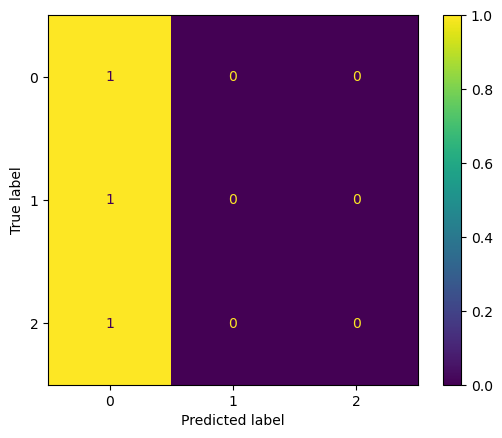

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.55388. Saving Model!
epoch 01, loss: 0.58598, acc: 0.78923, val_loss: 0.55388, val_accuracy: 0.79783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 02, loss: 0.58797, acc: 0.78730, val_loss: 0.55855, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 03, loss: 0.58912, acc: 0.78754, val_loss: 0.55996, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 04, loss: 0.58766, acc: 0.78730, val_loss: 0.55906, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 05, loss: 0.58473, acc: 0.78778, val_loss: 0.55854, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 06, loss: 0.58275, acc: 0.78778, val_loss: 0.56016, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 07, loss: 0.58270, acc: 0.78803, val_loss: 0.56373, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 08, loss: 0.58340, acc: 0.78851, val_loss: 0.56842, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.35it/s]


epoch 09, loss: 0.58320, acc: 0.78923, val_loss: 0.57401, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 10, loss: 0.58168, acc: 0.78996, val_loss: 0.58065, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 11, loss: 0.57985, acc: 0.78947, val_loss: 0.58856, val_accuracy: 0.78261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 12, loss: 0.57892, acc: 0.78803, val_loss: 0.59627, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 13, loss: 0.57898, acc: 0.78803, val_loss: 0.60228, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 14, loss: 0.57899, acc: 0.78827, val_loss: 0.60503, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 15, loss: 0.57813, acc: 0.78827, val_loss: 0.60490, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 16, loss: 0.57671, acc: 0.78947, val_loss: 0.60358, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 17, loss: 0.57559, acc: 0.79020, val_loss: 0.60234, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


epoch 18, loss: 0.57516, acc: 0.79044, val_loss: 0.60242, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 19, loss: 0.57498, acc: 0.79044, val_loss: 0.60373, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 20, loss: 0.57444, acc: 0.79044, val_loss: 0.60711, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 21, loss: 0.57347, acc: 0.79044, val_loss: 0.61235, val_accuracy: 0.77391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 22, loss: 0.57253, acc: 0.79213, val_loss: 0.61857, val_accuracy: 0.77391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 23, loss: 0.57201, acc: 0.79116, val_loss: 0.62362, val_accuracy: 0.77391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 24, loss: 0.57172, acc: 0.79285, val_loss: 0.62585, val_accuracy: 0.77391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]


epoch 25, loss: 0.57116, acc: 0.79261, val_loss: 0.62510, val_accuracy: 0.77391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 26, loss: 0.57033, acc: 0.79285, val_loss: 0.62307, val_accuracy: 0.77391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 27, loss: 0.56957, acc: 0.79237, val_loss: 0.62123, val_accuracy: 0.77391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 28, loss: 0.56906, acc: 0.79334, val_loss: 0.62080, val_accuracy: 0.77391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 29, loss: 0.56865, acc: 0.79334, val_loss: 0.62232, val_accuracy: 0.77391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 30, loss: 0.56814, acc: 0.79358, val_loss: 0.62545, val_accuracy: 0.77391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 31, loss: 0.56746, acc: 0.79358, val_loss: 0.63008, val_accuracy: 0.77391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 32, loss: 0.56674, acc: 0.79310, val_loss: 0.63567, val_accuracy: 0.77391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 33, loss: 0.56613, acc: 0.79285, val_loss: 0.64144, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 34, loss: 0.56561, acc: 0.79310, val_loss: 0.64547, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 35, loss: 0.56508, acc: 0.79358, val_loss: 0.64751, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 36, loss: 0.56441, acc: 0.79406, val_loss: 0.64759, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 37, loss: 0.56373, acc: 0.79358, val_loss: 0.64667, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.65it/s]


epoch 38, loss: 0.56312, acc: 0.79358, val_loss: 0.64639, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 39, loss: 0.56259, acc: 0.79382, val_loss: 0.64835, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 40, loss: 0.56198, acc: 0.79406, val_loss: 0.65252, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 41, loss: 0.56129, acc: 0.79430, val_loss: 0.65774, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 42, loss: 0.56061, acc: 0.79406, val_loss: 0.66212, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 43, loss: 0.56001, acc: 0.79430, val_loss: 0.66499, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 44, loss: 0.55941, acc: 0.79454, val_loss: 0.66615, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 45, loss: 0.55877, acc: 0.79527, val_loss: 0.66639, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 46, loss: 0.55809, acc: 0.79527, val_loss: 0.66675, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 47, loss: 0.55743, acc: 0.79551, val_loss: 0.66777, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 48, loss: 0.55681, acc: 0.79599, val_loss: 0.67013, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


epoch 49, loss: 0.55618, acc: 0.79599, val_loss: 0.67352, val_accuracy: 0.76739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 50, loss: 0.55551, acc: 0.79623, val_loss: 0.67795, val_accuracy: 0.76087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 51, loss: 0.55485, acc: 0.79623, val_loss: 0.68262, val_accuracy: 0.75870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 52, loss: 0.55420, acc: 0.79623, val_loss: 0.68751, val_accuracy: 0.75870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 53, loss: 0.55356, acc: 0.79623, val_loss: 0.69048, val_accuracy: 0.75652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 54, loss: 0.55292, acc: 0.79623, val_loss: 0.69370, val_accuracy: 0.75652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 55, loss: 0.55227, acc: 0.79623, val_loss: 0.69312, val_accuracy: 0.75652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 56, loss: 0.55161, acc: 0.79623, val_loss: 0.69629, val_accuracy: 0.75652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 57, loss: 0.55097, acc: 0.79623, val_loss: 0.69948, val_accuracy: 0.75652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.84it/s]


epoch 58, loss: 0.55033, acc: 0.79623, val_loss: 0.70330, val_accuracy: 0.75435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 59, loss: 0.54968, acc: 0.79623, val_loss: 0.71201, val_accuracy: 0.75217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 60, loss: 0.54909, acc: 0.79623, val_loss: 0.71110, val_accuracy: 0.75217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 61, loss: 0.54842, acc: 0.79623, val_loss: 0.71355, val_accuracy: 0.75000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 62, loss: 0.54780, acc: 0.79648, val_loss: 0.71941, val_accuracy: 0.73913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 63, loss: 0.54719, acc: 0.79696, val_loss: 0.72093, val_accuracy: 0.74130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 64, loss: 0.54652, acc: 0.79720, val_loss: 0.72148, val_accuracy: 0.74130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


epoch 65, loss: 0.54591, acc: 0.79744, val_loss: 0.72719, val_accuracy: 0.74130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 66, loss: 0.54528, acc: 0.79744, val_loss: 0.73201, val_accuracy: 0.73261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.87it/s]


epoch 67, loss: 0.54466, acc: 0.79720, val_loss: 0.72975, val_accuracy: 0.73043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 68, loss: 0.54407, acc: 0.79744, val_loss: 0.73501, val_accuracy: 0.72174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 69, loss: 0.54345, acc: 0.79720, val_loss: 0.74235, val_accuracy: 0.71739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 70, loss: 0.54283, acc: 0.79696, val_loss: 0.74447, val_accuracy: 0.71739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 71, loss: 0.54222, acc: 0.79696, val_loss: 0.73417, val_accuracy: 0.72826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 72, loss: 0.54165, acc: 0.79792, val_loss: 0.73886, val_accuracy: 0.72174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


epoch 73, loss: 0.54101, acc: 0.79841, val_loss: 0.75302, val_accuracy: 0.70435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 74, loss: 0.54041, acc: 0.79768, val_loss: 0.75574, val_accuracy: 0.70217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 75, loss: 0.53979, acc: 0.79865, val_loss: 0.75395, val_accuracy: 0.70217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 76, loss: 0.53918, acc: 0.79889, val_loss: 0.75910, val_accuracy: 0.70217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 77, loss: 0.53860, acc: 0.79865, val_loss: 0.77282, val_accuracy: 0.68478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 78, loss: 0.53803, acc: 0.79817, val_loss: 0.77030, val_accuracy: 0.68478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 79, loss: 0.53738, acc: 0.79841, val_loss: 0.76932, val_accuracy: 0.68478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 80, loss: 0.53679, acc: 0.79841, val_loss: 0.77088, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.29it/s]


epoch 81, loss: 0.53617, acc: 0.79841, val_loss: 0.77523, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 82, loss: 0.53557, acc: 0.79817, val_loss: 0.77474, val_accuracy: 0.67826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 83, loss: 0.53498, acc: 0.79865, val_loss: 0.76790, val_accuracy: 0.68696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 84, loss: 0.53447, acc: 0.79937, val_loss: 0.77790, val_accuracy: 0.66739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 85, loss: 0.53380, acc: 0.79913, val_loss: 0.79441, val_accuracy: 0.65217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 86, loss: 0.53327, acc: 0.79817, val_loss: 0.79323, val_accuracy: 0.65217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 87, loss: 0.53261, acc: 0.79841, val_loss: 0.78424, val_accuracy: 0.66739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 88, loss: 0.53205, acc: 0.79961, val_loss: 0.78868, val_accuracy: 0.66739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 89, loss: 0.53144, acc: 0.79961, val_loss: 0.80402, val_accuracy: 0.63696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 90, loss: 0.53078, acc: 0.79937, val_loss: 0.81183, val_accuracy: 0.63043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 91, loss: 0.53022, acc: 0.79986, val_loss: 0.80324, val_accuracy: 0.64348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 92, loss: 0.52956, acc: 0.79986, val_loss: 0.79903, val_accuracy: 0.64348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 93, loss: 0.52902, acc: 0.80130, val_loss: 0.80641, val_accuracy: 0.64130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 94, loss: 0.52839, acc: 0.80010, val_loss: 0.81289, val_accuracy: 0.63261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 95, loss: 0.52778, acc: 0.80155, val_loss: 0.80476, val_accuracy: 0.65652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 96, loss: 0.52722, acc: 0.80299, val_loss: 0.80798, val_accuracy: 0.65435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 97, loss: 0.52669, acc: 0.80203, val_loss: 0.81723, val_accuracy: 0.62826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


epoch 98, loss: 0.52607, acc: 0.80227, val_loss: 0.82217, val_accuracy: 0.62174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 99, loss: 0.52540, acc: 0.80227, val_loss: 0.82276, val_accuracy: 0.62174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 100, loss: 0.52484, acc: 0.80251, val_loss: 0.82144, val_accuracy: 0.62391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 101, loss: 0.52427, acc: 0.80227, val_loss: 0.82868, val_accuracy: 0.62174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 102, loss: 0.52361, acc: 0.80251, val_loss: 0.83868, val_accuracy: 0.61522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 103, loss: 0.52305, acc: 0.80179, val_loss: 0.83956, val_accuracy: 0.60870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 104, loss: 0.52248, acc: 0.80179, val_loss: 0.83634, val_accuracy: 0.62174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


epoch 105, loss: 0.52186, acc: 0.80203, val_loss: 0.83908, val_accuracy: 0.61087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 106, loss: 0.52124, acc: 0.80227, val_loss: 0.85019, val_accuracy: 0.60870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 107, loss: 0.52075, acc: 0.80203, val_loss: 0.84513, val_accuracy: 0.61087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 108, loss: 0.52012, acc: 0.80227, val_loss: 0.85291, val_accuracy: 0.60870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 109, loss: 0.51952, acc: 0.80227, val_loss: 0.86511, val_accuracy: 0.60435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 110, loss: 0.51899, acc: 0.80227, val_loss: 0.86141, val_accuracy: 0.60435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 111, loss: 0.51836, acc: 0.80203, val_loss: 0.85006, val_accuracy: 0.61087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 112, loss: 0.51785, acc: 0.80227, val_loss: 0.86287, val_accuracy: 0.60217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 113, loss: 0.51722, acc: 0.80275, val_loss: 0.86822, val_accuracy: 0.60217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]


epoch 114, loss: 0.51663, acc: 0.80251, val_loss: 0.87613, val_accuracy: 0.59565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 115, loss: 0.51605, acc: 0.80324, val_loss: 0.88220, val_accuracy: 0.59348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 116, loss: 0.51549, acc: 0.80396, val_loss: 0.88458, val_accuracy: 0.59348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 117, loss: 0.51493, acc: 0.80396, val_loss: 0.88786, val_accuracy: 0.59348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 118, loss: 0.51434, acc: 0.80372, val_loss: 0.88942, val_accuracy: 0.59348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 119, loss: 0.51377, acc: 0.80517, val_loss: 0.88959, val_accuracy: 0.59348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.32it/s]


epoch 120, loss: 0.51321, acc: 0.80517, val_loss: 0.89415, val_accuracy: 0.59348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.26it/s]


epoch 121, loss: 0.51262, acc: 0.80589, val_loss: 0.89742, val_accuracy: 0.59348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 122, loss: 0.51204, acc: 0.80613, val_loss: 0.90173, val_accuracy: 0.59348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 123, loss: 0.51147, acc: 0.80686, val_loss: 0.90465, val_accuracy: 0.59348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 124, loss: 0.51089, acc: 0.80782, val_loss: 0.90765, val_accuracy: 0.59130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 125, loss: 0.51031, acc: 0.80806, val_loss: 0.91136, val_accuracy: 0.59130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 126, loss: 0.50975, acc: 0.80758, val_loss: 0.91213, val_accuracy: 0.59130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 127, loss: 0.50917, acc: 0.80734, val_loss: 0.91978, val_accuracy: 0.58913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 128, loss: 0.50860, acc: 0.80879, val_loss: 0.91924, val_accuracy: 0.59130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.38it/s]


epoch 129, loss: 0.50801, acc: 0.80903, val_loss: 0.92393, val_accuracy: 0.56957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 130, loss: 0.50744, acc: 0.80879, val_loss: 0.92820, val_accuracy: 0.56304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 131, loss: 0.50687, acc: 0.80903, val_loss: 0.92900, val_accuracy: 0.56304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 132, loss: 0.50630, acc: 0.80903, val_loss: 0.93403, val_accuracy: 0.56304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 133, loss: 0.50572, acc: 0.80903, val_loss: 0.94094, val_accuracy: 0.55000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 134, loss: 0.50514, acc: 0.80903, val_loss: 0.94218, val_accuracy: 0.55000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 135, loss: 0.50458, acc: 0.80927, val_loss: 0.95691, val_accuracy: 0.54565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 136, loss: 0.50406, acc: 0.80951, val_loss: 0.94388, val_accuracy: 0.54565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 137, loss: 0.50341, acc: 0.80903, val_loss: 0.93998, val_accuracy: 0.56304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 138, loss: 0.50291, acc: 0.80879, val_loss: 0.97414, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 139, loss: 0.50246, acc: 0.80927, val_loss: 0.95109, val_accuracy: 0.54565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 140, loss: 0.50161, acc: 0.80879, val_loss: 0.93788, val_accuracy: 0.56304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 141, loss: 0.50118, acc: 0.81024, val_loss: 0.96747, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 142, loss: 0.50049, acc: 0.80927, val_loss: 0.96022, val_accuracy: 0.52826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 143, loss: 0.49980, acc: 0.80879, val_loss: 0.93410, val_accuracy: 0.55870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 144, loss: 0.49945, acc: 0.80927, val_loss: 0.95249, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


epoch 145, loss: 0.49864, acc: 0.80879, val_loss: 0.98650, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 146, loss: 0.49828, acc: 0.80951, val_loss: 0.97632, val_accuracy: 0.51087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 147, loss: 0.49743, acc: 0.80831, val_loss: 0.95723, val_accuracy: 0.54130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 148, loss: 0.49714, acc: 0.80951, val_loss: 0.97754, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 149, loss: 0.49626, acc: 0.80855, val_loss: 1.00543, val_accuracy: 0.49565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 150, loss: 0.49617, acc: 0.81048, val_loss: 0.97534, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 151, loss: 0.49517, acc: 0.81096, val_loss: 0.95351, val_accuracy: 0.56087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 152, loss: 0.49506, acc: 0.81000, val_loss: 0.98125, val_accuracy: 0.51304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 153, loss: 0.49403, acc: 0.81048, val_loss: 1.01047, val_accuracy: 0.49130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 154, loss: 0.49376, acc: 0.81024, val_loss: 0.99733, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 155, loss: 0.49291, acc: 0.80927, val_loss: 0.97774, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 156, loss: 0.49269, acc: 0.81048, val_loss: 0.99767, val_accuracy: 0.51522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 157, loss: 0.49186, acc: 0.80975, val_loss: 1.03089, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 158, loss: 0.49155, acc: 0.81048, val_loss: 1.01948, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 159, loss: 0.49079, acc: 0.81096, val_loss: 0.99034, val_accuracy: 0.51522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 160, loss: 0.49042, acc: 0.81120, val_loss: 1.00089, val_accuracy: 0.51522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 161, loss: 0.48969, acc: 0.81096, val_loss: 1.03097, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 162, loss: 0.48927, acc: 0.81217, val_loss: 1.02870, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 163, loss: 0.48865, acc: 0.81193, val_loss: 1.00405, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 164, loss: 0.48813, acc: 0.81217, val_loss: 1.00884, val_accuracy: 0.51522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 165, loss: 0.48754, acc: 0.81144, val_loss: 1.03723, val_accuracy: 0.46739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 166, loss: 0.48703, acc: 0.81120, val_loss: 1.04118, val_accuracy: 0.46522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 167, loss: 0.48647, acc: 0.81120, val_loss: 1.02362, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 168, loss: 0.48593, acc: 0.81144, val_loss: 1.02681, val_accuracy: 0.51087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 169, loss: 0.48539, acc: 0.81217, val_loss: 1.05060, val_accuracy: 0.46957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 170, loss: 0.48483, acc: 0.81096, val_loss: 1.05033, val_accuracy: 0.46957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 171, loss: 0.48426, acc: 0.81169, val_loss: 1.03359, val_accuracy: 0.49783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 172, loss: 0.48377, acc: 0.81265, val_loss: 1.04079, val_accuracy: 0.48261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 173, loss: 0.48318, acc: 0.81289, val_loss: 1.06211, val_accuracy: 0.46087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 174, loss: 0.48273, acc: 0.81241, val_loss: 1.05978, val_accuracy: 0.46739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 175, loss: 0.48212, acc: 0.81313, val_loss: 1.04708, val_accuracy: 0.48913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 176, loss: 0.48166, acc: 0.81338, val_loss: 1.05967, val_accuracy: 0.46522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.29it/s]


epoch 177, loss: 0.48105, acc: 0.81362, val_loss: 1.08153, val_accuracy: 0.46087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 178, loss: 0.48064, acc: 0.81338, val_loss: 1.06968, val_accuracy: 0.46304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 179, loss: 0.47999, acc: 0.81434, val_loss: 1.05630, val_accuracy: 0.48261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 180, loss: 0.47957, acc: 0.81386, val_loss: 1.07418, val_accuracy: 0.46304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 181, loss: 0.47894, acc: 0.81458, val_loss: 1.08784, val_accuracy: 0.45870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 182, loss: 0.47847, acc: 0.81482, val_loss: 1.07978, val_accuracy: 0.46304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 183, loss: 0.47789, acc: 0.81434, val_loss: 1.08044, val_accuracy: 0.46304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 184, loss: 0.47740, acc: 0.81482, val_loss: 1.09759, val_accuracy: 0.45870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]


epoch 185, loss: 0.47681, acc: 0.81507, val_loss: 1.09875, val_accuracy: 0.45870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 186, loss: 0.47629, acc: 0.81458, val_loss: 1.08843, val_accuracy: 0.46957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 187, loss: 0.47583, acc: 0.81482, val_loss: 1.09812, val_accuracy: 0.45870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 188, loss: 0.47523, acc: 0.81531, val_loss: 1.11185, val_accuracy: 0.45870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 189, loss: 0.47477, acc: 0.81555, val_loss: 1.10076, val_accuracy: 0.45870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 190, loss: 0.47418, acc: 0.81507, val_loss: 1.10205, val_accuracy: 0.46087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 191, loss: 0.47365, acc: 0.81507, val_loss: 1.11688, val_accuracy: 0.45435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 192, loss: 0.47318, acc: 0.81603, val_loss: 1.11494, val_accuracy: 0.45435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 193, loss: 0.47261, acc: 0.81507, val_loss: 1.10921, val_accuracy: 0.45870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]


epoch 194, loss: 0.47212, acc: 0.81555, val_loss: 1.12624, val_accuracy: 0.45000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 195, loss: 0.47157, acc: 0.81507, val_loss: 1.13195, val_accuracy: 0.45000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 196, loss: 0.47104, acc: 0.81531, val_loss: 1.12393, val_accuracy: 0.45652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 197, loss: 0.47057, acc: 0.81627, val_loss: 1.13532, val_accuracy: 0.44783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 198, loss: 0.47000, acc: 0.81700, val_loss: 1.15299, val_accuracy: 0.43913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 199, loss: 0.46952, acc: 0.81772, val_loss: 1.14498, val_accuracy: 0.43913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 200, loss: 0.46895, acc: 0.81724, val_loss: 1.14128, val_accuracy: 0.44783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 201, loss: 0.46845, acc: 0.81820, val_loss: 1.15748, val_accuracy: 0.43261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 202, loss: 0.46795, acc: 0.81845, val_loss: 1.14831, val_accuracy: 0.44130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 203, loss: 0.46737, acc: 0.81893, val_loss: 1.14643, val_accuracy: 0.44130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 204, loss: 0.46687, acc: 0.81869, val_loss: 1.16135, val_accuracy: 0.43261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 205, loss: 0.46637, acc: 0.81965, val_loss: 1.15898, val_accuracy: 0.43913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 206, loss: 0.46584, acc: 0.82014, val_loss: 1.15826, val_accuracy: 0.43913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 207, loss: 0.46535, acc: 0.81869, val_loss: 1.18085, val_accuracy: 0.42826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 208, loss: 0.46485, acc: 0.82255, val_loss: 1.17463, val_accuracy: 0.43043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 209, loss: 0.46429, acc: 0.82158, val_loss: 1.17760, val_accuracy: 0.43696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 210, loss: 0.46375, acc: 0.82158, val_loss: 1.18206, val_accuracy: 0.43478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 211, loss: 0.46325, acc: 0.82231, val_loss: 1.19245, val_accuracy: 0.41957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 212, loss: 0.46279, acc: 0.82327, val_loss: 1.18364, val_accuracy: 0.43696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.54it/s]


epoch 213, loss: 0.46228, acc: 0.82110, val_loss: 1.19854, val_accuracy: 0.41739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 214, loss: 0.46176, acc: 0.82279, val_loss: 1.19692, val_accuracy: 0.42826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]

epoch 215, loss: 0.46125, acc: 0.82279, val_loss: 1.19697, val_accuracy: 0.42826



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 216, loss: 0.46074, acc: 0.82231, val_loss: 1.20860, val_accuracy: 0.41304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.29it/s]


epoch 217, loss: 0.46026, acc: 0.82279, val_loss: 1.20500, val_accuracy: 0.42174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 218, loss: 0.45975, acc: 0.82424, val_loss: 1.21939, val_accuracy: 0.40652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 219, loss: 0.45925, acc: 0.82448, val_loss: 1.21180, val_accuracy: 0.41957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 220, loss: 0.45877, acc: 0.82448, val_loss: 1.21867, val_accuracy: 0.41304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


epoch 221, loss: 0.45825, acc: 0.82521, val_loss: 1.23055, val_accuracy: 0.40435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]

epoch 222, loss: 0.45777, acc: 0.82448, val_loss: 1.22303, val_accuracy: 0.41304

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 223, loss: 0.45728, acc: 0.82521, val_loss: 1.23942, val_accuracy: 0.40000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 224, loss: 0.45678, acc: 0.82593, val_loss: 1.23663, val_accuracy: 0.40217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


epoch 225, loss: 0.45627, acc: 0.83052, val_loss: 1.22957, val_accuracy: 0.40870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 226, loss: 0.45579, acc: 0.82907, val_loss: 1.24716, val_accuracy: 0.40000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 227, loss: 0.45529, acc: 0.82955, val_loss: 1.24955, val_accuracy: 0.39565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 228, loss: 0.45477, acc: 0.83003, val_loss: 1.25819, val_accuracy: 0.39565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 229, loss: 0.45426, acc: 0.82931, val_loss: 1.26680, val_accuracy: 0.39565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 230, loss: 0.45380, acc: 0.82834, val_loss: 1.25495, val_accuracy: 0.40217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 231, loss: 0.45330, acc: 0.83003, val_loss: 1.25498, val_accuracy: 0.40217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.92it/s]

epoch 232, loss: 0.45282, acc: 0.82979, val_loss: 1.26983, val_accuracy: 0.39565

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.92it/s]


epoch 233, loss: 0.45233, acc: 0.82979, val_loss: 1.26431, val_accuracy: 0.40217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.75it/s]


epoch 234, loss: 0.45183, acc: 0.83028, val_loss: 1.28010, val_accuracy: 0.39565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 235, loss: 0.45131, acc: 0.82931, val_loss: 1.28544, val_accuracy: 0.39565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 236, loss: 0.45086, acc: 0.82955, val_loss: 1.26619, val_accuracy: 0.40217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 237, loss: 0.45040, acc: 0.83052, val_loss: 1.28635, val_accuracy: 0.39130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 238, loss: 0.44991, acc: 0.83003, val_loss: 1.28414, val_accuracy: 0.39783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 239, loss: 0.44937, acc: 0.82979, val_loss: 1.27745, val_accuracy: 0.39783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 240, loss: 0.44894, acc: 0.83028, val_loss: 1.31063, val_accuracy: 0.38696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


epoch 241, loss: 0.44840, acc: 0.83076, val_loss: 1.30374, val_accuracy: 0.38696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 242, loss: 0.44786, acc: 0.83028, val_loss: 1.30175, val_accuracy: 0.39348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 243, loss: 0.44736, acc: 0.83052, val_loss: 1.31987, val_accuracy: 0.38696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 244, loss: 0.44686, acc: 0.83076, val_loss: 1.30536, val_accuracy: 0.39348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 245, loss: 0.44632, acc: 0.83052, val_loss: 1.31333, val_accuracy: 0.39348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.82it/s]


epoch 246, loss: 0.44578, acc: 0.83172, val_loss: 1.31715, val_accuracy: 0.39348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 247, loss: 0.44528, acc: 0.83197, val_loss: 1.31453, val_accuracy: 0.39348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 248, loss: 0.44483, acc: 0.83124, val_loss: 1.33800, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 249, loss: 0.44431, acc: 0.83172, val_loss: 1.33379, val_accuracy: 0.39348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]


epoch 250, loss: 0.44381, acc: 0.83197, val_loss: 1.34695, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 251, loss: 0.44329, acc: 0.83317, val_loss: 1.33994, val_accuracy: 0.39130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 252, loss: 0.44281, acc: 0.83269, val_loss: 1.34158, val_accuracy: 0.38696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 253, loss: 0.44227, acc: 0.83366, val_loss: 1.34523, val_accuracy: 0.38478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 254, loss: 0.44177, acc: 0.83317, val_loss: 1.35458, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 255, loss: 0.44126, acc: 0.83366, val_loss: 1.35709, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 256, loss: 0.44078, acc: 0.83366, val_loss: 1.36811, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 257, loss: 0.44024, acc: 0.83438, val_loss: 1.36057, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 258, loss: 0.43978, acc: 0.83414, val_loss: 1.36845, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 259, loss: 0.43926, acc: 0.83535, val_loss: 1.36152, val_accuracy: 0.38043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 260, loss: 0.43873, acc: 0.83414, val_loss: 1.37291, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 261, loss: 0.43823, acc: 0.83486, val_loss: 1.37651, val_accuracy: 0.38043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 262, loss: 0.43772, acc: 0.83486, val_loss: 1.37253, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 263, loss: 0.43723, acc: 0.83510, val_loss: 1.39512, val_accuracy: 0.38478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 264, loss: 0.43673, acc: 0.83607, val_loss: 1.38474, val_accuracy: 0.38043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


epoch 265, loss: 0.43619, acc: 0.83462, val_loss: 1.40221, val_accuracy: 0.38043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 266, loss: 0.43571, acc: 0.83583, val_loss: 1.38868, val_accuracy: 0.38043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 267, loss: 0.43516, acc: 0.83607, val_loss: 1.38665, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.99it/s]


epoch 268, loss: 0.43470, acc: 0.83655, val_loss: 1.41108, val_accuracy: 0.38478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 269, loss: 0.43419, acc: 0.83631, val_loss: 1.39711, val_accuracy: 0.38043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 270, loss: 0.43373, acc: 0.83655, val_loss: 1.42814, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 271, loss: 0.43322, acc: 0.83631, val_loss: 1.41139, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 272, loss: 0.43267, acc: 0.83655, val_loss: 1.41673, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


epoch 273, loss: 0.43214, acc: 0.83728, val_loss: 1.43608, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 274, loss: 0.43172, acc: 0.83800, val_loss: 1.41289, val_accuracy: 0.38478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 275, loss: 0.43124, acc: 0.83752, val_loss: 1.44186, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 276, loss: 0.43074, acc: 0.83800, val_loss: 1.42110, val_accuracy: 0.38478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 277, loss: 0.43022, acc: 0.83824, val_loss: 1.44463, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 278, loss: 0.42965, acc: 0.83848, val_loss: 1.45349, val_accuracy: 0.38478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 279, loss: 0.42918, acc: 0.83848, val_loss: 1.44018, val_accuracy: 0.38696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 280, loss: 0.42874, acc: 0.83921, val_loss: 1.47122, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


epoch 281, loss: 0.42822, acc: 0.83969, val_loss: 1.45549, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 282, loss: 0.42773, acc: 0.83897, val_loss: 1.46594, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 283, loss: 0.42721, acc: 0.83969, val_loss: 1.46609, val_accuracy: 0.38478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 284, loss: 0.42670, acc: 0.83945, val_loss: 1.46587, val_accuracy: 0.38478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 285, loss: 0.42626, acc: 0.83969, val_loss: 1.49480, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 286, loss: 0.42578, acc: 0.84042, val_loss: 1.47228, val_accuracy: 0.38478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 287, loss: 0.42529, acc: 0.83945, val_loss: 1.50198, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 288, loss: 0.42479, acc: 0.84259, val_loss: 1.48745, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 289, loss: 0.42431, acc: 0.83993, val_loss: 1.51646, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


epoch 290, loss: 0.42384, acc: 0.84259, val_loss: 1.47708, val_accuracy: 0.38913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 291, loss: 0.42337, acc: 0.83969, val_loss: 1.52072, val_accuracy: 0.37391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 292, loss: 0.42282, acc: 0.84283, val_loss: 1.50989, val_accuracy: 0.38043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.38it/s]


epoch 293, loss: 0.42230, acc: 0.84211, val_loss: 1.52916, val_accuracy: 0.37174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 294, loss: 0.42175, acc: 0.84307, val_loss: 1.49590, val_accuracy: 0.39565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


epoch 295, loss: 0.42134, acc: 0.84186, val_loss: 1.54196, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 296, loss: 0.42087, acc: 0.84307, val_loss: 1.51505, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


epoch 297, loss: 0.42046, acc: 0.84186, val_loss: 1.57151, val_accuracy: 0.35870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 298, loss: 0.41999, acc: 0.84355, val_loss: 1.50205, val_accuracy: 0.39783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 299, loss: 0.41958, acc: 0.84283, val_loss: 1.56754, val_accuracy: 0.36087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 300, loss: 0.41893, acc: 0.84476, val_loss: 1.52980, val_accuracy: 0.39565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 301, loss: 0.41842, acc: 0.84259, val_loss: 1.58075, val_accuracy: 0.36087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 302, loss: 0.41782, acc: 0.84380, val_loss: 1.53903, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 303, loss: 0.41723, acc: 0.84428, val_loss: 1.56264, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 304, loss: 0.41663, acc: 0.84355, val_loss: 1.56815, val_accuracy: 0.37391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 305, loss: 0.41613, acc: 0.84380, val_loss: 1.56577, val_accuracy: 0.37174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 306, loss: 0.41562, acc: 0.84380, val_loss: 1.57949, val_accuracy: 0.36522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 307, loss: 0.41507, acc: 0.84476, val_loss: 1.56007, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 308, loss: 0.41463, acc: 0.84307, val_loss: 1.60467, val_accuracy: 0.36304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 309, loss: 0.41424, acc: 0.84452, val_loss: 1.54942, val_accuracy: 0.38913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 310, loss: 0.41410, acc: 0.84235, val_loss: 1.64029, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 311, loss: 0.41382, acc: 0.84693, val_loss: 1.53907, val_accuracy: 0.39130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 312, loss: 0.41363, acc: 0.84211, val_loss: 1.63158, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]


epoch 313, loss: 0.41266, acc: 0.84718, val_loss: 1.57025, val_accuracy: 0.38261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 314, loss: 0.41180, acc: 0.84428, val_loss: 1.61787, val_accuracy: 0.35870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 315, loss: 0.41093, acc: 0.84573, val_loss: 1.62851, val_accuracy: 0.35435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 316, loss: 0.41051, acc: 0.84597, val_loss: 1.57710, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 317, loss: 0.41034, acc: 0.84428, val_loss: 1.65771, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 318, loss: 0.41016, acc: 0.84935, val_loss: 1.57644, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.13it/s]


epoch 319, loss: 0.40998, acc: 0.84404, val_loss: 1.67023, val_accuracy: 0.32826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 320, loss: 0.40913, acc: 0.84742, val_loss: 1.59491, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.35it/s]


epoch 321, loss: 0.40841, acc: 0.84476, val_loss: 1.65059, val_accuracy: 0.35652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 322, loss: 0.40760, acc: 0.84742, val_loss: 1.65081, val_accuracy: 0.35870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 323, loss: 0.40700, acc: 0.84742, val_loss: 1.64034, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 324, loss: 0.40659, acc: 0.84621, val_loss: 1.67746, val_accuracy: 0.32609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 325, loss: 0.40637, acc: 0.84814, val_loss: 1.60109, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 326, loss: 0.40635, acc: 0.84524, val_loss: 1.71015, val_accuracy: 0.32391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 327, loss: 0.40605, acc: 0.85056, val_loss: 1.61487, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 328, loss: 0.40579, acc: 0.84597, val_loss: 1.71629, val_accuracy: 0.32609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 329, loss: 0.40492, acc: 0.85080, val_loss: 1.64294, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


epoch 330, loss: 0.40398, acc: 0.84621, val_loss: 1.69612, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 331, loss: 0.40316, acc: 0.84935, val_loss: 1.69102, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 332, loss: 0.40260, acc: 0.85031, val_loss: 1.65626, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 333, loss: 0.40234, acc: 0.84742, val_loss: 1.72208, val_accuracy: 0.32609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 334, loss: 0.40221, acc: 0.85176, val_loss: 1.64342, val_accuracy: 0.37174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]

epoch 335, loss: 0.40216, acc: 0.84718, val_loss: 1.75098, val_accuracy: 0.32174

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 336, loss: 0.40196, acc: 0.85200, val_loss: 1.63777, val_accuracy: 0.37391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 337, loss: 0.40193, acc: 0.84742, val_loss: 1.76168, val_accuracy: 0.31087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 338, loss: 0.40111, acc: 0.85225, val_loss: 1.66441, val_accuracy: 0.37391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 339, loss: 0.40040, acc: 0.84838, val_loss: 1.75247, val_accuracy: 0.33696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 340, loss: 0.39937, acc: 0.85152, val_loss: 1.69479, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 341, loss: 0.39858, acc: 0.85080, val_loss: 1.72804, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 342, loss: 0.39795, acc: 0.85176, val_loss: 1.74523, val_accuracy: 0.36522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 343, loss: 0.39756, acc: 0.85273, val_loss: 1.70654, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 344, loss: 0.39736, acc: 0.84959, val_loss: 1.78078, val_accuracy: 0.32609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 345, loss: 0.39739, acc: 0.85321, val_loss: 1.67524, val_accuracy: 0.37174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]

epoch 346, loss: 0.39791, acc: 0.84887, val_loss: 1.81860, val_accuracy: 0.30652

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 347, loss: 0.39795, acc: 0.85249, val_loss: 1.66649, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 348, loss: 0.39855, acc: 0.84790, val_loss: 1.84142, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


epoch 349, loss: 0.39739, acc: 0.85394, val_loss: 1.69600, val_accuracy: 0.37391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.94it/s]


epoch 350, loss: 0.39634, acc: 0.85007, val_loss: 1.80652, val_accuracy: 0.33261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 351, loss: 0.39463, acc: 0.85369, val_loss: 1.74769, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 352, loss: 0.39355, acc: 0.85152, val_loss: 1.76700, val_accuracy: 0.36522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


epoch 353, loss: 0.39295, acc: 0.85345, val_loss: 1.80000, val_accuracy: 0.35870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 354, loss: 0.39264, acc: 0.85466, val_loss: 1.74979, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 355, loss: 0.39269, acc: 0.85031, val_loss: 1.84897, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 356, loss: 0.39299, acc: 0.85442, val_loss: 1.71199, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 357, loss: 0.39410, acc: 0.85031, val_loss: 1.89293, val_accuracy: 0.29783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 358, loss: 0.39478, acc: 0.85563, val_loss: 1.68791, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 359, loss: 0.39643, acc: 0.84838, val_loss: 1.91101, val_accuracy: 0.29565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 360, loss: 0.39473, acc: 0.85683, val_loss: 1.71199, val_accuracy: 0.37826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 361, loss: 0.39357, acc: 0.84983, val_loss: 1.86817, val_accuracy: 0.33043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 362, loss: 0.39059, acc: 0.85538, val_loss: 1.80046, val_accuracy: 0.36522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 363, loss: 0.38880, acc: 0.85249, val_loss: 1.82629, val_accuracy: 0.36304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 364, loss: 0.38818, acc: 0.85369, val_loss: 1.88305, val_accuracy: 0.33261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 365, loss: 0.38842, acc: 0.85587, val_loss: 1.76601, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 366, loss: 0.38948, acc: 0.85031, val_loss: 1.92498, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 367, loss: 0.39055, acc: 0.85949, val_loss: 1.72219, val_accuracy: 0.37609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 368, loss: 0.39300, acc: 0.84887, val_loss: 1.95613, val_accuracy: 0.30217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


epoch 369, loss: 0.39191, acc: 0.85852, val_loss: 1.72877, val_accuracy: 0.37391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 370, loss: 0.39167, acc: 0.85007, val_loss: 1.93614, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 371, loss: 0.38822, acc: 0.85925, val_loss: 1.82193, val_accuracy: 0.36304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 372, loss: 0.38597, acc: 0.85297, val_loss: 1.89063, val_accuracy: 0.36087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 373, loss: 0.38440, acc: 0.85756, val_loss: 1.89314, val_accuracy: 0.35870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.80it/s]


epoch 374, loss: 0.38411, acc: 0.85828, val_loss: 1.81920, val_accuracy: 0.36522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 375, loss: 0.38480, acc: 0.85321, val_loss: 1.96320, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 376, loss: 0.38590, acc: 0.86094, val_loss: 1.78248, val_accuracy: 0.37174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]


epoch 377, loss: 0.38815, acc: 0.84983, val_loss: 2.00288, val_accuracy: 0.30000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 378, loss: 0.38800, acc: 0.86021, val_loss: 1.76157, val_accuracy: 0.37174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 379, loss: 0.38917, acc: 0.84935, val_loss: 1.99248, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 380, loss: 0.38624, acc: 0.85997, val_loss: 1.81941, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 381, loss: 0.38401, acc: 0.85297, val_loss: 1.94564, val_accuracy: 0.35217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 382, loss: 0.38133, acc: 0.85949, val_loss: 1.90422, val_accuracy: 0.36087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 383, loss: 0.38015, acc: 0.85901, val_loss: 1.87851, val_accuracy: 0.36304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 384, loss: 0.38024, acc: 0.85611, val_loss: 1.99233, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 385, loss: 0.38122, acc: 0.86239, val_loss: 1.83809, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 386, loss: 0.38347, acc: 0.85128, val_loss: 2.04781, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 387, loss: 0.38455, acc: 0.86214, val_loss: 1.78223, val_accuracy: 0.37174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 388, loss: 0.38819, acc: 0.84983, val_loss: 2.05885, val_accuracy: 0.29348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 389, loss: 0.38580, acc: 0.86045, val_loss: 1.80987, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 390, loss: 0.38442, acc: 0.85225, val_loss: 2.01738, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 391, loss: 0.37953, acc: 0.86239, val_loss: 1.92439, val_accuracy: 0.36304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 392, loss: 0.37683, acc: 0.85828, val_loss: 1.92099, val_accuracy: 0.36304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


epoch 393, loss: 0.37635, acc: 0.85780, val_loss: 2.01610, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 394, loss: 0.37783, acc: 0.86239, val_loss: 1.85107, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 395, loss: 0.38096, acc: 0.85152, val_loss: 2.10111, val_accuracy: 0.29565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 396, loss: 0.38236, acc: 0.86142, val_loss: 1.81306, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 397, loss: 0.38556, acc: 0.85080, val_loss: 2.08023, val_accuracy: 0.31087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 398, loss: 0.38144, acc: 0.86190, val_loss: 1.86738, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 399, loss: 0.37860, acc: 0.85418, val_loss: 2.02984, val_accuracy: 0.32609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 400, loss: 0.37447, acc: 0.86408, val_loss: 1.97387, val_accuracy: 0.36087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 401, loss: 0.37294, acc: 0.86190, val_loss: 1.92392, val_accuracy: 0.36087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]

epoch 402, loss: 0.37358, acc: 0.85780, val_loss: 2.07348, val_accuracy: 0.31304



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 403, loss: 0.37545, acc: 0.86456, val_loss: 1.87648, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 404, loss: 0.37879, acc: 0.85273, val_loss: 2.13393, val_accuracy: 0.31087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 405, loss: 0.37864, acc: 0.86263, val_loss: 1.87044, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 406, loss: 0.37966, acc: 0.85104, val_loss: 2.10005, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 407, loss: 0.37544, acc: 0.86408, val_loss: 1.93775, val_accuracy: 0.36522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 408, loss: 0.37244, acc: 0.85876, val_loss: 2.03689, val_accuracy: 0.35652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


epoch 409, loss: 0.37001, acc: 0.86480, val_loss: 2.04618, val_accuracy: 0.33043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 410, loss: 0.36959, acc: 0.86480, val_loss: 1.95398, val_accuracy: 0.36522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 411, loss: 0.37071, acc: 0.85997, val_loss: 2.10164, val_accuracy: 0.31304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 412, loss: 0.37224, acc: 0.86408, val_loss: 1.90320, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 413, loss: 0.37526, acc: 0.85466, val_loss: 2.15938, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 414, loss: 0.37509, acc: 0.86359, val_loss: 1.88894, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 415, loss: 0.37692, acc: 0.85442, val_loss: 2.14576, val_accuracy: 0.31087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.87it/s]


epoch 416, loss: 0.37325, acc: 0.86408, val_loss: 1.94639, val_accuracy: 0.36522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.29it/s]


epoch 417, loss: 0.37076, acc: 0.85828, val_loss: 2.09525, val_accuracy: 0.32826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 418, loss: 0.36730, acc: 0.86432, val_loss: 2.06088, val_accuracy: 0.35652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 419, loss: 0.36600, acc: 0.86383, val_loss: 2.01069, val_accuracy: 0.36087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 420, loss: 0.36655, acc: 0.86070, val_loss: 2.13844, val_accuracy: 0.31087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 421, loss: 0.36791, acc: 0.86746, val_loss: 1.96042, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]

epoch 422, loss: 0.37047, acc: 0.85635, val_loss: 2.18819, val_accuracy: 0.30652

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 423, loss: 0.37119, acc: 0.86456, val_loss: 1.91830, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 424, loss: 0.37336, acc: 0.85538, val_loss: 2.17532, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 425, loss: 0.37039, acc: 0.86552, val_loss: 1.96738, val_accuracy: 0.36522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


epoch 426, loss: 0.36879, acc: 0.85780, val_loss: 2.14891, val_accuracy: 0.32174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 427, loss: 0.36494, acc: 0.86721, val_loss: 2.05842, val_accuracy: 0.35652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 428, loss: 0.36294, acc: 0.86408, val_loss: 2.06190, val_accuracy: 0.35435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 429, loss: 0.36247, acc: 0.86383, val_loss: 2.15238, val_accuracy: 0.32174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 430, loss: 0.36337, acc: 0.86818, val_loss: 2.01456, val_accuracy: 0.36522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 431, loss: 0.36528, acc: 0.85901, val_loss: 2.21634, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 432, loss: 0.36676, acc: 0.86673, val_loss: 1.95418, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 433, loss: 0.37105, acc: 0.85635, val_loss: 2.24625, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 434, loss: 0.36975, acc: 0.86697, val_loss: 1.96465, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 435, loss: 0.36970, acc: 0.85756, val_loss: 2.21596, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 436, loss: 0.36440, acc: 0.86649, val_loss: 2.04931, val_accuracy: 0.36087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 437, loss: 0.36118, acc: 0.86239, val_loss: 2.11545, val_accuracy: 0.35217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 438, loss: 0.35903, acc: 0.86697, val_loss: 2.15565, val_accuracy: 0.35000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.54it/s]


epoch 439, loss: 0.35932, acc: 0.86987, val_loss: 2.06942, val_accuracy: 0.36087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 440, loss: 0.36150, acc: 0.86166, val_loss: 2.27457, val_accuracy: 0.31957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 441, loss: 0.36393, acc: 0.86697, val_loss: 1.96537, val_accuracy: 0.36957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


epoch 442, loss: 0.36852, acc: 0.85611, val_loss: 2.25965, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 443, loss: 0.36758, acc: 0.87011, val_loss: 1.99240, val_accuracy: 0.36739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


epoch 444, loss: 0.36915, acc: 0.85563, val_loss: 2.28233, val_accuracy: 0.31957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


epoch 445, loss: 0.36250, acc: 0.86842, val_loss: 2.05657, val_accuracy: 0.35870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 446, loss: 0.35811, acc: 0.86504, val_loss: 2.09566, val_accuracy: 0.35217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 447, loss: 0.35616, acc: 0.86673, val_loss: 2.19896, val_accuracy: 0.32174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 448, loss: 0.35685, acc: 0.86794, val_loss: 2.10292, val_accuracy: 0.36087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.38it/s]


epoch 449, loss: 0.35883, acc: 0.86142, val_loss: 2.29948, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 450, loss: 0.36061, acc: 0.87035, val_loss: 2.01656, val_accuracy: 0.36522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 451, loss: 0.36438, acc: 0.85852, val_loss: 2.29572, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 452, loss: 0.36313, acc: 0.86866, val_loss: 2.02333, val_accuracy: 0.36522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 453, loss: 0.36228, acc: 0.86045, val_loss: 2.28578, val_accuracy: 0.30435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 454, loss: 0.35772, acc: 0.87084, val_loss: 2.15523, val_accuracy: 0.35217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 455, loss: 0.35484, acc: 0.86649, val_loss: 2.18706, val_accuracy: 0.34783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 456, loss: 0.35290, acc: 0.86987, val_loss: 2.19014, val_accuracy: 0.33478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


epoch 457, loss: 0.35338, acc: 0.87156, val_loss: 2.11165, val_accuracy: 0.35870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 458, loss: 0.35502, acc: 0.86287, val_loss: 2.35829, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 459, loss: 0.35819, acc: 0.87035, val_loss: 2.05647, val_accuracy: 0.36522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 460, loss: 0.36291, acc: 0.85780, val_loss: 2.35670, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 461, loss: 0.36126, acc: 0.87349, val_loss: 2.06864, val_accuracy: 0.36304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 462, loss: 0.36174, acc: 0.85925, val_loss: 2.34805, val_accuracy: 0.32174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 463, loss: 0.35565, acc: 0.86963, val_loss: 2.14458, val_accuracy: 0.35217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 464, loss: 0.35164, acc: 0.86552, val_loss: 2.18664, val_accuracy: 0.35435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 465, loss: 0.35009, acc: 0.87059, val_loss: 2.30006, val_accuracy: 0.32391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 466, loss: 0.35152, acc: 0.86890, val_loss: 2.12446, val_accuracy: 0.35652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 467, loss: 0.35410, acc: 0.86166, val_loss: 2.35831, val_accuracy: 0.29130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 468, loss: 0.35573, acc: 0.87349, val_loss: 2.11893, val_accuracy: 0.35870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 469, loss: 0.35890, acc: 0.85852, val_loss: 2.42154, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 470, loss: 0.35639, acc: 0.87277, val_loss: 2.09653, val_accuracy: 0.36304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 471, loss: 0.35437, acc: 0.86142, val_loss: 2.28395, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 472, loss: 0.35016, acc: 0.87277, val_loss: 2.24581, val_accuracy: 0.35000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 473, loss: 0.34817, acc: 0.86939, val_loss: 2.26826, val_accuracy: 0.32391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 474, loss: 0.34696, acc: 0.87132, val_loss: 2.30326, val_accuracy: 0.30652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 475, loss: 0.34838, acc: 0.87542, val_loss: 2.16782, val_accuracy: 0.35652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 476, loss: 0.35011, acc: 0.86480, val_loss: 2.42403, val_accuracy: 0.31957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 477, loss: 0.35276, acc: 0.87373, val_loss: 2.11798, val_accuracy: 0.35870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 478, loss: 0.35603, acc: 0.85949, val_loss: 2.42685, val_accuracy: 0.28261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 479, loss: 0.35526, acc: 0.87711, val_loss: 2.15043, val_accuracy: 0.35652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 480, loss: 0.35670, acc: 0.86118, val_loss: 2.41561, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 481, loss: 0.35072, acc: 0.87204, val_loss: 2.18469, val_accuracy: 0.35000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


epoch 482, loss: 0.34725, acc: 0.86721, val_loss: 2.25315, val_accuracy: 0.35000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 483, loss: 0.34483, acc: 0.87228, val_loss: 2.42719, val_accuracy: 0.32174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 484, loss: 0.34826, acc: 0.87204, val_loss: 2.15308, val_accuracy: 0.35652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 485, loss: 0.35142, acc: 0.86287, val_loss: 2.41122, val_accuracy: 0.27609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 486, loss: 0.35482, acc: 0.87397, val_loss: 2.15533, val_accuracy: 0.35870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 487, loss: 0.35829, acc: 0.85973, val_loss: 2.53055, val_accuracy: 0.30000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 488, loss: 0.35317, acc: 0.87059, val_loss: 2.16930, val_accuracy: 0.35435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 489, loss: 0.34758, acc: 0.86480, val_loss: 2.25444, val_accuracy: 0.33696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.74it/s]


epoch 490, loss: 0.34449, acc: 0.87253, val_loss: 2.37407, val_accuracy: 0.32391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 491, loss: 0.34486, acc: 0.87277, val_loss: 2.27008, val_accuracy: 0.35217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 492, loss: 0.34548, acc: 0.86721, val_loss: 2.43224, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.10it/s]


epoch 493, loss: 0.34799, acc: 0.87808, val_loss: 2.19116, val_accuracy: 0.35870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


epoch 494, loss: 0.34902, acc: 0.86335, val_loss: 2.48629, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 495, loss: 0.34791, acc: 0.87156, val_loss: 2.21870, val_accuracy: 0.35000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 496, loss: 0.34400, acc: 0.86794, val_loss: 2.36760, val_accuracy: 0.31522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 497, loss: 0.34197, acc: 0.87929, val_loss: 2.36055, val_accuracy: 0.32609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


epoch 498, loss: 0.33977, acc: 0.87542, val_loss: 2.33315, val_accuracy: 0.32609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 499, loss: 0.33967, acc: 0.87494, val_loss: 2.36341, val_accuracy: 0.31739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 500, loss: 0.34034, acc: 0.87663, val_loss: 2.26154, val_accuracy: 0.35000
7번째 교차검증
evaluation loss: 0.55388, evaluation accuracy: 0.79783
(5, 460)
(460, 5)
Learning rate set to 0.055397
0:	learn: 1.0494032	total: 8.3ms	remaining: 8.3s
1:	learn: 1.0063579	total: 16.1ms	remaining: 8.06s
2:	learn: 0.9675374	total: 22.8ms	remaining: 7.58s
3:	learn: 0.9332427	total: 31.2ms	remaining: 7.76s
4:	learn: 0.9034639	total: 38.2ms	remaining: 7.6s
5:	learn: 0.8768279	total: 46ms	remaining: 7.63s
6:	learn: 0.8529179	total: 52.7ms	remaining: 7.47s
7:	learn: 0.8313888	total: 59.3ms	remaining: 7.35s
8:	learn: 0.8119515	total: 67.3ms	remaining: 7.42s
9:	learn: 0.7943616	total: 74.3ms	remaining: 7.35s
10:	learn: 0.7784106	total: 84.1ms	remaining: 7.56s
11:	learn: 0.7635568	total: 90.9ms	remaining: 7.49s
12:	learn: 0.7503976	total: 98.9ms	remaining: 7.51s
13:	learn: 0.7384054	total: 105ms	remaining: 7.43s
14:	learn: 0.7274629	total: 113ms	remaining: 7.41s
15:	learn: 0.7174661	total: 119ms	remaining:

171:	learn: 0.5942082	total: 1.23s	remaining: 5.9s
172:	learn: 0.5941844	total: 1.23s	remaining: 5.89s
173:	learn: 0.5941609	total: 1.24s	remaining: 5.88s
174:	learn: 0.5941377	total: 1.25s	remaining: 5.88s
175:	learn: 0.5941149	total: 1.25s	remaining: 5.87s
176:	learn: 0.5940923	total: 1.26s	remaining: 5.86s
177:	learn: 0.5940700	total: 1.27s	remaining: 5.86s
178:	learn: 0.5940481	total: 1.28s	remaining: 5.86s
179:	learn: 0.5940264	total: 1.28s	remaining: 5.85s
180:	learn: 0.5940050	total: 1.29s	remaining: 5.84s
181:	learn: 0.5939839	total: 1.3s	remaining: 5.83s
182:	learn: 0.5939631	total: 1.3s	remaining: 5.83s
183:	learn: 0.5939425	total: 1.31s	remaining: 5.82s
184:	learn: 0.5939222	total: 1.32s	remaining: 5.81s
185:	learn: 0.5939021	total: 1.33s	remaining: 5.81s
186:	learn: 0.5938823	total: 1.33s	remaining: 5.8s
187:	learn: 0.5938626	total: 1.34s	remaining: 5.79s
188:	learn: 0.5938434	total: 1.35s	remaining: 5.78s
189:	learn: 0.5938244	total: 1.35s	remaining: 5.77s
190:	learn: 0.59

336:	learn: 0.5923571	total: 2.45s	remaining: 4.81s
337:	learn: 0.5923519	total: 2.45s	remaining: 4.8s
338:	learn: 0.5923467	total: 2.46s	remaining: 4.8s
339:	learn: 0.5923415	total: 2.47s	remaining: 4.79s
340:	learn: 0.5923368	total: 2.48s	remaining: 4.79s
341:	learn: 0.5923318	total: 2.48s	remaining: 4.78s
342:	learn: 0.5923267	total: 2.49s	remaining: 4.78s
343:	learn: 0.5923217	total: 2.5s	remaining: 4.77s
344:	learn: 0.5923167	total: 2.51s	remaining: 4.76s
345:	learn: 0.5923118	total: 2.51s	remaining: 4.75s
346:	learn: 0.5923069	total: 2.52s	remaining: 4.75s
347:	learn: 0.5923020	total: 2.53s	remaining: 4.74s
348:	learn: 0.5922971	total: 2.54s	remaining: 4.74s
349:	learn: 0.5922923	total: 2.55s	remaining: 4.73s
350:	learn: 0.5922875	total: 2.56s	remaining: 4.73s
351:	learn: 0.5922827	total: 2.56s	remaining: 4.72s
352:	learn: 0.5922780	total: 2.57s	remaining: 4.72s
353:	learn: 0.5922733	total: 2.58s	remaining: 4.71s
354:	learn: 0.5922686	total: 2.59s	remaining: 4.7s
355:	learn: 0.59

500:	learn: 0.5918026	total: 3.69s	remaining: 3.67s
501:	learn: 0.5918004	total: 3.69s	remaining: 3.67s
502:	learn: 0.5917983	total: 3.71s	remaining: 3.66s
503:	learn: 0.5917961	total: 3.71s	remaining: 3.65s
504:	learn: 0.5917939	total: 3.72s	remaining: 3.65s
505:	learn: 0.5917918	total: 3.73s	remaining: 3.64s
506:	learn: 0.5917898	total: 3.74s	remaining: 3.63s
507:	learn: 0.5917877	total: 3.75s	remaining: 3.63s
508:	learn: 0.5917855	total: 3.75s	remaining: 3.62s
509:	learn: 0.5917834	total: 3.76s	remaining: 3.62s
510:	learn: 0.5917814	total: 3.77s	remaining: 3.61s
511:	learn: 0.5917792	total: 3.78s	remaining: 3.61s
512:	learn: 0.5917772	total: 3.79s	remaining: 3.6s
513:	learn: 0.5917750	total: 3.8s	remaining: 3.59s
514:	learn: 0.5917732	total: 3.81s	remaining: 3.59s
515:	learn: 0.5917711	total: 3.82s	remaining: 3.58s
516:	learn: 0.5917690	total: 3.83s	remaining: 3.57s
517:	learn: 0.5917670	total: 3.83s	remaining: 3.57s
518:	learn: 0.5917650	total: 3.84s	remaining: 3.56s
519:	learn: 0.

666:	learn: 0.5915374	total: 5.15s	remaining: 2.57s
667:	learn: 0.5915362	total: 5.16s	remaining: 2.56s
668:	learn: 0.5915350	total: 5.17s	remaining: 2.56s
669:	learn: 0.5915339	total: 5.17s	remaining: 2.55s
670:	learn: 0.5915328	total: 5.18s	remaining: 2.54s
671:	learn: 0.5915316	total: 5.19s	remaining: 2.54s
672:	learn: 0.5915304	total: 5.2s	remaining: 2.53s
673:	learn: 0.5915292	total: 5.21s	remaining: 2.52s
674:	learn: 0.5915281	total: 5.22s	remaining: 2.51s
675:	learn: 0.5915270	total: 5.22s	remaining: 2.5s
676:	learn: 0.5915258	total: 5.23s	remaining: 2.5s
677:	learn: 0.5915247	total: 5.24s	remaining: 2.49s
678:	learn: 0.5915235	total: 5.25s	remaining: 2.48s
679:	learn: 0.5915224	total: 5.26s	remaining: 2.48s
680:	learn: 0.5915213	total: 5.27s	remaining: 2.47s
681:	learn: 0.5915202	total: 5.28s	remaining: 2.46s
682:	learn: 0.5915190	total: 5.28s	remaining: 2.45s
683:	learn: 0.5915179	total: 5.29s	remaining: 2.44s
684:	learn: 0.5915168	total: 5.3s	remaining: 2.44s
685:	learn: 0.59

831:	learn: 0.5913852	total: 6.59s	remaining: 1.33s
832:	learn: 0.5913845	total: 6.6s	remaining: 1.32s
833:	learn: 0.5913839	total: 6.61s	remaining: 1.32s
834:	learn: 0.5913832	total: 6.62s	remaining: 1.31s
835:	learn: 0.5913824	total: 6.63s	remaining: 1.3s
836:	learn: 0.5913817	total: 6.64s	remaining: 1.29s
837:	learn: 0.5913810	total: 6.65s	remaining: 1.28s
838:	learn: 0.5913802	total: 6.66s	remaining: 1.28s
839:	learn: 0.5913796	total: 6.67s	remaining: 1.27s
840:	learn: 0.5913789	total: 6.67s	remaining: 1.26s
841:	learn: 0.5913781	total: 6.68s	remaining: 1.25s
842:	learn: 0.5913774	total: 6.69s	remaining: 1.25s
843:	learn: 0.5913767	total: 6.7s	remaining: 1.24s
844:	learn: 0.5913760	total: 6.71s	remaining: 1.23s
845:	learn: 0.5913753	total: 6.72s	remaining: 1.22s
846:	learn: 0.5913745	total: 6.74s	remaining: 1.22s
847:	learn: 0.5913739	total: 6.75s	remaining: 1.21s
848:	learn: 0.5913731	total: 6.75s	remaining: 1.2s
849:	learn: 0.5913725	total: 6.76s	remaining: 1.19s
850:	learn: 0.59

Stacking ensemble (ML+DNN): 460
[7]Accuracy : 80.0
[7]F1score : 0.7286300131116078
[7]Precision : 0.7434977578475336
[7]Recall : 0.8



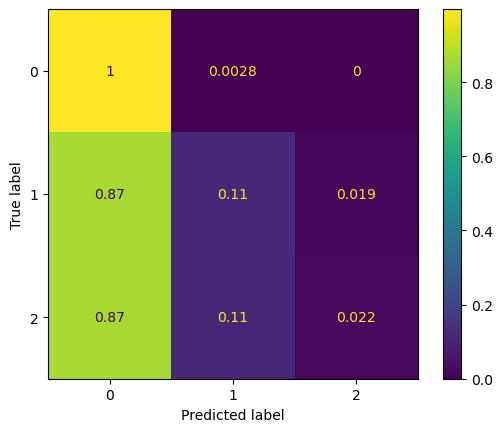

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.55222. Saving Model!
epoch 01, loss: 0.58944, acc: 0.78778, val_loss: 0.55222, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 02, loss: 0.58475, acc: 0.78851, val_loss: 0.57147, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 03, loss: 0.58239, acc: 0.79020, val_loss: 0.59371, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 04, loss: 0.58325, acc: 0.78827, val_loss: 0.61182, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 05, loss: 0.58520, acc: 0.78803, val_loss: 0.62034, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 06, loss: 0.58565, acc: 0.78803, val_loss: 0.61811, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 07, loss: 0.58381, acc: 0.78851, val_loss: 0.60780, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 08, loss: 0.58092, acc: 0.78996, val_loss: 0.59432, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


epoch 09, loss: 0.57892, acc: 0.79020, val_loss: 0.58269, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 10, loss: 0.57870, acc: 0.78972, val_loss: 0.57568, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.08it/s]


epoch 11, loss: 0.57947, acc: 0.79068, val_loss: 0.57440, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 12, loss: 0.57973, acc: 0.79068, val_loss: 0.57872, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 13, loss: 0.57873, acc: 0.79068, val_loss: 0.58790, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.39it/s]


epoch 14, loss: 0.57701, acc: 0.79020, val_loss: 0.60055, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 15, loss: 0.57568, acc: 0.78923, val_loss: 0.61397, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 16, loss: 0.57529, acc: 0.78972, val_loss: 0.62511, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 17, loss: 0.57547, acc: 0.78923, val_loss: 0.63127, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 18, loss: 0.57543, acc: 0.78923, val_loss: 0.63140, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 19, loss: 0.57471, acc: 0.78923, val_loss: 0.62643, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.35it/s]


epoch 20, loss: 0.57354, acc: 0.79068, val_loss: 0.61878, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 21, loss: 0.57249, acc: 0.79068, val_loss: 0.61085, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 22, loss: 0.57193, acc: 0.79261, val_loss: 0.60513, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 23, loss: 0.57177, acc: 0.79189, val_loss: 0.60307, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 24, loss: 0.57155, acc: 0.79261, val_loss: 0.60498, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 25, loss: 0.57097, acc: 0.79261, val_loss: 0.61056, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 26, loss: 0.57015, acc: 0.79285, val_loss: 0.61871, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 27, loss: 0.56938, acc: 0.79310, val_loss: 0.62732, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 28, loss: 0.56891, acc: 0.79261, val_loss: 0.63466, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 29, loss: 0.56863, acc: 0.79430, val_loss: 0.63897, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 30, loss: 0.56831, acc: 0.79406, val_loss: 0.63971, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 31, loss: 0.56779, acc: 0.79430, val_loss: 0.63736, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


epoch 32, loss: 0.56714, acc: 0.79310, val_loss: 0.63319, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 33, loss: 0.56651, acc: 0.79334, val_loss: 0.62891, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]

epoch 34, loss: 0.56605, acc: 0.79310, val_loss: 0.62619, val_accuracy: 0.78696



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 35, loss: 0.56568, acc: 0.79310, val_loss: 0.62583, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 36, loss: 0.56528, acc: 0.79310, val_loss: 0.62818, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 37, loss: 0.56475, acc: 0.79310, val_loss: 0.63267, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 38, loss: 0.56418, acc: 0.79310, val_loss: 0.63825, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 39, loss: 0.56366, acc: 0.79310, val_loss: 0.64351, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


epoch 40, loss: 0.56322, acc: 0.79358, val_loss: 0.64740, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 41, loss: 0.56282, acc: 0.79358, val_loss: 0.64913, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 42, loss: 0.56238, acc: 0.79382, val_loss: 0.64875, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 43, loss: 0.56188, acc: 0.79358, val_loss: 0.64692, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 44, loss: 0.56136, acc: 0.79382, val_loss: 0.64458, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.35it/s]


epoch 45, loss: 0.56089, acc: 0.79358, val_loss: 0.64269, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 46, loss: 0.56047, acc: 0.79358, val_loss: 0.64228, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


epoch 47, loss: 0.56003, acc: 0.79358, val_loss: 0.64346, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 48, loss: 0.55957, acc: 0.79358, val_loss: 0.64612, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 49, loss: 0.55907, acc: 0.79358, val_loss: 0.64965, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 50, loss: 0.55859, acc: 0.79358, val_loss: 0.65303, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 51, loss: 0.55815, acc: 0.79358, val_loss: 0.65562, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


epoch 52, loss: 0.55771, acc: 0.79358, val_loss: 0.65692, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 53, loss: 0.55726, acc: 0.79358, val_loss: 0.65706, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 54, loss: 0.55678, acc: 0.79358, val_loss: 0.65634, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 55, loss: 0.55631, acc: 0.79358, val_loss: 0.65545, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 56, loss: 0.55586, acc: 0.79358, val_loss: 0.65515, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 57, loss: 0.55542, acc: 0.79382, val_loss: 0.65588, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 58, loss: 0.55498, acc: 0.79358, val_loss: 0.65745, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 59, loss: 0.55452, acc: 0.79358, val_loss: 0.65962, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.13it/s]


epoch 60, loss: 0.55407, acc: 0.79382, val_loss: 0.66208, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 61, loss: 0.55363, acc: 0.79382, val_loss: 0.66408, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 62, loss: 0.55318, acc: 0.79382, val_loss: 0.66548, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


epoch 63, loss: 0.55273, acc: 0.79382, val_loss: 0.66631, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 64, loss: 0.55228, acc: 0.79406, val_loss: 0.66668, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 65, loss: 0.55182, acc: 0.79406, val_loss: 0.66690, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 66, loss: 0.55137, acc: 0.79430, val_loss: 0.66740, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 67, loss: 0.55091, acc: 0.79430, val_loss: 0.66831, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 68, loss: 0.55045, acc: 0.79430, val_loss: 0.66980, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.29it/s]


epoch 69, loss: 0.55000, acc: 0.79479, val_loss: 0.67162, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 70, loss: 0.54953, acc: 0.79479, val_loss: 0.67365, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 71, loss: 0.54907, acc: 0.79479, val_loss: 0.67534, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 72, loss: 0.54861, acc: 0.79479, val_loss: 0.67669, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 73, loss: 0.54815, acc: 0.79527, val_loss: 0.67757, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 74, loss: 0.54769, acc: 0.79503, val_loss: 0.67822, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 75, loss: 0.54722, acc: 0.79454, val_loss: 0.67910, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 76, loss: 0.54676, acc: 0.79454, val_loss: 0.68031, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 77, loss: 0.54629, acc: 0.79503, val_loss: 0.68209, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 78, loss: 0.54584, acc: 0.79479, val_loss: 0.68412, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 79, loss: 0.54537, acc: 0.79503, val_loss: 0.68619, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 80, loss: 0.54491, acc: 0.79527, val_loss: 0.68788, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 81, loss: 0.54444, acc: 0.79527, val_loss: 0.68936, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 82, loss: 0.54398, acc: 0.79527, val_loss: 0.69037, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 83, loss: 0.54351, acc: 0.79527, val_loss: 0.69144, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 84, loss: 0.54304, acc: 0.79551, val_loss: 0.69261, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 85, loss: 0.54256, acc: 0.79551, val_loss: 0.69401, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 86, loss: 0.54208, acc: 0.79672, val_loss: 0.69576, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 87, loss: 0.54160, acc: 0.79672, val_loss: 0.69753, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 88, loss: 0.54110, acc: 0.79672, val_loss: 0.69904, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 89, loss: 0.54062, acc: 0.79672, val_loss: 0.70015, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.92it/s]


epoch 90, loss: 0.54014, acc: 0.79672, val_loss: 0.70128, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 91, loss: 0.53966, acc: 0.79648, val_loss: 0.70226, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


epoch 92, loss: 0.53917, acc: 0.79744, val_loss: 0.70343, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 93, loss: 0.53870, acc: 0.79744, val_loss: 0.70474, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 94, loss: 0.53821, acc: 0.79792, val_loss: 0.70614, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 95, loss: 0.53772, acc: 0.79792, val_loss: 0.70763, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 96, loss: 0.53723, acc: 0.79792, val_loss: 0.70923, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 97, loss: 0.53676, acc: 0.79720, val_loss: 0.71059, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 98, loss: 0.53628, acc: 0.79696, val_loss: 0.71176, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 99, loss: 0.53578, acc: 0.79720, val_loss: 0.71281, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.38it/s]


epoch 100, loss: 0.53530, acc: 0.79696, val_loss: 0.71372, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 101, loss: 0.53482, acc: 0.79672, val_loss: 0.71485, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 102, loss: 0.53432, acc: 0.79696, val_loss: 0.71611, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 103, loss: 0.53384, acc: 0.79696, val_loss: 0.71726, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 104, loss: 0.53336, acc: 0.79744, val_loss: 0.71855, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 105, loss: 0.53288, acc: 0.79768, val_loss: 0.72007, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 106, loss: 0.53240, acc: 0.79768, val_loss: 0.72157, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 107, loss: 0.53190, acc: 0.79768, val_loss: 0.72299, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


epoch 108, loss: 0.53142, acc: 0.79768, val_loss: 0.72446, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 109, loss: 0.53093, acc: 0.79768, val_loss: 0.72574, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 110, loss: 0.53044, acc: 0.79768, val_loss: 0.72678, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 111, loss: 0.52996, acc: 0.79817, val_loss: 0.72800, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 112, loss: 0.52947, acc: 0.79792, val_loss: 0.72914, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 113, loss: 0.52898, acc: 0.79792, val_loss: 0.73035, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 114, loss: 0.52848, acc: 0.79792, val_loss: 0.73172, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.62it/s]


epoch 115, loss: 0.52800, acc: 0.79792, val_loss: 0.73307, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 116, loss: 0.52750, acc: 0.79792, val_loss: 0.73472, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 117, loss: 0.52701, acc: 0.79792, val_loss: 0.73627, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 118, loss: 0.52651, acc: 0.79792, val_loss: 0.73732, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 119, loss: 0.52601, acc: 0.79817, val_loss: 0.73832, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 120, loss: 0.52551, acc: 0.79841, val_loss: 0.73907, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 121, loss: 0.52500, acc: 0.79841, val_loss: 0.74001, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.13it/s]


epoch 122, loss: 0.52449, acc: 0.79841, val_loss: 0.74120, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 123, loss: 0.52398, acc: 0.79865, val_loss: 0.74278, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 124, loss: 0.52348, acc: 0.79913, val_loss: 0.74431, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 125, loss: 0.52297, acc: 0.79937, val_loss: 0.74573, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 126, loss: 0.52246, acc: 0.79961, val_loss: 0.74718, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 127, loss: 0.52196, acc: 0.79961, val_loss: 0.74888, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 128, loss: 0.52145, acc: 0.79961, val_loss: 0.75065, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 129, loss: 0.52096, acc: 0.80034, val_loss: 0.75212, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 130, loss: 0.52046, acc: 0.80058, val_loss: 0.75374, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


epoch 131, loss: 0.51994, acc: 0.80106, val_loss: 0.75532, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 132, loss: 0.51944, acc: 0.80155, val_loss: 0.75678, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 133, loss: 0.51894, acc: 0.80179, val_loss: 0.75831, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 134, loss: 0.51845, acc: 0.80203, val_loss: 0.75985, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 135, loss: 0.51794, acc: 0.80203, val_loss: 0.76142, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 136, loss: 0.51743, acc: 0.80227, val_loss: 0.76285, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 137, loss: 0.51693, acc: 0.80227, val_loss: 0.76410, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 138, loss: 0.51643, acc: 0.80324, val_loss: 0.76571, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 139, loss: 0.51593, acc: 0.80324, val_loss: 0.76764, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 140, loss: 0.51543, acc: 0.80324, val_loss: 0.76953, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 141, loss: 0.51492, acc: 0.80324, val_loss: 0.77092, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 142, loss: 0.51442, acc: 0.80372, val_loss: 0.77192, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 143, loss: 0.51391, acc: 0.80348, val_loss: 0.77316, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 144, loss: 0.51342, acc: 0.80372, val_loss: 0.77462, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 145, loss: 0.51290, acc: 0.80372, val_loss: 0.77638, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 146, loss: 0.51239, acc: 0.80396, val_loss: 0.77785, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 147, loss: 0.51187, acc: 0.80396, val_loss: 0.77963, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]


epoch 148, loss: 0.51135, acc: 0.80396, val_loss: 0.78136, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 149, loss: 0.51083, acc: 0.80372, val_loss: 0.78291, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 150, loss: 0.51031, acc: 0.80372, val_loss: 0.78445, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 151, loss: 0.50979, acc: 0.80396, val_loss: 0.78600, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 152, loss: 0.50927, acc: 0.80396, val_loss: 0.78746, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 153, loss: 0.50874, acc: 0.80420, val_loss: 0.78891, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 154, loss: 0.50822, acc: 0.80420, val_loss: 0.79025, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 155, loss: 0.50770, acc: 0.80444, val_loss: 0.79148, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 156, loss: 0.50717, acc: 0.80444, val_loss: 0.79261, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 157, loss: 0.50666, acc: 0.80444, val_loss: 0.79374, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 158, loss: 0.50614, acc: 0.80444, val_loss: 0.79490, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 159, loss: 0.50562, acc: 0.80444, val_loss: 0.79603, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 160, loss: 0.50511, acc: 0.80444, val_loss: 0.79696, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 161, loss: 0.50458, acc: 0.80493, val_loss: 0.79829, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 162, loss: 0.50406, acc: 0.80493, val_loss: 0.79952, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 163, loss: 0.50357, acc: 0.80541, val_loss: 0.80078, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 164, loss: 0.50306, acc: 0.80565, val_loss: 0.80204, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 165, loss: 0.50255, acc: 0.80613, val_loss: 0.80322, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 166, loss: 0.50203, acc: 0.80686, val_loss: 0.80399, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 167, loss: 0.50153, acc: 0.80686, val_loss: 0.80522, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 168, loss: 0.50101, acc: 0.80710, val_loss: 0.80674, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 169, loss: 0.50049, acc: 0.80686, val_loss: 0.80841, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 170, loss: 0.49999, acc: 0.80686, val_loss: 0.80940, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 171, loss: 0.49946, acc: 0.80686, val_loss: 0.81017, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]


epoch 172, loss: 0.49892, acc: 0.80686, val_loss: 0.81113, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 173, loss: 0.49837, acc: 0.80686, val_loss: 0.81218, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 174, loss: 0.49782, acc: 0.80710, val_loss: 0.81342, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 175, loss: 0.49727, acc: 0.80710, val_loss: 0.81427, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 176, loss: 0.49673, acc: 0.80686, val_loss: 0.81517, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 177, loss: 0.49620, acc: 0.80734, val_loss: 0.81654, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 178, loss: 0.49568, acc: 0.80734, val_loss: 0.81830, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 179, loss: 0.49516, acc: 0.80782, val_loss: 0.82022, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 180, loss: 0.49463, acc: 0.80782, val_loss: 0.82179, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 181, loss: 0.49411, acc: 0.80806, val_loss: 0.82247, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 182, loss: 0.49357, acc: 0.80758, val_loss: 0.82326, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 183, loss: 0.49305, acc: 0.80806, val_loss: 0.82466, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 184, loss: 0.49251, acc: 0.80806, val_loss: 0.82632, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 185, loss: 0.49200, acc: 0.80782, val_loss: 0.82724, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 186, loss: 0.49149, acc: 0.80806, val_loss: 0.82873, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 187, loss: 0.49096, acc: 0.80806, val_loss: 0.82967, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.35it/s]


epoch 188, loss: 0.49043, acc: 0.80806, val_loss: 0.83147, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 189, loss: 0.48992, acc: 0.81169, val_loss: 0.83317, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 190, loss: 0.48941, acc: 0.81169, val_loss: 0.83422, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 191, loss: 0.48891, acc: 0.81169, val_loss: 0.83475, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 192, loss: 0.48841, acc: 0.81169, val_loss: 0.83407, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 193, loss: 0.48791, acc: 0.81289, val_loss: 0.83473, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 194, loss: 0.48741, acc: 0.81265, val_loss: 0.83562, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 195, loss: 0.48690, acc: 0.81265, val_loss: 0.83670, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 196, loss: 0.48641, acc: 0.81289, val_loss: 0.83718, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 197, loss: 0.48592, acc: 0.81265, val_loss: 0.83737, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 198, loss: 0.48543, acc: 0.81313, val_loss: 0.83718, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 199, loss: 0.48494, acc: 0.81313, val_loss: 0.83820, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 200, loss: 0.48444, acc: 0.81338, val_loss: 0.84007, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 201, loss: 0.48396, acc: 0.81289, val_loss: 0.84134, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 202, loss: 0.48347, acc: 0.81313, val_loss: 0.84168, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 203, loss: 0.48298, acc: 0.81362, val_loss: 0.84335, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


epoch 204, loss: 0.48249, acc: 0.81458, val_loss: 0.84491, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 205, loss: 0.48202, acc: 0.81507, val_loss: 0.84597, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 206, loss: 0.48153, acc: 0.81531, val_loss: 0.84645, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 207, loss: 0.48104, acc: 0.81507, val_loss: 0.84732, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 208, loss: 0.48056, acc: 0.81507, val_loss: 0.84882, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 209, loss: 0.48008, acc: 0.81507, val_loss: 0.84935, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 210, loss: 0.47959, acc: 0.81482, val_loss: 0.84933, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 211, loss: 0.47911, acc: 0.81482, val_loss: 0.84922, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]


epoch 212, loss: 0.47862, acc: 0.81434, val_loss: 0.85020, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 213, loss: 0.47816, acc: 0.81434, val_loss: 0.85212, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


epoch 214, loss: 0.47768, acc: 0.81458, val_loss: 0.85240, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 215, loss: 0.47719, acc: 0.81434, val_loss: 0.85272, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 216, loss: 0.47672, acc: 0.81507, val_loss: 0.85374, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 217, loss: 0.47625, acc: 0.81507, val_loss: 0.85461, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]

epoch 218, loss: 0.47577, acc: 0.81555, val_loss: 0.85494, val_accuracy: 0.78478

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 219, loss: 0.47529, acc: 0.81555, val_loss: 0.85589, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.27it/s]


epoch 220, loss: 0.47479, acc: 0.81555, val_loss: 0.85772, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 221, loss: 0.47429, acc: 0.81555, val_loss: 0.85873, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 222, loss: 0.47381, acc: 0.81507, val_loss: 0.85811, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 223, loss: 0.47334, acc: 0.81531, val_loss: 0.85827, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 224, loss: 0.47288, acc: 0.81531, val_loss: 0.85886, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 225, loss: 0.47241, acc: 0.81555, val_loss: 0.86000, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 226, loss: 0.47194, acc: 0.81555, val_loss: 0.86087, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 227, loss: 0.47147, acc: 0.81651, val_loss: 0.86171, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 228, loss: 0.47100, acc: 0.81676, val_loss: 0.86226, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 229, loss: 0.47052, acc: 0.81676, val_loss: 0.86306, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 230, loss: 0.47008, acc: 0.81676, val_loss: 0.86394, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 231, loss: 0.46962, acc: 0.81724, val_loss: 0.86505, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 232, loss: 0.46915, acc: 0.81748, val_loss: 0.86600, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


epoch 233, loss: 0.46869, acc: 0.81772, val_loss: 0.86663, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 234, loss: 0.46823, acc: 0.81748, val_loss: 0.86774, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 235, loss: 0.46777, acc: 0.81724, val_loss: 0.86889, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 236, loss: 0.46731, acc: 0.81700, val_loss: 0.86919, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]


epoch 237, loss: 0.46685, acc: 0.81651, val_loss: 0.86979, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 238, loss: 0.46638, acc: 0.81676, val_loss: 0.87114, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 239, loss: 0.46594, acc: 0.81627, val_loss: 0.87271, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 240, loss: 0.46546, acc: 0.81627, val_loss: 0.87284, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 241, loss: 0.46500, acc: 0.81676, val_loss: 0.87382, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.84it/s]


epoch 242, loss: 0.46454, acc: 0.81700, val_loss: 0.87518, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 243, loss: 0.46408, acc: 0.81676, val_loss: 0.87595, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]


epoch 244, loss: 0.46362, acc: 0.81676, val_loss: 0.87519, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 245, loss: 0.46317, acc: 0.81700, val_loss: 0.87650, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 246, loss: 0.46270, acc: 0.81748, val_loss: 0.87775, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 247, loss: 0.46226, acc: 0.81724, val_loss: 0.87837, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 248, loss: 0.46179, acc: 0.81748, val_loss: 0.87686, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 249, loss: 0.46132, acc: 0.81796, val_loss: 0.87781, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 250, loss: 0.46087, acc: 0.81796, val_loss: 0.88012, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 251, loss: 0.46040, acc: 0.81796, val_loss: 0.88154, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 252, loss: 0.45994, acc: 0.81893, val_loss: 0.88182, val_accuracy: 0.78478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 253, loss: 0.45947, acc: 0.81893, val_loss: 0.88187, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 254, loss: 0.45900, acc: 0.81869, val_loss: 0.88191, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.13it/s]


epoch 255, loss: 0.45856, acc: 0.81989, val_loss: 0.88386, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 256, loss: 0.45808, acc: 0.81965, val_loss: 0.88558, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.95it/s]


epoch 257, loss: 0.45762, acc: 0.81941, val_loss: 0.88654, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


epoch 258, loss: 0.45717, acc: 0.81941, val_loss: 0.88673, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 259, loss: 0.45670, acc: 0.82014, val_loss: 0.88751, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 260, loss: 0.45624, acc: 0.82062, val_loss: 0.88891, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]

epoch 261, loss: 0.45580, acc: 0.82038, val_loss: 0.89044, val_accuracy: 0.78913

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 262, loss: 0.45534, acc: 0.81989, val_loss: 0.89001, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 263, loss: 0.45488, acc: 0.81989, val_loss: 0.88719, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 264, loss: 0.45443, acc: 0.82110, val_loss: 0.89056, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 265, loss: 0.45397, acc: 0.82086, val_loss: 0.89263, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 266, loss: 0.45352, acc: 0.82110, val_loss: 0.89172, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 267, loss: 0.45307, acc: 0.82207, val_loss: 0.89230, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 268, loss: 0.45263, acc: 0.82207, val_loss: 0.89366, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 269, loss: 0.45218, acc: 0.82158, val_loss: 0.89328, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 270, loss: 0.45171, acc: 0.82183, val_loss: 0.89468, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 271, loss: 0.45126, acc: 0.82183, val_loss: 0.89546, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 272, loss: 0.45081, acc: 0.82134, val_loss: 0.89776, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 273, loss: 0.45036, acc: 0.82158, val_loss: 0.89716, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 274, loss: 0.44991, acc: 0.82183, val_loss: 0.89795, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.52it/s]


epoch 275, loss: 0.44948, acc: 0.82134, val_loss: 0.89692, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 276, loss: 0.44901, acc: 0.82183, val_loss: 0.89831, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.38it/s]


epoch 277, loss: 0.44855, acc: 0.82183, val_loss: 0.90069, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 278, loss: 0.44810, acc: 0.82183, val_loss: 0.89923, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 279, loss: 0.44766, acc: 0.82134, val_loss: 0.89968, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 280, loss: 0.44719, acc: 0.82134, val_loss: 0.90446, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 281, loss: 0.44675, acc: 0.82134, val_loss: 0.90330, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 282, loss: 0.44631, acc: 0.82110, val_loss: 0.90355, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 283, loss: 0.44586, acc: 0.82134, val_loss: 0.90462, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 284, loss: 0.44541, acc: 0.82255, val_loss: 0.90531, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 285, loss: 0.44498, acc: 0.82255, val_loss: 0.90742, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


epoch 286, loss: 0.44451, acc: 0.82134, val_loss: 0.90804, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 287, loss: 0.44407, acc: 0.82134, val_loss: 0.90824, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.54it/s]


epoch 288, loss: 0.44364, acc: 0.82134, val_loss: 0.90981, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 289, loss: 0.44318, acc: 0.82086, val_loss: 0.90903, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 290, loss: 0.44273, acc: 0.82207, val_loss: 0.91008, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 291, loss: 0.44229, acc: 0.82231, val_loss: 0.90867, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 292, loss: 0.44183, acc: 0.82231, val_loss: 0.91073, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 293, loss: 0.44140, acc: 0.82207, val_loss: 0.91303, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 294, loss: 0.44094, acc: 0.82207, val_loss: 0.91275, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 295, loss: 0.44048, acc: 0.82279, val_loss: 0.91225, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 296, loss: 0.44003, acc: 0.82231, val_loss: 0.91333, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 297, loss: 0.43959, acc: 0.82231, val_loss: 0.91362, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 298, loss: 0.43914, acc: 0.82255, val_loss: 0.91389, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 299, loss: 0.43869, acc: 0.82255, val_loss: 0.91337, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 300, loss: 0.43823, acc: 0.82352, val_loss: 0.91696, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 301, loss: 0.43779, acc: 0.82376, val_loss: 0.91845, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 302, loss: 0.43736, acc: 0.82279, val_loss: 0.92018, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 303, loss: 0.43691, acc: 0.82255, val_loss: 0.92275, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 304, loss: 0.43647, acc: 0.82231, val_loss: 0.91947, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


epoch 305, loss: 0.43603, acc: 0.82303, val_loss: 0.92101, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 306, loss: 0.43558, acc: 0.82400, val_loss: 0.92266, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 307, loss: 0.43514, acc: 0.82400, val_loss: 0.92048, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


epoch 308, loss: 0.43472, acc: 0.82545, val_loss: 0.92389, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 309, loss: 0.43426, acc: 0.82448, val_loss: 0.92750, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 310, loss: 0.43382, acc: 0.82352, val_loss: 0.92699, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 311, loss: 0.43340, acc: 0.82617, val_loss: 0.93210, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 312, loss: 0.43297, acc: 0.82569, val_loss: 0.93141, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 313, loss: 0.43256, acc: 0.82641, val_loss: 0.92905, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 314, loss: 0.43210, acc: 0.82569, val_loss: 0.93279, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 315, loss: 0.43168, acc: 0.82545, val_loss: 0.93176, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 316, loss: 0.43128, acc: 0.82617, val_loss: 0.93398, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 317, loss: 0.43081, acc: 0.82569, val_loss: 0.93320, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 318, loss: 0.43037, acc: 0.82714, val_loss: 0.93430, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 319, loss: 0.42996, acc: 0.82762, val_loss: 0.94086, val_accuracy: 0.79130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 320, loss: 0.42954, acc: 0.82690, val_loss: 0.93407, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 321, loss: 0.42912, acc: 0.82762, val_loss: 0.93841, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 322, loss: 0.42864, acc: 0.82738, val_loss: 0.93854, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]


epoch 323, loss: 0.42822, acc: 0.82810, val_loss: 0.93446, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]


epoch 324, loss: 0.42788, acc: 0.82883, val_loss: 0.94646, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 325, loss: 0.42739, acc: 0.82834, val_loss: 0.94228, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 326, loss: 0.42692, acc: 0.82883, val_loss: 0.93808, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.02it/s]


epoch 327, loss: 0.42657, acc: 0.82931, val_loss: 0.95167, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 328, loss: 0.42616, acc: 0.82883, val_loss: 0.94633, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 329, loss: 0.42563, acc: 0.82955, val_loss: 0.94281, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 330, loss: 0.42525, acc: 0.82931, val_loss: 0.95124, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 331, loss: 0.42487, acc: 0.82859, val_loss: 0.94495, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 332, loss: 0.42441, acc: 0.83003, val_loss: 0.94839, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.23it/s]


epoch 333, loss: 0.42392, acc: 0.82931, val_loss: 0.95075, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 334, loss: 0.42358, acc: 0.82907, val_loss: 0.94613, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 335, loss: 0.42313, acc: 0.83028, val_loss: 0.95754, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 336, loss: 0.42267, acc: 0.83003, val_loss: 0.95584, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 337, loss: 0.42224, acc: 0.83003, val_loss: 0.95394, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 338, loss: 0.42182, acc: 0.83100, val_loss: 0.96053, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 339, loss: 0.42140, acc: 0.83052, val_loss: 0.95618, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


epoch 340, loss: 0.42100, acc: 0.83172, val_loss: 0.96031, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 341, loss: 0.42053, acc: 0.83148, val_loss: 0.95927, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 342, loss: 0.42010, acc: 0.83221, val_loss: 0.96041, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 343, loss: 0.41968, acc: 0.83221, val_loss: 0.96800, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 344, loss: 0.41927, acc: 0.83197, val_loss: 0.96459, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 345, loss: 0.41883, acc: 0.83245, val_loss: 0.96297, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 346, loss: 0.41840, acc: 0.83245, val_loss: 0.96875, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 347, loss: 0.41797, acc: 0.83245, val_loss: 0.97024, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


epoch 348, loss: 0.41753, acc: 0.83269, val_loss: 0.96695, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 349, loss: 0.41711, acc: 0.83269, val_loss: 0.97358, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 350, loss: 0.41670, acc: 0.83197, val_loss: 0.96618, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 351, loss: 0.41628, acc: 0.83390, val_loss: 0.97428, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 352, loss: 0.41585, acc: 0.83148, val_loss: 0.97045, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 353, loss: 0.41537, acc: 0.83341, val_loss: 0.97334, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 354, loss: 0.41495, acc: 0.83317, val_loss: 0.97254, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 355, loss: 0.41450, acc: 0.83317, val_loss: 0.96836, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 356, loss: 0.41409, acc: 0.83390, val_loss: 0.97997, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]


epoch 357, loss: 0.41373, acc: 0.83341, val_loss: 0.97168, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 358, loss: 0.41334, acc: 0.83486, val_loss: 0.98609, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 359, loss: 0.41284, acc: 0.83341, val_loss: 0.97565, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 360, loss: 0.41237, acc: 0.83462, val_loss: 0.97918, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 361, loss: 0.41192, acc: 0.83438, val_loss: 0.98152, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 362, loss: 0.41151, acc: 0.83366, val_loss: 0.97322, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 363, loss: 0.41113, acc: 0.83655, val_loss: 0.98550, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]


epoch 364, loss: 0.41067, acc: 0.83341, val_loss: 0.97483, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 365, loss: 0.41021, acc: 0.83559, val_loss: 0.98422, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 366, loss: 0.40977, acc: 0.83414, val_loss: 0.98073, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 367, loss: 0.40928, acc: 0.83583, val_loss: 0.98734, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 368, loss: 0.40884, acc: 0.83486, val_loss: 0.99075, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 369, loss: 0.40839, acc: 0.83559, val_loss: 0.98790, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 370, loss: 0.40799, acc: 0.83800, val_loss: 0.99650, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 371, loss: 0.40758, acc: 0.83607, val_loss: 0.98761, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.62it/s]


epoch 372, loss: 0.40719, acc: 0.83800, val_loss: 0.99533, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


epoch 373, loss: 0.40672, acc: 0.83583, val_loss: 0.98567, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 374, loss: 0.40633, acc: 0.83848, val_loss: 0.99566, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.06it/s]


epoch 375, loss: 0.40584, acc: 0.83607, val_loss: 0.99396, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 376, loss: 0.40539, acc: 0.83824, val_loss: 0.99829, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 377, loss: 0.40492, acc: 0.83848, val_loss: 1.00100, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 378, loss: 0.40449, acc: 0.83800, val_loss: 0.99809, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 379, loss: 0.40407, acc: 0.83873, val_loss: 1.00879, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 380, loss: 0.40368, acc: 0.83897, val_loss: 0.99774, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


epoch 381, loss: 0.40330, acc: 0.84017, val_loss: 1.01574, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 382, loss: 0.40300, acc: 0.83824, val_loss: 0.99060, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


epoch 383, loss: 0.40261, acc: 0.84186, val_loss: 1.01918, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 384, loss: 0.40214, acc: 0.83897, val_loss: 0.99942, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 385, loss: 0.40151, acc: 0.84017, val_loss: 1.01560, val_accuracy: 0.78913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 386, loss: 0.40103, acc: 0.83969, val_loss: 1.01463, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 387, loss: 0.40052, acc: 0.83945, val_loss: 1.01226, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]


epoch 388, loss: 0.40016, acc: 0.84090, val_loss: 1.02175, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 389, loss: 0.39976, acc: 0.83873, val_loss: 1.00620, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 390, loss: 0.39938, acc: 0.84283, val_loss: 1.02542, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 391, loss: 0.39892, acc: 0.83921, val_loss: 1.01571, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]


epoch 392, loss: 0.39852, acc: 0.84259, val_loss: 1.03065, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]

epoch 393, loss: 0.39805, acc: 0.83993, val_loss: 1.01749, val_accuracy: 0.79348

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 394, loss: 0.39764, acc: 0.84404, val_loss: 1.03427, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 395, loss: 0.39716, acc: 0.84138, val_loss: 1.02507, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.25it/s]


epoch 396, loss: 0.39677, acc: 0.84428, val_loss: 1.03786, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 397, loss: 0.39635, acc: 0.84162, val_loss: 1.02637, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 398, loss: 0.39597, acc: 0.84549, val_loss: 1.04255, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.79it/s]


epoch 399, loss: 0.39561, acc: 0.84283, val_loss: 1.02354, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 400, loss: 0.39526, acc: 0.84428, val_loss: 1.04992, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 401, loss: 0.39487, acc: 0.84307, val_loss: 1.02755, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.62it/s]


epoch 402, loss: 0.39459, acc: 0.84621, val_loss: 1.05815, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 403, loss: 0.39427, acc: 0.84186, val_loss: 1.02362, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 404, loss: 0.39400, acc: 0.84549, val_loss: 1.06541, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 405, loss: 0.39366, acc: 0.84211, val_loss: 1.02933, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 406, loss: 0.39307, acc: 0.84476, val_loss: 1.06563, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 407, loss: 0.39254, acc: 0.84524, val_loss: 1.04075, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 408, loss: 0.39198, acc: 0.84549, val_loss: 1.06125, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 409, loss: 0.39153, acc: 0.84597, val_loss: 1.04217, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 410, loss: 0.39107, acc: 0.84693, val_loss: 1.06222, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 411, loss: 0.39066, acc: 0.84597, val_loss: 1.05253, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 412, loss: 0.39023, acc: 0.84790, val_loss: 1.07046, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


epoch 413, loss: 0.38986, acc: 0.84597, val_loss: 1.05430, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 414, loss: 0.38945, acc: 0.84766, val_loss: 1.07453, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 415, loss: 0.38915, acc: 0.84645, val_loss: 1.04792, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 416, loss: 0.38897, acc: 0.84766, val_loss: 1.09369, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 417, loss: 0.38906, acc: 0.84500, val_loss: 1.03788, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 418, loss: 0.38925, acc: 0.84862, val_loss: 1.11397, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 419, loss: 0.38967, acc: 0.84259, val_loss: 1.02367, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


epoch 420, loss: 0.39000, acc: 0.84838, val_loss: 1.12356, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 421, loss: 0.39006, acc: 0.84259, val_loss: 1.02803, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 422, loss: 0.38889, acc: 0.85056, val_loss: 1.11083, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 423, loss: 0.38734, acc: 0.84380, val_loss: 1.06319, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 424, loss: 0.38583, acc: 0.84838, val_loss: 1.08016, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 425, loss: 0.38509, acc: 0.84814, val_loss: 1.10389, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 426, loss: 0.38514, acc: 0.84693, val_loss: 1.05162, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 427, loss: 0.38565, acc: 0.85056, val_loss: 1.13390, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 428, loss: 0.38668, acc: 0.84452, val_loss: 1.03408, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


epoch 429, loss: 0.38719, acc: 0.85200, val_loss: 1.15132, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 430, loss: 0.38738, acc: 0.84404, val_loss: 1.04111, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 431, loss: 0.38584, acc: 0.85176, val_loss: 1.12894, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.13it/s]


epoch 432, loss: 0.38397, acc: 0.84645, val_loss: 1.07926, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 433, loss: 0.38229, acc: 0.85128, val_loss: 1.09078, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.19it/s]


epoch 434, loss: 0.38169, acc: 0.84887, val_loss: 1.11799, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 435, loss: 0.38186, acc: 0.84766, val_loss: 1.05602, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


epoch 436, loss: 0.38245, acc: 0.85273, val_loss: 1.14307, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 437, loss: 0.38319, acc: 0.84597, val_loss: 1.04643, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 438, loss: 0.38322, acc: 0.85128, val_loss: 1.15628, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 439, loss: 0.38304, acc: 0.84549, val_loss: 1.05875, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 440, loss: 0.38165, acc: 0.85249, val_loss: 1.14045, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 441, loss: 0.38029, acc: 0.84814, val_loss: 1.08727, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 442, loss: 0.37895, acc: 0.85273, val_loss: 1.10836, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.26it/s]


epoch 443, loss: 0.37816, acc: 0.85056, val_loss: 1.11532, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]


epoch 444, loss: 0.37784, acc: 0.85056, val_loss: 1.08428, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 445, loss: 0.37789, acc: 0.85200, val_loss: 1.14298, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 446, loss: 0.37837, acc: 0.84959, val_loss: 1.06534, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 447, loss: 0.37908, acc: 0.85369, val_loss: 1.18027, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 448, loss: 0.38055, acc: 0.84645, val_loss: 1.05024, val_accuracy: 0.79783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 449, loss: 0.38147, acc: 0.85369, val_loss: 1.20642, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 450, loss: 0.38295, acc: 0.84790, val_loss: 1.04278, val_accuracy: 0.79783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 451, loss: 0.38183, acc: 0.85442, val_loss: 1.19583, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 452, loss: 0.38068, acc: 0.84814, val_loss: 1.07262, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 453, loss: 0.37718, acc: 0.85635, val_loss: 1.14676, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 454, loss: 0.37463, acc: 0.85104, val_loss: 1.13466, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 455, loss: 0.37374, acc: 0.85394, val_loss: 1.10135, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 456, loss: 0.37421, acc: 0.85490, val_loss: 1.18423, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 457, loss: 0.37625, acc: 0.84838, val_loss: 1.05842, val_accuracy: 0.79783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 458, loss: 0.37884, acc: 0.85659, val_loss: 1.23827, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 459, loss: 0.38378, acc: 0.84718, val_loss: 1.02575, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


epoch 460, loss: 0.38428, acc: 0.85611, val_loss: 1.24976, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 461, loss: 0.38442, acc: 0.84500, val_loss: 1.07398, val_accuracy: 0.79783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 462, loss: 0.37618, acc: 0.85707, val_loss: 1.15690, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 463, loss: 0.37146, acc: 0.85442, val_loss: 1.18152, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 464, loss: 0.37217, acc: 0.85176, val_loss: 1.07852, val_accuracy: 0.79783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 465, loss: 0.37567, acc: 0.85804, val_loss: 1.24669, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 466, loss: 0.37914, acc: 0.84790, val_loss: 1.07426, val_accuracy: 0.79783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 467, loss: 0.37550, acc: 0.85683, val_loss: 1.19622, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 468, loss: 0.37157, acc: 0.85249, val_loss: 1.13932, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]


epoch 469, loss: 0.36908, acc: 0.85659, val_loss: 1.12459, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


epoch 470, loss: 0.36929, acc: 0.85732, val_loss: 1.20791, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 471, loss: 0.37128, acc: 0.85345, val_loss: 1.08946, val_accuracy: 0.79783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 472, loss: 0.37251, acc: 0.85852, val_loss: 1.23453, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 473, loss: 0.37329, acc: 0.85200, val_loss: 1.09793, val_accuracy: 0.79783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 474, loss: 0.37133, acc: 0.85804, val_loss: 1.21208, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 475, loss: 0.36936, acc: 0.85225, val_loss: 1.13854, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 476, loss: 0.36710, acc: 0.85587, val_loss: 1.15815, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 477, loss: 0.36623, acc: 0.85563, val_loss: 1.18376, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 478, loss: 0.36659, acc: 0.85611, val_loss: 1.11048, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 479, loss: 0.36760, acc: 0.85901, val_loss: 1.21729, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 480, loss: 0.36892, acc: 0.85321, val_loss: 1.09681, val_accuracy: 0.79783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 481, loss: 0.36930, acc: 0.85828, val_loss: 1.23834, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 482, loss: 0.36978, acc: 0.85418, val_loss: 1.10519, val_accuracy: 0.79783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 483, loss: 0.36834, acc: 0.86166, val_loss: 1.22843, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 484, loss: 0.36716, acc: 0.85369, val_loss: 1.12882, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 485, loss: 0.36522, acc: 0.85949, val_loss: 1.18803, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 486, loss: 0.36380, acc: 0.85852, val_loss: 1.16208, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 487, loss: 0.36296, acc: 0.85587, val_loss: 1.15750, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 488, loss: 0.36275, acc: 0.85828, val_loss: 1.20126, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 489, loss: 0.36293, acc: 0.85780, val_loss: 1.13741, val_accuracy: 0.79783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 490, loss: 0.36352, acc: 0.86190, val_loss: 1.23624, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 491, loss: 0.36481, acc: 0.85514, val_loss: 1.11478, val_accuracy: 0.79783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


epoch 492, loss: 0.36608, acc: 0.86383, val_loss: 1.27907, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 493, loss: 0.36914, acc: 0.85369, val_loss: 1.09559, val_accuracy: 0.79783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 494, loss: 0.36977, acc: 0.86263, val_loss: 1.30350, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 495, loss: 0.37191, acc: 0.85200, val_loss: 1.10111, val_accuracy: 0.79783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 496, loss: 0.36821, acc: 0.86311, val_loss: 1.26283, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.37it/s]


epoch 497, loss: 0.36513, acc: 0.85635, val_loss: 1.15422, val_accuracy: 0.79783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 498, loss: 0.36090, acc: 0.86408, val_loss: 1.19393, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 499, loss: 0.35930, acc: 0.86021, val_loss: 1.23005, val_accuracy: 0.79565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


epoch 500, loss: 0.35999, acc: 0.85780, val_loss: 1.13670, val_accuracy: 0.79783
8번째 교차검증
evaluation loss: 0.55222, evaluation accuracy: 0.79130
(5, 460)
(460, 5)


Learning rate set to 0.055397
0:	learn: 1.0472542	total: 24.7ms	remaining: 24.7s
1:	learn: 1.0029251	total: 47ms	remaining: 23.4s
2:	learn: 0.9643349	total: 68.1ms	remaining: 22.6s
3:	learn: 0.9305086	total: 88.2ms	remaining: 22s
4:	learn: 0.9006913	total: 115ms	remaining: 23s
5:	learn: 0.8742854	total: 136ms	remaining: 22.5s
6:	learn: 0.8508094	total: 155ms	remaining: 21.9s
7:	learn: 0.8298703	total: 171ms	remaining: 21.2s
8:	learn: 0.8111426	total: 187ms	remaining: 20.5s
9:	learn: 0.7943536	total: 203ms	remaining: 20.1s
10:	learn: 0.7792727	total: 219ms	remaining: 19.7s
11:	learn: 0.7657033	total: 235ms	remaining: 19.4s
12:	learn: 0.7534765	total: 250ms	remaining: 19s
13:	learn: 0.7424460	total: 267ms	remaining: 18.8s
14:	learn: 0.7324842	total: 283ms	remaining: 18.6s
15:	learn: 0.7234801	total: 299ms	remaining: 18.4s
16:	learn: 0.7153351	total: 314ms	remaining: 18.2s
17:	learn: 0.7079630	total: 330ms	remaining: 18s
18:	learn: 0.7012868	total: 348ms	remaining: 18s
19:	learn: 0.695238

171:	learn: 0.6337873	total: 2.56s	remaining: 12.3s
172:	learn: 0.6337755	total: 2.58s	remaining: 12.3s
173:	learn: 0.6337636	total: 2.59s	remaining: 12.3s
174:	learn: 0.6337520	total: 2.64s	remaining: 12.5s
175:	learn: 0.6337405	total: 2.66s	remaining: 12.4s
176:	learn: 0.6337292	total: 2.67s	remaining: 12.4s
177:	learn: 0.6337179	total: 2.69s	remaining: 12.4s
178:	learn: 0.6337067	total: 2.7s	remaining: 12.4s
179:	learn: 0.6336958	total: 2.71s	remaining: 12.4s
180:	learn: 0.6336848	total: 2.73s	remaining: 12.4s
181:	learn: 0.6336739	total: 2.75s	remaining: 12.3s
182:	learn: 0.6336634	total: 2.77s	remaining: 12.3s
183:	learn: 0.6336527	total: 2.78s	remaining: 12.3s
184:	learn: 0.6336422	total: 2.8s	remaining: 12.3s
185:	learn: 0.6336318	total: 2.81s	remaining: 12.3s
186:	learn: 0.6336216	total: 2.83s	remaining: 12.3s
187:	learn: 0.6336115	total: 2.85s	remaining: 12.3s
188:	learn: 0.6336014	total: 2.86s	remaining: 12.3s
189:	learn: 0.6335915	total: 2.88s	remaining: 12.3s
190:	learn: 0.

330:	learn: 0.6327785	total: 4.91s	remaining: 9.92s
331:	learn: 0.6327753	total: 4.92s	remaining: 9.89s
332:	learn: 0.6327720	total: 4.92s	remaining: 9.86s
333:	learn: 0.6327688	total: 4.93s	remaining: 9.84s
334:	learn: 0.6327655	total: 4.94s	remaining: 9.81s
335:	learn: 0.6327623	total: 4.95s	remaining: 9.78s
336:	learn: 0.6327592	total: 4.96s	remaining: 9.75s
337:	learn: 0.6327560	total: 4.96s	remaining: 9.72s
338:	learn: 0.6327529	total: 4.98s	remaining: 9.7s
339:	learn: 0.6327497	total: 4.99s	remaining: 9.68s
340:	learn: 0.6327467	total: 4.99s	remaining: 9.65s
341:	learn: 0.6327435	total: 5s	remaining: 9.62s
342:	learn: 0.6327405	total: 5.01s	remaining: 9.59s
343:	learn: 0.6327374	total: 5.02s	remaining: 9.57s
344:	learn: 0.6327343	total: 5.03s	remaining: 9.54s
345:	learn: 0.6327313	total: 5.03s	remaining: 9.52s
346:	learn: 0.6327284	total: 5.04s	remaining: 9.49s
347:	learn: 0.6327254	total: 5.05s	remaining: 9.46s
348:	learn: 0.6327224	total: 5.06s	remaining: 9.44s
349:	learn: 0.63

500:	learn: 0.6324162	total: 6.38s	remaining: 6.36s
501:	learn: 0.6324148	total: 6.39s	remaining: 6.34s
502:	learn: 0.6324135	total: 6.4s	remaining: 6.32s
503:	learn: 0.6324122	total: 6.41s	remaining: 6.3s
504:	learn: 0.6324108	total: 6.41s	remaining: 6.29s
505:	learn: 0.6324095	total: 6.42s	remaining: 6.27s
506:	learn: 0.6324081	total: 6.43s	remaining: 6.25s
507:	learn: 0.6324068	total: 6.44s	remaining: 6.24s
508:	learn: 0.6324056	total: 6.45s	remaining: 6.22s
509:	learn: 0.6324042	total: 6.45s	remaining: 6.2s
510:	learn: 0.6324029	total: 6.46s	remaining: 6.18s
511:	learn: 0.6324016	total: 6.47s	remaining: 6.17s
512:	learn: 0.6324002	total: 6.48s	remaining: 6.15s
513:	learn: 0.6323989	total: 6.49s	remaining: 6.13s
514:	learn: 0.6323977	total: 6.49s	remaining: 6.12s
515:	learn: 0.6323964	total: 6.5s	remaining: 6.1s
516:	learn: 0.6323951	total: 6.51s	remaining: 6.08s
517:	learn: 0.6323939	total: 6.52s	remaining: 6.07s
518:	learn: 0.6323926	total: 6.53s	remaining: 6.05s
519:	learn: 0.632

660:	learn: 0.6322542	total: 7.83s	remaining: 4.02s
661:	learn: 0.6322535	total: 7.84s	remaining: 4s
662:	learn: 0.6322527	total: 7.85s	remaining: 3.99s
663:	learn: 0.6322520	total: 7.86s	remaining: 3.98s
664:	learn: 0.6322512	total: 7.87s	remaining: 3.96s
665:	learn: 0.6322506	total: 7.88s	remaining: 3.95s
666:	learn: 0.6322498	total: 7.88s	remaining: 3.94s
667:	learn: 0.6322491	total: 7.89s	remaining: 3.92s
668:	learn: 0.6322483	total: 7.9s	remaining: 3.91s
669:	learn: 0.6322477	total: 7.91s	remaining: 3.9s
670:	learn: 0.6322469	total: 7.92s	remaining: 3.88s
671:	learn: 0.6322461	total: 7.93s	remaining: 3.87s
672:	learn: 0.6322454	total: 7.93s	remaining: 3.85s
673:	learn: 0.6322447	total: 7.94s	remaining: 3.84s
674:	learn: 0.6322440	total: 7.95s	remaining: 3.83s
675:	learn: 0.6322433	total: 7.96s	remaining: 3.81s
676:	learn: 0.6322426	total: 7.96s	remaining: 3.8s
677:	learn: 0.6322419	total: 7.97s	remaining: 3.79s
678:	learn: 0.6322412	total: 7.98s	remaining: 3.77s
679:	learn: 0.6322

820:	learn: 0.6321596	total: 9.28s	remaining: 2.02s
821:	learn: 0.6321590	total: 9.29s	remaining: 2.01s
822:	learn: 0.6321586	total: 9.3s	remaining: 2s
823:	learn: 0.6321581	total: 9.31s	remaining: 1.99s
824:	learn: 0.6321577	total: 9.31s	remaining: 1.98s
825:	learn: 0.6321572	total: 9.33s	remaining: 1.97s
826:	learn: 0.6321568	total: 9.34s	remaining: 1.95s
827:	learn: 0.6321562	total: 9.35s	remaining: 1.94s
828:	learn: 0.6321558	total: 9.36s	remaining: 1.93s
829:	learn: 0.6321554	total: 9.37s	remaining: 1.92s
830:	learn: 0.6321549	total: 9.37s	remaining: 1.91s
831:	learn: 0.6321544	total: 9.38s	remaining: 1.89s
832:	learn: 0.6321540	total: 9.39s	remaining: 1.88s
833:	learn: 0.6321536	total: 9.4s	remaining: 1.87s
834:	learn: 0.6321531	total: 9.41s	remaining: 1.86s
835:	learn: 0.6321527	total: 9.42s	remaining: 1.85s
836:	learn: 0.6321522	total: 9.42s	remaining: 1.83s
837:	learn: 0.6321518	total: 9.43s	remaining: 1.82s
838:	learn: 0.6321513	total: 9.44s	remaining: 1.81s
839:	learn: 0.632

983:	learn: 0.6320969	total: 10.7s	remaining: 174ms
984:	learn: 0.6320967	total: 10.8s	remaining: 164ms
985:	learn: 0.6320963	total: 10.8s	remaining: 153ms
986:	learn: 0.6320960	total: 10.8s	remaining: 142ms
987:	learn: 0.6320957	total: 10.8s	remaining: 131ms
988:	learn: 0.6320953	total: 10.8s	remaining: 120ms
989:	learn: 0.6320950	total: 10.8s	remaining: 109ms
990:	learn: 0.6320948	total: 10.8s	remaining: 98.1ms
991:	learn: 0.6320944	total: 10.8s	remaining: 87.2ms
992:	learn: 0.6320941	total: 10.8s	remaining: 76.3ms
993:	learn: 0.6320939	total: 10.8s	remaining: 65.4ms
994:	learn: 0.6320935	total: 10.8s	remaining: 54.5ms
995:	learn: 0.6320932	total: 10.9s	remaining: 43.6ms
996:	learn: 0.6320928	total: 10.9s	remaining: 32.7ms
997:	learn: 0.6320927	total: 10.9s	remaining: 21.8ms
998:	learn: 0.6320924	total: 10.9s	remaining: 10.9ms
999:	learn: 0.6320920	total: 10.9s	remaining: 0us
Stacking ensemble (ML+DNN): 460
[8]Accuracy : 80.21739130434783
[8]F1score : 0.7295682412493653
[8]Precision 

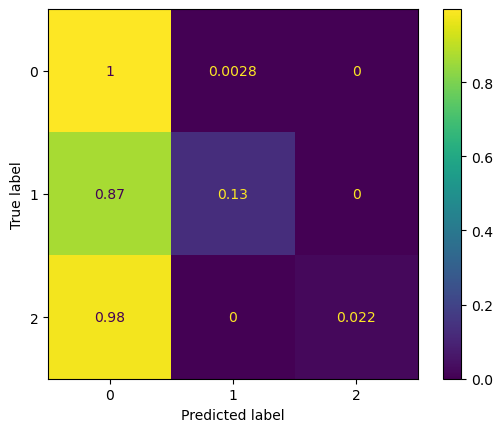

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.58585. Saving Model!
epoch 01, loss: 0.58142, acc: 0.78947, val_loss: 0.58585, val_accuracy: 0.78043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 02, loss: 0.58143, acc: 0.78899, val_loss: 0.58883, val_accuracy: 0.78043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 03, loss: 0.58098, acc: 0.78899, val_loss: 0.59068, val_accuracy: 0.78043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 04, loss: 0.57997, acc: 0.79044, val_loss: 0.59200, val_accuracy: 0.78043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 05, loss: 0.57882, acc: 0.79068, val_loss: 0.59364, val_accuracy: 0.78043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 06, loss: 0.57797, acc: 0.79141, val_loss: 0.59621, val_accuracy: 0.78261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.32it/s]


epoch 07, loss: 0.57749, acc: 0.79189, val_loss: 0.60001, val_accuracy: 0.78261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.54it/s]


epoch 08, loss: 0.57711, acc: 0.79213, val_loss: 0.60484, val_accuracy: 0.78043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 09, loss: 0.57657, acc: 0.79165, val_loss: 0.61049, val_accuracy: 0.78043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 10, loss: 0.57590, acc: 0.79189, val_loss: 0.61658, val_accuracy: 0.78043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 11, loss: 0.57530, acc: 0.79116, val_loss: 0.62240, val_accuracy: 0.78043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.56it/s]


epoch 12, loss: 0.57489, acc: 0.79092, val_loss: 0.62708, val_accuracy: 0.78043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 13, loss: 0.57456, acc: 0.79141, val_loss: 0.62988, val_accuracy: 0.78043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 14, loss: 0.57410, acc: 0.79213, val_loss: 0.63055, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 15, loss: 0.57344, acc: 0.79213, val_loss: 0.62970, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 16, loss: 0.57273, acc: 0.79189, val_loss: 0.62816, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 17, loss: 0.57212, acc: 0.79092, val_loss: 0.62671, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 18, loss: 0.57160, acc: 0.79092, val_loss: 0.62592, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 19, loss: 0.57106, acc: 0.79165, val_loss: 0.62585, val_accuracy: 0.78043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


epoch 20, loss: 0.57048, acc: 0.79165, val_loss: 0.62663, val_accuracy: 0.77826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 21, loss: 0.56988, acc: 0.79141, val_loss: 0.62790, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 22, loss: 0.56933, acc: 0.79261, val_loss: 0.62934, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


epoch 23, loss: 0.56886, acc: 0.79189, val_loss: 0.63044, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 24, loss: 0.56840, acc: 0.79165, val_loss: 0.63091, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 25, loss: 0.56792, acc: 0.79189, val_loss: 0.63079, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 26, loss: 0.56739, acc: 0.79165, val_loss: 0.63055, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 27, loss: 0.56687, acc: 0.79213, val_loss: 0.63075, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 28, loss: 0.56639, acc: 0.79261, val_loss: 0.63160, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 29, loss: 0.56592, acc: 0.79503, val_loss: 0.63345, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 30, loss: 0.56542, acc: 0.79503, val_loss: 0.63607, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.26it/s]


epoch 31, loss: 0.56490, acc: 0.79551, val_loss: 0.63923, val_accuracy: 0.77609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 32, loss: 0.56439, acc: 0.79503, val_loss: 0.64246, val_accuracy: 0.77391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 33, loss: 0.56392, acc: 0.79454, val_loss: 0.64533, val_accuracy: 0.77391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 34, loss: 0.56345, acc: 0.79454, val_loss: 0.64749, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 35, loss: 0.56297, acc: 0.79454, val_loss: 0.64893, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 36, loss: 0.56248, acc: 0.79454, val_loss: 0.64998, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 37, loss: 0.56198, acc: 0.79454, val_loss: 0.65066, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 38, loss: 0.56152, acc: 0.79454, val_loss: 0.65162, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]

epoch 39, loss: 0.56104, acc: 0.79454, val_loss: 0.65289, val_accuracy: 0.76957

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 40, loss: 0.56057, acc: 0.79454, val_loss: 0.65438, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 41, loss: 0.56009, acc: 0.79454, val_loss: 0.65622, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 42, loss: 0.55960, acc: 0.79479, val_loss: 0.65781, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 43, loss: 0.55911, acc: 0.79479, val_loss: 0.65925, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 44, loss: 0.55863, acc: 0.79454, val_loss: 0.66011, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 45, loss: 0.55816, acc: 0.79551, val_loss: 0.66055, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 46, loss: 0.55768, acc: 0.79551, val_loss: 0.66097, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 47, loss: 0.55719, acc: 0.79551, val_loss: 0.66152, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 48, loss: 0.55672, acc: 0.79551, val_loss: 0.66251, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 49, loss: 0.55624, acc: 0.79575, val_loss: 0.66388, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 50, loss: 0.55577, acc: 0.79648, val_loss: 0.66562, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 51, loss: 0.55528, acc: 0.79648, val_loss: 0.66743, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 52, loss: 0.55480, acc: 0.79623, val_loss: 0.66921, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 53, loss: 0.55432, acc: 0.79623, val_loss: 0.67084, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 54, loss: 0.55383, acc: 0.79744, val_loss: 0.67235, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 55, loss: 0.55334, acc: 0.79744, val_loss: 0.67392, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


epoch 56, loss: 0.55286, acc: 0.79744, val_loss: 0.67535, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 57, loss: 0.55239, acc: 0.79768, val_loss: 0.67693, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 58, loss: 0.55189, acc: 0.79792, val_loss: 0.67863, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 59, loss: 0.55140, acc: 0.79792, val_loss: 0.68049, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 60, loss: 0.55091, acc: 0.79792, val_loss: 0.68223, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 61, loss: 0.55042, acc: 0.79817, val_loss: 0.68386, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 62, loss: 0.54994, acc: 0.79817, val_loss: 0.68541, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


epoch 63, loss: 0.54944, acc: 0.79817, val_loss: 0.68656, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 64, loss: 0.54895, acc: 0.79841, val_loss: 0.68782, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 65, loss: 0.54846, acc: 0.79865, val_loss: 0.68937, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 66, loss: 0.54798, acc: 0.79865, val_loss: 0.69094, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 67, loss: 0.54749, acc: 0.79817, val_loss: 0.69249, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 68, loss: 0.54700, acc: 0.79841, val_loss: 0.69421, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 69, loss: 0.54651, acc: 0.79841, val_loss: 0.69580, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 70, loss: 0.54603, acc: 0.79817, val_loss: 0.69743, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 71, loss: 0.54554, acc: 0.79913, val_loss: 0.69921, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


epoch 72, loss: 0.54506, acc: 0.79913, val_loss: 0.70113, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 73, loss: 0.54457, acc: 0.79937, val_loss: 0.70306, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 74, loss: 0.54410, acc: 0.79986, val_loss: 0.70523, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 75, loss: 0.54361, acc: 0.80010, val_loss: 0.70717, val_accuracy: 0.77174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 76, loss: 0.54311, acc: 0.80010, val_loss: 0.70897, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 77, loss: 0.54262, acc: 0.80034, val_loss: 0.71078, val_accuracy: 0.76739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 78, loss: 0.54213, acc: 0.80058, val_loss: 0.71270, val_accuracy: 0.76739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 79, loss: 0.54164, acc: 0.80082, val_loss: 0.71452, val_accuracy: 0.76087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]


epoch 80, loss: 0.54114, acc: 0.80082, val_loss: 0.71635, val_accuracy: 0.76087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 81, loss: 0.54065, acc: 0.80082, val_loss: 0.71812, val_accuracy: 0.76087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.28it/s]


epoch 82, loss: 0.54016, acc: 0.80082, val_loss: 0.72009, val_accuracy: 0.76087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 83, loss: 0.53967, acc: 0.80082, val_loss: 0.72167, val_accuracy: 0.75870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 84, loss: 0.53917, acc: 0.80058, val_loss: 0.72323, val_accuracy: 0.75652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 85, loss: 0.53867, acc: 0.80058, val_loss: 0.72470, val_accuracy: 0.75652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 86, loss: 0.53818, acc: 0.80058, val_loss: 0.72631, val_accuracy: 0.75652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]


epoch 87, loss: 0.53769, acc: 0.80058, val_loss: 0.72811, val_accuracy: 0.75652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 88, loss: 0.53719, acc: 0.80034, val_loss: 0.73016, val_accuracy: 0.75652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 89, loss: 0.53669, acc: 0.80058, val_loss: 0.73233, val_accuracy: 0.75435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 90, loss: 0.53619, acc: 0.80010, val_loss: 0.73426, val_accuracy: 0.75435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 91, loss: 0.53570, acc: 0.80010, val_loss: 0.73632, val_accuracy: 0.75435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 92, loss: 0.53518, acc: 0.80010, val_loss: 0.73795, val_accuracy: 0.75435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 93, loss: 0.53468, acc: 0.80010, val_loss: 0.73980, val_accuracy: 0.75435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 94, loss: 0.53417, acc: 0.80010, val_loss: 0.74186, val_accuracy: 0.74783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 95, loss: 0.53366, acc: 0.80010, val_loss: 0.74394, val_accuracy: 0.74783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.13it/s]


epoch 96, loss: 0.53315, acc: 0.80010, val_loss: 0.74597, val_accuracy: 0.74565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 97, loss: 0.53263, acc: 0.80034, val_loss: 0.74814, val_accuracy: 0.74565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 98, loss: 0.53212, acc: 0.80034, val_loss: 0.75032, val_accuracy: 0.74565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 99, loss: 0.53161, acc: 0.80034, val_loss: 0.75282, val_accuracy: 0.74565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 100, loss: 0.53109, acc: 0.80010, val_loss: 0.75546, val_accuracy: 0.74565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 101, loss: 0.53058, acc: 0.80034, val_loss: 0.75787, val_accuracy: 0.73913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 102, loss: 0.53006, acc: 0.80058, val_loss: 0.75997, val_accuracy: 0.73913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]


epoch 103, loss: 0.52953, acc: 0.80058, val_loss: 0.76218, val_accuracy: 0.73478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 104, loss: 0.52901, acc: 0.80058, val_loss: 0.76426, val_accuracy: 0.73478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 105, loss: 0.52850, acc: 0.80034, val_loss: 0.76626, val_accuracy: 0.73043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 106, loss: 0.52798, acc: 0.80106, val_loss: 0.76798, val_accuracy: 0.72826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 107, loss: 0.52745, acc: 0.80082, val_loss: 0.77017, val_accuracy: 0.72174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 108, loss: 0.52694, acc: 0.80106, val_loss: 0.77240, val_accuracy: 0.71957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 109, loss: 0.52641, acc: 0.80106, val_loss: 0.77488, val_accuracy: 0.71739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 110, loss: 0.52589, acc: 0.80106, val_loss: 0.77670, val_accuracy: 0.72391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 111, loss: 0.52536, acc: 0.80130, val_loss: 0.77897, val_accuracy: 0.71739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 112, loss: 0.52484, acc: 0.80155, val_loss: 0.78063, val_accuracy: 0.71739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 113, loss: 0.52431, acc: 0.80155, val_loss: 0.78263, val_accuracy: 0.71739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 114, loss: 0.52377, acc: 0.80155, val_loss: 0.78463, val_accuracy: 0.71522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 115, loss: 0.52324, acc: 0.80155, val_loss: 0.78692, val_accuracy: 0.71087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 116, loss: 0.52269, acc: 0.80203, val_loss: 0.78925, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 117, loss: 0.52215, acc: 0.80251, val_loss: 0.79175, val_accuracy: 0.70435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 118, loss: 0.52159, acc: 0.80275, val_loss: 0.79374, val_accuracy: 0.71087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 119, loss: 0.52103, acc: 0.80299, val_loss: 0.79627, val_accuracy: 0.70870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 120, loss: 0.52049, acc: 0.80396, val_loss: 0.79868, val_accuracy: 0.69565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 121, loss: 0.51993, acc: 0.80396, val_loss: 0.80089, val_accuracy: 0.69565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 122, loss: 0.51938, acc: 0.80372, val_loss: 0.80305, val_accuracy: 0.69348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 123, loss: 0.51881, acc: 0.80468, val_loss: 0.80522, val_accuracy: 0.69130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


epoch 124, loss: 0.51824, acc: 0.80468, val_loss: 0.80740, val_accuracy: 0.68043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 125, loss: 0.51767, acc: 0.80468, val_loss: 0.80977, val_accuracy: 0.67826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 126, loss: 0.51710, acc: 0.80493, val_loss: 0.81262, val_accuracy: 0.67609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]


epoch 127, loss: 0.51655, acc: 0.80541, val_loss: 0.81507, val_accuracy: 0.66739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 128, loss: 0.51598, acc: 0.80541, val_loss: 0.81754, val_accuracy: 0.66304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 129, loss: 0.51540, acc: 0.80565, val_loss: 0.81940, val_accuracy: 0.66087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 130, loss: 0.51482, acc: 0.80565, val_loss: 0.82132, val_accuracy: 0.64348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 131, loss: 0.51424, acc: 0.80589, val_loss: 0.82310, val_accuracy: 0.64348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 132, loss: 0.51367, acc: 0.80589, val_loss: 0.82486, val_accuracy: 0.64130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 133, loss: 0.51309, acc: 0.80613, val_loss: 0.82672, val_accuracy: 0.63696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 134, loss: 0.51251, acc: 0.80613, val_loss: 0.82805, val_accuracy: 0.63043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 135, loss: 0.51193, acc: 0.80637, val_loss: 0.82974, val_accuracy: 0.63043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 136, loss: 0.51134, acc: 0.80637, val_loss: 0.83197, val_accuracy: 0.61957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 137, loss: 0.51075, acc: 0.80758, val_loss: 0.83464, val_accuracy: 0.61304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 138, loss: 0.51017, acc: 0.80782, val_loss: 0.83733, val_accuracy: 0.60870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 139, loss: 0.50959, acc: 0.80758, val_loss: 0.83954, val_accuracy: 0.60652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 140, loss: 0.50900, acc: 0.80734, val_loss: 0.84156, val_accuracy: 0.59565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 141, loss: 0.50843, acc: 0.80734, val_loss: 0.84386, val_accuracy: 0.59565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 142, loss: 0.50785, acc: 0.80734, val_loss: 0.84656, val_accuracy: 0.58913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 143, loss: 0.50726, acc: 0.80734, val_loss: 0.84962, val_accuracy: 0.58043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 144, loss: 0.50666, acc: 0.80855, val_loss: 0.85261, val_accuracy: 0.57609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 145, loss: 0.50608, acc: 0.80927, val_loss: 0.85556, val_accuracy: 0.57174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 146, loss: 0.50548, acc: 0.80951, val_loss: 0.85838, val_accuracy: 0.56957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 147, loss: 0.50489, acc: 0.81000, val_loss: 0.86126, val_accuracy: 0.56957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 148, loss: 0.50429, acc: 0.81096, val_loss: 0.86414, val_accuracy: 0.56739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 149, loss: 0.50370, acc: 0.81120, val_loss: 0.86713, val_accuracy: 0.56739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 150, loss: 0.50311, acc: 0.81241, val_loss: 0.87048, val_accuracy: 0.56087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 151, loss: 0.50252, acc: 0.81241, val_loss: 0.87389, val_accuracy: 0.56087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.25it/s]


epoch 152, loss: 0.50192, acc: 0.81241, val_loss: 0.87663, val_accuracy: 0.54565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 153, loss: 0.50132, acc: 0.81265, val_loss: 0.87870, val_accuracy: 0.54565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 154, loss: 0.50071, acc: 0.81289, val_loss: 0.88074, val_accuracy: 0.54565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 155, loss: 0.50012, acc: 0.81265, val_loss: 0.88357, val_accuracy: 0.54565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 156, loss: 0.49952, acc: 0.81265, val_loss: 0.88661, val_accuracy: 0.54348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 157, loss: 0.49892, acc: 0.81289, val_loss: 0.89010, val_accuracy: 0.54348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 158, loss: 0.49832, acc: 0.81265, val_loss: 0.89330, val_accuracy: 0.54348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.75it/s]


epoch 159, loss: 0.49773, acc: 0.81265, val_loss: 0.89600, val_accuracy: 0.54348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 160, loss: 0.49714, acc: 0.81289, val_loss: 0.89889, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 161, loss: 0.49653, acc: 0.81289, val_loss: 0.90199, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 162, loss: 0.49592, acc: 0.81289, val_loss: 0.90499, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 163, loss: 0.49532, acc: 0.81458, val_loss: 0.90832, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]

epoch 164, loss: 0.49472, acc: 0.81507, val_loss: 0.91076, val_accuracy: 0.53913

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 165, loss: 0.49411, acc: 0.81507, val_loss: 0.91351, val_accuracy: 0.53478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


epoch 166, loss: 0.49351, acc: 0.81482, val_loss: 0.91729, val_accuracy: 0.53478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 167, loss: 0.49291, acc: 0.81507, val_loss: 0.92062, val_accuracy: 0.53261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.07it/s]


epoch 168, loss: 0.49229, acc: 0.81434, val_loss: 0.92295, val_accuracy: 0.53261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 169, loss: 0.49170, acc: 0.81458, val_loss: 0.92509, val_accuracy: 0.53261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


epoch 170, loss: 0.49108, acc: 0.81458, val_loss: 0.92854, val_accuracy: 0.52826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.92it/s]


epoch 171, loss: 0.49047, acc: 0.81458, val_loss: 0.93255, val_accuracy: 0.52826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 172, loss: 0.48987, acc: 0.81482, val_loss: 0.93594, val_accuracy: 0.52826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 173, loss: 0.48926, acc: 0.81531, val_loss: 0.93846, val_accuracy: 0.52826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 174, loss: 0.48866, acc: 0.81531, val_loss: 0.94199, val_accuracy: 0.52826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 175, loss: 0.48804, acc: 0.81555, val_loss: 0.94600, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 176, loss: 0.48743, acc: 0.81555, val_loss: 0.94969, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 177, loss: 0.48680, acc: 0.81555, val_loss: 0.95297, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 178, loss: 0.48618, acc: 0.81555, val_loss: 0.95618, val_accuracy: 0.52174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 179, loss: 0.48558, acc: 0.81555, val_loss: 0.95939, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 180, loss: 0.48498, acc: 0.81627, val_loss: 0.96191, val_accuracy: 0.52391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 181, loss: 0.48438, acc: 0.81651, val_loss: 0.96464, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 182, loss: 0.48378, acc: 0.81627, val_loss: 0.96714, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


epoch 183, loss: 0.48317, acc: 0.81676, val_loss: 0.97042, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 184, loss: 0.48256, acc: 0.81651, val_loss: 0.97369, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 185, loss: 0.48197, acc: 0.81700, val_loss: 0.97643, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


epoch 186, loss: 0.48136, acc: 0.81724, val_loss: 0.97874, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


epoch 187, loss: 0.48075, acc: 0.81748, val_loss: 0.98148, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 188, loss: 0.48015, acc: 0.81772, val_loss: 0.98461, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 189, loss: 0.47954, acc: 0.81796, val_loss: 0.98779, val_accuracy: 0.51739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 190, loss: 0.47893, acc: 0.81820, val_loss: 0.99061, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 191, loss: 0.47834, acc: 0.81796, val_loss: 0.99395, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


epoch 192, loss: 0.47772, acc: 0.81845, val_loss: 0.99772, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 193, loss: 0.47712, acc: 0.81845, val_loss: 1.00050, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 194, loss: 0.47651, acc: 0.81893, val_loss: 1.00296, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 195, loss: 0.47590, acc: 0.81965, val_loss: 1.00573, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 196, loss: 0.47530, acc: 0.81989, val_loss: 1.00838, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 197, loss: 0.47471, acc: 0.81965, val_loss: 1.01155, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 198, loss: 0.47411, acc: 0.82014, val_loss: 1.01582, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 199, loss: 0.47353, acc: 0.81989, val_loss: 1.01865, val_accuracy: 0.51087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 200, loss: 0.47292, acc: 0.81965, val_loss: 1.02063, val_accuracy: 0.51087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 201, loss: 0.47231, acc: 0.81917, val_loss: 1.02369, val_accuracy: 0.51087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 202, loss: 0.47173, acc: 0.81965, val_loss: 1.02789, val_accuracy: 0.51087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


epoch 203, loss: 0.47112, acc: 0.82303, val_loss: 1.03156, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 204, loss: 0.47054, acc: 0.82327, val_loss: 1.03454, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 205, loss: 0.46993, acc: 0.82327, val_loss: 1.03753, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 206, loss: 0.46933, acc: 0.82352, val_loss: 1.04192, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 207, loss: 0.46872, acc: 0.82424, val_loss: 1.04593, val_accuracy: 0.51087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


epoch 208, loss: 0.46809, acc: 0.82400, val_loss: 1.04814, val_accuracy: 0.51087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 209, loss: 0.46749, acc: 0.82424, val_loss: 1.05041, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 210, loss: 0.46688, acc: 0.82448, val_loss: 1.05526, val_accuracy: 0.50870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 211, loss: 0.46627, acc: 0.82472, val_loss: 1.05986, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 212, loss: 0.46569, acc: 0.82448, val_loss: 1.06152, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 213, loss: 0.46510, acc: 0.82472, val_loss: 1.06374, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 214, loss: 0.46449, acc: 0.82521, val_loss: 1.06803, val_accuracy: 0.50652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.38it/s]


epoch 215, loss: 0.46388, acc: 0.82617, val_loss: 1.07196, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 216, loss: 0.46327, acc: 0.82641, val_loss: 1.07467, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 217, loss: 0.46269, acc: 0.82714, val_loss: 1.07893, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 218, loss: 0.46209, acc: 0.82738, val_loss: 1.08311, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 219, loss: 0.46150, acc: 0.82738, val_loss: 1.08545, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 220, loss: 0.46090, acc: 0.82762, val_loss: 1.08721, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 221, loss: 0.46030, acc: 0.82762, val_loss: 1.09096, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 222, loss: 0.45972, acc: 0.82762, val_loss: 1.09716, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


epoch 223, loss: 0.45913, acc: 0.82810, val_loss: 1.10138, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 224, loss: 0.45853, acc: 0.82786, val_loss: 1.10433, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 225, loss: 0.45792, acc: 0.82810, val_loss: 1.10780, val_accuracy: 0.50435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 226, loss: 0.45732, acc: 0.82810, val_loss: 1.11108, val_accuracy: 0.49783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 227, loss: 0.45672, acc: 0.82859, val_loss: 1.11436, val_accuracy: 0.49348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 228, loss: 0.45613, acc: 0.82834, val_loss: 1.11764, val_accuracy: 0.49348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 229, loss: 0.45554, acc: 0.82859, val_loss: 1.12351, val_accuracy: 0.49348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 230, loss: 0.45493, acc: 0.82859, val_loss: 1.12825, val_accuracy: 0.49348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


epoch 231, loss: 0.45433, acc: 0.82810, val_loss: 1.13149, val_accuracy: 0.49348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


epoch 232, loss: 0.45375, acc: 0.82834, val_loss: 1.13423, val_accuracy: 0.49348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 233, loss: 0.45316, acc: 0.82859, val_loss: 1.14037, val_accuracy: 0.49565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 234, loss: 0.45255, acc: 0.82883, val_loss: 1.14472, val_accuracy: 0.49565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 235, loss: 0.45196, acc: 0.82883, val_loss: 1.14668, val_accuracy: 0.49565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 236, loss: 0.45135, acc: 0.82883, val_loss: 1.15022, val_accuracy: 0.49565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 237, loss: 0.45077, acc: 0.82979, val_loss: 1.15554, val_accuracy: 0.49565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 238, loss: 0.45017, acc: 0.83052, val_loss: 1.15982, val_accuracy: 0.49565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


epoch 239, loss: 0.44960, acc: 0.83124, val_loss: 1.16394, val_accuracy: 0.49565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 240, loss: 0.44901, acc: 0.83100, val_loss: 1.16852, val_accuracy: 0.49565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 241, loss: 0.44844, acc: 0.83100, val_loss: 1.17285, val_accuracy: 0.49348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 242, loss: 0.44785, acc: 0.83197, val_loss: 1.17462, val_accuracy: 0.49348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 243, loss: 0.44725, acc: 0.83197, val_loss: 1.17963, val_accuracy: 0.49348


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 244, loss: 0.44668, acc: 0.83197, val_loss: 1.18452, val_accuracy: 0.48913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 245, loss: 0.44609, acc: 0.83221, val_loss: 1.18813, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 246, loss: 0.44550, acc: 0.83221, val_loss: 1.19249, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 247, loss: 0.44491, acc: 0.83221, val_loss: 1.19654, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.35it/s]


epoch 248, loss: 0.44433, acc: 0.83245, val_loss: 1.19850, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 249, loss: 0.44375, acc: 0.83245, val_loss: 1.20435, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 250, loss: 0.44317, acc: 0.83293, val_loss: 1.20885, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 251, loss: 0.44258, acc: 0.83390, val_loss: 1.21194, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 252, loss: 0.44201, acc: 0.83390, val_loss: 1.21416, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]

epoch 253, loss: 0.44143, acc: 0.83438, val_loss: 1.21796, val_accuracy: 0.48696

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 254, loss: 0.44087, acc: 0.83414, val_loss: 1.22188, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


epoch 255, loss: 0.44029, acc: 0.83414, val_loss: 1.22662, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 256, loss: 0.43970, acc: 0.83462, val_loss: 1.23081, val_accuracy: 0.48913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 257, loss: 0.43912, acc: 0.83438, val_loss: 1.23704, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 258, loss: 0.43854, acc: 0.83414, val_loss: 1.23985, val_accuracy: 0.48913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 259, loss: 0.43795, acc: 0.83414, val_loss: 1.24351, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 260, loss: 0.43738, acc: 0.83414, val_loss: 1.24758, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 261, loss: 0.43680, acc: 0.83486, val_loss: 1.24971, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 262, loss: 0.43622, acc: 0.83510, val_loss: 1.25205, val_accuracy: 0.47391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 263, loss: 0.43566, acc: 0.83535, val_loss: 1.26069, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


epoch 264, loss: 0.43506, acc: 0.83607, val_loss: 1.26561, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 265, loss: 0.43451, acc: 0.83631, val_loss: 1.26759, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 266, loss: 0.43392, acc: 0.83583, val_loss: 1.27275, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 267, loss: 0.43334, acc: 0.83583, val_loss: 1.27883, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


epoch 268, loss: 0.43275, acc: 0.83607, val_loss: 1.28374, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 269, loss: 0.43218, acc: 0.83704, val_loss: 1.29183, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 270, loss: 0.43159, acc: 0.83655, val_loss: 1.29499, val_accuracy: 0.47391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


epoch 271, loss: 0.43102, acc: 0.83607, val_loss: 1.29800, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 272, loss: 0.43045, acc: 0.83728, val_loss: 1.30664, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 273, loss: 0.42989, acc: 0.83776, val_loss: 1.30955, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 274, loss: 0.42931, acc: 0.83679, val_loss: 1.31070, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 275, loss: 0.42874, acc: 0.83752, val_loss: 1.31955, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 276, loss: 0.42816, acc: 0.83848, val_loss: 1.32406, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 277, loss: 0.42761, acc: 0.83993, val_loss: 1.32438, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 278, loss: 0.42701, acc: 0.83993, val_loss: 1.32650, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.38it/s]


epoch 279, loss: 0.42645, acc: 0.83993, val_loss: 1.33893, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 280, loss: 0.42588, acc: 0.83969, val_loss: 1.34658, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.30it/s]


epoch 281, loss: 0.42531, acc: 0.83993, val_loss: 1.34973, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 282, loss: 0.42473, acc: 0.83993, val_loss: 1.35432, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


epoch 283, loss: 0.42414, acc: 0.83969, val_loss: 1.36050, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 284, loss: 0.42361, acc: 0.83969, val_loss: 1.36954, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 285, loss: 0.42302, acc: 0.83945, val_loss: 1.37349, val_accuracy: 0.46957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 286, loss: 0.42247, acc: 0.84090, val_loss: 1.38159, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 287, loss: 0.42191, acc: 0.83993, val_loss: 1.38618, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]


epoch 288, loss: 0.42130, acc: 0.84090, val_loss: 1.39593, val_accuracy: 0.47391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 289, loss: 0.42075, acc: 0.84090, val_loss: 1.40185, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 290, loss: 0.42018, acc: 0.84066, val_loss: 1.40860, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


epoch 291, loss: 0.41961, acc: 0.84090, val_loss: 1.41303, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 292, loss: 0.41905, acc: 0.83993, val_loss: 1.42043, val_accuracy: 0.47391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 293, loss: 0.41847, acc: 0.83993, val_loss: 1.43089, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 294, loss: 0.41792, acc: 0.83969, val_loss: 1.43621, val_accuracy: 0.47391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.17it/s]


epoch 295, loss: 0.41735, acc: 0.84017, val_loss: 1.44328, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 296, loss: 0.41680, acc: 0.84114, val_loss: 1.44311, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 297, loss: 0.41626, acc: 0.84138, val_loss: 1.44947, val_accuracy: 0.47391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 298, loss: 0.41572, acc: 0.84090, val_loss: 1.45759, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 299, loss: 0.41517, acc: 0.84114, val_loss: 1.46568, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]

epoch 300, loss: 0.41461, acc: 0.84186, val_loss: 1.46972, val_accuracy: 0.47391

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 301, loss: 0.41406, acc: 0.84235, val_loss: 1.47339, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 302, loss: 0.41353, acc: 0.84211, val_loss: 1.48177, val_accuracy: 0.47391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 303, loss: 0.41301, acc: 0.84211, val_loss: 1.49253, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]


epoch 304, loss: 0.41244, acc: 0.84355, val_loss: 1.49660, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 305, loss: 0.41190, acc: 0.84355, val_loss: 1.50171, val_accuracy: 0.46957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 306, loss: 0.41137, acc: 0.84283, val_loss: 1.50737, val_accuracy: 0.47391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 307, loss: 0.41083, acc: 0.84307, val_loss: 1.51339, val_accuracy: 0.47391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 308, loss: 0.41030, acc: 0.84331, val_loss: 1.52236, val_accuracy: 0.47391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 309, loss: 0.40977, acc: 0.84259, val_loss: 1.52143, val_accuracy: 0.47391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 310, loss: 0.40922, acc: 0.84307, val_loss: 1.52241, val_accuracy: 0.47391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 311, loss: 0.40871, acc: 0.84380, val_loss: 1.53300, val_accuracy: 0.47391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 312, loss: 0.40819, acc: 0.84331, val_loss: 1.53352, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 313, loss: 0.40770, acc: 0.84404, val_loss: 1.54298, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 314, loss: 0.40715, acc: 0.84500, val_loss: 1.54644, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 315, loss: 0.40663, acc: 0.84404, val_loss: 1.54561, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 316, loss: 0.40613, acc: 0.84404, val_loss: 1.56423, val_accuracy: 0.48043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 317, loss: 0.40561, acc: 0.84404, val_loss: 1.56159, val_accuracy: 0.48043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.54it/s]


epoch 318, loss: 0.40507, acc: 0.84549, val_loss: 1.56545, val_accuracy: 0.48043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 319, loss: 0.40454, acc: 0.84524, val_loss: 1.57447, val_accuracy: 0.48261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 320, loss: 0.40403, acc: 0.84476, val_loss: 1.57470, val_accuracy: 0.48261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 321, loss: 0.40352, acc: 0.84524, val_loss: 1.58408, val_accuracy: 0.48043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 322, loss: 0.40299, acc: 0.84452, val_loss: 1.58524, val_accuracy: 0.48261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 323, loss: 0.40246, acc: 0.84573, val_loss: 1.59616, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 324, loss: 0.40196, acc: 0.84452, val_loss: 1.58983, val_accuracy: 0.48261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.62it/s]


epoch 325, loss: 0.40147, acc: 0.84597, val_loss: 1.60357, val_accuracy: 0.48261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 326, loss: 0.40096, acc: 0.84524, val_loss: 1.59621, val_accuracy: 0.48261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


epoch 327, loss: 0.40048, acc: 0.84621, val_loss: 1.61394, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 328, loss: 0.39994, acc: 0.84597, val_loss: 1.61696, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 329, loss: 0.39941, acc: 0.84669, val_loss: 1.61505, val_accuracy: 0.48043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 330, loss: 0.39896, acc: 0.84476, val_loss: 1.63608, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 331, loss: 0.39848, acc: 0.84428, val_loss: 1.61926, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 332, loss: 0.39800, acc: 0.84549, val_loss: 1.64133, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 333, loss: 0.39748, acc: 0.84549, val_loss: 1.62129, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 334, loss: 0.39699, acc: 0.84597, val_loss: 1.65382, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 335, loss: 0.39639, acc: 0.84597, val_loss: 1.64657, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 336, loss: 0.39586, acc: 0.84790, val_loss: 1.64602, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 337, loss: 0.39534, acc: 0.84669, val_loss: 1.65310, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 338, loss: 0.39486, acc: 0.84669, val_loss: 1.64707, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 339, loss: 0.39440, acc: 0.84669, val_loss: 1.67362, val_accuracy: 0.46957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 340, loss: 0.39393, acc: 0.84645, val_loss: 1.64279, val_accuracy: 0.47391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 341, loss: 0.39349, acc: 0.84911, val_loss: 1.69344, val_accuracy: 0.46957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


epoch 342, loss: 0.39314, acc: 0.84766, val_loss: 1.65063, val_accuracy: 0.47391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 343, loss: 0.39272, acc: 0.84790, val_loss: 1.70760, val_accuracy: 0.46957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]


epoch 344, loss: 0.39218, acc: 0.84790, val_loss: 1.65549, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 345, loss: 0.39170, acc: 0.84838, val_loss: 1.70907, val_accuracy: 0.46957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 346, loss: 0.39108, acc: 0.84814, val_loss: 1.67361, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 347, loss: 0.39044, acc: 0.84862, val_loss: 1.71263, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 348, loss: 0.38990, acc: 0.84814, val_loss: 1.70039, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 349, loss: 0.38935, acc: 0.84742, val_loss: 1.70602, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 350, loss: 0.38884, acc: 0.84742, val_loss: 1.72398, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]

epoch 351, loss: 0.38831, acc: 0.84959, val_loss: 1.71161, val_accuracy: 0.47174



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 352, loss: 0.38794, acc: 0.84862, val_loss: 1.74599, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 353, loss: 0.38754, acc: 0.84959, val_loss: 1.69778, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 354, loss: 0.38739, acc: 0.84862, val_loss: 1.78320, val_accuracy: 0.46739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 355, loss: 0.38741, acc: 0.85031, val_loss: 1.68152, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 356, loss: 0.38792, acc: 0.84766, val_loss: 1.81592, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 357, loss: 0.38844, acc: 0.85176, val_loss: 1.64749, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 358, loss: 0.38973, acc: 0.84693, val_loss: 1.85568, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 359, loss: 0.38987, acc: 0.85273, val_loss: 1.63701, val_accuracy: 0.48261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


epoch 360, loss: 0.39064, acc: 0.84500, val_loss: 1.85368, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 361, loss: 0.38833, acc: 0.85176, val_loss: 1.67054, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 362, loss: 0.38647, acc: 0.84887, val_loss: 1.81176, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 363, loss: 0.38393, acc: 0.85273, val_loss: 1.75117, val_accuracy: 0.47391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


epoch 364, loss: 0.38242, acc: 0.85056, val_loss: 1.77221, val_accuracy: 0.47391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 365, loss: 0.38171, acc: 0.85345, val_loss: 1.81314, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 366, loss: 0.38168, acc: 0.85345, val_loss: 1.73460, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


epoch 367, loss: 0.38240, acc: 0.84814, val_loss: 1.88685, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 368, loss: 0.38389, acc: 0.85297, val_loss: 1.67219, val_accuracy: 0.48043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 369, loss: 0.38755, acc: 0.84621, val_loss: 1.94595, val_accuracy: 0.27391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 370, loss: 0.38947, acc: 0.85321, val_loss: 1.61254, val_accuracy: 0.48913


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 371, loss: 0.39429, acc: 0.84162, val_loss: 1.95328, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 372, loss: 0.38876, acc: 0.85321, val_loss: 1.67175, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 373, loss: 0.38472, acc: 0.84766, val_loss: 1.83537, val_accuracy: 0.28478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 374, loss: 0.37897, acc: 0.85369, val_loss: 1.82737, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


epoch 375, loss: 0.37765, acc: 0.85369, val_loss: 1.74116, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 376, loss: 0.38013, acc: 0.84983, val_loss: 1.94419, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 377, loss: 0.38319, acc: 0.85659, val_loss: 1.65325, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 378, loss: 0.38841, acc: 0.84597, val_loss: 1.97666, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 379, loss: 0.38565, acc: 0.85563, val_loss: 1.69466, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]


epoch 380, loss: 0.38447, acc: 0.84814, val_loss: 1.93259, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]

epoch 381, loss: 0.37829, acc: 0.85732, val_loss: 1.79984, val_accuracy: 0.47826

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 382, loss: 0.37483, acc: 0.85345, val_loss: 1.79059, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 383, loss: 0.37457, acc: 0.85249, val_loss: 1.93017, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]


epoch 384, loss: 0.37674, acc: 0.85876, val_loss: 1.72467, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 385, loss: 0.38044, acc: 0.85080, val_loss: 1.98029, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 386, loss: 0.38018, acc: 0.85852, val_loss: 1.70839, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 387, loss: 0.38064, acc: 0.85128, val_loss: 1.96601, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 388, loss: 0.37653, acc: 0.85973, val_loss: 1.79967, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 389, loss: 0.37371, acc: 0.85225, val_loss: 1.89964, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]

epoch 390, loss: 0.37127, acc: 0.85611, val_loss: 1.89345, val_accuracy: 0.28696

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.29it/s]


epoch 391, loss: 0.37067, acc: 0.85683, val_loss: 1.82650, val_accuracy: 0.48043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 392, loss: 0.37161, acc: 0.85369, val_loss: 1.98805, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 393, loss: 0.37311, acc: 0.85876, val_loss: 1.77542, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 394, loss: 0.37576, acc: 0.85152, val_loss: 2.02376, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 395, loss: 0.37612, acc: 0.86021, val_loss: 1.74568, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 396, loss: 0.37813, acc: 0.85104, val_loss: 2.02632, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 397, loss: 0.37434, acc: 0.85997, val_loss: 1.80481, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 398, loss: 0.37156, acc: 0.85394, val_loss: 1.94751, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 399, loss: 0.36814, acc: 0.86021, val_loss: 1.91485, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]

epoch 400, loss: 0.36683, acc: 0.85756, val_loss: 1.87403, val_accuracy: 0.47826

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 401, loss: 0.36737, acc: 0.85538, val_loss: 2.00769, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 402, loss: 0.36894, acc: 0.86118, val_loss: 1.80365, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 403, loss: 0.37228, acc: 0.85273, val_loss: 2.07543, val_accuracy: 0.27609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 404, loss: 0.37409, acc: 0.86166, val_loss: 1.74705, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


epoch 405, loss: 0.37879, acc: 0.85007, val_loss: 2.09084, val_accuracy: 0.27609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 406, loss: 0.37477, acc: 0.86190, val_loss: 1.78919, val_accuracy: 0.48043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


epoch 407, loss: 0.37202, acc: 0.85297, val_loss: 2.00946, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 408, loss: 0.36594, acc: 0.86239, val_loss: 1.94330, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 409, loss: 0.36348, acc: 0.85973, val_loss: 1.89141, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 410, loss: 0.36440, acc: 0.85611, val_loss: 2.06597, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 411, loss: 0.36729, acc: 0.86456, val_loss: 1.81317, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 412, loss: 0.37245, acc: 0.85369, val_loss: 2.13067, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 413, loss: 0.37253, acc: 0.86335, val_loss: 1.77676, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.54it/s]


epoch 414, loss: 0.37457, acc: 0.85225, val_loss: 2.08675, val_accuracy: 0.27609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.75it/s]


epoch 415, loss: 0.36766, acc: 0.86263, val_loss: 1.89010, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 416, loss: 0.36288, acc: 0.85732, val_loss: 1.96739, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 417, loss: 0.36036, acc: 0.86214, val_loss: 2.04057, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 418, loss: 0.36151, acc: 0.86335, val_loss: 1.87664, val_accuracy: 0.48043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 419, loss: 0.36507, acc: 0.85466, val_loss: 2.13218, val_accuracy: 0.27391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 420, loss: 0.36747, acc: 0.86480, val_loss: 1.81180, val_accuracy: 0.48261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 421, loss: 0.37162, acc: 0.85200, val_loss: 2.14288, val_accuracy: 0.27174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


epoch 422, loss: 0.36768, acc: 0.86311, val_loss: 1.86767, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


epoch 423, loss: 0.36492, acc: 0.85490, val_loss: 2.06582, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 424, loss: 0.35957, acc: 0.86577, val_loss: 2.00793, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 425, loss: 0.35753, acc: 0.86190, val_loss: 1.94211, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 426, loss: 0.35886, acc: 0.85901, val_loss: 2.12782, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 427, loss: 0.36145, acc: 0.86601, val_loss: 1.87374, val_accuracy: 0.48043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 428, loss: 0.36549, acc: 0.85418, val_loss: 2.16588, val_accuracy: 0.27174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 429, loss: 0.36487, acc: 0.86528, val_loss: 1.85788, val_accuracy: 0.48043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


epoch 430, loss: 0.36514, acc: 0.85418, val_loss: 2.12145, val_accuracy: 0.28043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 431, loss: 0.36018, acc: 0.86649, val_loss: 1.95161, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 432, loss: 0.35656, acc: 0.86021, val_loss: 2.03022, val_accuracy: 0.47174


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 433, loss: 0.35457, acc: 0.86383, val_loss: 2.08287, val_accuracy: 0.46957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 434, loss: 0.35500, acc: 0.86721, val_loss: 1.96630, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 435, loss: 0.35696, acc: 0.85925, val_loss: 2.17398, val_accuracy: 0.27391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 436, loss: 0.35893, acc: 0.86552, val_loss: 1.89841, val_accuracy: 0.48043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 437, loss: 0.36275, acc: 0.85466, val_loss: 2.20254, val_accuracy: 0.26957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 438, loss: 0.36217, acc: 0.86577, val_loss: 1.87717, val_accuracy: 0.48043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 439, loss: 0.36309, acc: 0.85442, val_loss: 2.16956, val_accuracy: 0.27609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]


epoch 440, loss: 0.35752, acc: 0.86601, val_loss: 1.97610, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 441, loss: 0.35369, acc: 0.86287, val_loss: 2.05772, val_accuracy: 0.46957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 442, loss: 0.35149, acc: 0.86770, val_loss: 2.10453, val_accuracy: 0.46957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 443, loss: 0.35181, acc: 0.86939, val_loss: 1.97717, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 444, loss: 0.35398, acc: 0.86045, val_loss: 2.19011, val_accuracy: 0.27391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 445, loss: 0.35615, acc: 0.86673, val_loss: 1.91979, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 446, loss: 0.36024, acc: 0.85635, val_loss: 2.25350, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 447, loss: 0.35983, acc: 0.86552, val_loss: 1.90376, val_accuracy: 0.48261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


epoch 448, loss: 0.36130, acc: 0.85538, val_loss: 2.20098, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 449, loss: 0.35562, acc: 0.86746, val_loss: 1.99273, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 450, loss: 0.35150, acc: 0.86214, val_loss: 2.10005, val_accuracy: 0.46957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


epoch 451, loss: 0.34857, acc: 0.86939, val_loss: 2.12231, val_accuracy: 0.46957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


epoch 452, loss: 0.34874, acc: 0.86939, val_loss: 2.00167, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 453, loss: 0.35110, acc: 0.86190, val_loss: 2.23143, val_accuracy: 0.27609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 454, loss: 0.35356, acc: 0.86842, val_loss: 1.94276, val_accuracy: 0.48478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


epoch 455, loss: 0.35781, acc: 0.85732, val_loss: 2.26807, val_accuracy: 0.25870


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


epoch 456, loss: 0.35654, acc: 0.86842, val_loss: 1.93395, val_accuracy: 0.48043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


epoch 457, loss: 0.35693, acc: 0.85756, val_loss: 2.22058, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 458, loss: 0.35131, acc: 0.86915, val_loss: 2.03993, val_accuracy: 0.47391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 459, loss: 0.34756, acc: 0.86432, val_loss: 2.13253, val_accuracy: 0.46957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 460, loss: 0.34540, acc: 0.87011, val_loss: 2.16554, val_accuracy: 0.46957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 461, loss: 0.34583, acc: 0.87277, val_loss: 2.02453, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 462, loss: 0.34786, acc: 0.86552, val_loss: 2.25266, val_accuracy: 0.26957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]


epoch 463, loss: 0.35003, acc: 0.86963, val_loss: 1.98104, val_accuracy: 0.48043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 464, loss: 0.35446, acc: 0.85804, val_loss: 2.30385, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 465, loss: 0.35349, acc: 0.86987, val_loss: 1.95652, val_accuracy: 0.48478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 466, loss: 0.35468, acc: 0.85828, val_loss: 2.28148, val_accuracy: 0.26304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 467, loss: 0.34983, acc: 0.87084, val_loss: 2.04022, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 468, loss: 0.34685, acc: 0.86552, val_loss: 2.16341, val_accuracy: 0.46957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 469, loss: 0.34310, acc: 0.87204, val_loss: 2.14614, val_accuracy: 0.46957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 470, loss: 0.34238, acc: 0.87132, val_loss: 2.09261, val_accuracy: 0.47391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


epoch 471, loss: 0.34358, acc: 0.86746, val_loss: 2.25985, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 472, loss: 0.34562, acc: 0.87108, val_loss: 1.99760, val_accuracy: 0.48261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 473, loss: 0.34937, acc: 0.86142, val_loss: 2.33750, val_accuracy: 0.26304


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 474, loss: 0.35048, acc: 0.87059, val_loss: 2.00592, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


epoch 475, loss: 0.35475, acc: 0.85828, val_loss: 2.34550, val_accuracy: 0.26522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 476, loss: 0.34928, acc: 0.87059, val_loss: 2.03241, val_accuracy: 0.48261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 477, loss: 0.34602, acc: 0.86552, val_loss: 2.23688, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 478, loss: 0.34092, acc: 0.87301, val_loss: 2.19979, val_accuracy: 0.46957


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 479, loss: 0.33959, acc: 0.87253, val_loss: 2.09926, val_accuracy: 0.47391


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]

epoch 480, loss: 0.34092, acc: 0.86866, val_loss: 2.28401, val_accuracy: 0.27174



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 481, loss: 0.34363, acc: 0.87301, val_loss: 2.05286, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 482, loss: 0.34909, acc: 0.85973, val_loss: 2.39177, val_accuracy: 0.25652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


epoch 483, loss: 0.34866, acc: 0.87277, val_loss: 1.99716, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 484, loss: 0.35148, acc: 0.85852, val_loss: 2.36719, val_accuracy: 0.26522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 485, loss: 0.34578, acc: 0.87325, val_loss: 2.12962, val_accuracy: 0.47826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


epoch 486, loss: 0.34265, acc: 0.86770, val_loss: 2.24435, val_accuracy: 0.27826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.17it/s]


epoch 487, loss: 0.33760, acc: 0.87325, val_loss: 2.21021, val_accuracy: 0.46739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 488, loss: 0.33733, acc: 0.87470, val_loss: 2.13249, val_accuracy: 0.47609


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


epoch 489, loss: 0.33984, acc: 0.86770, val_loss: 2.37586, val_accuracy: 0.26522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


epoch 490, loss: 0.34261, acc: 0.87446, val_loss: 2.04357, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


epoch 491, loss: 0.34780, acc: 0.86094, val_loss: 2.40571, val_accuracy: 0.25435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


epoch 492, loss: 0.34646, acc: 0.87277, val_loss: 2.06138, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


epoch 493, loss: 0.34841, acc: 0.86166, val_loss: 2.34753, val_accuracy: 0.26739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


epoch 494, loss: 0.33997, acc: 0.87494, val_loss: 2.17096, val_accuracy: 0.46739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


epoch 495, loss: 0.33634, acc: 0.86939, val_loss: 2.21923, val_accuracy: 0.46739


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]

epoch 496, loss: 0.33486, acc: 0.87349, val_loss: 2.35093, val_accuracy: 0.27609

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


epoch 497, loss: 0.33769, acc: 0.87784, val_loss: 2.08130, val_accuracy: 0.48696


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


epoch 498, loss: 0.34231, acc: 0.86408, val_loss: 2.41735, val_accuracy: 0.25217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


epoch 499, loss: 0.34295, acc: 0.87349, val_loss: 2.10940, val_accuracy: 0.48478


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


epoch 500, loss: 0.34718, acc: 0.86118, val_loss: 2.41121, val_accuracy: 0.16304
9번째 교차검증
evaluation loss: 0.58585, evaluation accuracy: 0.78043
(5, 460)
(460, 5)
Learning rate set to 0.055397
0:	learn: 1.0472148	total: 8.98ms	remaining: 8.97s
1:	learn: 1.0034469	total: 17.6ms	remaining: 8.81s
2:	learn: 0.9643845	total: 23.9ms	remaining: 7.94s
3:	learn: 0.9299632	total: 33.3ms	remaining: 8.3s
4:	learn: 0.8994411	total: 39.7ms	remaining: 7.9s
5:	learn: 0.8722348	total: 47.4ms	remaining: 7.85s
6:	learn: 0.8478768	total: 53.9ms	remaining: 7.64s
7:	learn: 0.8259862	total: 61.4ms	remaining: 7.62s
8:	learn: 0.8062485	total: 67.9ms	remaining: 7.47s
9:	learn: 0.7884014	total: 74.3ms	remaining: 7.35s
10:	learn: 0.7722229	total: 82ms	remaining: 7.38s
11:	learn: 0.7575243	total: 88.6ms	remaining: 7.29s
12:	learn: 0.7441438	total: 95.8ms	remaining: 7.27s
13:	learn: 0.7319416	total: 102ms	remaining: 7.18s
14:	learn: 0.7209315	total: 109ms	remaining: 7.17s
15:	learn: 0.7108511	total: 116ms	remaining

171:	learn: 0.5814054	total: 1.22s	remaining: 5.88s
172:	learn: 0.5813815	total: 1.23s	remaining: 5.88s
173:	learn: 0.5813580	total: 1.24s	remaining: 5.87s
174:	learn: 0.5813348	total: 1.24s	remaining: 5.86s
175:	learn: 0.5813119	total: 1.25s	remaining: 5.86s
176:	learn: 0.5812893	total: 1.26s	remaining: 5.85s
177:	learn: 0.5812671	total: 1.27s	remaining: 5.85s
178:	learn: 0.5812450	total: 1.27s	remaining: 5.84s
179:	learn: 0.5812233	total: 1.28s	remaining: 5.84s
180:	learn: 0.5812020	total: 1.29s	remaining: 5.83s
181:	learn: 0.5811807	total: 1.3s	remaining: 5.83s
182:	learn: 0.5811599	total: 1.3s	remaining: 5.82s
183:	learn: 0.5811392	total: 1.31s	remaining: 5.83s
184:	learn: 0.5811189	total: 1.32s	remaining: 5.82s
185:	learn: 0.5810989	total: 1.33s	remaining: 5.82s
186:	learn: 0.5810790	total: 1.34s	remaining: 5.81s
187:	learn: 0.5810595	total: 1.34s	remaining: 5.81s
188:	learn: 0.5810401	total: 1.35s	remaining: 5.8s
189:	learn: 0.5810210	total: 1.36s	remaining: 5.8s
190:	learn: 0.58

337:	learn: 0.5795313	total: 2.46s	remaining: 4.81s
338:	learn: 0.5795260	total: 2.46s	remaining: 4.81s
339:	learn: 0.5795206	total: 2.47s	remaining: 4.8s
340:	learn: 0.5795154	total: 2.48s	remaining: 4.79s
341:	learn: 0.5795101	total: 2.49s	remaining: 4.78s
342:	learn: 0.5795049	total: 2.49s	remaining: 4.78s
343:	learn: 0.5794998	total: 2.5s	remaining: 4.77s
344:	learn: 0.5794946	total: 2.51s	remaining: 4.76s
345:	learn: 0.5794895	total: 2.52s	remaining: 4.76s
346:	learn: 0.5794844	total: 2.52s	remaining: 4.75s
347:	learn: 0.5794793	total: 2.53s	remaining: 4.75s
348:	learn: 0.5794743	total: 2.54s	remaining: 4.74s
349:	learn: 0.5794694	total: 2.55s	remaining: 4.74s
350:	learn: 0.5794643	total: 2.56s	remaining: 4.73s
351:	learn: 0.5794594	total: 2.56s	remaining: 4.72s
352:	learn: 0.5794545	total: 2.57s	remaining: 4.72s
353:	learn: 0.5794497	total: 2.58s	remaining: 4.71s
354:	learn: 0.5794448	total: 2.59s	remaining: 4.7s
355:	learn: 0.5794400	total: 2.6s	remaining: 4.7s
356:	learn: 0.579

497:	learn: 0.5789617	total: 3.69s	remaining: 3.72s
498:	learn: 0.5789594	total: 3.7s	remaining: 3.72s
499:	learn: 0.5789570	total: 3.71s	remaining: 3.71s
500:	learn: 0.5789547	total: 3.72s	remaining: 3.71s
501:	learn: 0.5789524	total: 3.73s	remaining: 3.7s
502:	learn: 0.5789500	total: 3.74s	remaining: 3.69s
503:	learn: 0.5789477	total: 3.75s	remaining: 3.69s
504:	learn: 0.5789454	total: 3.75s	remaining: 3.68s
505:	learn: 0.5789431	total: 3.76s	remaining: 3.67s
506:	learn: 0.5789409	total: 3.77s	remaining: 3.67s
507:	learn: 0.5789386	total: 3.78s	remaining: 3.66s
508:	learn: 0.5789364	total: 3.79s	remaining: 3.65s
509:	learn: 0.5789341	total: 3.8s	remaining: 3.65s
510:	learn: 0.5789319	total: 3.81s	remaining: 3.65s
511:	learn: 0.5789296	total: 3.82s	remaining: 3.64s
512:	learn: 0.5789274	total: 3.83s	remaining: 3.63s
513:	learn: 0.5789252	total: 3.83s	remaining: 3.63s
514:	learn: 0.5789230	total: 3.84s	remaining: 3.62s
515:	learn: 0.5789208	total: 3.85s	remaining: 3.62s
516:	learn: 0.5

675:	learn: 0.5786571	total: 5.36s	remaining: 2.57s
676:	learn: 0.5786558	total: 5.37s	remaining: 2.56s
677:	learn: 0.5786545	total: 5.38s	remaining: 2.55s
678:	learn: 0.5786534	total: 5.39s	remaining: 2.55s
679:	learn: 0.5786521	total: 5.39s	remaining: 2.54s
680:	learn: 0.5786508	total: 5.4s	remaining: 2.53s
681:	learn: 0.5786496	total: 5.41s	remaining: 2.52s
682:	learn: 0.5786484	total: 5.42s	remaining: 2.52s
683:	learn: 0.5786472	total: 5.43s	remaining: 2.51s
684:	learn: 0.5786461	total: 5.44s	remaining: 2.5s
685:	learn: 0.5786449	total: 5.45s	remaining: 2.49s
686:	learn: 0.5786437	total: 5.46s	remaining: 2.49s
687:	learn: 0.5786425	total: 5.47s	remaining: 2.48s
688:	learn: 0.5786413	total: 5.48s	remaining: 2.47s
689:	learn: 0.5786401	total: 5.49s	remaining: 2.47s
690:	learn: 0.5786389	total: 5.5s	remaining: 2.46s
691:	learn: 0.5786377	total: 5.51s	remaining: 2.45s
692:	learn: 0.5786365	total: 5.51s	remaining: 2.44s
693:	learn: 0.5786354	total: 5.52s	remaining: 2.44s
694:	learn: 0.5

839:	learn: 0.5784951	total: 6.8s	remaining: 1.29s
840:	learn: 0.5784943	total: 6.81s	remaining: 1.29s
841:	learn: 0.5784935	total: 6.82s	remaining: 1.28s
842:	learn: 0.5784927	total: 6.83s	remaining: 1.27s
843:	learn: 0.5784920	total: 6.84s	remaining: 1.26s
844:	learn: 0.5784912	total: 6.84s	remaining: 1.25s
845:	learn: 0.5784904	total: 6.85s	remaining: 1.25s
846:	learn: 0.5784896	total: 6.86s	remaining: 1.24s
847:	learn: 0.5784889	total: 6.87s	remaining: 1.23s
848:	learn: 0.5784881	total: 6.88s	remaining: 1.22s
849:	learn: 0.5784874	total: 6.89s	remaining: 1.22s
850:	learn: 0.5784866	total: 6.89s	remaining: 1.21s
851:	learn: 0.5784858	total: 6.9s	remaining: 1.2s
852:	learn: 0.5784850	total: 6.91s	remaining: 1.19s
853:	learn: 0.5784843	total: 6.92s	remaining: 1.18s
854:	learn: 0.5784835	total: 6.93s	remaining: 1.17s
855:	learn: 0.5784827	total: 6.94s	remaining: 1.17s
856:	learn: 0.5784820	total: 6.95s	remaining: 1.16s
857:	learn: 0.5784813	total: 6.95s	remaining: 1.15s
858:	learn: 0.5

Stacking ensemble (ML+DNN): 460
[9]Accuracy : 79.34782608695652
[9]F1score : 0.7078843245355733
[9]Precision : 0.7190181714394444
[9]Recall : 0.7934782608695652



C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


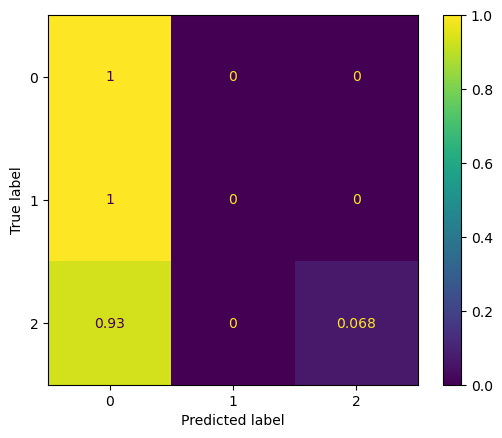

In [28]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=10)
skf.get_n_splits(X_train_over,y_train_over)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.input_layer = nn.Linear(6, 128)
        self.hidden_layer1 = nn.Linear(128, 256)
        self.hidden_layer2 = nn.Linear(256, 128)
        self.output_layer   = nn.Linear(128,3)
        self.relu = nn.ReLU()



    def forward(self, x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.relu(self.hidden_layer2(out))
        out =  self.output_layer(out)
        return out 



# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

from tqdm import tqdm  # Progress Bar 출력

def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for data, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        data, lbl = data.to(device), lbl.to(device)
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(data)

        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * data.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            

            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

def model_test(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    pred_list=[]
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)
            
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            pred_array = pred.tolist()
            pred_list.append(pred_array) # confusion matrix를 위해 pred 리턴 값
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc, pred_list

# X_test=pd.DataFrame()
# X_train=pd.DataFrame()
# y_test=pd.DataFrame()
# y_train=pd.DataFrame()
# empty=pd.DataFrame()

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]

from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=10)

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]
CMResult=[[[0 for k in range(3)]for j in range(3)] for i in range(10)]
skf.get_n_splits(X_train_over,y_train_over)

i=0
for tfold, (train_index, test_index) in enumerate(skf.split(X_train_over, y_train_over)):
    #모델 정의, 예측

    X_train, X_test = X_train_over[train_index], X_train_over[test_index]
    y_train, y_test = y_train_over[train_index], y_train_over[test_index]

    #DNN
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train.to_numpy())
    y_test = torch.LongTensor(y_test.to_numpy())

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset=TensorDataset(X_test, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=10000,shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=5000,shuffle=False)

    # 최대 Epoch을 지정합니다.
    num_epochs = 500
    min_loss = 9999999999999
    loss_list=[]
    acc_list=[]
    # Epoch 별 훈련 및 검증을 수행합니다.
    for epoch in range(num_epochs):
        # Model Training
        # 훈련 손실과 정확도를 반환 받습니다.
        train_loss, train_acc = model_train(model, train_dataloader, loss_fn, optimizer, device)

        # 검증 손실과 검증 정확도를 반환 받습니다.
        val_loss, val_acc = model_evaluate(model, test_dataloader, loss_fn, device)   

        # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
        if val_loss < min_loss:
                print(f'[INFO] val_acc has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
                min_loss = val_loss
                torch.save(model.state_dict(), 'DNNModel3.pth')

        # Epoch 별 결과를 출력합니다.
        print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')
        loss_list.append(train_loss)
        acc_list.append(train_acc)
    ## 저장한 가중치 로드 후 검증 성능 측정

    # 모델에 저장한 가중치를 로드합니다.
    model.load_state_dict(torch.load('DNNModel3.pth'))

    # 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
    print("{}번째 교차검증".format(tfold))
    final_loss, final_acc, y_predicted = model_test(model, test_dataloader, loss_fn, device)
    print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')   

    X_train, X_test = X_train_over[train_index], X_train_over[test_index]
    y_train, y_test = y_train_over[train_index], y_train_over[test_index]

#     ## 원핫 인코딩
#     y_train=pd.get_dummies(y_train)
#     y_test=pd.get_dummies(y_test)


    # LogisticRegression
    lr = LogisticRegression(solver='liblinear', random_state=0)
    lr.fit(X_train, y_train)
    linear_pred = lr.predict(X_test)
    # linear_pred = lr.predict(X_train)
    
    # RidgeClassifier
    clf = RidgeClassifier(alpha=1.0)
    clf.fit(X_train, y_train)
    ridge_pred = clf.predict(X_test)
    # ridge_pred = clf.predict(X_train)
    
    # RandomForestClassifier
    regr = RandomForestClassifier(max_depth=6, random_state=0)
    regr.fit(X_train, y_train)
    regr_pred = regr.predict(X_test)
    # regr_pred = regr.predict(X_train)
    
    # GradientBoostingClassifier
    reg = GradientBoostingClassifier(random_state=0)
    reg.fit(X_train, y_train)
    reg_pred = reg.predict(X_test)
    # reg_pred = reg.predict(X_train)
    
    # DNN 결과값 넘파이 배열로 변환
    y_predicted_t=sum(y_predicted, [])
    DNN_y_predicted=np.array(y_predicted_t)

    # 최종모델
#     lgbm = LGBMClassifier()
    CatBoost = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0:1')
    new_data = np.array([linear_pred.squeeze(),ridge_pred.squeeze(),regr_pred.squeeze(),reg_pred.squeeze(),DNN_y_predicted.squeeze()])
    # new_data = np.array([linear_pred,ridge_pred,regr_pred,reg_pred,DNN_y_predicted])
    print(new_data.shape)

    new_data = np.transpose(new_data)
    print(new_data.shape)

    #y_test를 파이토치에서 넘파이 배열로 변환
    y_test=np.array(y_test)
    
    #lgbm 학습하기
    CatBoost.fit(new_data,y_test)
    # lgbm.fit(new_data, y_train)
    
    #LGBMClassifier 예측하기
    CatBoost_pred = CatBoost.predict(new_data)
    # lgbm_pred = lgbm.predict(X_test)

    print('Stacking ensemble (ML+DNN):',len(CatBoost_pred))
    
    
    accuracy=accuracy_score(y_test, CatBoost_pred) * 100
    print("[{}]Accuracy : {}".format(tfold,accuracy))   
    #f1score
    f1 = f1_score(y_test,CatBoost_pred, average='weighted')
    print("[{}]F1score : {}".format(tfold,f1))
    #precision/recall
    p_rlist=sk(y_test,CatBoost_pred,average='weighted')
    print("[{}]Precision : {}".format(tfold,p_rlist[0]))
    print("[{}]Recall : {}".format(tfold,p_rlist[1]))
    print()
     #결과 배열에 넣기
    Result[tfold][0]=accuracy
    Result[tfold][1]=f1
    Result[tfold][2]=p_rlist[0]
    Result[tfold][3]=p_rlist[1]
    del accuracy
    del f1
    del p_rlist
    
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    confusion_matrix(y_test, CatBoost_pred)

    cm = confusion_matrix(y_test, CatBoost_pred, labels=[0,1,2],normalize="true")
    CMResult[i]=cm
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
    disp.plot()
    filename=("ConfusionMatrix_"+str(i))
    plt.savefig("./ConfusionMatrix_reward3/"+filename+".png")
    plt.show()
    
    i=i+1

In [29]:
Result_df=pd.DataFrame(Result,columns=['Accuracy','F1-Score','Precision','Recall'])
Result_df

,Accuracy,F1-Score,Precision,Recall
0,78.524946,0.690791,0.616617,0.785249
1,78.741866,0.695875,0.715571,0.787419
2,78.478261,0.690150,0.615884,0.784783
3,78.695652,0.693134,0.619301,0.786957
4,78.695652,0.693134,0.619301,0.786957
5,78.695652,0.693134,0.619301,0.786957
6,78.695652,0.693134,0.619301,0.786957
7,80.000000,0.728630,0.743498,0.800000
8,80.217391,0.729568,0.828556,0.802174
9,79.347826,0.707884,0.719018,0.793478


In [30]:
Matrix=pd.DataFrame(Result_df['Accuracy'],columns=['Accuracy'])
Matrix['Accuracy']=Result_df['Accuracy']
A=[Result_df['Accuracy'].mean(),Result_df['F1-Score'].mean(),Result_df['Precision'].mean(),Result_df['Recall'].mean()]
A=pd.DataFrame(A,columns=['Accuracy'])
Matrix=pd.concat([Matrix,A])
Matrix=Matrix.transpose()
Matrix.to_excel('./ConfusionMatrix_reward3/PFMatrix_ensemble2_final2_grid_reward3_notsmote.xlsx')

In [31]:
new_data

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=int64)

In [32]:
lgbm_pred

NameError: name 'lgbm_pred' is not defined

In [ ]:
y_test